Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance

Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*30, y_prob.probability.max()*0.6

        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [37]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [38]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [39]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [40]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [41]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [42]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [43]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [44]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [45]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [46]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [47]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [48]:
important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

In [49]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 40 columns



Removed 10 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_10_pca_umap_all_3_div,pca_umap_g_10_pca_umap_g_d_g_4_div,pca_umap_g_d_g_4_pca_umap_g_2_prd,pca_umap_g_d_g_4_pca_umap_g_2_div,pca_umap_g_d_g_4_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_4_pca_umap_g_d_g_8_div,pca_umap_g_d_g_4_pca_umap_all_3_prd,pca_umap_g_d_g_4_pca_umap_all_3_div,pca_umap_g_d_g_4_pca_umap_g_10_prd,pca_umap_g_d_g_4_pca_umap_g_10_div
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.0,-7.0,-0.088117,-0.0,0.026398,0.0,-0.144850,-0.0,-0.064638,-0.0
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,4.0,-1.0,-0.439963,-0.0,0.278731,1.0,-0.047637,-4.0,-0.171200,-1.0
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.0,-1.0,-0.778366,-1.0,0.720932,1.0,-0.390272,-1.0,-0.312836,-2.0
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,2.0,-1.0,-0.414372,-1.0,0.382767,1.0,-0.150680,-2.0,-0.357086,-1.0
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,1.0,0.0,0.105336,3.0,0.134999,2.0,0.244125,1.0,0.128807,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.0,-0.0,-0.187884,-6.0,1.051340,1.0,-1.483966,-1.0,-0.271738,-4.0
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.0,-1.0,-0.667012,-1.0,0.580433,1.0,-0.964956,-1.0,-0.531804,-1.0
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,1.0,1.0,0.913292,1.0,0.934766,1.0,1.172104,1.0,0.657431,2.0
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.0,-1.0,-0.903426,-1.0,0.890684,1.0,-1.312807,-1.0,-0.663032,-1.0


In [50]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 140 columns



Removed 80 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.845799,0.419021,1.264820,0.173420,0.672379,0.592441,0.718523,0.127276,1.137544,0.545103
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,1.169063,0.638177,0.530886,0.437184,0.731879,0.200993,1.023046,0.146017,0.384869,0.585862
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.451232,0.375651,1.075580,0.450606,1.000626,0.074954,1.269972,0.181259,0.894321,0.819367
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,1.102377,0.364665,0.737712,0.079223,1.023154,0.285442,0.934597,0.167780,0.569932,0.855374
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.039534,0.184977,0.145443,0.031282,0.008253,0.153695,0.234759,0.195225,0.049782,0.203477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.822841,0.860594,1.683435,0.055678,0.878519,0.804916,0.877770,0.054930,1.738364,0.933449
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.213152,0.289753,1.502906,0.131492,1.081660,0.421245,1.162810,0.050343,1.452563,1.031318
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.014904,0.179627,0.164723,0.177579,0.192483,0.357206,0.086550,0.071646,0.093076,0.264130
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.391168,0.317438,1.708606,0.186403,1.204765,0.503841,1.345345,0.045823,1.662783,1.158942


In [51]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,0.845799,0.419021,1.264820,0.173420,0.672379,0.592441,0.718523,0.127276,1.137544,0.545103
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,1.169063,0.638177,0.530886,0.437184,0.731879,0.200993,1.023046,0.146017,0.384869,0.585862
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.451232,0.375651,1.075580,0.450606,1.000626,0.074954,1.269972,0.181259,0.894321,0.819367
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,1.102377,0.364665,0.737712,0.079223,1.023154,0.285442,0.934597,0.167780,0.569932,0.855374
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.039534,0.184977,0.145443,0.031282,0.010546,0.153695,0.234759,0.195225,0.049782,0.203477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.822841,0.860594,1.683435,0.055678,0.878519,0.804916,0.877770,0.054930,1.738364,0.933449
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.213152,0.289753,1.502906,0.131492,1.081660,0.421245,1.162810,0.050343,1.452563,1.031318
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.014904,0.179627,0.164723,0.177579,0.192483,0.357206,0.086550,0.071646,0.093076,0.264130
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.391168,0.317438,1.708606,0.186403,1.204765,0.503841,1.345345,0.045823,1.662783,1.158942


In [52]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [53]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [54]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839754	valid_1's binary_logloss: 0.143381
[200]	training's binary_logloss: 0.0158563	valid_1's binary_logloss: 0.0645665
[300]	training's binary_logloss: 0.0053961	valid_1's binary_logloss: 0.0483582
[400]	training's binary_logloss: 0.00302124	valid_1's binary_logloss: 0.0434011
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00314772	valid_1's binary_logloss: 0.0432694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908557	valid_1's binary_logloss: 0.14582
[200]	training's binary_logloss: 0.0185121	valid_1's binary_logloss: 0.0549939
[300]	training's binary_logloss: 0.00623818	valid_1's binary_logloss: 0.0339386
[400]	training's binary_logloss: 0.00334216	valid_1's binary_logloss: 0.0259372


Remove_noisy_labels: 8 → positive_corect_labels: 498/992
p_label_rate: 0.00929 Vs.target_rate: 0.00071, Num_p_label: 37.0, conf_0:0.01102, conf_1:0.58902
Num_p_label: 37.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 2.8, Adj_threshold_2: 0.54


[500]	training's binary_logloss: 0.00239339	valid_1's binary_logloss: 0.022551
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00207904	valid_1's binary_logloss: 0.0214392


Num_p_label: 26.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803872	valid_1's binary_logloss: 0.153648
[200]	training's binary_logloss: 0.0159559	valid_1's binary_logloss: 0.0689925
[300]	training's binary_logloss: 0.00556568	valid_1's binary_logloss: 0.0430492
[400]	training's binary_logloss: 0.00299709	valid_1's binary_logloss: 0.0341711
[500]	training's binary_logloss: 0.00217287	valid_1's binary_logloss: 0.0301367
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00207639	valid_1's binary_logloss: 0.0295392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786716	valid_1's binary_logloss: 0.15806
[200]	training's binary_logloss: 0.0157683	valid_1's binary_logloss: 0.0848607


Remove_noisy_labels: 13 → positive_corect_labels: 490.0/979
p_label_rate: 0.00251 Vs.target_rate: 0.00071, Num_p_label: 10.0, conf_0:0.01164, conf_1:0.59641
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 2.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00533607	valid_1's binary_logloss: 0.0668971
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00433845	valid_1's binary_logloss: 0.0647104


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794571	valid_1's binary_logloss: 0.127526
[200]	training's binary_logloss: 0.0156272	valid_1's binary_logloss: 0.052706
[300]	training's binary_logloss: 0.00545719	valid_1's binary_logloss: 0.0339112
[400]	training's binary_logloss: 0.00297659	valid_1's binary_logloss: 0.0268651
[500]	training's binary_logloss: 0.00217401	valid_1's binary_logloss: 0.0242163
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00211792	valid_1's binary_logloss: 0.024086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771072	valid_1's binary_logloss: 0.153107
[200]	training's binary_logloss: 0.0145844	valid_1's binary_logloss: 0.0668063
[300]	training's binary_logloss: 0.0049807	valid_1's binary_logloss: 0.0462552
[400]	training's binary_logloss: 0.00279486	valid_1's binary_logloss: 0.038078
[500]	training's binary_logloss: 0.00209411	valid_1's

Remove_noisy_labels: 8 → positive_corect_labels: 487.0/971
p_label_rate: 0.00050 Vs.target_rate: 0.00071, Num_p_label: 2.0, conf_0:0.00676, conf_1:0.59413
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 485
len(valid_index) : 486
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730217	valid_1's binary_logloss: 0.152162
[200]	training's binary_logloss: 0.013856	valid_1's binary_logloss: 0.0733838
[300]	training's binary_logloss: 0.00488125	valid_1's binary_logloss: 0.0520594
[400]	training's binary_logloss: 0.00269073	valid_1's binary_logloss: 0.0430138
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00208349	valid_1's binary_logloss: 0.0395419


len(train_index) : 486
len(valid_index) : 485
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802729	valid_1's binary_logloss: 0.134025
[200]	training's binary_logloss: 0.015444	valid_1's binary_logloss: 0.0534598
[300]	training's binary_logloss: 0.00520707	valid_1's binary_logloss: 0.0341366
[400]	training's binary_logloss: 0.00289825	valid_1's binary_logloss: 0.0265502
[500]	training's binary_logloss: 0.00212783	valid_1's binary_logloss: 0.0236733
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00201893	valid_1's binary_logloss: 0.0231971


5-alpha_reductase_inhibitor logloss: 0.03137793010770416
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073352	valid_1's binary_logloss: 0.126624
[200]	training's binary_logloss: 0.0135841	valid_1's binary_logloss: 0.0642142
[300]	training's binary_logloss: 0.00458269	valid_1's binary_logloss: 0.0475739
[400]	training's binary_logloss: 0.00257366	valid_1's binary_logloss: 0.0416613
[500]	training's binary_logloss: 0.00192886	valid_1's binary_logloss: 0.0388176
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00179142	valid_1's binary_logloss: 0.0377862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760344	valid_1's binary_logloss: 0.132041
[200]	training's binary_logloss: 0.013923	valid_1's binary_logloss: 0.062623
[300]	training's binary_logloss: 0.00466489	valid_1's binary_logloss: 0.0468328


Remove_noisy_labels: 12 → positive_corect_labels: 498/988
p_label_rate: 0.03139 Vs.target_rate: 0.00076, Num_p_label: 125.0, conf_0:0.00469, conf_1:0.58874
Num_p_label: 125.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 102.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 83.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00257966	valid_1's binary_logloss: 0.0409326
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00227336	valid_1's binary_logloss: 0.0399083


Num_p_label: 29.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701244	valid_1's binary_logloss: 0.103096
[200]	training's binary_logloss: 0.0128348	valid_1's binary_logloss: 0.039819
[300]	training's binary_logloss: 0.00438698	valid_1's binary_logloss: 0.0265026
[400]	training's binary_logloss: 0.00247344	valid_1's binary_logloss: 0.0217135
[500]	training's binary_logloss: 0.00179678	valid_1's binary_logloss: 0.0198027
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0016314	valid_1's binary_logloss: 0.0190165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674645	valid_1's binary_logloss: 0.115471
[200]	training's binary_logloss: 0.011871	valid_1's binary_logloss: 0.0465225
[300]	training's binary_logloss: 0.0041412	valid_1's binary_logloss: 0.0281537
[400]	training's binary_logloss: 0.00237127	valid_1's binary_logloss: 0.0219452
[500]	training's binary_logloss: 0.00182165	valid_1's

Remove_noisy_labels: 6 → positive_corect_labels: 498.0/982
p_label_rate: 0.01080 Vs.target_rate: 0.00076, Num_p_label: 43.0, conf_0:0.00466, conf_1:0.59809
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647153	valid_1's binary_logloss: 0.102886
[200]	training's binary_logloss: 0.0113365	valid_1's binary_logloss: 0.0459551
[300]	training's binary_logloss: 0.00387854	valid_1's binary_logloss: 0.031869
[400]	training's binary_logloss: 0.00227318	valid_1's binary_logloss: 0.0267644
[500]	training's binary_logloss: 0.00172658	valid_1's binary_logloss: 0.0238095
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00167413	valid_1's binary_logloss: 0.0233249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649444	valid_1's binary_logloss: 0.125968
[200]	training's binary_logloss: 0.011784	valid_1's binary_logloss: 0.0619897
[300]	training's binary_logloss: 0.00413773	valid_1's binary_logloss: 0.0433806
[400]	training's binary_logloss: 0.00239535	valid_1's binary_logloss: 0.0375147
[500]	training's binary_logloss: 0.00179006	valid_1

Remove_noisy_labels: 10 → positive_corect_labels: 492.0/972
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00542, conf_1:0.59816
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 486
len(valid_index) : 486
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635563	valid_1's binary_logloss: 0.116354
[200]	training's binary_logloss: 0.0109005	valid_1's binary_logloss: 0.0443993
[300]	training's binary_logloss: 0.00380541	valid_1's binary_logloss: 0.0282675
[400]	training's binary_logloss: 0.00221602	valid_1's binary_logloss: 0.0219247


len(train_index) : 486
len(valid_index) : 486
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


[500]	training's binary_logloss: 0.00170224	valid_1's binary_logloss: 0.0192342
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00170364	valid_1's binary_logloss: 0.0192287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620677	valid_1's binary_logloss: 0.0965729
[200]	training's binary_logloss: 0.0108133	valid_1's binary_logloss: 0.037203
[300]	training's binary_logloss: 0.00380546	valid_1's binary_logloss: 0.0242346
[400]	training's binary_logloss: 0.00216677	valid_1's binary_logloss: 0.0201981


11-beta-hsd1_inhibitor logloss: 0.018836442011530036
acat_inhibitor , len(trt) : 24


[500]	training's binary_logloss: 0.0016935	valid_1's binary_logloss: 0.0185198
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00167025	valid_1's binary_logloss: 0.0184442


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926982	valid_1's binary_logloss: 0.163841
[200]	training's binary_logloss: 0.0193156	valid_1's binary_logloss: 0.0900449
[300]	training's binary_logloss: 0.00636596	valid_1's binary_logloss: 0.0713069
[400]	training's binary_logloss: 0.00327337	valid_1's binary_logloss: 0.0671427
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00290941	valid_1's binary_logloss: 0.0662352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902622	valid_1's binary_logloss: 0.1859
[200]	training's binary_logloss: 0.0191975	valid_1's binary_logloss: 0.116943
[300]	training's binary_logloss: 0.00658577	valid_1's binary_logloss: 0.0977932
[400]	training's binary_logloss: 0.00353196	valid_1's binary_logloss: 0.0891937


Remove_noisy_labels: 26 → positive_corect_labels: 495/974
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00718, conf_1:0.43312
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0030121	valid_1's binary_logloss: 0.0857263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892101	valid_1's binary_logloss: 0.144862
[200]	training's binary_logloss: 0.0175411	valid_1's binary_logloss: 0.0660005
[300]	training's binary_logloss: 0.00584824	valid_1's binary_logloss: 0.0468274
[400]	training's binary_logloss: 0.00307776	valid_1's binary_logloss: 0.0408098
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00245085	valid_1's binary_logloss: 0.0380623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835719	valid_1's binary_logloss: 0.1539
[200]	training's binary_logloss: 0.0165262	valid_1's binary_logloss: 0.083214
[300]	training's binary_logloss: 0.00549036	valid_1's binary_logloss: 0.0685651


Remove_noisy_labels: 19 → positive_corect_labels: 493.0/955
p_label_rate: 0.00502 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.00956, conf_1:0.55904
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00501018	valid_1's binary_logloss: 0.0681332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781243	valid_1's binary_logloss: 0.124242
[200]	training's binary_logloss: 0.015217	valid_1's binary_logloss: 0.0581633
[300]	training's binary_logloss: 0.00519384	valid_1's binary_logloss: 0.0397034
[400]	training's binary_logloss: 0.00285125	valid_1's binary_logloss: 0.0336633
[500]	training's binary_logloss: 0.0020349	valid_1's binary_logloss: 0.0306655
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0019654	valid_1's binary_logloss: 0.0302913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800136	valid_1's binary_logloss: 0.137977
[200]	training's binary_logloss: 0.0161138	valid_1's binary_logloss: 0.0622435
[300]	training's binary_logloss: 0.0053959	valid_1's binary_logloss: 0.0447952
[400]	training's b

Remove_noisy_labels: 9 → positive_corect_labels: 492.0/946
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00216, conf_1:0.56910
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00203346	valid_1's binary_logloss: 0.035018
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00181123	valid_1's binary_logloss: 0.0332929


len(train_index) : 473
len(valid_index) : 473
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796202	valid_1's binary_logloss: 0.128518
[200]	training's binary_logloss: 0.0154281	valid_1's binary_logloss: 0.0574656
[300]	training's binary_logloss: 0.00513634	valid_1's binary_logloss: 0.0404036
[400]	training's binary_logloss: 0.002783	valid_1's binary_logloss: 0.0325557
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00256237	valid_1's binary_logloss: 0.0317385


len(train_index) : 473
len(valid_index) : 473
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075089	valid_1's binary_logloss: 0.115446
[200]	training's binary_logloss: 0.0143716	valid_1's binary_logloss: 0.0499558
[300]	training's binary_logloss: 0.00486669	valid_1's binary_logloss: 0.0358784
[400]	training's binary_logloss: 0.00265701	valid_1's binary_logloss: 0.031445


acat_inhibitor logloss: 0.031429330789306514
acetylcholine_receptor_agonist , len(trt) : 190


Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00251261	valid_1's binary_logloss: 0.0311201


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23715	valid_1's binary_logloss: 0.576104
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.17242	valid_1's binary_logloss: 0.567676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244129	valid_1's binary_logloss: 0.569469


Remove_noisy_labels: 292 → positive_corect_labels: 362/708
p_label_rate: 0.22803 Vs.target_rate: 0.00798, Num_p_label: 908.0, conf_0:3.05001, conf_1:0.51419
Num_p_label: 908.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 590.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 349.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 192.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 96.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 31.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.139124	valid_1's binary_logloss: 0.546905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105829	valid_1's binary_logloss: 0.262058
[200]	training's binary_logloss: 0.0321882	valid_1's binary_logloss: 0.233678
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0336472	valid_1's binary_logloss: 0.232583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113242	valid_1's binary_logloss: 0.254306
[200]	training's binary_logloss: 0.0351808	valid_1's binary_logloss: 0.22502


Remove_noisy_labels: 131 → positive_corect_labels: 289.0/1365
p_label_rate: 0.00000 Vs.target_rate: 0.00798, Num_p_label: 0.0, conf_0:0.02192, conf_1:0.42354
Num_p_label: 0.0, Expected: 31.8, Adj_threshold_1: 0.74
Num_p_label: 1.0, Expected: 31.8, Adj_threshold_2: 0.70
Num_p_label: 1.0, Expected: 31.8, Adj_threshold_3: 0.66
Num_p_label: 1.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 1.0, Expected: 31.8, Adj_threshold_5: 0.58
Num_p_label: 2.0, Expected: 31.8, Adj_threshold_6: 0.54
Num_p_label: 3.0, Expected: 31.8, Adj_threshold_7: 0.50
Num_p_label: 7.0, Expected: 31.8, Adj_threshold_8: 0.46
Num_p_label: 10.0, Expected: 31.8, Adj_threshold_9: 0.42
Num_p_label: 13.0, Expected: 31.8, Adj_threshold_10: 0.38
threshold:0.34, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0195555	valid_1's binary_logloss: 0.218795


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678451	valid_1's binary_logloss: 0.168266
[200]	training's binary_logloss: 0.0167236	valid_1's binary_logloss: 0.133441
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0143131	valid_1's binary_logloss: 0.1311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725581	valid_1's binary_logloss: 0.152398
[200]	training's binary_logloss: 0.018007	valid_1's binary_logloss: 0.110456


Remove_noisy_labels: 54 → positive_corect_labels: 250.0/1311
p_label_rate: 0.00477 Vs.target_rate: 0.00798, Num_p_label: 19.0, conf_0:0.01021, conf_1:0.59271
threshold:0.34, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 655
len(valid_index) : 656
================================= fold 1/2 acetylcholine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00640941	valid_1's binary_logloss: 0.099279
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00668491	valid_1's binary_logloss: 0.0991213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520248	valid_1's binary_logloss: 0.0982779
[200]	training's binary_logloss: 0.0115317	valid_1's binary_logloss: 0.0607759
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00605796	valid_1's binary_logloss: 0.0546162


len(train_index) : 656
len(valid_index) : 655
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537644	valid_1's binary_logloss: 0.10422
[200]	training's binary_logloss: 0.0125027	valid_1's binary_logloss: 0.0683145
[300]	training's binary_logloss: 0.00457404	valid_1's binary_logloss: 0.0598327
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0030627	valid_1's binary_logloss: 0.0573457


acetylcholine_receptor_agonist logloss: 0.05597994376133571
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.420292	valid_1's binary_logloss: 0.669649
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 402 → positive_corect_labels: 303/598
p_label_rate: 0.10271 Vs.target_rate: 0.01264, Num_p_label: 409.0, conf_0:6.03440, conf_1:0.39776
Num_p_label: 409.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 50.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.386246	valid_1's binary_logloss: 0.65206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546592	valid_1's binary_logloss: 0.15036
[200]	training's binary_logloss: 0.0160428	valid_1's binary_logloss: 0.140554
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0160428	valid_1's binary_logloss: 0.140554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054033	valid_1's binary_logloss: 0.148926


Remove_noisy_labels: 163 → positive_corect_labels: 208.0/2915
p_label_rate: 0.00000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.02721, conf_1:0.31577
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_4: 0.46
Num_p_label: 4.0, Expected: 50.3, Adj_threshold_5: 0.42
Num_p_label: 8.0, Expected: 50.3, Adj_threshold_6: 0.38
Num_p_label: 17.0, Expected: 50.3, Adj_threshold_7: 0.34
Num_p_label: 23.0, Expected: 50.3, Adj_threshold_8: 0.30
Num_p_label: 30.0, Expected: 50.3, Adj_threshold_9: 0.26
Num_p_label: 40.0, Expected: 50.3, Adj_threshold_10: 0.22
threshold:0.22, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0267649	valid_1's binary_logloss: 0.1403


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289797	valid_1's binary_logloss: 0.073338
[200]	training's binary_logloss: 0.00728709	valid_1's binary_logloss: 0.061717
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00576775	valid_1's binary_logloss: 0.0606247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252147	valid_1's binary_logloss: 0.0880812
[200]	training's binary_logloss: 0.00617404	valid_1's binary_logloss: 0.0735906
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00414653	valid_1's binary_logloss: 0.0720474


Remove_noisy_labels: 68 → positive_corect_labels: 157.0/2847
p_label_rate: 0.00176 Vs.target_rate: 0.01264, Num_p_label: 7.0, conf_0:0.00425, conf_1:0.57501
Num_p_label: 7.0, Expected: 50.3, Adj_threshold_1: 0.22
Num_p_label: 13.0, Expected: 50.3, Adj_threshold_2: 0.18
Num_p_label: 17.0, Expected: 50.3, Adj_threshold_3: 0.14
Num_p_label: 21.0, Expected: 50.3, Adj_threshold_4: 0.10
Num_p_label: 40.0, Expected: 50.3, Adj_threshold_5: 0.06
threshold:0.06, positive p_label:40.0/3982, p_label_rate: 0.01005
len(train_index) : 1423
len(valid_index) : 1424
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 1424
len(valid_index) : 1423
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0155455	valid_1's binary_logloss: 0.0644829
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00999699	valid_1's binary_logloss: 0.0620052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017079	valid_1's binary_logloss: 0.0512533
[200]	training's binary_logloss: 0.00382052	valid_1's binary_logloss: 0.0395976
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00266143	valid_1's binary_logloss: 0.0388655


acetylcholine_receptor_antagonist logloss: 0.050439409565964266
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158991	valid_1's binary_logloss: 0.387867
[200]	training's binary_logloss: 0.0511439	valid_1's binary_logloss: 0.327175
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0353981	valid_1's binary_logloss: 0.317888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154	valid_1's binary_logloss: 0.344543
[200]	training's binary_logloss: 0.0491945	valid_1's binary_logloss: 0.268844
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.032431	valid_1's binary_logloss: 0.254256


Remove_noisy_labels: 112 → positive_corect_labels: 453/888
p_label_rate: 0.07584 Vs.target_rate: 0.00307, Num_p_label: 302.0, conf_0:0.16966, conf_1:0.54576
Num_p_label: 302.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 194.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 127.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137398	valid_1's binary_logloss: 0.288816
[200]	training's binary_logloss: 0.0377791	valid_1's binary_logloss: 0.190635
[300]	training's binary_logloss: 0.0137095	valid_1's binary_logloss: 0.158414
[400]	training's binary_logloss: 0.00697643	valid_1's binary_logloss: 0.143316
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0071207	valid_1's binary_logloss: 0.142946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128807	valid_1's binary_logloss: 0.269839
[200]	training's binary_logloss: 0.0359201	valid_1's binary_logloss: 0.188859
[300]	training's binary_logloss: 0.0134507	valid_1's binary_logloss: 0.167067


Remove_noisy_labels: 51 → positive_corect_labels: 427.0/837
p_label_rate: 0.07509 Vs.target_rate: 0.00307, Num_p_label: 299.0, conf_0:0.04059, conf_1:0.59847
Num_p_label: 299.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 213.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 153.0, Expected: 12.2, Adj_threshold_3: 0.86
Num_p_label: 105.0, Expected: 12.2, Adj_threshold_4: 0.90
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_5: 0.94
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_6: 0.98
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_7: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00961735	valid_1's binary_logloss: 0.160476


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119625	valid_1's binary_logloss: 0.23151
[200]	training's binary_logloss: 0.031246	valid_1's binary_logloss: 0.136413
[300]	training's binary_logloss: 0.0117679	valid_1's binary_logloss: 0.108924
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00693195	valid_1's binary_logloss: 0.0983253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120218	valid_1's binary_logloss: 0.235358
[200]	training's binary_logloss: 0.0324658	valid_1's binary_logloss: 0.149412
[300]	training's binary_logloss: 0.0120911	valid_1's binary_logloss: 0.11891


Remove_noisy_labels: 32 → positive_corect_labels: 414.0/805
p_label_rate: 0.00000 Vs.target_rate: 0.00307, Num_p_label: 0.0, conf_0:0.02182, conf_1:0.59710
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_1: 1.02
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678
len(train_index) : 402
len(valid_index) : 403
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0112172	valid_1's binary_logloss: 0.116822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116274	valid_1's binary_logloss: 0.222386
[200]	training's binary_logloss: 0.0296001	valid_1's binary_logloss: 0.125326
[300]	training's binary_logloss: 0.0109389	valid_1's binary_logloss: 0.10047


len(train_index) : 403
len(valid_index) : 402
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


[400]	training's binary_logloss: 0.00582175	valid_1's binary_logloss: 0.091698
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0060503	valid_1's binary_logloss: 0.09153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11113	valid_1's binary_logloss: 0.243716
[200]	training's binary_logloss: 0.0282723	valid_1's binary_logloss: 0.138781
[300]	training's binary_logloss: 0.0104162	valid_1's binary_logloss: 0.105871
[400]	training's binary_logloss: 0.0054794	valid_1's binary_logloss: 0.0963131
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0054794	valid_1's binary_logloss: 0.0963131


acetylcholinesterase_inhibitor logloss: 0.09391860343843428
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150865	valid_1's binary_logloss: 0.291268
[200]	training's binary_logloss: 0.0462339	valid_1's binary_logloss: 0.186331
[300]	training's binary_logloss: 0.0179255	valid_1's binary_logloss: 0.150215
[400]	training's binary_logloss: 0.00889309	valid_1's binary_logloss: 0.133464
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00889309	valid_1's binary_logloss: 0.133464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140466	valid_1's binary_logloss: 0.308682
[200]	training's binary_logloss: 0.0404628	valid_1's binary_logloss: 0.231844
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0231335	valid_1's binary_logloss: 0.214388


Remove_noisy_labels: 63 → positive_corect_labels: 476/937
p_label_rate: 0.01582 Vs.target_rate: 0.00227, Num_p_label: 63.0, conf_0:0.12360, conf_1:0.51062
Num_p_label: 63.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13254	valid_1's binary_logloss: 0.254378
[200]	training's binary_logloss: 0.0359241	valid_1's binary_logloss: 0.150068
[300]	training's binary_logloss: 0.0129734	valid_1's binary_logloss: 0.109218
[400]	training's binary_logloss: 0.00668993	valid_1's binary_logloss: 0.0955639
[500]	training's binary_logloss: 0.00436916	valid_1's binary_logloss: 0.0890435
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00420509	valid_1's binary_logloss: 0.0885578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129453	valid_1's binary_logloss: 0.270783
[200]	training's binary_logloss: 0.0358431	valid_1's binary_logloss: 0.167233
[300]	training's binary_logloss: 0.0131464	valid_1's binary_logloss: 0.131844
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00773761	valid_1's binary_logloss: 0.11451


Remove_noisy_labels: 32 → positive_corect_labels: 456.0/905
p_label_rate: 0.01130 Vs.target_rate: 0.00227, Num_p_label: 45.0, conf_0:0.03883, conf_1:0.55675
Num_p_label: 45.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 36.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_4: 0.82
Num_p_label: 9.0, Expected: 9.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120874	valid_1's binary_logloss: 0.243022
[200]	training's binary_logloss: 0.0322591	valid_1's binary_logloss: 0.136512
[300]	training's binary_logloss: 0.0119629	valid_1's binary_logloss: 0.097154
[400]	training's binary_logloss: 0.00629669	valid_1's binary_logloss: 0.0823321
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00494429	valid_1's binary_logloss: 0.0787784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122027	valid_1's binary_logloss: 0.240413
[200]	training's binary_logloss: 0.0316331	valid_1's binary_logloss: 0.144236
[300]	training's binary_logloss: 0.0115642	valid_1's binary_logloss: 0.11531
[400]	training's binary_logloss: 0.00606333	valid_1's binary_logloss: 0.100492
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00606333	valid_1's binary_logloss: 0.100492


Remove_noisy_labels: 26 → positive_corect_labels: 441.0/879
p_label_rate: 0.00452 Vs.target_rate: 0.00227, Num_p_label: 18.0, conf_0:0.04449, conf_1:0.56910
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 439
len(valid_index) : 440
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120761	valid_1's binary_logloss: 0.260558
[200]	training's binary_logloss: 0.0327774	valid_1's binary_logloss: 0.165691
[300]	training's binary_logloss: 0.0118905	valid_1's binary_logloss: 0.124332
[400]	training's binary_logloss: 0.00627894	valid_1's binary_logloss: 0.111036


len(train_index) : 440
len(valid_index) : 439
================================= fold 2/2 adenosine_receptor_agonist=================================


[500]	training's binary_logloss: 0.00415022	valid_1's binary_logloss: 0.10521
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00424915	valid_1's binary_logloss: 0.105026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113613	valid_1's binary_logloss: 0.215629
[200]	training's binary_logloss: 0.0292226	valid_1's binary_logloss: 0.124876
[300]	training's binary_logloss: 0.0108677	valid_1's binary_logloss: 0.0981966


adenosine_receptor_agonist logloss: 0.09876544955967947
adenosine_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00734394	valid_1's binary_logloss: 0.0924906


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193481	valid_1's binary_logloss: 0.42659
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0763697	valid_1's binary_logloss: 0.365649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190999	valid_1's binary_logloss: 0.424379
[200]	training's binary_logloss: 0.0701239	valid_1's binary_logloss: 0.347557


Remove_noisy_labels: 146 → positive_corect_labels: 436/854
p_label_rate: 0.02084 Vs.target_rate: 0.00403, Num_p_label: 83.0, conf_0:0.28342, conf_1:0.53412
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.032642	valid_1's binary_logloss: 0.321112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156189	valid_1's binary_logloss: 0.337461
[200]	training's binary_logloss: 0.0504918	valid_1's binary_logloss: 0.242955
[300]	training's binary_logloss: 0.0199017	valid_1's binary_logloss: 0.20528
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0113775	valid_1's binary_logloss: 0.191786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171214	valid_1's binary_logloss: 0.327593
[200]	training's binary_logloss: 0.0545211	valid_1's binary_logloss: 0.233856
[300]	training's binary_logloss: 0.0212525	valid_1's binary_logloss: 0.199322
[400]	training's binary_logloss: 0.0105548	valid_1's binary_logloss: 0.188479


Remove_noisy_labels: 60 → positive_corect_labels: 417.0/794
p_label_rate: 0.05249 Vs.target_rate: 0.00403, Num_p_label: 209.0, conf_0:0.03966, conf_1:0.59276
Num_p_label: 209.0, Expected: 16.1, Adj_threshold_1: 0.66
Num_p_label: 174.0, Expected: 16.1, Adj_threshold_2: 0.70
Num_p_label: 135.0, Expected: 16.1, Adj_threshold_3: 0.74
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_4: 0.78
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_5: 0.82
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_6: 0.86
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_7: 0.90
Num_p_label: 16.0, Expected: 16.1, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00919056	valid_1's binary_logloss: 0.18643


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133886	valid_1's binary_logloss: 0.297736
[200]	training's binary_logloss: 0.0374617	valid_1's binary_logloss: 0.219995
[300]	training's binary_logloss: 0.0140872	valid_1's binary_logloss: 0.198632
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0146829	valid_1's binary_logloss: 0.19809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147467	valid_1's binary_logloss: 0.293999


Remove_noisy_labels: 59 → positive_corect_labels: 393.0/735
p_label_rate: 0.00578 Vs.target_rate: 0.00403, Num_p_label: 23.0, conf_0:0.08931, conf_1:0.59384
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578


[200]	training's binary_logloss: 0.0429465	valid_1's binary_logloss: 0.205898
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.030808	valid_1's binary_logloss: 0.197156


len(train_index) : 367
len(valid_index) : 368
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116323	valid_1's binary_logloss: 0.228721
[200]	training's binary_logloss: 0.0314244	valid_1's binary_logloss: 0.154068
[300]	training's binary_logloss: 0.0118472	valid_1's binary_logloss: 0.127147


len(train_index) : 368
len(valid_index) : 367
================================= fold 2/2 adenosine_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00625169	valid_1's binary_logloss: 0.118001
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00536002	valid_1's binary_logloss: 0.114969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124338	valid_1's binary_logloss: 0.230906
[200]	training's binary_logloss: 0.0334871	valid_1's binary_logloss: 0.142235


adenosine_receptor_antagonist logloss: 0.11315412655717115


[300]	training's binary_logloss: 0.0127566	valid_1's binary_logloss: 0.11446
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0108183	valid_1's binary_logloss: 0.111334


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834982	valid_1's binary_logloss: 0.125917
[200]	training's binary_logloss: 0.0162485	valid_1's binary_logloss: 0.049049
[300]	training's binary_logloss: 0.0055321	valid_1's binary_logloss: 0.0311667
[400]	training's binary_logloss: 0.00301826	valid_1's binary_logloss: 0.0251037
[500]	training's binary_logloss: 0.00216961	valid_1's binary_logloss: 0.0223507
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00186553	valid_1's binary_logloss: 0.0214597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806459	valid_1's binary_logloss: 0.143226
[200]	training's binary_logloss: 0.0155886	valid_1's binary_logloss: 0.0618128
[300]	training's binary_logloss: 0.00543286	valid_1's binary_logloss: 0.0415128
[400]	training's binary_logloss: 0.0029337	valid_1's binary_logloss: 0.0342215
[500]	training's binary_logloss: 0.00212329	valid_1'

Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.05023 Vs.target_rate: 0.00076, Num_p_label: 200.0, conf_0:0.00572, conf_1:0.57252
Num_p_label: 200.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 170.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 132.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 64.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762436	valid_1's binary_logloss: 0.125526
[200]	training's binary_logloss: 0.0144873	valid_1's binary_logloss: 0.0446406
[300]	training's binary_logloss: 0.00492433	valid_1's binary_logloss: 0.0255697
[400]	training's binary_logloss: 0.00277011	valid_1's binary_logloss: 0.0199106
[500]	training's binary_logloss: 0.00202779	valid_1's binary_logloss: 0.0172405
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00185341	valid_1's binary_logloss: 0.0163604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787815	valid_1's binary_logloss: 0.126344
[200]	training's binary_logloss: 0.0152355	valid_1's binary_logloss: 0.0493063
[300]	training's binary_logloss: 0.00513018	valid_1's binary_logloss: 0.0300461
[400]	training's binary_logloss: 0.0028147	valid_1's binary_logloss: 0.0238633
[500]	training's binary_logloss: 0.00203137	valid_

Remove_noisy_labels: 3 → positive_corect_labels: 495.0/990
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00414, conf_1:0.58426
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078465	valid_1's binary_logloss: 0.146236
[200]	training's binary_logloss: 0.0145813	valid_1's binary_logloss: 0.0607391
[300]	training's binary_logloss: 0.00502002	valid_1's binary_logloss: 0.0390006
[400]	training's binary_logloss: 0.00278255	valid_1's binary_logloss: 0.0312368
[500]	training's binary_logloss: 0.00203239	valid_1's binary_logloss: 0.0280334
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00195955	valid_1's binary_logloss: 0.0272231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832631	valid_1's binary_logloss: 0.135886
[200]	training's binary_logloss: 0.0160493	valid_1's binary_logloss: 0.0527245
[300]	training's binary_logloss: 0.00522897	valid_1's binary_logloss: 0.032388
[400]	training's binary_logloss: 0.00282498	valid_1's binary_logloss: 0.0260581


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/982
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00547, conf_1:0.58309
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00202222	valid_1's binary_logloss: 0.023071
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00187254	valid_1's binary_logloss: 0.022038


len(train_index) : 491
len(valid_index) : 491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752515	valid_1's binary_logloss: 0.152054
[200]	training's binary_logloss: 0.0145775	valid_1's binary_logloss: 0.0703171
[300]	training's binary_logloss: 0.00500939	valid_1's binary_logloss: 0.0519052
[400]	training's binary_logloss: 0.002756	valid_1's binary_logloss: 0.0449836
[500]	training's binary_logloss: 0.00198933	valid_1's binary_logloss: 0.0411845
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00191107	valid_1's binary_logloss: 0.0406971


len(train_index) : 491
len(valid_index) : 491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774391	valid_1's binary_logloss: 0.128047
[200]	training's binary_logloss: 0.0147823	valid_1's binary_logloss: 0.0450681
[300]	training's binary_logloss: 0.00497288	valid_1's binary_logloss: 0.0248994
[400]	training's binary_logloss: 0.00276696	valid_1's binary_logloss: 0.01843
[500]	training's binary_logloss: 0.00204257	valid_1's binary_logloss: 0.0157003
[600]	training's binary_logloss: 0.00180509	valid_1's binary_logloss: 0.0146124
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00178198	valid_1's binary_logloss: 0.0144066


adenylyl_cyclase_activator logloss: 0.027551844452798985
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271892	valid_1's binary_logloss: 0.631873
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.251476	valid_1's binary_logloss: 0.630441
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 391 → positive_corect_labels: 311/609
p_label_rate: 0.27976 Vs.target_rate: 0.01134, Num_p_label: 1114.0, conf_0:6.28203, conf_1:0.46500
Num_p_label: 1114.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 655.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 345.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 157.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 45.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.414523	valid_1's binary_logloss: 0.661964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755395	valid_1's binary_logloss: 0.227367
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.051241	valid_1's binary_logloss: 0.222037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843583	valid_1's binary_logloss: 0.183677


Remove_noisy_labels: 159 → positive_corect_labels: 222.0/2073
p_label_rate: 0.00000 Vs.target_rate: 0.01134, Num_p_label: 0.0, conf_0:0.05902, conf_1:0.30955
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 45.1, Adj_threshold_5: 0.50
Num_p_label: 6.0, Expected: 45.1, Adj_threshold_6: 0.46
Num_p_label: 13.0, Expected: 45.1, Adj_threshold_7: 0.42
Num_p_label: 20.0, Expected: 45.1, Adj_threshold_8: 0.38
Num_p_label: 31.0, Expected: 45.1, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0357829	valid_1's binary_logloss: 0.164086


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411356	valid_1's binary_logloss: 0.118953
[200]	training's binary_logloss: 0.0103294	valid_1's binary_logloss: 0.0980445
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00595239	valid_1's binary_logloss: 0.093277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398666	valid_1's binary_logloss: 0.114029
[200]	training's binary_logloss: 0.0101873	valid_1's binary_logloss: 0.0954041


Remove_noisy_labels: 75 → positive_corect_labels: 177.0/1998
p_label_rate: 0.00603 Vs.target_rate: 0.01134, Num_p_label: 24.0, conf_0:0.00420, conf_1:0.42362
threshold:0.34, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 999
len(valid_index) : 999
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00568676	valid_1's binary_logloss: 0.0926935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286893	valid_1's binary_logloss: 0.0772864


len(train_index) : 999
len(valid_index) : 999
================================= fold 2/2 adrenergic_receptor_agonist=================================


[200]	training's binary_logloss: 0.00644109	valid_1's binary_logloss: 0.0605543
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00461008	valid_1's binary_logloss: 0.0586663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026956	valid_1's binary_logloss: 0.071376
[200]	training's binary_logloss: 0.00617937	valid_1's binary_logloss: 0.0523958


adrenergic_receptor_agonist logloss: 0.05245617358789247
adrenergic_receptor_antagonist , len(trt) : 360


[300]	training's binary_logloss: 0.00243141	valid_1's binary_logloss: 0.0465157
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00232053	valid_1's binary_logloss: 0.0462461


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.347626	valid_1's binary_logloss: 0.655665
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 383 → positive_corect_labels: 322/617
p_label_rate: 0.39729 Vs.target_rate: 0.01512, Num_p_label: 1582.0, conf_0:4.73607, conf_1:0.47401
Num_p_label: 1582.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 1090.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 688.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 394.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 193.0, Expected: 60.2, Adj_threshold_5: 0.66
Num_p_label: 91.0, Expected: 60.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 60.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.343003	valid_1's binary_logloss: 0.645102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786623	valid_1's binary_logloss: 0.199974
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0479849	valid_1's binary_logloss: 0.193283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723197	valid_1's binary_logloss: 0.187626


Remove_noisy_labels: 184 → positive_corect_labels: 203.0/2365
p_label_rate: 0.00000 Vs.target_rate: 0.01512, Num_p_label: 0.0, conf_0:0.04875, conf_1:0.35934
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_1: 0.74
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_2: 0.70
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_3: 0.66
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 1.0, Expected: 60.2, Adj_threshold_5: 0.58
Num_p_label: 2.0, Expected: 60.2, Adj_threshold_6: 0.54
Num_p_label: 3.0, Expected: 60.2, Adj_threshold_7: 0.50
Num_p_label: 4.0, Expected: 60.2, Adj_threshold_8: 0.46
Num_p_label: 7.0, Expected: 60.2, Adj_threshold_9: 0.42
Num_p_label: 15.0, Expected: 60.2, Adj_threshold_10: 0.38
threshold:0.34, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0369332	valid_1's binary_logloss: 0.179356


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253721	valid_1's binary_logloss: 0.0993738
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00688285	valid_1's binary_logloss: 0.090014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333851	valid_1's binary_logloss: 0.0718923
[200]	training's binary_logloss: 0.00853424	valid_1's binary_logloss: 0.0538662


Remove_noisy_labels: 59 → positive_corect_labels: 163.0/2306
p_label_rate: 0.00477 Vs.target_rate: 0.01512, Num_p_label: 19.0, conf_0:0.00771, conf_1:0.57278
Num_p_label: 19.0, Expected: 60.2, Adj_threshold_1: 0.34
Num_p_label: 21.0, Expected: 60.2, Adj_threshold_2: 0.30
Num_p_label: 23.0, Expected: 60.2, Adj_threshold_3: 0.26
Num_p_label: 25.0, Expected: 60.2, Adj_threshold_4: 0.22
Num_p_label: 29.0, Expected: 60.2, Adj_threshold_5: 0.18
Num_p_label: 36.0, Expected: 60.2, Adj_threshold_6: 0.14
Num_p_label: 40.0, Expected: 60.2, Adj_threshold_7: 0.10
Num_p_label: 57.0, Expected: 60.2, Adj_threshold_8: 0.06
threshold:0.06, positive p_label:57.0/3982, p_label_rate: 0.01431


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00367068	valid_1's binary_logloss: 0.0494776


len(train_index) : 1153
len(valid_index) : 1153
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01767	valid_1's binary_logloss: 0.0529259
[200]	training's binary_logloss: 0.00372643	valid_1's binary_logloss: 0.0361484


len(train_index) : 1153
len(valid_index) : 1153
================================= fold 2/2 adrenergic_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00151606	valid_1's binary_logloss: 0.0339215
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00162214	valid_1's binary_logloss: 0.0337789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170362	valid_1's binary_logloss: 0.0571448


adrenergic_receptor_antagonist logloss: 0.041914766239634686
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00528314	valid_1's binary_logloss: 0.0500506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149297	valid_1's binary_logloss: 0.337922
[200]	training's binary_logloss: 0.0454607	valid_1's binary_logloss: 0.260668
[300]	training's binary_logloss: 0.0170572	valid_1's binary_logloss: 0.237909
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0102466	valid_1's binary_logloss: 0.230762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168244	valid_1's binary_logloss: 0.312859
[200]	training's binary_logloss: 0.0604201	valid_1's binary_logloss: 0.221191
[300]	training's binary_logloss: 0.0245438	valid_1's binary_logloss: 0.179976
[400]	training's binary_logloss: 0.0120125	valid_1's binary_logloss: 0.162122
[500]	training's binary_logloss: 0.00724522	valid_1's binary_logloss: 0.151808
[600]	training's binary_log

Remove_noisy_labels: 76 → positive_corect_labels: 468/924
p_label_rate: 0.02888 Vs.target_rate: 0.00277, Num_p_label: 115.0, conf_0:0.05965, conf_1:0.52427
Num_p_label: 115.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 11.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149493	valid_1's binary_logloss: 0.26487
[200]	training's binary_logloss: 0.0450764	valid_1's binary_logloss: 0.163836
[300]	training's binary_logloss: 0.016882	valid_1's binary_logloss: 0.127374
[400]	training's binary_logloss: 0.0083724	valid_1's binary_logloss: 0.108801
[500]	training's binary_logloss: 0.00525957	valid_1's binary_logloss: 0.10096
[600]	training's binary_logloss: 0.00389675	valid_1's binary_logloss: 0.0958919
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.00339944	valid_1's binary_logloss: 0.0937827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128039	valid_1's binary_logloss: 0.301032
[200]	training's binary_logloss: 0.0342684	valid_1's binary_logloss: 0.21251
[300]	training's binary_logloss: 0.012697	valid_1's binary_logloss: 0.186446
[400]	training's binary_logloss: 0.00659215	valid_1's binary_logl

Remove_noisy_labels: 45 → positive_corect_labels: 446.0/879
p_label_rate: 0.02386 Vs.target_rate: 0.00277, Num_p_label: 95.0, conf_0:0.01211, conf_1:0.58159
Num_p_label: 95.0, Expected: 11.0, Adj_threshold_1: 0.74
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_2: 0.78
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_3: 0.82
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_4: 0.86
Num_p_label: 25.0, Expected: 11.0, Adj_threshold_5: 0.90
Num_p_label: 5.0, Expected: 11.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00564951	valid_1's binary_logloss: 0.175596


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127387	valid_1's binary_logloss: 0.267681
[200]	training's binary_logloss: 0.034589	valid_1's binary_logloss: 0.180729
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0138717	valid_1's binary_logloss: 0.153354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121598	valid_1's binary_logloss: 0.246891
[200]	training's binary_logloss: 0.0327031	valid_1's binary_logloss: 0.152603
[300]	training's binary_logloss: 0.0120996	valid_1's binary_logloss: 0.124604


Remove_noisy_labels: 41 → positive_corect_labels: 428.0/838
p_label_rate: 0.01180 Vs.target_rate: 0.00277, Num_p_label: 47.0, conf_0:0.03256, conf_1:0.59453
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_1: 0.94
Num_p_label: 11.0, Expected: 11.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 419


[400]	training's binary_logloss: 0.00629277	valid_1's binary_logloss: 0.112403
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00624138	valid_1's binary_logloss: 0.111993


len(valid_index) : 419
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120284	valid_1's binary_logloss: 0.248634
[200]	training's binary_logloss: 0.0319055	valid_1's binary_logloss: 0.156575
[300]	training's binary_logloss: 0.0117792	valid_1's binary_logloss: 0.127906


len(train_index) : 419
len(valid_index) : 419
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00910017	valid_1's binary_logloss: 0.122662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098839	valid_1's binary_logloss: 0.275606
[200]	training's binary_logloss: 0.0248359	valid_1's binary_logloss: 0.186255


akt_inhibitor logloss: 0.14077458812891236
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


[300]	training's binary_logloss: 0.00922049	valid_1's binary_logloss: 0.161843
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0082279	valid_1's binary_logloss: 0.158887


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816857	valid_1's binary_logloss: 0.132221
[200]	training's binary_logloss: 0.0160364	valid_1's binary_logloss: 0.0550295
[300]	training's binary_logloss: 0.00531963	valid_1's binary_logloss: 0.0358916
[400]	training's binary_logloss: 0.00290249	valid_1's binary_logloss: 0.0296024
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00260917	valid_1's binary_logloss: 0.0290312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818909	valid_1's binary_logloss: 0.127887
[200]	training's binary_logloss: 0.0155786	valid_1's binary_logloss: 0.0527991
[300]	training's binary_logloss: 0.00525077	valid_1's binary_logloss: 0.0334403
[400]	training's binary_logloss: 0.0029019	valid_1's binary_logloss: 0.0263704


Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00518, conf_1:0.46648
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00209593	valid_1's binary_logloss: 0.0233644
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00188579	valid_1's binary_logloss: 0.0224522


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790989	valid_1's binary_logloss: 0.114849
[200]	training's binary_logloss: 0.0151708	valid_1's binary_logloss: 0.0419676
[300]	training's binary_logloss: 0.00513262	valid_1's binary_logloss: 0.0228479
[400]	training's binary_logloss: 0.00283091	valid_1's binary_logloss: 0.0166527
[500]	training's binary_logloss: 0.00208694	valid_1's binary_logloss: 0.0143096
[600]	training's binary_logloss: 0.00185712	valid_1's binary_logloss: 0.0133596
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00185829	valid_1's binary_logloss: 0.0133545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707045	valid_1's binary_logloss: 0.142032
[200]	training's binary_logloss: 0.0130238	valid_1's binary_logloss: 0.0690022
[300]	training's binary_logloss: 0.00444785	valid_1's binary_logloss: 0.0496717


Remove_noisy_labels: 6 → positive_corect_labels: 494.0/987
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00640, conf_1:0.47452
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00252908	valid_1's binary_logloss: 0.0426559
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00232303	valid_1's binary_logloss: 0.0415787


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723589	valid_1's binary_logloss: 0.121546
[200]	training's binary_logloss: 0.0133977	valid_1's binary_logloss: 0.0509621
[300]	training's binary_logloss: 0.00464406	valid_1's binary_logloss: 0.0313315
[400]	training's binary_logloss: 0.00263186	valid_1's binary_logloss: 0.0256056
[500]	training's binary_logloss: 0.00195686	valid_1's binary_logloss: 0.0230404
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0018772	valid_1's binary_logloss: 0.0228367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735043	valid_1's binary_logloss: 0.12741
[200]	training's binary_logloss: 0.0140359	valid_1's binary_logloss: 0.0549936
[300]	training's binary_logloss: 0.0047863	valid_1's binary_logloss: 0.0381378
[400]	training's binary_logloss: 0.00266437	valid_1's binary_logloss: 0.0317953
[500]	training's binary_logloss: 0.00197046	valid_1'

Remove_noisy_labels: 8 → positive_corect_labels: 493.0/979
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00356, conf_1:0.50689
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 489
len(valid_index) : 490
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705816	valid_1's binary_logloss: 0.104181
[200]	training's binary_logloss: 0.0129171	valid_1's binary_logloss: 0.0350988
[300]	training's binary_logloss: 0.00451638	valid_1's binary_logloss: 0.0191366
[400]	training's binary_logloss: 0.0025535	valid_1's binary_logloss: 0.0138013
[500]	training's binary_logloss: 0.00189285	valid_1's binary_logloss: 0.0116986
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00178157	valid_1's binary_logloss: 0.0112702


len(train_index) : 490
len(valid_index) : 489
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716829	valid_1's binary_logloss: 0.113934
[200]	training's binary_logloss: 0.0136808	valid_1's binary_logloss: 0.0417009
[300]	training's binary_logloss: 0.00471379	valid_1's binary_logloss: 0.0260757
[400]	training's binary_logloss: 0.00267011	valid_1's binary_logloss: 0.0205879
[500]	training's binary_logloss: 0.00198519	valid_1's binary_logloss: 0.0183155
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00187877	valid_1's binary_logloss: 0.0178056


aldehyde_dehydrogenase_inhibitor logloss: 0.014534532761434156
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119164	valid_1's binary_logloss: 0.241255
[200]	training's binary_logloss: 0.0313123	valid_1's binary_logloss: 0.150737
[300]	training's binary_logloss: 0.0111022	valid_1's binary_logloss: 0.120798
[400]	training's binary_logloss: 0.00562157	valid_1's binary_logloss: 0.110239
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00590949	valid_1's binary_logloss: 0.109903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124331	valid_1's binary_logloss: 0.256149
[200]	training's binary_logloss: 0.0321841	valid_1's binary_logloss: 0.16385


Remove_noisy_labels: 48 → positive_corect_labels: 483/952
p_label_rate: 0.09819 Vs.target_rate: 0.00176, Num_p_label: 391.0, conf_0:0.03143, conf_1:0.56664
Num_p_label: 391.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 320.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 268.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 216.0, Expected: 7.0, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0112244	valid_1's binary_logloss: 0.134832
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00997778	valid_1's binary_logloss: 0.133371


Num_p_label: 162.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 124.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 94.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 70.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108765	valid_1's binary_logloss: 0.203686
[200]	training's binary_logloss: 0.0274425	valid_1's binary_logloss: 0.114359
[300]	training's binary_logloss: 0.00953396	valid_1's binary_logloss: 0.0828188
[400]	training's binary_logloss: 0.00497754	valid_1's binary_logloss: 0.0719216
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00351649	valid_1's binary_logloss: 0.066641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110274	valid_1's binary_logloss: 0.190923
[200]	training's binary_logloss: 0.025991	valid_1's binary_logloss: 0.111105
[300]	training's binary_logloss: 0.00913863	valid_1's binary_logloss: 0.0842626
[400]	training's binary_logloss: 0.00477056	valid_1's binary_logloss: 0.0722249


Remove_noisy_labels: 26 → positive_corect_labels: 472.0/926
p_label_rate: 0.00301 Vs.target_rate: 0.00176, Num_p_label: 12.0, conf_0:0.01480, conf_1:0.58213
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00466036	valid_1's binary_logloss: 0.0719118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103192	valid_1's binary_logloss: 0.210149
[200]	training's binary_logloss: 0.0234302	valid_1's binary_logloss: 0.117631
[300]	training's binary_logloss: 0.00812483	valid_1's binary_logloss: 0.091658
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00742537	valid_1's binary_logloss: 0.0892274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101951	valid_1's binary_logloss: 0.197345
[200]	training's binary_logloss: 0.0228922	valid_1's binary_logloss: 0.10668
[300]	training's binary_logloss: 0.00808946	valid_1's binary_logloss: 0.0795894
[400]	training's binary_logloss: 0.0042525	valid_1's binary_logloss: 0.068145


Remove_noisy_labels: 25 → positive_corect_labels: 465.0/901
p_label_rate: 0.01005 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.02893, conf_1:0.58611
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 7.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 450


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00358092	valid_1's binary_logloss: 0.0654814


len(valid_index) : 451
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943784	valid_1's binary_logloss: 0.20159
[200]	training's binary_logloss: 0.0199379	valid_1's binary_logloss: 0.127005
[300]	training's binary_logloss: 0.0067835	valid_1's binary_logloss: 0.0996488
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0067835	valid_1's binary_logloss: 0.0996488


len(train_index) : 451
len(valid_index) : 450
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977015	valid_1's binary_logloss: 0.171576
[200]	training's binary_logloss: 0.0216041	valid_1's binary_logloss: 0.0884515
[300]	training's binary_logloss: 0.00762858	valid_1's binary_logloss: 0.0680629
[400]	training's binary_logloss: 0.00407377	valid_1's binary_logloss: 0.060207
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00369709	valid_1's binary_logloss: 0.0591953


alk_inhibitor logloss: 0.07944448980057281
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070038	valid_1's binary_logloss: 0.116269
[200]	training's binary_logloss: 0.0118691	valid_1's binary_logloss: 0.0550409
[300]	training's binary_logloss: 0.0039225	valid_1's binary_logloss: 0.0427293
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00361255	valid_1's binary_logloss: 0.0421822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690338	valid_1's binary_logloss: 0.107319
[200]	training's binary_logloss: 0.0122827	valid_1's binary_logloss: 0.0406636
[300]	training's binary_logloss: 0.00418935	valid_1's binary_logloss: 0.0264861
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00288048	valid_1's binary_logloss: 0.0238893


Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.00427 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.01354, conf_1:0.56669
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601732	valid_1's binary_logloss: 0.101864
[200]	training's binary_logloss: 0.0100405	valid_1's binary_logloss: 0.0394577
[300]	training's binary_logloss: 0.003406	valid_1's binary_logloss: 0.0259031
[400]	training's binary_logloss: 0.00199187	valid_1's binary_logloss: 0.0217159
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00167928	valid_1's binary_logloss: 0.020221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069796	valid_1's binary_logloss: 0.0960027
[200]	training's binary_logloss: 0.0118239	valid_1's binary_logloss: 0.028991
[300]	training's binary_logloss: 0.00386882	valid_1's binary_logloss: 0.0147481
[400]	training's binary_logloss: 0.00219662	valid_1's binary_logloss: 0.0110376
[500]	training's binary_logloss: 0.00165723	valid_1's binary_logloss: 0.00935478
Early stopping, best iteration is:
[576]	training's 

Remove_noisy_labels: 5 → positive_corect_labels: 498.0/984
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00406, conf_1:0.59852
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063072	valid_1's binary_logloss: 0.100396
[200]	training's binary_logloss: 0.0103533	valid_1's binary_logloss: 0.0334745
[300]	training's binary_logloss: 0.00343728	valid_1's binary_logloss: 0.0221428
[400]	training's binary_logloss: 0.00197013	valid_1's binary_logloss: 0.0188247
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00164817	valid_1's binary_logloss: 0.0175334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657381	valid_1's binary_logloss: 0.101642
[200]	training's binary_logloss: 0.0110393	valid_1's binary_logloss: 0.0389482
[300]	training's binary_logloss: 0.00368765	valid_1's binary_logloss: 0.0261093


Remove_noisy_labels: 6 → positive_corect_labels: 498.0/978
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00802, conf_1:0.59883
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 489
len(valid_index) : 489
================================= fold 1/2 ampk_activator=================================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00260154	valid_1's binary_logloss: 0.0236132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612609	valid_1's binary_logloss: 0.0961037
[200]	training's binary_logloss: 0.0100424	valid_1's binary_logloss: 0.0314347
[300]	training's binary_logloss: 0.00337093	valid_1's binary_logloss: 0.0195571
[400]	training's binary_logloss: 0.00196524	valid_1's binary_logloss: 0.0160385
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00163003	valid_1's binary_logloss: 0.0149258


len(train_index) : 489
len(valid_index) : 489
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636203	valid_1's binary_logloss: 0.0986594
[200]	training's binary_logloss: 0.01031	valid_1's binary_logloss: 0.0311129
[300]	training's binary_logloss: 0.00352364	valid_1's binary_logloss: 0.0181187


ampk_activator logloss: 0.014045110656404767
analgesic , len(trt) : 12


[400]	training's binary_logloss: 0.00202801	valid_1's binary_logloss: 0.0142567
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00170922	valid_1's binary_logloss: 0.0131644


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600256	valid_1's binary_logloss: 0.0895115
[200]	training's binary_logloss: 0.010138	valid_1's binary_logloss: 0.0305144
[300]	training's binary_logloss: 0.00336712	valid_1's binary_logloss: 0.0166954
[400]	training's binary_logloss: 0.00191509	valid_1's binary_logloss: 0.0131694
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00153455	valid_1's binary_logloss: 0.0120906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568962	valid_1's binary_logloss: 0.0950528
[200]	training's binary_logloss: 0.00948033	valid_1's binary_logloss: 0.0444335
[300]	training's binary_logloss: 0.00320836	valid_1's binary_logloss: 0.0351167
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00204239	valid_1's binary_logloss: 0.0326527


Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00904 Vs.target_rate: 0.00050, Num_p_label: 36.0, conf_0:0.00421, conf_1:0.59587
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555034	valid_1's binary_logloss: 0.0968692
[200]	training's binary_logloss: 0.00863153	valid_1's binary_logloss: 0.0365753
[300]	training's binary_logloss: 0.00291162	valid_1's binary_logloss: 0.0264872
[400]	training's binary_logloss: 0.00170612	valid_1's binary_logloss: 0.0236667
[500]	training's binary_logloss: 0.00134543	valid_1's binary_logloss: 0.02258
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00130593	valid_1's binary_logloss: 0.0224187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056919	valid_1's binary_logloss: 0.0853279
[200]	training's binary_logloss: 0.00935789	valid_1's binary_logloss: 0.0324448
[300]	training's binary_logloss: 0.00313825	valid_1's binary_logloss: 0.0205864
[400]	training's binary_logloss: 0.00180176	valid_1's binary_logloss: 0.0172269
[500]	training's binary_logloss: 0.0014259	valid

Remove_noisy_labels: 7 → positive_corect_labels: 497.0/989
p_label_rate: 0.00502 Vs.target_rate: 0.00050, Num_p_label: 20.0, conf_0:0.00300, conf_1:0.59856
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550174	valid_1's binary_logloss: 0.0827051
[200]	training's binary_logloss: 0.00857056	valid_1's binary_logloss: 0.0233369
[300]	training's binary_logloss: 0.00294855	valid_1's binary_logloss: 0.0133379
[400]	training's binary_logloss: 0.00172816	valid_1's binary_logloss: 0.00993926
[500]	training's binary_logloss: 0.00139064	valid_1's binary_logloss: 0.00870318
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00136616	valid_1's binary_logloss: 0.00865367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529732	valid_1's binary_logloss: 0.0800622
[200]	training's binary_logloss: 0.00862237	valid_1's binary_logloss: 0.0267409
[300]	training's binary_logloss: 0.00286618	valid_1's binary_logloss: 0.0157424
[400]	training's binary_logloss: 0.00165858	valid_1's binary_logloss: 0.0126906
Early stopping, best iteration is:
[460]	t

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/987
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00299, conf_1:0.59941
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 493
len(valid_index) : 494
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554321	valid_1's binary_logloss: 0.0944413
[200]	training's binary_logloss: 0.00856396	valid_1's binary_logloss: 0.0285759
[300]	training's binary_logloss: 0.00279421	valid_1's binary_logloss: 0.0159889


len(train_index) : 494
len(valid_index) : 493
================================= fold 2/2 analgesic=================================


[400]	training's binary_logloss: 0.00161987	valid_1's binary_logloss: 0.0123612
[500]	training's binary_logloss: 0.00130315	valid_1's binary_logloss: 0.0111991
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00125391	valid_1's binary_logloss: 0.0109041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558268	valid_1's binary_logloss: 0.0762514
[200]	training's binary_logloss: 0.00897204	valid_1's binary_logloss: 0.0204111
[300]	training's binary_logloss: 0.00302409	valid_1's binary_logloss: 0.010282


analgesic logloss: 0.0083368707330431
androgen_receptor_agonist , len(trt) : 48


[400]	training's binary_logloss: 0.00174933	valid_1's binary_logloss: 0.00694462
[500]	training's binary_logloss: 0.00140335	valid_1's binary_logloss: 0.00581839
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00139009	valid_1's binary_logloss: 0.00576443


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1375	valid_1's binary_logloss: 0.311014
[200]	training's binary_logloss: 0.0388344	valid_1's binary_logloss: 0.237416
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0164575	valid_1's binary_logloss: 0.217947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140504	valid_1's binary_logloss: 0.268477
[200]	training's binary_logloss: 0.0385482	valid_1's binary_logloss: 0.179083
[300]	training's binary_logloss: 0.0136567	valid_1's binary_logloss: 0.149835


Remove_noisy_labels: 68 → positive_corect_labels: 469/932
p_label_rate: 0.00728 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.04032, conf_1:0.54133
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.0068129	valid_1's binary_logloss: 0.138352
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00685321	valid_1's binary_logloss: 0.138196


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119213	valid_1's binary_logloss: 0.230107
[200]	training's binary_logloss: 0.0301697	valid_1's binary_logloss: 0.139124
[300]	training's binary_logloss: 0.0106732	valid_1's binary_logloss: 0.111801
[400]	training's binary_logloss: 0.00552621	valid_1's binary_logloss: 0.101949
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0043719	valid_1's binary_logloss: 0.0996825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123895	valid_1's binary_logloss: 0.201355
[200]	training's binary_logloss: 0.0340385	valid_1's binary_logloss: 0.105439
[300]	training's binary_logloss: 0.012109	valid_1's binary_logloss: 0.071515
[400]	training's binary_logloss: 0.0061938	valid_1's binary_logloss: 0.0573618
[500]	training's binary_logloss: 0.00407296	valid_1's binary_logloss: 0.0500243
[600]	training's binary_logloss: 0.00313348	valid_1's binary_

Remove_noisy_labels: 23 → positive_corect_labels: 465.0/909
p_label_rate: 0.00452 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.01097, conf_1:0.59372
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113641	valid_1's binary_logloss: 0.202654
[200]	training's binary_logloss: 0.0284471	valid_1's binary_logloss: 0.107315
[300]	training's binary_logloss: 0.0103192	valid_1's binary_logloss: 0.0781749
[400]	training's binary_logloss: 0.00541476	valid_1's binary_logloss: 0.0677793
[500]	training's binary_logloss: 0.00363619	valid_1's binary_logloss: 0.0629365
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00320572	valid_1's binary_logloss: 0.0613029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112758	valid_1's binary_logloss: 0.215756
[200]	training's binary_logloss: 0.0281891	valid_1's binary_logloss: 0.112836
[300]	training's binary_logloss: 0.00998679	valid_1's binary_logloss: 0.0787643
[400]	training's binary_logloss: 0.00521076	valid_1's binary_logloss: 0.0660826
[500]	training's binary_logloss: 0.00347826	valid_1's 

Remove_noisy_labels: 15 → positive_corect_labels: 462.0/894


[600]	training's binary_logloss: 0.00273326	valid_1's binary_logloss: 0.0557709
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00253464	valid_1's binary_logloss: 0.0541482


p_label_rate: 0.00779 Vs.target_rate: 0.00202, Num_p_label: 31.0, conf_0:0.01144, conf_1:0.59770
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.66
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.70
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.74
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_4: 0.78
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.82
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 447
len(valid_index) : 447
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108737	valid_1's binary_logloss: 0.200323
[200]	training's binary_logloss: 0.026954	valid_1's binary_logloss: 0.103693
[300]	training's binary_logloss: 0.00941701	valid_1's binary_logloss: 0.0722852
[400]	training's binary_logloss: 0.00488904	valid_1's binary_logloss: 0.0616223
[500]	training's binary_logloss: 0.00332018	valid_1's binary_logloss: 0.0567627


len(train_index) : 447
len(valid_index) : 447
================================= fold 2/2 androgen_receptor_agonist=================================


[600]	training's binary_logloss: 0.00264968	valid_1's binary_logloss: 0.0533308
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00261742	valid_1's binary_logloss: 0.0529823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107851	valid_1's binary_logloss: 0.198055
[200]	training's binary_logloss: 0.0265299	valid_1's binary_logloss: 0.11355
[300]	training's binary_logloss: 0.00974124	valid_1's binary_logloss: 0.0874337
[400]	training's binary_logloss: 0.00506963	valid_1's binary_logloss: 0.0754667
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00406057	valid_1's binary_logloss: 0.0711197


androgen_receptor_agonist logloss: 0.06205096623774756
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194169	valid_1's binary_logloss: 0.418635
[200]	training's binary_logloss: 0.0708368	valid_1's binary_logloss: 0.356001
[300]	training's binary_logloss: 0.0299076	valid_1's binary_logloss: 0.330855
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0324211	valid_1's binary_logloss: 0.329846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181799	valid_1's binary_logloss: 0.413941
[200]	training's binary_logloss: 0.0625472	valid_1's binary_logloss: 0.33822
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0376566	valid_1's binary_logloss: 0.322078


Remove_noisy_labels: 131 → positive_corect_labels: 441/869
p_label_rate: 0.01205 Vs.target_rate: 0.00374, Num_p_label: 48.0, conf_0:0.20359, conf_1:0.50201
Num_p_label: 48.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 14.9, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145298	valid_1's binary_logloss: 0.330936
[200]	training's binary_logloss: 0.0449628	valid_1's binary_logloss: 0.261453
[300]	training's binary_logloss: 0.0174416	valid_1's binary_logloss: 0.238168
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0182855	valid_1's binary_logloss: 0.236729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162025	valid_1's binary_logloss: 0.300537
[200]	training's binary_logloss: 0.0509866	valid_1's binary_logloss: 0.198716
[300]	training's binary_logloss: 0.0201941	valid_1's binary_logloss: 0.15612


Remove_noisy_labels: 69 → positive_corect_labels: 415.0/800
p_label_rate: 0.01632 Vs.target_rate: 0.00374, Num_p_label: 65.0, conf_0:0.05765, conf_1:0.58680
Num_p_label: 65.0, Expected: 14.9, Adj_threshold_1: 0.58


[400]	training's binary_logloss: 0.0102145	valid_1's binary_logloss: 0.141015
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0084276	valid_1's binary_logloss: 0.137532


Num_p_label: 50.0, Expected: 14.9, Adj_threshold_2: 0.62
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_3: 0.66
Num_p_label: 41.0, Expected: 14.9, Adj_threshold_4: 0.70
Num_p_label: 37.0, Expected: 14.9, Adj_threshold_5: 0.74
Num_p_label: 32.0, Expected: 14.9, Adj_threshold_6: 0.78
Num_p_label: 27.0, Expected: 14.9, Adj_threshold_7: 0.82
Num_p_label: 19.0, Expected: 14.9, Adj_threshold_8: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132789	valid_1's binary_logloss: 0.255154
[200]	training's binary_logloss: 0.0383728	valid_1's binary_logloss: 0.163576
[300]	training's binary_logloss: 0.0144255	valid_1's binary_logloss: 0.126296
[400]	training's binary_logloss: 0.00732619	valid_1's binary_logloss: 0.110943
[500]	training's binary_logloss: 0.0047879	valid_1's binary_logloss: 0.102493
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.0047879	valid_1's binary_logloss: 0.102493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128134	valid_1's binary_logloss: 0.284516
[200]	training's binary_logloss: 0.0368824	valid_1's binary_logloss: 0.201795
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0156789	valid_1's binary_logloss: 0.176896


Remove_noisy_labels: 43 → positive_corect_labels: 400.0/757
p_label_rate: 0.01180 Vs.target_rate: 0.00374, Num_p_label: 47.0, conf_0:0.04100, conf_1:0.59733
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_1: 0.86
Num_p_label: 41.0, Expected: 14.9, Adj_threshold_2: 0.90
Num_p_label: 30.0, Expected: 14.9, Adj_threshold_3: 0.94
Num_p_label: 10.0, Expected: 14.9, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 378
len(valid_index) : 379
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113045	valid_1's binary_logloss: 0.274558
[200]	training's binary_logloss: 0.0301154	valid_1's binary_logloss: 0.190147
[300]	training's binary_logloss: 0.0114418	valid_1's binary_logloss: 0.162892
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0110216	valid_1's binary_logloss: 0.16226


len(train_index) : 379
len(valid_index) : 378
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120275	valid_1's binary_logloss: 0.255868
[200]	training's binary_logloss: 0.033093	valid_1's binary_logloss: 0.181136
[300]	training's binary_logloss: 0.0124708	valid_1's binary_logloss: 0.161489
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0129723	valid_1's binary_logloss: 0.160739


androgen_receptor_antagonist logloss: 0.16150080363243585
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173813	valid_1's binary_logloss: 0.390118
[200]	training's binary_logloss: 0.0592063	valid_1's binary_logloss: 0.304753
[300]	training's binary_logloss: 0.0241771	valid_1's binary_logloss: 0.27455
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0139683	valid_1's binary_logloss: 0.267901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176038	valid_1's binary_logloss: 0.399556
[200]	training's binary_logloss: 0.057092	valid_1's binary_logloss: 0.332182
[300]	training's binary_logloss: 0.0225346	valid_1's binary_logloss: 0.308437
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0170422	valid_1's binary_logloss: 0.302649


Remove_noisy_labels: 111 → positive_corect_labels: 453/889
p_label_rate: 0.07333 Vs.target_rate: 0.00336, Num_p_label: 292.0, conf_0:0.09298, conf_1:0.57729
Num_p_label: 292.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 214.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 167.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 125.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147691	valid_1's binary_logloss: 0.323546
[200]	training's binary_logloss: 0.0440309	valid_1's binary_logloss: 0.22754
[300]	training's binary_logloss: 0.0165148	valid_1's binary_logloss: 0.189946
[400]	training's binary_logloss: 0.00844778	valid_1's binary_logloss: 0.17664
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00687483	valid_1's binary_logloss: 0.173284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155108	valid_1's binary_logloss: 0.311357
[200]	training's binary_logloss: 0.0489725	valid_1's binary_logloss: 0.204402
[300]	training's binary_logloss: 0.0188227	valid_1's binary_logloss: 0.159114
[400]	training's binary_logloss: 0.0094619	valid_1's binary_logloss: 0.143829
[500]	training's binary_logloss: 0.00591097	valid_1's binary_logloss: 0.135047
Early stopping, best iteration is:
[531]	training's binary_loglo

Remove_noisy_labels: 53 → positive_corect_labels: 431.0/836
p_label_rate: 0.02712 Vs.target_rate: 0.00336, Num_p_label: 108.0, conf_0:0.03278, conf_1:0.59351
Num_p_label: 108.0, Expected: 13.4, Adj_threshold_1: 0.82
Num_p_label: 75.0, Expected: 13.4, Adj_threshold_2: 0.86
Num_p_label: 39.0, Expected: 13.4, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 13.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137243	valid_1's binary_logloss: 0.288365
[200]	training's binary_logloss: 0.0384785	valid_1's binary_logloss: 0.196935
[300]	training's binary_logloss: 0.0144405	valid_1's binary_logloss: 0.169978
[400]	training's binary_logloss: 0.00743617	valid_1's binary_logloss: 0.157215
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00510973	valid_1's binary_logloss: 0.149158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154806	valid_1's binary_logloss: 0.275486
[200]	training's binary_logloss: 0.0453663	valid_1's binary_logloss: 0.162106
[300]	training's binary_logloss: 0.0172979	valid_1's binary_logloss: 0.117589
[400]	training's binary_logloss: 0.00858588	valid_1's binary_logloss: 0.102339
[500]	training's binary_logloss: 0.00549901	valid_1's binary_logloss: 0.09503


Remove_noisy_labels: 38 → positive_corect_labels: 417.0/798
p_label_rate: 0.01356 Vs.target_rate: 0.00336, Num_p_label: 54.0, conf_0:0.01536, conf_1:0.59872
Num_p_label: 54.0, Expected: 13.4, Adj_threshold_1: 0.94
Num_p_label: 12.0, Expected: 13.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00466043	valid_1's binary_logloss: 0.0930724


len(train_index) : 399
len(valid_index) : 399
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130957	valid_1's binary_logloss: 0.245176
[200]	training's binary_logloss: 0.0369075	valid_1's binary_logloss: 0.156859
[300]	training's binary_logloss: 0.014112	valid_1's binary_logloss: 0.127768
[400]	training's binary_logloss: 0.0073063	valid_1's binary_logloss: 0.116183
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00696239	valid_1's binary_logloss: 0.114522


len(train_index) : 399
len(valid_index) : 399
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129266	valid_1's binary_logloss: 0.273428
[200]	training's binary_logloss: 0.0343347	valid_1's binary_logloss: 0.177481


anesthetic_-_local logloss: 0.12854182986710994
angiogenesis_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.0130398	valid_1's binary_logloss: 0.148628
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00975119	valid_1's binary_logloss: 0.142562


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127157	valid_1's binary_logloss: 0.23941
[200]	training's binary_logloss: 0.0328953	valid_1's binary_logloss: 0.150266
[300]	training's binary_logloss: 0.0115327	valid_1's binary_logloss: 0.126099
[400]	training's binary_logloss: 0.00563408	valid_1's binary_logloss: 0.116767
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00515578	valid_1's binary_logloss: 0.115487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130675	valid_1's binary_logloss: 0.242067
[200]	training's binary_logloss: 0.0330637	valid_1's binary_logloss: 0.127437
[300]	training's binary_logloss: 0.0113565	valid_1's binary_logloss: 0.0864305
[400]	training's binary_logloss: 0.0055148	valid_1's binary_logloss: 0.0718622
[500]	training's binary_logloss: 0.00359356	valid_1's binary_logloss: 0.0647748


Remove_noisy_labels: 29 → positive_corect_labels: 490/971
p_label_rate: 0.01256 Vs.target_rate: 0.00151, Num_p_label: 50.0, conf_0:0.00623, conf_1:0.59304
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.58


[600]	training's binary_logloss: 0.00282112	valid_1's binary_logloss: 0.0619579
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.0027602	valid_1's binary_logloss: 0.061481


Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112159	valid_1's binary_logloss: 0.228442
[200]	training's binary_logloss: 0.0276932	valid_1's binary_logloss: 0.126149
[300]	training's binary_logloss: 0.00975306	valid_1's binary_logloss: 0.0911686
[400]	training's binary_logloss: 0.00502467	valid_1's binary_logloss: 0.0779192
[500]	training's binary_logloss: 0.00335035	valid_1's binary_logloss: 0.0711608
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00273783	valid_1's binary_logloss: 0.0662302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117265	valid_1's binary_logloss: 0.222461
[200]	training's binary_logloss: 0.0281372	valid_1's binary_logloss: 0.107339
[300]	training's binary_logloss: 0.00979715	valid_1's binary_logloss: 0.0722855
[400]	training's binary_logloss: 0.00501119	valid_1's binary_logloss: 0.0585114
[500]	training's binary_logloss: 0.0033034	valid_1's 

Remove_noisy_labels: 16 → positive_corect_labels: 486.0/955
p_label_rate: 0.00477 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.00264, conf_1:0.59565
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114256	valid_1's binary_logloss: 0.199529
[200]	training's binary_logloss: 0.0278701	valid_1's binary_logloss: 0.0945094
[300]	training's binary_logloss: 0.00971029	valid_1's binary_logloss: 0.0605939
[400]	training's binary_logloss: 0.00495908	valid_1's binary_logloss: 0.0499591
[500]	training's binary_logloss: 0.00327035	valid_1's binary_logloss: 0.0459021
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00292823	valid_1's binary_logloss: 0.0447901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107358	valid_1's binary_logloss: 0.223142
[200]	training's binary_logloss: 0.0256387	valid_1's binary_logloss: 0.124612
[300]	training's binary_logloss: 0.00891084	valid_1's binary_logloss: 0.0921691
[400]	training's binary_logloss: 0.00463124	valid_1's binary_logloss: 0.0795383
[500]	training's binary_logloss: 0.00311426	valid_1'

Remove_noisy_labels: 18 → positive_corect_labels: 480.0/937
p_label_rate: 0.00126 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00397, conf_1:0.59437
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 468
len(valid_index) : 469
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105554	valid_1's binary_logloss: 0.18361
[200]	training's binary_logloss: 0.0247225	valid_1's binary_logloss: 0.0897231
[300]	training's binary_logloss: 0.00849459	valid_1's binary_logloss: 0.0651173


len(train_index) : 469
len(valid_index) : 468
================================= fold 2/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00500439	valid_1's binary_logloss: 0.0585232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10778	valid_1's binary_logloss: 0.193012
[200]	training's binary_logloss: 0.0251444	valid_1's binary_logloss: 0.090792
[300]	training's binary_logloss: 0.00876874	valid_1's binary_logloss: 0.0607657
[400]	training's binary_logloss: 0.00454146	valid_1's binary_logloss: 0.0494729
[500]	training's binary_logloss: 0.00309005	valid_1's binary_logloss: 0.0454399
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00310274	valid_1's binary_logloss: 0.0454244


angiogenesis_inhibitor logloss: 0.05198078770309631
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122019	valid_1's binary_logloss: 0.213794
[200]	training's binary_logloss: 0.0315422	valid_1's binary_logloss: 0.1208
[300]	training's binary_logloss: 0.0109899	valid_1's binary_logloss: 0.0923728
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00834023	valid_1's binary_logloss: 0.0883866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113116	valid_1's binary_logloss: 0.218216
[200]	training's binary_logloss: 0.0267791	valid_1's binary_logloss: 0.123247
[300]	training's binary_logloss: 0.00907275	valid_1's binary_logloss: 0.0943998
[400]	training's binary_logloss: 0.00476598	valid_1's binary_logloss: 0.0865822


Remove_noisy_labels: 28 → positive_corect_labels: 491/972
p_label_rate: 0.09442 Vs.target_rate: 0.00155, Num_p_label: 376.0, conf_0:0.01948, conf_1:0.58046
Num_p_label: 376.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 328.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 282.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 245.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 212.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 172.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 141.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 106.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 79.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00426441	valid_1's binary_logloss: 0.0845845


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103861	valid_1's binary_logloss: 0.189315
[200]	training's binary_logloss: 0.0245325	valid_1's binary_logloss: 0.104852
[300]	training's binary_logloss: 0.00850546	valid_1's binary_logloss: 0.0777001
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00665312	valid_1's binary_logloss: 0.0718483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977978	valid_1's binary_logloss: 0.189728
[200]	training's binary_logloss: 0.0218289	valid_1's binary_logloss: 0.0878263
[300]	training's binary_logloss: 0.00761549	valid_1's binary_logloss: 0.0618758
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00534432	valid_1's binary_logloss: 0.0562881


Remove_noisy_labels: 22 → positive_corect_labels: 481.0/950
p_label_rate: 0.02084 Vs.target_rate: 0.00155, Num_p_label: 83.0, conf_0:0.02859, conf_1:0.59761
Num_p_label: 83.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102504	valid_1's binary_logloss: 0.172841
[200]	training's binary_logloss: 0.0230627	valid_1's binary_logloss: 0.0745091
[300]	training's binary_logloss: 0.00795266	valid_1's binary_logloss: 0.0500398
[400]	training's binary_logloss: 0.00418643	valid_1's binary_logloss: 0.041915
[500]	training's binary_logloss: 0.00288576	valid_1's binary_logloss: 0.0391782
[600]	training's binary_logloss: 0.00241316	valid_1's binary_logloss: 0.0366178
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00238527	valid_1's binary_logloss: 0.0365899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998929	valid_1's binary_logloss: 0.193415
[200]	training's binary_logloss: 0.0216844	valid_1's binary_logloss: 0.104508


Remove_noisy_labels: 14 → positive_corect_labels: 470.0/936
p_label_rate: 0.00000 Vs.target_rate: 0.00155, Num_p_label: 0.0, conf_0:0.00982, conf_1:0.59815
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_1: 1.02
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502
len(train_index) : 468
len(valid_index) : 468
================================= fold 1/2 angiotensin_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00740183	valid_1's binary_logloss: 0.0791275
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00740183	valid_1's binary_logloss: 0.0791275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969502	valid_1's binary_logloss: 0.156353
[200]	training's binary_logloss: 0.021835	valid_1's binary_logloss: 0.069899


len(train_index) : 468
len(valid_index) : 468
================================= fold 2/2 angiotensin_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00759446	valid_1's binary_logloss: 0.0458982
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00691537	valid_1's binary_logloss: 0.0443224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914281	valid_1's binary_logloss: 0.202411
[200]	training's binary_logloss: 0.0205678	valid_1's binary_logloss: 0.115957
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00885866	valid_1's binary_logloss: 0.102552


angiotensin_receptor_antagonist logloss: 0.07343702529141033
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180022	valid_1's binary_logloss: 0.35667
[200]	training's binary_logloss: 0.0574652	valid_1's binary_logloss: 0.266518
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0420669	valid_1's binary_logloss: 0.254086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166516	valid_1's binary_logloss: 0.357409
[200]	training's binary_logloss: 0.0531802	valid_1's binary_logloss: 0.282673


Remove_noisy_labels: 97 → positive_corect_labels: 454/903
p_label_rate: 0.01406 Vs.target_rate: 0.00307, Num_p_label: 56.0, conf_0:0.17279, conf_1:0.56591
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.0205678	valid_1's binary_logloss: 0.259219
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.016878	valid_1's binary_logloss: 0.258001


Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132547	valid_1's binary_logloss: 0.284526
[200]	training's binary_logloss: 0.0374966	valid_1's binary_logloss: 0.207646
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0160802	valid_1's binary_logloss: 0.187816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144465	valid_1's binary_logloss: 0.26712
[200]	training's binary_logloss: 0.0429103	valid_1's binary_logloss: 0.174611
[300]	training's binary_logloss: 0.0161428	valid_1's binary_logloss: 0.139566
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00961896	valid_1's binary_logloss: 0.127773


Remove_noisy_labels: 54 → positive_corect_labels: 437.0/849
p_label_rate: 0.01205 Vs.target_rate: 0.00307, Num_p_label: 48.0, conf_0:0.05555, conf_1:0.59537
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_1: 0.70
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_2: 0.74
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.78
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.82
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113742	valid_1's binary_logloss: 0.301028
[200]	training's binary_logloss: 0.029057	valid_1's binary_logloss: 0.216346
[300]	training's binary_logloss: 0.0107151	valid_1's binary_logloss: 0.190651
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0105244	valid_1's binary_logloss: 0.190151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132645	valid_1's binary_logloss: 0.224564
[200]	training's binary_logloss: 0.037888	valid_1's binary_logloss: 0.13107
[300]	training's binary_logloss: 0.0139807	valid_1's binary_logloss: 0.0974773


Remove_noisy_labels: 55 → positive_corect_labels: 419.0/794
p_label_rate: 0.00779 Vs.target_rate: 0.00307, Num_p_label: 31.0, conf_0:0.03268, conf_1:0.59589
threshold:0.86, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 397
len(valid_index) : 397
================================= fold 1/2 anti-inflammatory=================================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00945289	valid_1's binary_logloss: 0.0886158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110079	valid_1's binary_logloss: 0.203756
[200]	training's binary_logloss: 0.0291149	valid_1's binary_logloss: 0.11562
[300]	training's binary_logloss: 0.0109022	valid_1's binary_logloss: 0.0844411
[400]	training's binary_logloss: 0.00575305	valid_1's binary_logloss: 0.0744132


len(train_index) : 397
len(valid_index) : 397
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00413757	valid_1's binary_logloss: 0.0687472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115513	valid_1's binary_logloss: 0.231308
[200]	training's binary_logloss: 0.0299957	valid_1's binary_logloss: 0.139968
[300]	training's binary_logloss: 0.0109011	valid_1's binary_logloss: 0.118615


anti-inflammatory logloss: 0.09137201363658497
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00825091	valid_1's binary_logloss: 0.113997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947651	valid_1's binary_logloss: 0.173246
[200]	training's binary_logloss: 0.0209313	valid_1's binary_logloss: 0.0903909
[300]	training's binary_logloss: 0.00710391	valid_1's binary_logloss: 0.0673285
[400]	training's binary_logloss: 0.00382031	valid_1's binary_logloss: 0.0609666
[500]	training's binary_logloss: 0.00263001	valid_1's binary_logloss: 0.0568285
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00243439	valid_1's binary_logloss: 0.0553568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905335	valid_1's binary_logloss: 0.190523
[200]	training's binary_logloss: 0.0196293	valid_1's binary_logloss: 0.115175


Remove_noisy_labels: 34 → positive_corect_labels: 481/966
p_label_rate: 0.00427 Vs.target_rate: 0.00101, Num_p_label: 17.0, conf_0:0.01615, conf_1:0.52632
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.00659624	valid_1's binary_logloss: 0.0917137
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00598069	valid_1's binary_logloss: 0.0896144


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086959	valid_1's binary_logloss: 0.148187
[200]	training's binary_logloss: 0.0180531	valid_1's binary_logloss: 0.090462
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0111965	valid_1's binary_logloss: 0.0817438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821511	valid_1's binary_logloss: 0.148414
[200]	training's binary_logloss: 0.0164634	valid_1's binary_logloss: 0.0712042
[300]	training's binary_logloss: 0.0053835	valid_1's binary_logloss: 0.0508112
[400]	training's binary_logloss: 0.00294999	valid_1's binary_logloss: 0.04277
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00228595	valid_1's binary_logloss: 0.0402606


Remove_noisy_labels: 21 → positive_corect_labels: 469.0/945
p_label_rate: 0.00402 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.02650, conf_1:0.57571
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.66
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.74
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795051	valid_1's binary_logloss: 0.128007
[200]	training's binary_logloss: 0.0151287	valid_1's binary_logloss: 0.0497228
[300]	training's binary_logloss: 0.0052975	valid_1's binary_logloss: 0.0288502
[400]	training's binary_logloss: 0.00296169	valid_1's binary_logloss: 0.02273
[500]	training's binary_logloss: 0.00215727	valid_1's binary_logloss: 0.0196776
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00192617	valid_1's binary_logloss: 0.0182048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762404	valid_1's binary_logloss: 0.127397
[200]	training's binary_logloss: 0.0145394	valid_1's binary_logloss: 0.0577957
[300]	training's binary_logloss: 0.00494674	valid_1's binary_logloss: 0.043309


Remove_noisy_labels: 9 → positive_corect_labels: 466.0/936
p_label_rate: 0.00251 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00637, conf_1:0.59412
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251


[400]	training's binary_logloss: 0.00278689	valid_1's binary_logloss: 0.0402726
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0023493	valid_1's binary_logloss: 0.0388174


len(train_index) : 468
len(valid_index) : 468
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761742	valid_1's binary_logloss: 0.149058
[200]	training's binary_logloss: 0.0138009	valid_1's binary_logloss: 0.0718061
[300]	training's binary_logloss: 0.00467019	valid_1's binary_logloss: 0.0551475
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0028305	valid_1's binary_logloss: 0.0482008


len(train_index) : 468
len(valid_index) : 468
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774198	valid_1's binary_logloss: 0.137979
[200]	training's binary_logloss: 0.0154143	valid_1's binary_logloss: 0.0734778


antiarrhythmic logloss: 0.052926979446639794


[300]	training's binary_logloss: 0.00522478	valid_1's binary_logloss: 0.0613943
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00337531	valid_1's binary_logloss: 0.0576531


antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134747	valid_1's binary_logloss: 0.251126
[200]	training's binary_logloss: 0.0370953	valid_1's binary_logloss: 0.153341
[300]	training's binary_logloss: 0.0137367	valid_1's binary_logloss: 0.120892
[400]	training's binary_logloss: 0.00694392	valid_1's binary_logloss: 0.110229
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00528012	valid_1's binary_logloss: 0.107468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125832	valid_1's binary_logloss: 0.267979
[200]	training's binary_logloss: 0.0323223	valid_1's binary_logloss: 0.1809


Remove_noisy_labels: 45 → positive_corect_labels: 477/955
p_label_rate: 0.01657 Vs.target_rate: 0.00181, Num_p_label: 66.0, conf_0:0.02277, conf_1:0.55481
Num_p_label: 66.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0115099	valid_1's binary_logloss: 0.152259
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00947359	valid_1's binary_logloss: 0.147919


Num_p_label: 20.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 7.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121723	valid_1's binary_logloss: 0.237343
[200]	training's binary_logloss: 0.030696	valid_1's binary_logloss: 0.138159
[300]	training's binary_logloss: 0.0110435	valid_1's binary_logloss: 0.109457
[400]	training's binary_logloss: 0.0056032	valid_1's binary_logloss: 0.0967686
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00457142	valid_1's binary_logloss: 0.0934874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116579	valid_1's binary_logloss: 0.238436
[200]	training's binary_logloss: 0.0298702	valid_1's binary_logloss: 0.143348


Remove_noisy_labels: 35 → positive_corect_labels: 457.0/920
p_label_rate: 0.00301 Vs.target_rate: 0.00181, Num_p_label: 12.0, conf_0:0.02998, conf_1:0.54428
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0104712	valid_1's binary_logloss: 0.116344
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00914458	valid_1's binary_logloss: 0.114318


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107831	valid_1's binary_logloss: 0.207968
[200]	training's binary_logloss: 0.0259993	valid_1's binary_logloss: 0.117085
[300]	training's binary_logloss: 0.00918407	valid_1's binary_logloss: 0.0887962
[400]	training's binary_logloss: 0.00474993	valid_1's binary_logloss: 0.0787676
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00334813	valid_1's binary_logloss: 0.0739614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114945	valid_1's binary_logloss: 0.202839
[200]	training's binary_logloss: 0.029229	valid_1's binary_logloss: 0.0994473
[300]	training's binary_logloss: 0.0103391	valid_1's binary_logloss: 0.0638714
[400]	training's binary_logloss: 0.00534495	valid_1's binary_logloss: 0.0495922
[500]	training's binary_logloss: 0.00352395	valid_1's binary_logloss: 0.0430294
[600]	training's binary_logloss: 0.00279904	valid_1's 

Remove_noisy_labels: 12 → positive_corect_labels: 451.0/908
p_label_rate: 0.00628 Vs.target_rate: 0.00181, Num_p_label: 25.0, conf_0:0.00631, conf_1:0.59267
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_1: 0.78
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_2: 0.82
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_3: 0.86
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_4: 0.90
Num_p_label: 8.0, Expected: 7.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 454
len(valid_index) : 454
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100009	valid_1's binary_logloss: 0.233382


len(train_index) : 454
len(valid_index) : 454


[200]	training's binary_logloss: 0.0237606	valid_1's binary_logloss: 0.144837
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0125306	valid_1's binary_logloss: 0.122608


================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111397	valid_1's binary_logloss: 0.209381
[200]	training's binary_logloss: 0.0279172	valid_1's binary_logloss: 0.11503
[300]	training's binary_logloss: 0.00980563	valid_1's binary_logloss: 0.0847808


antibiotic logloss: 0.09605599689943622
anticonvulsant , len(trt) : 18


[400]	training's binary_logloss: 0.00492952	valid_1's binary_logloss: 0.0720414
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00459095	valid_1's binary_logloss: 0.0695042


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772823	valid_1's binary_logloss: 0.141751
[200]	training's binary_logloss: 0.0140701	valid_1's binary_logloss: 0.0751105
[300]	training's binary_logloss: 0.00474111	valid_1's binary_logloss: 0.0571112
[400]	training's binary_logloss: 0.00267837	valid_1's binary_logloss: 0.0517081
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00276441	valid_1's binary_logloss: 0.0514096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774655	valid_1's binary_logloss: 0.135661
[200]	training's binary_logloss: 0.015154	valid_1's binary_logloss: 0.0562023
[300]	training's binary_logloss: 0.00504721	valid_1's binary_logloss: 0.0370122
[400]	training's binary_logloss: 0.0027627	valid_1's binary_logloss: 0.0309778
[500]	training's binary_logloss: 0.00200611	valid_1's binary_logloss: 0.0283731
Early stopping, best iteration is:
[560]	training's

Remove_noisy_labels: 17 → positive_corect_labels: 493/983
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00917, conf_1:0.45105
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733905	valid_1's binary_logloss: 0.115003
[200]	training's binary_logloss: 0.0137735	valid_1's binary_logloss: 0.0415467
[300]	training's binary_logloss: 0.00478559	valid_1's binary_logloss: 0.0271061
[400]	training's binary_logloss: 0.00264064	valid_1's binary_logloss: 0.0226898
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00276511	valid_1's binary_logloss: 0.0226895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707624	valid_1's binary_logloss: 0.139706
[200]	training's binary_logloss: 0.0136569	valid_1's binary_logloss: 0.0640283
[300]	training's binary_logloss: 0.00451314	valid_1's binary_logloss: 0.0446272


Remove_noisy_labels: 7 → positive_corect_labels: 489.0/976
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.01085, conf_1:0.41993
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00248707	valid_1's binary_logloss: 0.037068
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00233738	valid_1's binary_logloss: 0.0363217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06803	valid_1's binary_logloss: 0.12527
[200]	training's binary_logloss: 0.0123011	valid_1's binary_logloss: 0.0542661
[300]	training's binary_logloss: 0.00413223	valid_1's binary_logloss: 0.036595
[400]	training's binary_logloss: 0.00231837	valid_1's binary_logloss: 0.031599
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00189275	valid_1's binary_logloss: 0.0295134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716165	valid_1's binary_logloss: 0.137144
[200]	training's binary_logloss: 0.0132953	valid_1's binary_logloss: 0.0527224
[300]	training's binary_logloss: 0.00448163	valid_1's binary_logloss: 0.0339989
[400]	training's bin

Remove_noisy_labels: 8 → positive_corect_labels: 486.0/968
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00606, conf_1:0.51709
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 484
len(valid_index) : 484
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742429	valid_1's binary_logloss: 0.115896
[200]	training's binary_logloss: 0.0134074	valid_1's binary_logloss: 0.0407096
[300]	training's binary_logloss: 0.00447015	valid_1's binary_logloss: 0.0235684


len(train_index) : 484
len(valid_index) : 484
================================= fold 2/2 anticonvulsant=================================


[400]	training's binary_logloss: 0.0024656	valid_1's binary_logloss: 0.0184776
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00228779	valid_1's binary_logloss: 0.0179807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713195	valid_1's binary_logloss: 0.141147
[200]	training's binary_logloss: 0.0129029	valid_1's binary_logloss: 0.0625295
[300]	training's binary_logloss: 0.0043494	valid_1's binary_logloss: 0.0440248


anticonvulsant logloss: 0.02764927108393994
antifungal , len(trt) : 26


[400]	training's binary_logloss: 0.00243	valid_1's binary_logloss: 0.0387063
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00210693	valid_1's binary_logloss: 0.0373179


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900974	valid_1's binary_logloss: 0.159366
[200]	training's binary_logloss: 0.0195769	valid_1's binary_logloss: 0.0803539
[300]	training's binary_logloss: 0.00669003	valid_1's binary_logloss: 0.063157
[400]	training's binary_logloss: 0.00354098	valid_1's binary_logloss: 0.0578123
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.0033649	valid_1's binary_logloss: 0.0573723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090683	valid_1's binary_logloss: 0.15738
[200]	training's binary_logloss: 0.0191378	valid_1's binary_logloss: 0.0765585
[300]	training's binary_logloss: 0.00652725	valid_1's binary_logloss: 0.0545772
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00373579	valid_1's binary_logloss: 0.0473348


Remove_noisy_labels: 23 → positive_corect_labels: 492/977
p_label_rate: 0.04947 Vs.target_rate: 0.00109, Num_p_label: 197.0, conf_0:0.01216, conf_1:0.59294
Num_p_label: 197.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 146.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883807	valid_1's binary_logloss: 0.147555
[200]	training's binary_logloss: 0.0175381	valid_1's binary_logloss: 0.0563769
[300]	training's binary_logloss: 0.00589007	valid_1's binary_logloss: 0.0337209
[400]	training's binary_logloss: 0.00315295	valid_1's binary_logloss: 0.0248494
[500]	training's binary_logloss: 0.00222596	valid_1's binary_logloss: 0.02134
[600]	training's binary_logloss: 0.00191423	valid_1's binary_logloss: 0.0200061
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00188583	valid_1's binary_logloss: 0.0197808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889224	valid_1's binary_logloss: 0.149373
[200]	training's binary_logloss: 0.0172576	valid_1's binary_logloss: 0.0630589
[300]	training's binary_logloss: 0.00574653	valid_1's binary_logloss: 0.0449503


Remove_noisy_labels: 9 → positive_corect_labels: 489.0/968
p_label_rate: 0.00226 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.00602, conf_1:0.58519
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00310404	valid_1's binary_logloss: 0.037845
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00280142	valid_1's binary_logloss: 0.0368278


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819818	valid_1's binary_logloss: 0.145054
[200]	training's binary_logloss: 0.0151916	valid_1's binary_logloss: 0.062522
[300]	training's binary_logloss: 0.00517143	valid_1's binary_logloss: 0.0406152
[400]	training's binary_logloss: 0.00284277	valid_1's binary_logloss: 0.0342154
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00252649	valid_1's binary_logloss: 0.0328797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901394	valid_1's binary_logloss: 0.139571
[200]	training's binary_logloss: 0.0179118	valid_1's binary_logloss: 0.0484957
[300]	training's binary_logloss: 0.00602928	valid_1's binary_logloss: 0.0271831
[400]	training's binary_logloss: 0.0032038	valid_1's binary_logloss: 0.0201043
[500]	training's binary_logloss: 0.00226132	valid_1's binary_logloss: 0.0169819
[600]	training's binary_logloss: 0.00193162	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 486.0/962
p_label_rate: 0.00251 Vs.target_rate: 0.00109, Num_p_label: 10.0, conf_0:0.00652, conf_1:0.59407
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 481
len(valid_index) : 481
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802165	valid_1's binary_logloss: 0.126644
[200]	training's binary_logloss: 0.0157259	valid_1's binary_logloss: 0.0473169
[300]	training's binary_logloss: 0.00526284	valid_1's binary_logloss: 0.0268625
[400]	training's binary_logloss: 0.00292823	valid_1's binary_logloss: 0.0204353
[500]	training's binary_logloss: 0.00208385	valid_1's binary_logloss: 0.0178433
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00210155	valid_1's binary_logloss: 0.0178299


len(train_index) : 481
len(valid_index) : 481
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849441	valid_1's binary_logloss: 0.139155
[200]	training's binary_logloss: 0.0170178	valid_1's binary_logloss: 0.0487566
[300]	training's binary_logloss: 0.00574125	valid_1's binary_logloss: 0.0257142
[400]	training's binary_logloss: 0.00308433	valid_1's binary_logloss: 0.0184899
[500]	training's binary_logloss: 0.00219207	valid_1's binary_logloss: 0.015492
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.0019485	valid_1's binary_logloss: 0.0145566


antifungal logloss: 0.016199982191819024
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718731	valid_1's binary_logloss: 0.142097
[200]	training's binary_logloss: 0.0134015	valid_1's binary_logloss: 0.0762863
[300]	training's binary_logloss: 0.00466559	valid_1's binary_logloss: 0.0582146
[400]	training's binary_logloss: 0.00260127	valid_1's binary_logloss: 0.0506967
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00212311	valid_1's binary_logloss: 0.0488397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752194	valid_1's binary_logloss: 0.141243
[200]	training's binary_logloss: 0.0137435	valid_1's binary_logloss: 0.0697698
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00590601	valid_1's binary_logloss: 0.0564221


Remove_noisy_labels: 19 → positive_corect_labels: 495/981
p_label_rate: 0.08639 Vs.target_rate: 0.00076, Num_p_label: 344.0, conf_0:0.01635, conf_1:0.59777
Num_p_label: 344.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 293.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 242.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 207.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 173.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 144.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 92.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681617	valid_1's binary_logloss: 0.102456
[200]	training's binary_logloss: 0.0127576	valid_1's binary_logloss: 0.0340843
[300]	training's binary_logloss: 0.0044254	valid_1's binary_logloss: 0.0190766
[400]	training's binary_logloss: 0.00254482	valid_1's binary_logloss: 0.0150235
[500]	training's binary_logloss: 0.00188353	valid_1's binary_logloss: 0.0131224
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00170285	valid_1's binary_logloss: 0.0123795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071284	valid_1's binary_logloss: 0.121462
[200]	training's binary_logloss: 0.0127943	valid_1's binary_logloss: 0.0447088
[300]	training's binary_logloss: 0.00442072	valid_1's binary_logloss: 0.0264722
[400]	training's binary_logloss: 0.00257612	valid_1's binary_logloss: 0.0215909
[500]	training's binary_logloss: 0.00196321	valid_1

Remove_noisy_labels: 4 → positive_corect_labels: 494.0/977
p_label_rate: 0.02411 Vs.target_rate: 0.00076, Num_p_label: 96.0, conf_0:0.00320, conf_1:0.59871
Num_p_label: 96.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 60.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067063	valid_1's binary_logloss: 0.109606
[200]	training's binary_logloss: 0.0118751	valid_1's binary_logloss: 0.0414038
[300]	training's binary_logloss: 0.00418263	valid_1's binary_logloss: 0.0269474
[400]	training's binary_logloss: 0.00242413	valid_1's binary_logloss: 0.022398
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00211114	valid_1's binary_logloss: 0.0215405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660238	valid_1's binary_logloss: 0.0973731
[200]	training's binary_logloss: 0.0118723	valid_1's binary_logloss: 0.0391422
[300]	training's binary_logloss: 0.00414318	valid_1's binary_logloss: 0.0230801
[400]	training's binary_logloss: 0.0024895	valid_1's binary_logloss: 0.0190193
[500]	training's binary_logloss: 0.00191426	valid_1's binary_logloss: 0.0176322
Early stopping, best iteration is:
[515]	training's

Remove_noisy_labels: 6 → positive_corect_labels: 493.0/971
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00653, conf_1:0.59882
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 485
len(valid_index) : 486
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664663	valid_1's binary_logloss: 0.110453
[200]	training's binary_logloss: 0.0117747	valid_1's binary_logloss: 0.0399534
[300]	training's binary_logloss: 0.00416549	valid_1's binary_logloss: 0.0248071


len(train_index) : 486
len(valid_index) : 485


[400]	training's binary_logloss: 0.0023831	valid_1's binary_logloss: 0.0202686
[500]	training's binary_logloss: 0.00182104	valid_1's binary_logloss: 0.0182514
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00183973	valid_1's binary_logloss: 0.0182227


================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611337	valid_1's binary_logloss: 0.103338
[200]	training's binary_logloss: 0.0107216	valid_1's binary_logloss: 0.0414641
[300]	training's binary_logloss: 0.00380561	valid_1's binary_logloss: 0.0266452
[400]	training's binary_logloss: 0.00228463	valid_1's binary_logloss: 0.0231597


antihistamine logloss: 0.020034638364101073
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00194495	valid_1's binary_logloss: 0.0218503


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073407	valid_1's binary_logloss: 0.138584
[200]	training's binary_logloss: 0.0138309	valid_1's binary_logloss: 0.0677928
[300]	training's binary_logloss: 0.00465396	valid_1's binary_logloss: 0.052322
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00361537	valid_1's binary_logloss: 0.0500606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749436	valid_1's binary_logloss: 0.126475
[200]	training's binary_logloss: 0.0136768	valid_1's binary_logloss: 0.0535798
[300]	training's binary_logloss: 0.00464382	valid_1's binary_logloss: 0.0389365


Remove_noisy_labels: 15 → positive_corect_labels: 492/985
p_label_rate: 0.00427 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00765, conf_1:0.52165
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.74


[400]	training's binary_logloss: 0.00254429	valid_1's binary_logloss: 0.0327846
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00232492	valid_1's binary_logloss: 0.0320868


Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708013	valid_1's binary_logloss: 0.108251
[200]	training's binary_logloss: 0.0128476	valid_1's binary_logloss: 0.0365221
[300]	training's binary_logloss: 0.00424281	valid_1's binary_logloss: 0.0216805
[400]	training's binary_logloss: 0.00235087	valid_1's binary_logloss: 0.0169406
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00192468	valid_1's binary_logloss: 0.0156174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767645	valid_1's binary_logloss: 0.130296
[200]	training's binary_logloss: 0.013888	valid_1's binary_logloss: 0.0514859
[300]	training's binary_logloss: 0.00448302	valid_1's binary_logloss: 0.031594


Remove_noisy_labels: 5 → positive_corect_labels: 489.0/980
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00498, conf_1:0.53645
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00243567	valid_1's binary_logloss: 0.0271507
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00231647	valid_1's binary_logloss: 0.0267013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735815	valid_1's binary_logloss: 0.11051
[200]	training's binary_logloss: 0.0137989	valid_1's binary_logloss: 0.0402996
[300]	training's binary_logloss: 0.00447205	valid_1's binary_logloss: 0.0242638
[400]	training's binary_logloss: 0.00243066	valid_1's binary_logloss: 0.0203889
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00209111	valid_1's binary_logloss: 0.0195826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722178	valid_1's binary_logloss: 0.128206
[200]	training's binary_logloss: 0.0128168	valid_1's binary_logloss: 0.044129
[300]	training's binary_logloss: 0.00423167	valid_1's binary_logloss: 0.0255729
[400]	training's

Remove_noisy_labels: 3 → positive_corect_labels: 487.0/977
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00606, conf_1:0.51260
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 488
len(valid_index) : 489
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721981	valid_1's binary_logloss: 0.108402
[200]	training's binary_logloss: 0.0132933	valid_1's binary_logloss: 0.0373464
[300]	training's binary_logloss: 0.0043187	valid_1's binary_logloss: 0.0204353
[400]	training's binary_logloss: 0.00238467	valid_1's binary_logloss: 0.0153084
[500]	training's binary_logloss: 0.00177523	valid_1's binary_logloss: 0.0134406
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00164929	valid_1's binary_logloss: 0.0129235


len(train_index) : 489
len(valid_index) : 488
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710153	valid_1's binary_logloss: 0.125452
[200]	training's binary_logloss: 0.0126281	valid_1's binary_logloss: 0.052064
[300]	training's binary_logloss: 0.00423398	valid_1's binary_logloss: 0.0344377


antimalarial logloss: 0.01927189605274988


[400]	training's binary_logloss: 0.00232542	valid_1's binary_logloss: 0.0275468
[500]	training's binary_logloss: 0.00173049	valid_1's binary_logloss: 0.0257393
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.0017439	valid_1's binary_logloss: 0.0256333


antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169704	valid_1's binary_logloss: 0.369803
[200]	training's binary_logloss: 0.0540564	valid_1's binary_logloss: 0.291246
[300]	training's binary_logloss: 0.0204989	valid_1's binary_logloss: 0.267871
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0209985	valid_1's binary_logloss: 0.266941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172091	valid_1's binary_logloss: 0.341453
[200]	training's binary_logloss: 0.054818	valid_1's binary_logloss: 0.248921
[300]	training's binary_logloss: 0.0213894	valid_1's binary_logloss: 0.21837
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0126598	valid_1's binary_logloss: 0.212483


Remove_noisy_labels: 96 → positive_corect_labels: 465/904
p_label_rate: 0.00728 Vs.target_rate: 0.00307, Num_p_label: 29.0, conf_0:0.03480, conf_1:0.50390
threshold:0.50, positive p_label:29.0/3982, p_label_rate: 0.00728
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142511	valid_1's binary_logloss: 0.289957
[200]	training's binary_logloss: 0.0404915	valid_1's binary_logloss: 0.18734
[300]	training's binary_logloss: 0.0152807	valid_1's binary_logloss: 0.154682
[400]	training's binary_logloss: 0.00776196	valid_1's binary_logloss: 0.138028
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00713241	valid_1's binary_logloss: 0.136548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135583	valid_1's binary_logloss: 0.291251
[200]	training's binary_logloss: 0.0380787	valid_1's binary_logloss: 0.20808
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0171609	valid_1's binary_logloss: 0.192075


Remove_noisy_labels: 57 → positive_corect_labels: 439.0/847
p_label_rate: 0.02084 Vs.target_rate: 0.00307, Num_p_label: 83.0, conf_0:0.04239, conf_1:0.56589
Num_p_label: 83.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 69.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11446	valid_1's binary_logloss: 0.233951
[200]	training's binary_logloss: 0.0297376	valid_1's binary_logloss: 0.152078
[300]	training's binary_logloss: 0.0109666	valid_1's binary_logloss: 0.132747
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.010276	valid_1's binary_logloss: 0.131938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129783	valid_1's binary_logloss: 0.242613
[200]	training's binary_logloss: 0.0340504	valid_1's binary_logloss: 0.145442
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0171071	valid_1's binary_logloss: 0.120458


Remove_noisy_labels: 40 → positive_corect_labels: 425.0/807
p_label_rate: 0.00829 Vs.target_rate: 0.00307, Num_p_label: 33.0, conf_0:0.02831, conf_1:0.58617
threshold:0.78, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 403
len(valid_index) : 404
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111869	valid_1's binary_logloss: 0.235064
[200]	training's binary_logloss: 0.028046	valid_1's binary_logloss: 0.14574
[300]	training's binary_logloss: 0.0102422	valid_1's binary_logloss: 0.114996


len(train_index) : 404
len(valid_index) : 403
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00611788	valid_1's binary_logloss: 0.107267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104999	valid_1's binary_logloss: 0.210059
[200]	training's binary_logloss: 0.0268206	valid_1's binary_logloss: 0.130488


antioxidant logloss: 0.10864709907093267
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0117115	valid_1's binary_logloss: 0.11003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113892	valid_1's binary_logloss: 0.19241
[200]	training's binary_logloss: 0.0280376	valid_1's binary_logloss: 0.101578
[300]	training's binary_logloss: 0.00998101	valid_1's binary_logloss: 0.0749286
[400]	training's binary_logloss: 0.00521495	valid_1's binary_logloss: 0.0660033
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00364777	valid_1's binary_logloss: 0.0614093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107825	valid_1's binary_logloss: 0.207279
[200]	training's binary_logloss: 0.0253685	valid_1's binary_logloss: 0.126792
[300]	training's binary_logloss: 0.00880774	valid_1's binary_logloss: 0.101754
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00514607	valid_1's binary_logloss

Remove_noisy_labels: 29 → positive_corect_labels: 491/971
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.01860, conf_1:0.57889
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106144	valid_1's binary_logloss: 0.188199
[200]	training's binary_logloss: 0.0254493	valid_1's binary_logloss: 0.0947894
[300]	training's binary_logloss: 0.00867433	valid_1's binary_logloss: 0.0672918
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00517118	valid_1's binary_logloss: 0.0607465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941967	valid_1's binary_logloss: 0.211241
[200]	training's binary_logloss: 0.021369	valid_1's binary_logloss: 0.136347


Remove_noisy_labels: 30 → positive_corect_labels: 485.0/941
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.03346, conf_1:0.58543
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00758187	valid_1's binary_logloss: 0.117866
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0074692	valid_1's binary_logloss: 0.117863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946117	valid_1's binary_logloss: 0.190422
[200]	training's binary_logloss: 0.0204944	valid_1's binary_logloss: 0.0967998
[300]	training's binary_logloss: 0.00708909	valid_1's binary_logloss: 0.0742418
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00482918	valid_1's binary_logloss: 0.0676939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995879	valid_1's binary_logloss: 0.172953
[200]	training's binary_logloss: 0.0216419	valid_1's binary_logloss: 0.0832032
[300]	training's binary_logloss: 0.00744039	valid_1's binary_logloss: 0.0564407
[400]	training's binary_logloss: 0.00400138	valid_1's binary_logloss: 0.0474566
[500]	training's 

Remove_noisy_labels: 16 → positive_corect_labels: 475.0/925
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.01831, conf_1:0.57873
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.0022745	valid_1's binary_logloss: 0.0409791


len(train_index) : 462
len(valid_index) : 463
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951886	valid_1's binary_logloss: 0.164431
[200]	training's binary_logloss: 0.021141	valid_1's binary_logloss: 0.0777748
[300]	training's binary_logloss: 0.00748662	valid_1's binary_logloss: 0.0537447
[400]	training's binary_logloss: 0.00402726	valid_1's binary_logloss: 0.0457606
[500]	training's binary_logloss: 0.00278948	valid_1's binary_logloss: 0.042449
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00279838	valid_1's binary_logloss: 0.0423799


len(train_index) : 463
len(valid_index) : 462
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916053	valid_1's binary_logloss: 0.172375
[200]	training's binary_logloss: 0.0196282	valid_1's binary_logloss: 0.0909623
[300]	training's binary_logloss: 0.00666219	valid_1's binary_logloss: 0.0688639


antiprotozoal logloss: 0.051926225276886194
antiviral , len(trt) : 23


[400]	training's binary_logloss: 0.00358862	valid_1's binary_logloss: 0.0622432
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00316828	valid_1's binary_logloss: 0.0614933


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875975	valid_1's binary_logloss: 0.161991
[200]	training's binary_logloss: 0.0174799	valid_1's binary_logloss: 0.0698174
[300]	training's binary_logloss: 0.00600093	valid_1's binary_logloss: 0.0480074
[400]	training's binary_logloss: 0.00319609	valid_1's binary_logloss: 0.0409805
[500]	training's binary_logloss: 0.00222835	valid_1's binary_logloss: 0.0376446
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00195495	valid_1's binary_logloss: 0.035613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867243	valid_1's binary_logloss: 0.146059
[200]	training's binary_logloss: 0.0172896	valid_1's binary_logloss: 0.0678768
[300]	training's binary_logloss: 0.00584819	valid_1's binary_logloss: 0.0463438
[400]	training's binary_logloss: 0.00318234	valid_1's binary_logloss: 0.0387398


Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.00804 Vs.target_rate: 0.00097, Num_p_label: 32.0, conf_0:0.00690, conf_1:0.56499
Num_p_label: 32.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_5: 0.66


[500]	training's binary_logloss: 0.00226066	valid_1's binary_logloss: 0.0346162
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00212839	valid_1's binary_logloss: 0.03373


Num_p_label: 10.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831327	valid_1's binary_logloss: 0.150739
[200]	training's binary_logloss: 0.01608	valid_1's binary_logloss: 0.0730853
[300]	training's binary_logloss: 0.00538076	valid_1's binary_logloss: 0.0544751
[400]	training's binary_logloss: 0.00296285	valid_1's binary_logloss: 0.0486682
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00220337	valid_1's binary_logloss: 0.0461097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083373	valid_1's binary_logloss: 0.13585
[200]	training's binary_logloss: 0.016653	valid_1's binary_logloss: 0.0535286
[300]	training's binary_logloss: 0.00557642	valid_1's binary_logloss: 0.0328236
[400]	training's binary_logloss: 0.00304583	valid_1's binary_logloss: 0.0255115
[500]	training's binary_logloss: 0.00220887	valid_1's binary_logloss: 0.0222607
Early stopping, best iteration is:
[525]	training's bi

Remove_noisy_labels: 10 → positive_corect_labels: 493.0/981
p_label_rate: 0.00075 Vs.target_rate: 0.00097, Num_p_label: 3.0, conf_0:0.00966, conf_1:0.57611
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768115	valid_1's binary_logloss: 0.159403
[200]	training's binary_logloss: 0.0146098	valid_1's binary_logloss: 0.0871863
[300]	training's binary_logloss: 0.00495973	valid_1's binary_logloss: 0.0680166
[400]	training's binary_logloss: 0.00274626	valid_1's binary_logloss: 0.0600573
[500]	training's binary_logloss: 0.00200431	valid_1's binary_logloss: 0.0560086
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00193306	valid_1's binary_logloss: 0.055609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843591	valid_1's binary_logloss: 0.132288
[200]	training's binary_logloss: 0.0169	valid_1's binary_logloss: 0.0522273
[300]	training's binary_logloss: 0.00569532	valid_1's binary_logloss: 0.0346256


Remove_noisy_labels: 16 → positive_corect_labels: 481.0/965


[400]	training's binary_logloss: 0.00302469	valid_1's binary_logloss: 0.0296155
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00238615	valid_1's binary_logloss: 0.0270788


p_label_rate: 0.00100 Vs.target_rate: 0.00097, Num_p_label: 4.0, conf_0:0.00829, conf_1:0.55990
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780424	valid_1's binary_logloss: 0.143895
[200]	training's binary_logloss: 0.0151137	valid_1's binary_logloss: 0.0714834
[300]	training's binary_logloss: 0.00510637	valid_1's binary_logloss: 0.0568331


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 antiviral=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00358693	valid_1's binary_logloss: 0.0529536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756328	valid_1's binary_logloss: 0.13636
[200]	training's binary_logloss: 0.0146178	valid_1's binary_logloss: 0.0596966
[300]	training's binary_logloss: 0.00503281	valid_1's binary_logloss: 0.0391198


antiviral logloss: 0.04128662799372924


[400]	training's binary_logloss: 0.00278063	valid_1's binary_logloss: 0.031792
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00223133	valid_1's binary_logloss: 0.0295954


apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139675	valid_1's binary_logloss: 0.278833
[200]	training's binary_logloss: 0.0404812	valid_1's binary_logloss: 0.176824
[300]	training's binary_logloss: 0.0157063	valid_1's binary_logloss: 0.144321
[400]	training's binary_logloss: 0.00788755	valid_1's binary_logloss: 0.129638
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00574989	valid_1's binary_logloss: 0.124427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140577	valid_1's binary_logloss: 0.30673
[200]	training's binary_logloss: 0.0394974	valid_1's binary_logloss: 0.209662
[300]	training's binary_logloss: 0.0141804	valid_1's binary_logloss: 0.173314
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00848541	valid_1's binary_logloss: 0.163588


Remove_noisy_labels: 54 → positive_corect_labels: 483/946
p_label_rate: 0.04746 Vs.target_rate: 0.00206, Num_p_label: 189.0, conf_0:0.04210, conf_1:0.54646
Num_p_label: 189.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 152.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 84.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 8.2, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 8.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 8.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 8.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12846	valid_1's binary_logloss: 0.265874
[200]	training's binary_logloss: 0.0348684	valid_1's binary_logloss: 0.15931
[300]	training's binary_logloss: 0.0127757	valid_1's binary_logloss: 0.121782
[400]	training's binary_logloss: 0.00653338	valid_1's binary_logloss: 0.106346
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00444034	valid_1's binary_logloss: 0.101008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128979	valid_1's binary_logloss: 0.271211
[200]	training's binary_logloss: 0.0352177	valid_1's binary_logloss: 0.161709
[300]	training's binary_logloss: 0.0129234	valid_1's binary_logloss: 0.11427
[400]	training's binary_logloss: 0.0067397	valid_1's binary_logloss: 0.0983097
[500]	training's binary_logloss: 0.00439893	valid_1's binary_logloss: 0.0904841
Early stopping, best iteration is:
[569]	training's binary_logl

Remove_noisy_labels: 28 → positive_corect_labels: 475.0/918
p_label_rate: 0.03415 Vs.target_rate: 0.00206, Num_p_label: 136.0, conf_0:0.00942, conf_1:0.59456
Num_p_label: 136.0, Expected: 8.2, Adj_threshold_1: 0.82
Num_p_label: 95.0, Expected: 8.2, Adj_threshold_2: 0.86
Num_p_label: 52.0, Expected: 8.2, Adj_threshold_3: 0.90
Num_p_label: 29.0, Expected: 8.2, Adj_threshold_4: 0.94
Num_p_label: 5.0, Expected: 8.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123253	valid_1's binary_logloss: 0.226707
[200]	training's binary_logloss: 0.0323649	valid_1's binary_logloss: 0.116513
[300]	training's binary_logloss: 0.0121752	valid_1's binary_logloss: 0.0805151
[400]	training's binary_logloss: 0.00633501	valid_1's binary_logloss: 0.0660575
[500]	training's binary_logloss: 0.00421139	valid_1's binary_logloss: 0.0591592
[600]	training's binary_logloss: 0.00327405	valid_1's binary_logloss: 0.0554387
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00291706	valid_1's binary_logloss: 0.0540181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12047	valid_1's binary_logloss: 0.238607
[200]	training's binary_logloss: 0.031229	valid_1's binary_logloss: 0.131752
[300]	training's binary_logloss: 0.0114897	valid_1's binary_logloss: 0.0934784
[400]	training's binary_logloss: 0.00592602	valid_1's bin

Remove_noisy_labels: 20 → positive_corect_labels: 464.0/898
p_label_rate: 0.00728 Vs.target_rate: 0.00206, Num_p_label: 29.0, conf_0:0.00675, conf_1:0.59832
Num_p_label: 29.0, Expected: 8.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 8.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 449
len(valid_index) : 449
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120095	valid_1's binary_logloss: 0.245714
[200]	training's binary_logloss: 0.030725	valid_1's binary_logloss: 0.14422
[300]	training's binary_logloss: 0.0111327	valid_1's binary_logloss: 0.111119
[400]	training's binary_logloss: 0.00577118	valid_1's binary_logloss: 0.0972087


len(train_index) : 449
len(valid_index) : 449
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00431944	valid_1's binary_logloss: 0.0916281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112885	valid_1's binary_logloss: 0.243886
[200]	training's binary_logloss: 0.0297409	valid_1's binary_logloss: 0.149229
[300]	training's binary_logloss: 0.0108829	valid_1's binary_logloss: 0.120166
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00853552	valid_1's binary_logloss: 0.113903


apoptosis_stimulant logloss: 0.10276571710518684
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135041	valid_1's binary_logloss: 0.304232
[200]	training's binary_logloss: 0.0364644	valid_1's binary_logloss: 0.21728
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0268591	valid_1's binary_logloss: 0.205608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144934	valid_1's binary_logloss: 0.251292
[200]	training's binary_logloss: 0.0423045	valid_1's binary_logloss: 0.160451
[300]	training's binary_logloss: 0.0153968	valid_1's binary_logloss: 0.129699


Remove_noisy_labels: 62 → positive_corect_labels: 475/938
p_label_rate: 0.03440 Vs.target_rate: 0.00197, Num_p_label: 137.0, conf_0:0.07367, conf_1:0.55828
Num_p_label: 137.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 94.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 7.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00755459	valid_1's binary_logloss: 0.11926
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00760183	valid_1's binary_logloss: 0.119147


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11472	valid_1's binary_logloss: 0.229942
[200]	training's binary_logloss: 0.0291849	valid_1's binary_logloss: 0.142806
[300]	training's binary_logloss: 0.0102503	valid_1's binary_logloss: 0.113678
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00770129	valid_1's binary_logloss: 0.110387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120922	valid_1's binary_logloss: 0.242768
[200]	training's binary_logloss: 0.0314914	valid_1's binary_logloss: 0.141148
[300]	training's binary_logloss: 0.0113808	valid_1's binary_logloss: 0.111415
[400]	training's binary_logloss: 0.00583667	valid_1's binary_logloss: 0.101686
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00554845	valid_1's binary_logloss: 0.101072


Remove_noisy_labels: 34 → positive_corect_labels: 467.0/904
p_label_rate: 0.00502 Vs.target_rate: 0.00197, Num_p_label: 20.0, conf_0:0.01217, conf_1:0.56908
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11839	valid_1's binary_logloss: 0.180224
[200]	training's binary_logloss: 0.0301851	valid_1's binary_logloss: 0.0814632
[300]	training's binary_logloss: 0.0108243	valid_1's binary_logloss: 0.0512972
[400]	training's binary_logloss: 0.00561128	valid_1's binary_logloss: 0.0398053
[500]	training's binary_logloss: 0.00373199	valid_1's binary_logloss: 0.0354001
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00356564	valid_1's binary_logloss: 0.0348998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112764	valid_1's binary_logloss: 0.246346
[200]	training's binary_logloss: 0.0281917	valid_1's binary_logloss: 0.15426


Remove_noisy_labels: 21 → positive_corect_labels: 465.0/883
p_label_rate: 0.00452 Vs.target_rate: 0.00197, Num_p_label: 18.0, conf_0:0.00780, conf_1:0.56058
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.00981332	valid_1's binary_logloss: 0.120241
[400]	training's binary_logloss: 0.00514042	valid_1's binary_logloss: 0.109948
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00490487	valid_1's binary_logloss: 0.109084


len(train_index) : 441
len(valid_index) : 442
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104065	valid_1's binary_logloss: 0.220003
[200]	training's binary_logloss: 0.0247416	valid_1's binary_logloss: 0.128637
[300]	training's binary_logloss: 0.00883554	valid_1's binary_logloss: 0.102885


len(train_index) : 442
len(valid_index) : 441
================================= fold 2/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00619549	valid_1's binary_logloss: 0.0969006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108808	valid_1's binary_logloss: 0.23988
[200]	training's binary_logloss: 0.0259443	valid_1's binary_logloss: 0.137417
[300]	training's binary_logloss: 0.00930412	valid_1's binary_logloss: 0.108606


aromatase_inhibitor logloss: 0.10099685472793953
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00738413	valid_1's binary_logloss: 0.105102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454084	valid_1's binary_logloss: 0.0673894
[200]	training's binary_logloss: 0.00577527	valid_1's binary_logloss: 0.017522
[300]	training's binary_logloss: 0.00178362	valid_1's binary_logloss: 0.00877367
[400]	training's binary_logloss: 0.00109573	valid_1's binary_logloss: 0.00646299
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00095893	valid_1's binary_logloss: 0.00595359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431934	valid_1's binary_logloss: 0.0569669
[200]	training's binary_logloss: 0.00542138	valid_1's binary_logloss: 0.0120712


Remove_noisy_labels: 1 → positive_corect_labels: 500/999


[300]	training's binary_logloss: 0.00178392	valid_1's binary_logloss: 0.00648346
[400]	training's binary_logloss: 0.00109807	valid_1's binary_logloss: 0.005417
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000989251	valid_1's binary_logloss: 0.00526919


p_label_rate: 0.00301 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.00381, conf_1:0.55346
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466485	valid_1's binary_logloss: 0.0709455
[200]	training's binary_logloss: 0.00588938	valid_1's binary_logloss: 0.021299
[300]	training's binary_logloss: 0.0017929	valid_1's binary_logloss: 0.0124994
[400]	training's binary_logloss: 0.0010719	valid_1's binary_logloss: 0.0106812
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000940021	valid_1's binary_logloss: 0.0101197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433253	valid_1's binary_logloss: 0.0547591
[200]	training's binary_logloss: 0.0054319	valid_1's binary_logloss: 0.0100622
[300]	training's binary_logloss: 0.00179573	valid_1's binary_logloss: 0.0042038
[400]	training's binary_logloss: 0.00110136	valid_1's binary_logloss: 0.0028262
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000980817	valid_1's binary_logloss: 0.00255292


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
p_label_rate: 0.00201 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.00341, conf_1:0.56137
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.82
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.86
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.90
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464469	valid_1's binary_logloss: 0.0664167
[200]	training's binary_logloss: 0.00567518	valid_1's binary_logloss: 0.0153341
[300]	training's binary_logloss: 0.00173449	valid_1's binary_logloss: 0.00761581
[400]	training's binary_logloss: 0.00106576	valid_1's binary_logloss: 0.00605496
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000926676	valid_1's binary_logloss: 0.00573721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441264	valid_1's binary_logloss: 0.0536035
[200]	training's binary_logloss: 0.00561087	valid_1's binary_logloss: 0.00939486
[300]	training's binary_logloss: 0.00178578	valid_1's binary_logloss: 0.0037653
[400]	training's binary_logloss: 0.00109374	valid_1's binary_logloss: 0.00257818
[500]	training's binary_logloss: 0.000977126	valid_1's binary_logloss: 0.00231531
Early stopping, best iteration is:
[5

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/997
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00328, conf_1:0.58824
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 498
len(valid_index) : 499
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448652	valid_1's binary_logloss: 0.062144
[200]	training's binary_logloss: 0.00544258	valid_1's binary_logloss: 0.0138474
[300]	training's binary_logloss: 0.0017157	valid_1's binary_logloss: 0.0069234


len(train_index) : 499
len(valid_index) : 498
================================= fold 2/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00105173	valid_1's binary_logloss: 0.00530115
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000967092	valid_1's binary_logloss: 0.0049971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433852	valid_1's binary_logloss: 0.0583205
[200]	training's binary_logloss: 0.00543356	valid_1's binary_logloss: 0.0126594


atm_kinase_inhibitor logloss: 0.004890027098159999


[300]	training's binary_logloss: 0.00175608	valid_1's binary_logloss: 0.00676939
[400]	training's binary_logloss: 0.00108042	valid_1's binary_logloss: 0.00506068
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000993254	valid_1's binary_logloss: 0.00478125


atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388763	valid_1's binary_logloss: 0.0691132
[200]	training's binary_logloss: 0.00483741	valid_1's binary_logloss: 0.0365692
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00333495	valid_1's binary_logloss: 0.0352685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439017	valid_1's binary_logloss: 0.055186
[200]	training's binary_logloss: 0.00569345	valid_1's binary_logloss: 0.0145681
[300]	training's binary_logloss: 0.00190151	valid_1's binary_logloss: 0.00914816
[400]	training's binary_logloss: 0.00118038	valid_1's binary_logloss: 0.00828888
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0010777	valid_1's binary_logloss: 0.00814379


Remove_noisy_labels: 8 → positive_corect_labels: 498/992
p_label_rate: 0.01406 Vs.target_rate: 0.00029, Num_p_label: 56.0, conf_0:0.02176, conf_1:0.59603
Num_p_label: 56.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390302	valid_1's binary_logloss: 0.0461165
[200]	training's binary_logloss: 0.00490146	valid_1's binary_logloss: 0.00898348
[300]	training's binary_logloss: 0.00167744	valid_1's binary_logloss: 0.00455751
[400]	training's binary_logloss: 0.00108349	valid_1's binary_logloss: 0.00342725
[500]	training's binary_logloss: 0.000959706	valid_1's binary_logloss: 0.0031716
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000958964	valid_1's binary_logloss: 0.00317018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039849	valid_1's binary_logloss: 0.0548473
[200]	training's binary_logloss: 0.00485791	valid_1's binary_logloss: 0.0126671
[300]	training's binary_logloss: 0.00165419	valid_1's binary_logloss: 0.0071661
[400]	training's binary_logloss: 0.00106248	valid_1's binary_logloss: 0.00560351
Early stopping, best iteration is:
[450

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/992
p_label_rate: 0.00402 Vs.target_rate: 0.00029, Num_p_label: 16.0, conf_0:0.00604, conf_1:0.59743
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390302	valid_1's binary_logloss: 0.0461165
[200]	training's binary_logloss: 0.00490146	valid_1's binary_logloss: 0.00898348
[300]	training's binary_logloss: 0.00167744	valid_1's binary_logloss: 0.00455751
[400]	training's binary_logloss: 0.00108349	valid_1's binary_logloss: 0.00342725
[500]	training's binary_logloss: 0.000959706	valid_1's binary_logloss: 0.0031716
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000958964	valid_1's binary_logloss: 0.00317018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039849	valid_1's binary_logloss: 0.0548473
[200]	training's binary_logloss: 0.00485791	valid_1's binary_logloss: 0.0126671


Remove_noisy_labels: 0 → positive_corect_labels: 498.0/992
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00604, conf_1:0.59743


[300]	training's binary_logloss: 0.00165419	valid_1's binary_logloss: 0.0071661
[400]	training's binary_logloss: 0.00106248	valid_1's binary_logloss: 0.00560351
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000965693	valid_1's binary_logloss: 0.00526448


Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 1.02
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 496
len(valid_index) : 496
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377465	valid_1's binary_logloss: 0.0456976
[200]	training's binary_logloss: 0.00472369	valid_1's binary_logloss: 0.00967996
[300]	training's binary_logloss: 0.00164472	valid_1's binary_logloss: 0.00526471


len(train_index) : 496
len(valid_index) : 496
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[400]	training's binary_logloss: 0.0010603	valid_1's binary_logloss: 0.00419624
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000961641	valid_1's binary_logloss: 0.00395709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403977	valid_1's binary_logloss: 0.0558012
[200]	training's binary_logloss: 0.00487235	valid_1's binary_logloss: 0.01254


atp-sensitive_potassium_channel_antagonist logloss: 0.004612086314237733
atp_synthase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00165249	valid_1's binary_logloss: 0.00680787
[400]	training's binary_logloss: 0.00106772	valid_1's binary_logloss: 0.0052788
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00107984	valid_1's binary_logloss: 0.00526708


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641146	valid_1's binary_logloss: 0.0938648
[200]	training's binary_logloss: 0.010095	valid_1's binary_logloss: 0.0321711
[300]	training's binary_logloss: 0.00324772	valid_1's binary_logloss: 0.0212074
[400]	training's binary_logloss: 0.00187027	valid_1's binary_logloss: 0.0181939
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00166226	valid_1's binary_logloss: 0.0176208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680647	valid_1's binary_logloss: 0.111207
[200]	training's binary_logloss: 0.0106121	valid_1's binary_logloss: 0.0357838
[300]	training's binary_logloss: 0.00326205	valid_1's binary_logloss: 0.023387


Remove_noisy_labels: 6 → positive_corect_labels: 498/994
p_label_rate: 0.02109 Vs.target_rate: 0.00050, Num_p_label: 84.0, conf_0:0.01051, conf_1:0.57780
Num_p_label: 84.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00182416	valid_1's binary_logloss: 0.0205046
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00182416	valid_1's binary_logloss: 0.0205046


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588824	valid_1's binary_logloss: 0.102279
[200]	training's binary_logloss: 0.00899553	valid_1's binary_logloss: 0.0330185
[300]	training's binary_logloss: 0.00296941	valid_1's binary_logloss: 0.0206359
[400]	training's binary_logloss: 0.001717	valid_1's binary_logloss: 0.0162046
[500]	training's binary_logloss: 0.00144081	valid_1's binary_logloss: 0.01504
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00144081	valid_1's binary_logloss: 0.01504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657559	valid_1's binary_logloss: 0.0922148
[200]	training's binary_logloss: 0.0103054	valid_1's binary_logloss: 0.0235632
[300]	training's binary_logloss: 0.00321066	valid_1's binary_logloss: 0.0118524
[400]	training's binary_logloss: 0.00181301	valid_1's binary_logloss: 0.0087296
[500]	training's binary_logloss: 0.00146801	valid_1's

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/992
p_label_rate: 0.00427 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.00574, conf_1:0.59505
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00144498	valid_1's binary_logloss: 0.00791951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627384	valid_1's binary_logloss: 0.109705
[200]	training's binary_logloss: 0.00964355	valid_1's binary_logloss: 0.0301183
[300]	training's binary_logloss: 0.00315232	valid_1's binary_logloss: 0.0155014
[400]	training's binary_logloss: 0.00180197	valid_1's binary_logloss: 0.0118323
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00149949	valid_1's binary_logloss: 0.0107567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618045	valid_1's binary_logloss: 0.0858029
[200]	training's binary_logloss: 0.00915165	valid_1's binary_logloss: 0.0251147
[300]	training's binary_logloss: 0.00295693	valid_1's binary_logloss: 0.0155546
[400]	training's binary_logloss: 0.00173708	valid_1's binary_logloss: 0.0130815
Early stop

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/990
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00820, conf_1:0.59669
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 495
len(valid_index) : 495
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608939	valid_1's binary_logloss: 0.112111
[200]	training's binary_logloss: 0.00943709	valid_1's binary_logloss: 0.0347808
[300]	training's binary_logloss: 0.00304421	valid_1's binary_logloss: 0.0182132
[400]	training's binary_logloss: 0.00174852	valid_1's binary_logloss: 0.0132424
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00147711	valid_1's binary_logloss: 0.0122254


len(train_index) : 495
len(valid_index) : 495
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621713	valid_1's binary_logloss: 0.0845402
[200]	training's binary_logloss: 0.00930564	valid_1's binary_logloss: 0.0224702
[300]	training's binary_logloss: 0.00296485	valid_1's binary_logloss: 0.0120223
[400]	training's binary_logloss: 0.00171593	valid_1's binary_logloss: 0.00913381
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00147681	valid_1's binary_logloss: 0.0084354


atp_synthase_inhibitor logloss: 0.010330385218096507
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19478	valid_1's binary_logloss: 0.414957
[200]	training's binary_logloss: 0.0728884	valid_1's binary_logloss: 0.333925
[300]	training's binary_logloss: 0.0305339	valid_1's binary_logloss: 0.309029
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0278511	valid_1's binary_logloss: 0.305872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210169	valid_1's binary_logloss: 0.420072
[200]	training's binary_logloss: 0.0780248	valid_1's binary_logloss: 0.348108
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0470093	valid_1's binary_logloss: 0.330653


Remove_noisy_labels: 144 → positive_corect_labels: 442/856
p_label_rate: 0.08488 Vs.target_rate: 0.00407, Num_p_label: 338.0, conf_0:0.15741, conf_1:0.52911
Num_p_label: 338.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 260.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 196.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 143.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 102.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 16.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158541	valid_1's binary_logloss: 0.36418
[200]	training's binary_logloss: 0.0513778	valid_1's binary_logloss: 0.279611
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.026948	valid_1's binary_logloss: 0.264964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164115	valid_1's binary_logloss: 0.348268
[200]	training's binary_logloss: 0.0527328	valid_1's binary_logloss: 0.254296


Remove_noisy_labels: 81 → positive_corect_labels: 416.0/775


[300]	training's binary_logloss: 0.0208662	valid_1's binary_logloss: 0.216536
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0152214	valid_1's binary_logloss: 0.205311


p_label_rate: 0.05324 Vs.target_rate: 0.00407, Num_p_label: 212.0, conf_0:0.10779, conf_1:0.58456
Num_p_label: 212.0, Expected: 16.2, Adj_threshold_1: 0.78
Num_p_label: 155.0, Expected: 16.2, Adj_threshold_2: 0.82
Num_p_label: 109.0, Expected: 16.2, Adj_threshold_3: 0.86
Num_p_label: 71.0, Expected: 16.2, Adj_threshold_4: 0.90
Num_p_label: 25.0, Expected: 16.2, Adj_threshold_5: 0.94
Num_p_label: 0.0, Expected: 16.2, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141365	valid_1's binary_logloss: 0.291405
[200]	training's binary_logloss: 0.0423946	valid_1's binary_logloss: 0.199021
[300]	training's binary_logloss: 0.0161474	valid_1's binary_logloss: 0.167701
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0102156	valid_1's binary_logloss: 0.157652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147004	valid_1's binary_logloss: 0.264984
[200]	training's binary_logloss: 0.0436405	valid_1's binary_logloss: 0.171392
[300]	training's binary_logloss: 0.0166953	valid_1's binary_logloss: 0.137299


Remove_noisy_labels: 36 → positive_corect_labels: 405.0/739
p_label_rate: 0.00603 Vs.target_rate: 0.00407, Num_p_label: 24.0, conf_0:0.01547, conf_1:0.59872
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603


[400]	training's binary_logloss: 0.00856726	valid_1's binary_logloss: 0.123289
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.0081605	valid_1's binary_logloss: 0.122155


len(train_index) : 369
len(valid_index) : 370
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135806	valid_1's binary_logloss: 0.252736
[200]	training's binary_logloss: 0.0400048	valid_1's binary_logloss: 0.14414
[300]	training's binary_logloss: 0.0152969	valid_1's binary_logloss: 0.105905


len(train_index) : 370
len(valid_index) : 369
================================= fold 2/2 atpase_inhibitor=================================


[400]	training's binary_logloss: 0.00779536	valid_1's binary_logloss: 0.0908761
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00591653	valid_1's binary_logloss: 0.0867559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134402	valid_1's binary_logloss: 0.263689
[200]	training's binary_logloss: 0.0389671	valid_1's binary_logloss: 0.170834
[300]	training's binary_logloss: 0.0150966	valid_1's binary_logloss: 0.135063
[400]	training's binary_logloss: 0.00776951	valid_1's binary_logloss: 0.122863


atpase_inhibitor logloss: 0.10215976534477524
atr_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00684041	valid_1's binary_logloss: 0.117605


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904114	valid_1's binary_logloss: 0.159081
[200]	training's binary_logloss: 0.0180772	valid_1's binary_logloss: 0.0693601
[300]	training's binary_logloss: 0.00604155	valid_1's binary_logloss: 0.0490185
[400]	training's binary_logloss: 0.0032227	valid_1's binary_logloss: 0.0413822
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00337292	valid_1's binary_logloss: 0.041322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831635	valid_1's binary_logloss: 0.175774
[200]	training's binary_logloss: 0.0149422	valid_1's binary_logloss: 0.0909672
[300]	training's binary_logloss: 0.00500546	valid_1's binary_logloss: 0.0714129


Remove_noisy_labels: 20 → positive_corect_labels: 495/980
p_label_rate: 0.00377 Vs.target_rate: 0.00080, Num_p_label: 15.0, conf_0:0.01202, conf_1:0.54049
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00389563	valid_1's binary_logloss: 0.067876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790215	valid_1's binary_logloss: 0.137002
[200]	training's binary_logloss: 0.0147231	valid_1's binary_logloss: 0.0589804
[300]	training's binary_logloss: 0.0049464	valid_1's binary_logloss: 0.0405942
[400]	training's binary_logloss: 0.00275137	valid_1's binary_logloss: 0.0359949
[500]	training's binary_logloss: 0.00198088	valid_1's binary_logloss: 0.0320838
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00192805	valid_1's binary_logloss: 0.031836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781436	valid_1's binary_logloss: 0.151402
[200]	training's binary_logloss: 0.0146648	valid_1's binary_logloss: 0.0689382
[300]	training's binary_logloss: 0.00500644	valid_1's binary_logloss: 0.051372
[400]	training's b

Remove_noisy_labels: 11 → positive_corect_labels: 494.0/969
p_label_rate: 0.00276 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00494, conf_1:0.57329
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.66
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.70
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.74
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.78
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.82
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_6: 0.86
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807322	valid_1's binary_logloss: 0.137788
[200]	training's binary_logloss: 0.0140338	valid_1's binary_logloss: 0.0473934
[300]	training's binary_logloss: 0.00464992	valid_1's binary_logloss: 0.0279786
[400]	training's binary_logloss: 0.00257863	valid_1's binary_logloss: 0.0217521
[500]	training's binary_logloss: 0.00190545	valid_1's binary_logloss: 0.0192979
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00181804	valid_1's binary_logloss: 0.0189142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790478	valid_1's binary_logloss: 0.135688
[200]	training's binary_logloss: 0.0145407	valid_1's binary_logloss: 0.0639088
[300]	training's binary_logloss: 0.00489482	valid_1's binary_logloss: 0.0471067
[400]	training's binary_logloss: 0.0026829	valid_1's binary_logloss: 0.040389
[500]	training's binary_logloss: 0.00195854	valid_1

Remove_noisy_labels: 9 → positive_corect_labels: 492.0/960
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00508, conf_1:0.59418
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749239	valid_1's binary_logloss: 0.128303
[200]	training's binary_logloss: 0.0137707	valid_1's binary_logloss: 0.0578556
[300]	training's binary_logloss: 0.00458546	valid_1's binary_logloss: 0.0392549
[400]	training's binary_logloss: 0.0025533	valid_1's binary_logloss: 0.0350305
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00207206	valid_1's binary_logloss: 0.0337035


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757779	valid_1's binary_logloss: 0.14059
[200]	training's binary_logloss: 0.0138536	valid_1's binary_logloss: 0.0661527
[300]	training's binary_logloss: 0.00457629	valid_1's binary_logloss: 0.048359


atr_kinase_inhibitor logloss: 0.038453017713374525
aurora_kinase_inhibitor , len(trt) : 96


[400]	training's binary_logloss: 0.00251632	valid_1's binary_logloss: 0.0433135
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00260775	valid_1's binary_logloss: 0.0432025


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185925	valid_1's binary_logloss: 0.400778
[200]	training's binary_logloss: 0.0674628	valid_1's binary_logloss: 0.329247
[300]	training's binary_logloss: 0.0285017	valid_1's binary_logloss: 0.307753
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0237134	valid_1's binary_logloss: 0.306164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17641	valid_1's binary_logloss: 0.392716
[200]	training's binary_logloss: 0.0623885	valid_1's binary_logloss: 0.327379


Remove_noisy_labels: 131 → positive_corect_labels: 436/869
p_label_rate: 0.04520 Vs.target_rate: 0.00403, Num_p_label: 180.0, conf_0:0.17050, conf_1:0.48884
Num_p_label: 180.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 127.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0345541	valid_1's binary_logloss: 0.311326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145773	valid_1's binary_logloss: 0.318402
[200]	training's binary_logloss: 0.0437167	valid_1's binary_logloss: 0.226621
[300]	training's binary_logloss: 0.0169162	valid_1's binary_logloss: 0.20116
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0109332	valid_1's binary_logloss: 0.193109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143886	valid_1's binary_logloss: 0.307642
[200]	training's binary_logloss: 0.0426051	valid_1's binary_logloss: 0.22855


Remove_noisy_labels: 63 → positive_corect_labels: 408.0/806
p_label_rate: 0.02185 Vs.target_rate: 0.00403, Num_p_label: 87.0, conf_0:0.04538, conf_1:0.58473
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_1: 0.70
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_2: 0.74
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_3: 0.78
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_4: 0.82
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.0161111	valid_1's binary_logloss: 0.19976
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0148211	valid_1's binary_logloss: 0.198192


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133022	valid_1's binary_logloss: 0.267747
[200]	training's binary_logloss: 0.0370346	valid_1's binary_logloss: 0.180463
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0151547	valid_1's binary_logloss: 0.155608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125783	valid_1's binary_logloss: 0.252964
[200]	training's binary_logloss: 0.034032	valid_1's binary_logloss: 0.159006
[300]	training's binary_logloss: 0.0125426	valid_1's binary_logloss: 0.126877


Remove_noisy_labels: 41 → positive_corect_labels: 385.0/765
p_label_rate: 0.00301 Vs.target_rate: 0.00403, Num_p_label: 12.0, conf_0:0.03483, conf_1:0.59038
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00644609	valid_1's binary_logloss: 0.114578
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00570308	valid_1's binary_logloss: 0.112185


len(train_index) : 382
len(valid_index) : 383
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121373	valid_1's binary_logloss: 0.215694
[200]	training's binary_logloss: 0.0317959	valid_1's binary_logloss: 0.12046
[300]	training's binary_logloss: 0.0115599	valid_1's binary_logloss: 0.0920092


len(train_index) : 383
len(valid_index) : 382
================================= fold 2/2 aurora_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00601446	valid_1's binary_logloss: 0.0808739
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00508623	valid_1's binary_logloss: 0.0776084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117209	valid_1's binary_logloss: 0.259658
[200]	training's binary_logloss: 0.0298479	valid_1's binary_logloss: 0.158218
[300]	training's binary_logloss: 0.0109657	valid_1's binary_logloss: 0.128665
[400]	training's binary_logloss: 0.00572206	valid_1's binary_logloss: 0.117716


aurora_kinase_inhibitor logloss: 0.09563232215118701
autotaxin_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00438274	valid_1's binary_logloss: 0.113703


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042916	valid_1's binary_logloss: 0.0774441
[200]	training's binary_logloss: 0.00572848	valid_1's binary_logloss: 0.031354
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00288391	valid_1's binary_logloss: 0.0272859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466495	valid_1's binary_logloss: 0.0567692
[200]	training's binary_logloss: 0.00631395	valid_1's binary_logloss: 0.0111954
[300]	training's binary_logloss: 0.00211244	valid_1's binary_logloss: 0.00581638
[400]	training's binary_logloss: 0.00130144	valid_1's binary_logloss: 0.0046469
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00121415	valid_1's binary_logloss: 0.0045077


Remove_noisy_labels: 6 → positive_corect_labels: 498/994
p_label_rate: 0.00226 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.01370, conf_1:0.50242
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386009	valid_1's binary_logloss: 0.0596945
[200]	training's binary_logloss: 0.0047337	valid_1's binary_logloss: 0.0195443
[300]	training's binary_logloss: 0.00163711	valid_1's binary_logloss: 0.0149693
[400]	training's binary_logloss: 0.00105459	valid_1's binary_logloss: 0.0133196
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0009528	valid_1's binary_logloss: 0.0128256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427436	valid_1's binary_logloss: 0.0554107
[200]	training's binary_logloss: 0.00563187	valid_1's binary_logloss: 0.00940448
[300]	training's binary_logloss: 0.00192062	valid_1's binary_logloss: 0.00413578
[400]	training's binary_logloss: 0.00120532	valid_1's binary_logloss: 0.00291123
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00112495	valid_1's binary_logloss: 0.00273953


Remove_noisy_labels: 2 → positive_corect_labels: 498.0/992
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00506, conf_1:0.54082
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425787	valid_1's binary_logloss: 0.0585137
[200]	training's binary_logloss: 0.00515955	valid_1's binary_logloss: 0.0144894
[300]	training's binary_logloss: 0.00174771	valid_1's binary_logloss: 0.00906813
[400]	training's binary_logloss: 0.00110552	valid_1's binary_logloss: 0.00737837
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000993702	valid_1's binary_logloss: 0.0070808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430147	valid_1's binary_logloss: 0.0512721
[200]	training's binary_logloss: 0.00567092	valid_1's binary_logloss: 0.00907697
[300]	training's binary_logloss: 0.00186018	valid_1's binary_logloss: 0.00397209
[400]	training's binary_logloss: 0.00114314	valid_1's binary_logloss: 0.00282798
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0010415	valid_1's binary_logloss: 0.00263296


Remove_noisy_labels: 2 → positive_corect_labels: 497.0/990
p_label_rate: 0.00251 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.00409, conf_1:0.53554
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.66
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.70
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 495
len(valid_index) : 495
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430092	valid_1's binary_logloss: 0.058229
[200]	training's binary_logloss: 0.00539593	valid_1's binary_logloss: 0.0123574
[300]	training's binary_logloss: 0.00179588	valid_1's binary_logloss: 0.00549826


len(train_index) : 495
len(valid_index) : 495
================================= fold 2/2 autotaxin_inhibitor=================================


[400]	training's binary_logloss: 0.00112981	valid_1's binary_logloss: 0.0039581
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000987407	valid_1's binary_logloss: 0.00359752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407301	valid_1's binary_logloss: 0.0502396
[200]	training's binary_logloss: 0.00520675	valid_1's binary_logloss: 0.00956049
[300]	training's binary_logloss: 0.00175214	valid_1's binary_logloss: 0.00460293
[400]	training's binary_logloss: 0.0011049	valid_1's binary_logloss: 0.00331534
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00100925	valid_1's binary_logloss: 0.00316855


autotaxin_inhibitor logloss: 0.0033830382655598667
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144803	valid_1's binary_logloss: 0.339708
[200]	training's binary_logloss: 0.0424036	valid_1's binary_logloss: 0.254928
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0305426	valid_1's binary_logloss: 0.241833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148816	valid_1's binary_logloss: 0.312069
[200]	training's binary_logloss: 0.0456691	valid_1's binary_logloss: 0.21816
[300]	training's binary_logloss: 0.0170797	valid_1's binary_logloss: 0.178952
[400]	training's binary_logloss: 0.00862469	valid_1's binary_logloss: 0.165291
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00640363	valid_1's binary_logloss: 0.158788


Remove_noisy_labels: 74 → positive_corect_labels: 467/926
p_label_rate: 0.11326 Vs.target_rate: 0.00252, Num_p_label: 451.0, conf_0:0.12587, conf_1:0.56412
Num_p_label: 451.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 359.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 283.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 167.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 123.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 89.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 10.0, Adj_threshold_8: 0.78
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132308	valid_1's binary_logloss: 0.284898
[200]	training's binary_logloss: 0.0360994	valid_1's binary_logloss: 0.183117
[300]	training's binary_logloss: 0.013381	valid_1's binary_logloss: 0.148624
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00782198	valid_1's binary_logloss: 0.133919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133891	valid_1's binary_logloss: 0.261618
[200]	training's binary_logloss: 0.0389058	valid_1's binary_logloss: 0.164594
[300]	training's binary_logloss: 0.0147141	valid_1's binary_logloss: 0.127201
[400]	training's binary_logloss: 0.00743622	valid_1's binary_logloss: 0.112192
[500]	training's binary_logloss: 0.00480908	valid_1's binary_logloss: 0.105164
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.0044991	valid_1's binary_logloss: 0.104338


Remove_noisy_labels: 51 → positive_corect_labels: 444.0/875
p_label_rate: 0.00703 Vs.target_rate: 0.00252, Num_p_label: 28.0, conf_0:0.03362, conf_1:0.58705
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126177	valid_1's binary_logloss: 0.244391
[200]	training's binary_logloss: 0.0329623	valid_1's binary_logloss: 0.146376
[300]	training's binary_logloss: 0.0121854	valid_1's binary_logloss: 0.114742
[400]	training's binary_logloss: 0.00634933	valid_1's binary_logloss: 0.102842
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00493839	valid_1's binary_logloss: 0.0995297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128477	valid_1's binary_logloss: 0.267651
[200]	training's binary_logloss: 0.0348468	valid_1's binary_logloss: 0.162077
[300]	training's binary_logloss: 0.012756	valid_1's binary_logloss: 0.117042
[400]	training's binary_logloss: 0.0066293	valid_1's binary_logloss: 0.0989867
[500]	training's binary_logloss: 0.00436132	valid_1's binary_logloss: 0.0904985
Early stopping, best iteration is:
[515]	training's binary_l

Remove_noisy_labels: 32 → positive_corect_labels: 432.0/843
p_label_rate: 0.05701 Vs.target_rate: 0.00252, Num_p_label: 227.0, conf_0:0.02686, conf_1:0.59623
Num_p_label: 227.0, Expected: 10.0, Adj_threshold_1: 0.90
Num_p_label: 139.0, Expected: 10.0, Adj_threshold_2: 0.94
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 10.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 421
len(valid_index) : 422
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118434	valid_1's binary_logloss: 0.22886
[200]	training's binary_logloss: 0.0317726	valid_1's binary_logloss: 0.128641
[300]	training's binary_logloss: 0.0115791	valid_1's binary_logloss: 0.0915453
[400]	training's binary_logloss: 0.00619661	valid_1's binary_logloss: 0.0773185
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00453149	valid_1's binary_logloss: 0.0721225


len(train_index) : 422
len(valid_index) : 421
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125105	valid_1's binary_logloss: 0.25061
[200]	training's binary_logloss: 0.0321725	valid_1's binary_logloss: 0.144277
[300]	training's binary_logloss: 0.0115043	valid_1's binary_logloss: 0.11051


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.08358594624188716
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


[400]	training's binary_logloss: 0.00601801	valid_1's binary_logloss: 0.0968334
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00532308	valid_1's binary_logloss: 0.0950767


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177174	valid_1's binary_logloss: 0.381992
[200]	training's binary_logloss: 0.0588979	valid_1's binary_logloss: 0.301647
[300]	training's binary_logloss: 0.0235338	valid_1's binary_logloss: 0.270483
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0132201	valid_1's binary_logloss: 0.259835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171666	valid_1's binary_logloss: 0.357488
[200]	training's binary_logloss: 0.0571438	valid_1's binary_logloss: 0.273059
[300]	training's binary_logloss: 0.0226549	valid_1's binary_logloss: 0.2395
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0163174	valid_1's binary_logloss: 0.234048


Remove_noisy_labels: 97 → positive_corect_labels: 460/903
p_label_rate: 0.06554 Vs.target_rate: 0.00336, Num_p_label: 261.0, conf_0:0.07021, conf_1:0.58125
Num_p_label: 261.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 194.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 157.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 110.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 82.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147039	valid_1's binary_logloss: 0.299462
[200]	training's binary_logloss: 0.0439355	valid_1's binary_logloss: 0.196968
[300]	training's binary_logloss: 0.0169251	valid_1's binary_logloss: 0.159074
[400]	training's binary_logloss: 0.00851153	valid_1's binary_logloss: 0.145296
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00900143	valid_1's binary_logloss: 0.145041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148906	valid_1's binary_logloss: 0.314156
[200]	training's binary_logloss: 0.0435664	valid_1's binary_logloss: 0.230942


Remove_noisy_labels: 55 → positive_corect_labels: 437.0/848
p_label_rate: 0.02587 Vs.target_rate: 0.00336, Num_p_label: 103.0, conf_0:0.05163, conf_1:0.59315


[300]	training's binary_logloss: 0.016024	valid_1's binary_logloss: 0.198516
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0117184	valid_1's binary_logloss: 0.191964


Num_p_label: 103.0, Expected: 13.4, Adj_threshold_1: 0.78
Num_p_label: 65.0, Expected: 13.4, Adj_threshold_2: 0.82
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_3: 0.86
Num_p_label: 14.0, Expected: 13.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134567	valid_1's binary_logloss: 0.293435
[200]	training's binary_logloss: 0.0373836	valid_1's binary_logloss: 0.190476
[300]	training's binary_logloss: 0.0140137	valid_1's binary_logloss: 0.1515
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0119924	valid_1's binary_logloss: 0.146593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134795	valid_1's binary_logloss: 0.286057
[200]	training's binary_logloss: 0.0382781	valid_1's binary_logloss: 0.191097
[300]	training's binary_logloss: 0.0143977	valid_1's binary_logloss: 0.159091


Remove_noisy_labels: 45 → positive_corect_labels: 418.0/803
p_label_rate: 0.00452 Vs.target_rate: 0.00336, Num_p_label: 18.0, conf_0:0.03830, conf_1:0.59851
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[400]	training's binary_logloss: 0.00732735	valid_1's binary_logloss: 0.150717
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00691368	valid_1's binary_logloss: 0.149748


len(train_index) : 401
len(valid_index) : 402
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12549	valid_1's binary_logloss: 0.224209
[200]	training's binary_logloss: 0.0344357	valid_1's binary_logloss: 0.124721
[300]	training's binary_logloss: 0.0132012	valid_1's binary_logloss: 0.0927327
[400]	training's binary_logloss: 0.00680934	valid_1's binary_logloss: 0.0807631
[500]	training's binary_logloss: 0.00447808	valid_1's binary_logloss: 0.0736852
[600]	training's binary_logloss: 0.00345758	valid_1's binary_logloss: 0.069322
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00340144	valid_1's binary_logloss: 0.0686216


len(train_index) : 402
len(valid_index) : 401
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124714	valid_1's binary_logloss: 0.252625
[200]	training's binary_logloss: 0.0330528	valid_1's binary_logloss: 0.16491
[300]	training's binary_logloss: 0.0120941	valid_1's binary_logloss: 0.132851


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.09571051667973683
bacterial_antifolate , len(trt) : 36


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00688793	valid_1's binary_logloss: 0.122867


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122789	valid_1's binary_logloss: 0.240172
[200]	training's binary_logloss: 0.0319425	valid_1's binary_logloss: 0.165941
[300]	training's binary_logloss: 0.0112071	valid_1's binary_logloss: 0.13785
[400]	training's binary_logloss: 0.00566518	valid_1's binary_logloss: 0.125867
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00429497	valid_1's binary_logloss: 0.119951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121598	valid_1's binary_logloss: 0.224931
[200]	training's binary_logloss: 0.0328581	valid_1's binary_logloss: 0.141346
[300]	training's binary_logloss: 0.0115655	valid_1's binary_logloss: 0.116766
[400]	training's binary_logloss: 0.00590374	valid_1's binary_logloss: 0.103671
[500]	training's binary_logloss: 0.00383477	valid_1's binary_logloss: 0.0969411


Remove_noisy_labels: 40 → positive_corect_labels: 482/960
p_label_rate: 0.02963 Vs.target_rate: 0.00151, Num_p_label: 118.0, conf_0:0.01968, conf_1:0.58340
Num_p_label: 118.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 93.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 6.0, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00315608	valid_1's binary_logloss: 0.0944525


Num_p_label: 45.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116821	valid_1's binary_logloss: 0.217347
[200]	training's binary_logloss: 0.0298361	valid_1's binary_logloss: 0.118853
[300]	training's binary_logloss: 0.010168	valid_1's binary_logloss: 0.083873
[400]	training's binary_logloss: 0.00532219	valid_1's binary_logloss: 0.0724208
[500]	training's binary_logloss: 0.00354247	valid_1's binary_logloss: 0.0661577
[600]	training's binary_logloss: 0.00280263	valid_1's binary_logloss: 0.0613888
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.00265827	valid_1's binary_logloss: 0.0607524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110003	valid_1's binary_logloss: 0.238285
[200]	training's binary_logloss: 0.0263808	valid_1's binary_logloss: 0.149275


Remove_noisy_labels: 29 → positive_corect_labels: 467.0/931
p_label_rate: 0.02562 Vs.target_rate: 0.00151, Num_p_label: 102.0, conf_0:0.03927, conf_1:0.59170
Num_p_label: 102.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 68.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_3: 0.90
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0103345	valid_1's binary_logloss: 0.122294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108747	valid_1's binary_logloss: 0.202601
[200]	training's binary_logloss: 0.0263045	valid_1's binary_logloss: 0.100626
[300]	training's binary_logloss: 0.00902207	valid_1's binary_logloss: 0.0692211
[400]	training's binary_logloss: 0.0047287	valid_1's binary_logloss: 0.0573561
[500]	training's binary_logloss: 0.00320598	valid_1's binary_logloss: 0.05284
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00263872	valid_1's binary_logloss: 0.0512582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106307	valid_1's binary_logloss: 0.213397
[200]	training's binary_logloss: 0.0255622	valid_1's binary_logloss: 0.116055
[300]	training's binary_logloss: 0.00893197	valid_1's binary_logloss: 0.0822493
[400]	training's binary

Remove_noisy_labels: 17 → positive_corect_labels: 463.0/914
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.01318, conf_1:0.59687
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 457
len(valid_index) : 457


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00358022	valid_1's binary_logloss: 0.0693705


================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106656	valid_1's binary_logloss: 0.188427
[200]	training's binary_logloss: 0.023573	valid_1's binary_logloss: 0.0916374
[300]	training's binary_logloss: 0.00837575	valid_1's binary_logloss: 0.0675102


len(train_index) : 457
len(valid_index) : 457
================================= fold 2/2 bacterial_antifolate=================================


[400]	training's binary_logloss: 0.00445344	valid_1's binary_logloss: 0.0617695
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0042397	valid_1's binary_logloss: 0.0612771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103689	valid_1's binary_logloss: 0.183203
[200]	training's binary_logloss: 0.0239348	valid_1's binary_logloss: 0.0887005
[300]	training's binary_logloss: 0.00851076	valid_1's binary_logloss: 0.0627545
[400]	training's binary_logloss: 0.00453855	valid_1's binary_logloss: 0.0532973
[500]	training's binary_logloss: 0.00309571	valid_1's binary_logloss: 0.0490233


bacterial_antifolate logloss: 0.053577148172967916
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


[600]	training's binary_logloss: 0.00246076	valid_1's binary_logloss: 0.0463962
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00240736	valid_1's binary_logloss: 0.0458772


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24366	valid_1's binary_logloss: 0.607214
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.117075	valid_1's binary_logloss: 0.580719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256351	valid_1's binary_logloss: 0.581392
[200]	training's binary_logloss: 0.116497	valid_1's binary_logloss: 0.538203
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0817833	valid_1's binary_logloss: 0.531007


Remove_noisy_labels: 297 → positive_corect_labels: 368/703
p_label_rate: 0.46359 Vs.target_rate: 0.00806, Num_p_label: 1846.0, conf_0:1.65583, conf_1:0.53024
Num_p_label: 1846.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 1453.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 1111.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 775.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 527.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 325.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 193.0, Expected: 32.1, Adj_threshold_7: 0.74
Num_p_label: 76.0, Expected: 32.1, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 32.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881576	valid_1's binary_logloss: 0.214956
[200]	training's binary_logloss: 0.0310534	valid_1's binary_logloss: 0.189437
[300]	training's binary_logloss: 0.0118679	valid_1's binary_logloss: 0.180293
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0111483	valid_1's binary_logloss: 0.179667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852081	valid_1's binary_logloss: 0.222277


Remove_noisy_labels: 176 → positive_corect_labels: 270.0/2061
p_label_rate: 0.00000 Vs.target_rate: 0.00806, Num_p_label: 0.0, conf_0:0.03192, conf_1:0.35322
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_1: 0.82
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_3: 0.74
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_4: 0.70
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_6: 0.62
Num_p_label: 1.0, Expected: 32.1, Adj_threshold_7: 0.58
Num_p_label: 2.0, Expected: 32.1, Adj_threshold_8: 0.54
Num_p_label: 4.0, Expected: 32.1, Adj_threshold_9: 0.50
Num_p_label: 7.0, Expected: 32.1, Adj_threshold_10: 0.46
threshold:0.42, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0476985	valid_1's binary_logloss: 0.211183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569079	valid_1's binary_logloss: 0.130967
[200]	training's binary_logloss: 0.0152869	valid_1's binary_logloss: 0.0944584
[300]	training's binary_logloss: 0.00546948	valid_1's binary_logloss: 0.0848897
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00490424	valid_1's binary_logloss: 0.0841255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514503	valid_1's binary_logloss: 0.144448
[200]	training's binary_logloss: 0.0140444	valid_1's binary_logloss: 0.117272


Remove_noisy_labels: 87 → positive_corect_labels: 213.0/1974
p_label_rate: 0.00603 Vs.target_rate: 0.00806, Num_p_label: 24.0, conf_0:0.00234, conf_1:0.51111
threshold:0.42, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 987
len(valid_index) : 987
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00619472	valid_1's binary_logloss: 0.109717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391985	valid_1's binary_logloss: 0.122554


len(train_index) : 987
len(valid_index) : 987
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0173495	valid_1's binary_logloss: 0.10564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362867	valid_1's binary_logloss: 0.114131


bacterial_cell_wall_synthesis_inhibitor logloss: 0.09991155495956386
bacterial_dna_gyrase_inhibitor , len(trt) : 89


[200]	training's binary_logloss: 0.0088853	valid_1's binary_logloss: 0.0959625
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00677201	valid_1's binary_logloss: 0.0941827


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200059	valid_1's binary_logloss: 0.373951
[200]	training's binary_logloss: 0.0743636	valid_1's binary_logloss: 0.288982
[300]	training's binary_logloss: 0.0304974	valid_1's binary_logloss: 0.254775
[400]	training's binary_logloss: 0.0149015	valid_1's binary_logloss: 0.236677
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0147171	valid_1's binary_logloss: 0.236422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194454	valid_1's binary_logloss: 0.392698
[200]	training's binary_logloss: 0.0722675	valid_1's binary_logloss: 0.300707
[300]	training's binary_logloss: 0.0296346	valid_1's binary_logloss: 0.25616


Remove_noisy_labels: 100 → positive_corect_labels: 457/900
p_label_rate: 0.11954 Vs.target_rate: 0.00374, Num_p_label: 476.0, conf_0:0.11933, conf_1:0.58043
Num_p_label: 476.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 382.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 294.0, Expected: 14.9, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.0145751	valid_1's binary_logloss: 0.238013
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.013496	valid_1's binary_logloss: 0.236561


Num_p_label: 239.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 172.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 139.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 100.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 76.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 14.9, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 14.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165943	valid_1's binary_logloss: 0.327015
[200]	training's binary_logloss: 0.0547908	valid_1's binary_logloss: 0.241035
[300]	training's binary_logloss: 0.0215057	valid_1's binary_logloss: 0.209137
[400]	training's binary_logloss: 0.0107029	valid_1's binary_logloss: 0.191611
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00992884	valid_1's binary_logloss: 0.19106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159305	valid_1's binary_logloss: 0.362503
[200]	training's binary_logloss: 0.0514527	valid_1's binary_logloss: 0.280335
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0260374	valid_1's binary_logloss: 0.258972


Remove_noisy_labels: 86 → positive_corect_labels: 418.0/814
p_label_rate: 0.00879 Vs.target_rate: 0.00374, Num_p_label: 35.0, conf_0:0.13811, conf_1:0.58997
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137278	valid_1's binary_logloss: 0.310017
[200]	training's binary_logloss: 0.0392604	valid_1's binary_logloss: 0.236897
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0271918	valid_1's binary_logloss: 0.229403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141191	valid_1's binary_logloss: 0.311397
[200]	training's binary_logloss: 0.0407715	valid_1's binary_logloss: 0.221176


Remove_noisy_labels: 62 → positive_corect_labels: 385.0/752
p_label_rate: 0.01858 Vs.target_rate: 0.00374, Num_p_label: 74.0, conf_0:0.19990, conf_1:0.59114
Num_p_label: 74.0, Expected: 14.9, Adj_threshold_1: 0.90
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 14.9, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 376
len(valid_index) : 376
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0202816	valid_1's binary_logloss: 0.197043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123556	valid_1's binary_logloss: 0.219351
[200]	training's binary_logloss: 0.0340917	valid_1's binary_logloss: 0.126521
[300]	training's binary_logloss: 0.0127217	valid_1's binary_logloss: 0.10125
[400]	training's binary_logloss: 0.00666979	valid_1's binary_logloss: 0.0924932
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00674965	valid_1's binary_logloss: 0.092301


len(train_index) : 376
len(valid_index) : 376
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125042	valid_1's binary_logloss: 0.248462
[200]	training's binary_logloss: 0.0344341	valid_1's binary_logloss: 0.14482
[300]	training's binary_logloss: 0.0132193	valid_1's binary_logloss: 0.109653
[400]	training's binary_logloss: 0.00676968	valid_1's binary_logloss: 0.0945486
[500]	training's binary_logloss: 0.00447925	valid_1's binary_logloss: 0.0863645
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.004136	valid_1's binary_logloss: 0.0845403


bacterial_dna_gyrase_inhibitor logloss: 0.08842065012633578
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225417	valid_1's binary_logloss: 0.483138
[200]	training's binary_logloss: 0.093374	valid_1's binary_logloss: 0.426787
[300]	training's binary_logloss: 0.041374	valid_1's binary_logloss: 0.40126
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0319926	valid_1's binary_logloss: 0.393956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218616	valid_1's binary_logloss: 0.472177


Remove_noisy_labels: 170 → positive_corect_labels: 426/830
p_label_rate: 0.02285 Vs.target_rate: 0.00483, Num_p_label: 91.0, conf_0:0.46175, conf_1:0.47238
Num_p_label: 91.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 19.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0865755	valid_1's binary_logloss: 0.406338
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0894536	valid_1's binary_logloss: 0.406275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167248	valid_1's binary_logloss: 0.396541
[200]	training's binary_logloss: 0.0582586	valid_1's binary_logloss: 0.325025
[300]	training's binary_logloss: 0.0237677	valid_1's binary_logloss: 0.296613
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0228712	valid_1's binary_logloss: 0.294344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184859	valid_1's binary_logloss: 0.39779


Remove_noisy_labels: 109 → positive_corect_labels: 385.0/721
p_label_rate: 0.02511 Vs.target_rate: 0.00483, Num_p_label: 100.0, conf_0:0.19881, conf_1:0.56461
Num_p_label: 100.0, Expected: 19.2, Adj_threshold_1: 0.62
Num_p_label: 79.0, Expected: 19.2, Adj_threshold_2: 0.66
Num_p_label: 53.0, Expected: 19.2, Adj_threshold_3: 0.70


[200]	training's binary_logloss: 0.0654474	valid_1's binary_logloss: 0.331283
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0444617	valid_1's binary_logloss: 0.318957


Num_p_label: 40.0, Expected: 19.2, Adj_threshold_4: 0.74
Num_p_label: 30.0, Expected: 19.2, Adj_threshold_5: 0.78
Num_p_label: 19.0, Expected: 19.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145916	valid_1's binary_logloss: 0.305874
[200]	training's binary_logloss: 0.0442683	valid_1's binary_logloss: 0.217083
[300]	training's binary_logloss: 0.0173102	valid_1's binary_logloss: 0.182871
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0137454	valid_1's binary_logloss: 0.178537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147743	valid_1's binary_logloss: 0.32463
[200]	training's binary_logloss: 0.0461055	valid_1's binary_logloss: 0.234814
[300]	training's binary_logloss: 0.0183619	valid_1's binary_logloss: 0.201546
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0184908	valid_1's binary_logloss: 0.201257


Remove_noisy_labels: 59 → positive_corect_labels: 371.0/662
p_label_rate: 0.01632 Vs.target_rate: 0.00483, Num_p_label: 65.0, conf_0:0.07077, conf_1:0.59412
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_1: 0.82
Num_p_label: 46.0, Expected: 19.2, Adj_threshold_2: 0.86
Num_p_label: 28.0, Expected: 19.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
len(train_index) : 331
len(valid_index) : 331
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130419	valid_1's binary_logloss: 0.275564
[200]	training's binary_logloss: 0.0382379	valid_1's binary_logloss: 0.188866
[300]	training's binary_logloss: 0.0143527	valid_1's binary_logloss: 0.160102


len(train_index) : 331
len(valid_index) : 331
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0089763	valid_1's binary_logloss: 0.148169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131497	valid_1's binary_logloss: 0.299546
[200]	training's binary_logloss: 0.0371824	valid_1's binary_logloss: 0.222153


bacterial_dna_inhibitor logloss: 0.1750966426380255
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0189593	valid_1's binary_logloss: 0.202024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720692	valid_1's binary_logloss: 0.130274
[200]	training's binary_logloss: 0.0133872	valid_1's binary_logloss: 0.0666632
[300]	training's binary_logloss: 0.00455645	valid_1's binary_logloss: 0.0501388
[400]	training's binary_logloss: 0.00256554	valid_1's binary_logloss: 0.0423656
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00210066	valid_1's binary_logloss: 0.0392857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742861	valid_1's binary_logloss: 0.134249
[200]	training's binary_logloss: 0.0133849	valid_1's binary_logloss: 0.0666738
[300]	training's binary_logloss: 0.00447953	valid_1's binary_logloss: 0.0534308


Remove_noisy_labels: 18 → positive_corect_labels: 493/982
p_label_rate: 0.02963 Vs.target_rate: 0.00080, Num_p_label: 118.0, conf_0:0.00607, conf_1:0.56422
Num_p_label: 118.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 97.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00248644	valid_1's binary_logloss: 0.0476814
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00238671	valid_1's binary_logloss: 0.0471884


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656206	valid_1's binary_logloss: 0.110274
[200]	training's binary_logloss: 0.011471	valid_1's binary_logloss: 0.0507628
[300]	training's binary_logloss: 0.00398424	valid_1's binary_logloss: 0.0334164
[400]	training's binary_logloss: 0.00230833	valid_1's binary_logloss: 0.0278342
[500]	training's binary_logloss: 0.00174984	valid_1's binary_logloss: 0.0254698
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00160149	valid_1's binary_logloss: 0.024458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682627	valid_1's binary_logloss: 0.121547
[200]	training's binary_logloss: 0.012059	valid_1's binary_logloss: 0.0560342
[300]	training's binary_logloss: 0.00412289	valid_1's binary_logloss: 0.0406438


Remove_noisy_labels: 13 → positive_corect_labels: 489.0/969
p_label_rate: 0.00552 Vs.target_rate: 0.00080, Num_p_label: 22.0, conf_0:0.00356, conf_1:0.59432
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00231709	valid_1's binary_logloss: 0.0370089
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00202441	valid_1's binary_logloss: 0.0359052


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647756	valid_1's binary_logloss: 0.117382
[200]	training's binary_logloss: 0.0112875	valid_1's binary_logloss: 0.0616606
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00489701	valid_1's binary_logloss: 0.049277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652215	valid_1's binary_logloss: 0.0965109
[200]	training's binary_logloss: 0.0111934	valid_1's binary_logloss: 0.0318469
[300]	training's binary_logloss: 0.00389061	valid_1's binary_logloss: 0.019014
[400]	training's binary_logloss: 0.00227292	valid_1's binary_logloss: 0.0155283


Remove_noisy_labels: 9 → positive_corect_labels: 485.0/960
p_label_rate: 0.00100 Vs.target_rate: 0.00080, Num_p_label: 4.0, conf_0:0.01338, conf_1:0.59252
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00172977	valid_1's binary_logloss: 0.0139318
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00161362	valid_1's binary_logloss: 0.0135569


len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618235	valid_1's binary_logloss: 0.0878134
[200]	training's binary_logloss: 0.0107681	valid_1's binary_logloss: 0.0263063
[300]	training's binary_logloss: 0.00382518	valid_1's binary_logloss: 0.0152157
[400]	training's binary_logloss: 0.00222182	valid_1's binary_logloss: 0.0111954


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


[500]	training's binary_logloss: 0.00168767	valid_1's binary_logloss: 0.00964807
[600]	training's binary_logloss: 0.0015427	valid_1's binary_logloss: 0.00908576
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00153954	valid_1's binary_logloss: 0.00906795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611061	valid_1's binary_logloss: 0.0963087
[200]	training's binary_logloss: 0.010793	valid_1's binary_logloss: 0.0354207
[300]	training's binary_logloss: 0.00383639	valid_1's binary_logloss: 0.0202498
[400]	training's binary_logloss: 0.00222115	valid_1's binary_logloss: 0.0157416


bacterial_membrane_integrity_inhibitor logloss: 0.011108848930330735
bcl_inhibitor , len(trt) : 31


[500]	training's binary_logloss: 0.00167044	valid_1's binary_logloss: 0.0135773
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00159288	valid_1's binary_logloss: 0.0131498


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101646	valid_1's binary_logloss: 0.207207
[200]	training's binary_logloss: 0.0219648	valid_1's binary_logloss: 0.115781
[300]	training's binary_logloss: 0.00764493	valid_1's binary_logloss: 0.0962231
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0071817	valid_1's binary_logloss: 0.0951786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946003	valid_1's binary_logloss: 0.183338
[200]	training's binary_logloss: 0.0216605	valid_1's binary_logloss: 0.0983588
[300]	training's binary_logloss: 0.0074854	valid_1's binary_logloss: 0.0715988
[400]	training's binary_logloss: 0.00394308	valid_1's binary_logloss: 0.0618612


Remove_noisy_labels: 22 → positive_corect_labels: 493/978
p_label_rate: 0.00352 Vs.target_rate: 0.00130, Num_p_label: 14.0, conf_0:0.01858, conf_1:0.48654
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352


[500]	training's binary_logloss: 0.00272105	valid_1's binary_logloss: 0.0570665
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00258983	valid_1's binary_logloss: 0.0562967


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945361	valid_1's binary_logloss: 0.163193
[200]	training's binary_logloss: 0.020602	valid_1's binary_logloss: 0.0784691
[300]	training's binary_logloss: 0.00709947	valid_1's binary_logloss: 0.0535851
[400]	training's binary_logloss: 0.00373737	valid_1's binary_logloss: 0.0450461
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00278073	valid_1's binary_logloss: 0.0415655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916413	valid_1's binary_logloss: 0.198304
[200]	training's binary_logloss: 0.0192518	valid_1's binary_logloss: 0.117842
[300]	training's binary_logloss: 0.00672354	valid_1's binary_logloss: 0.0961531
[400]	training's binary_logloss: 0.00361364	valid_1's binary_logloss: 0.0858456
[500]	training's binary_logloss: 0.00252214	valid_1's binary_logloss: 0.0806093
Early stopping, best iteration is:
[505]	training's

Remove_noisy_labels: 21 → positive_corect_labels: 487.0/957
p_label_rate: 0.01406 Vs.target_rate: 0.00130, Num_p_label: 56.0, conf_0:0.00926, conf_1:0.54208
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900275	valid_1's binary_logloss: 0.158368
[200]	training's binary_logloss: 0.0195099	valid_1's binary_logloss: 0.0685421
[300]	training's binary_logloss: 0.00657881	valid_1's binary_logloss: 0.0438973
[400]	training's binary_logloss: 0.00351098	valid_1's binary_logloss: 0.0350867
[500]	training's binary_logloss: 0.00244731	valid_1's binary_logloss: 0.0307063
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00226048	valid_1's binary_logloss: 0.0300175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824707	valid_1's binary_logloss: 0.179855


Remove_noisy_labels: 26 → positive_corect_labels: 469.0/931
p_label_rate: 0.00201 Vs.target_rate: 0.00130, Num_p_label: 8.0, conf_0:0.04041, conf_1:0.58615
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 465
len(valid_index) : 466
================================= fold 1/2 bcl_inhibitor=================================


[200]	training's binary_logloss: 0.0171713	valid_1's binary_logloss: 0.120981
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0128267	valid_1's binary_logloss: 0.116045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785237	valid_1's binary_logloss: 0.132289
[200]	training's binary_logloss: 0.0154278	valid_1's binary_logloss: 0.0601701
[300]	training's binary_logloss: 0.0054165	valid_1's binary_logloss: 0.04129
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00339284	valid_1's binary_logloss: 0.0362845


len(train_index) : 466
len(valid_index) : 465
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796676	valid_1's binary_logloss: 0.145894
[200]	training's binary_logloss: 0.0164618	valid_1's binary_logloss: 0.0708597
[300]	training's binary_logloss: 0.00573317	valid_1's binary_logloss: 0.0506185
[400]	training's binary_logloss: 0.00313793	valid_1's binary_logloss: 0.043527
[500]	training's binary_logloss: 0.00229678	valid_1's binary_logloss: 0.039836
[600]	training's binary_logloss: 0.00196416	valid_1's binary_logloss: 0.0378723
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00196416	valid_1's binary_logloss: 0.0378723


bcl_inhibitor logloss: 0.03707750828600181
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113707	valid_1's binary_logloss: 0.232695
[200]	training's binary_logloss: 0.0286573	valid_1's binary_logloss: 0.152077
[300]	training's binary_logloss: 0.00990937	valid_1's binary_logloss: 0.126082
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00599772	valid_1's binary_logloss: 0.117944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133804	valid_1's binary_logloss: 0.23101
[200]	training's binary_logloss: 0.0351954	valid_1's binary_logloss: 0.121593
[300]	training's binary_logloss: 0.0123845	valid_1's binary_logloss: 0.0816783
[400]	training's binary_logloss: 0.00614969	valid_1's binary_logloss: 0.0646525
[500]	training's binary_logloss: 0.00405649	valid_1's binary_logloss: 0.0573346
[600]	training's binary_logloss: 0.00315582	valid_1's binary_logloss: 0.0534779
Early stopping, best iteration is:
[610]	training's binar

Remove_noisy_labels: 31 → positive_corect_labels: 489/969
p_label_rate: 0.00979 Vs.target_rate: 0.00160, Num_p_label: 39.0, conf_0:0.01861, conf_1:0.56868
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111637	valid_1's binary_logloss: 0.231524
[200]	training's binary_logloss: 0.0260169	valid_1's binary_logloss: 0.135932
[300]	training's binary_logloss: 0.00915386	valid_1's binary_logloss: 0.109052
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00753689	valid_1's binary_logloss: 0.105899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112677	valid_1's binary_logloss: 0.21856
[200]	training's binary_logloss: 0.0276653	valid_1's binary_logloss: 0.112953
[300]	training's binary_logloss: 0.00969101	valid_1's binary_logloss: 0.0792886
[400]	training's binary_logloss: 0.00511343	valid_1's binary_logloss: 0.0663234


Remove_noisy_labels: 32 → positive_corect_labels: 473.0/937
p_label_rate: 0.00452 Vs.target_rate: 0.00160, Num_p_label: 18.0, conf_0:0.02052, conf_1:0.56640
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00367455	valid_1's binary_logloss: 0.0617916


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104211	valid_1's binary_logloss: 0.232878
[200]	training's binary_logloss: 0.0233718	valid_1's binary_logloss: 0.137741
[300]	training's binary_logloss: 0.00822764	valid_1's binary_logloss: 0.112034
[400]	training's binary_logloss: 0.00430583	valid_1's binary_logloss: 0.102144
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00400897	valid_1's binary_logloss: 0.101355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11106	valid_1's binary_logloss: 0.190496
[200]	training's binary_logloss: 0.0276014	valid_1's binary_logloss: 0.0901865
[300]	training's binary_logloss: 0.00978455	valid_1's binary_logloss: 0.0555887
[400]	training's binary_logloss: 0.00512724	valid_1's binary_logloss: 0.0440429
[500]	training's binary_logloss: 0.00347168	valid_1's binary_logloss: 0.0386051
Early stopping, best iteration is:
[575]	training's bina

Remove_noisy_labels: 21 → positive_corect_labels: 456.0/916
p_label_rate: 0.00929 Vs.target_rate: 0.00160, Num_p_label: 37.0, conf_0:0.00679, conf_1:0.59212
Num_p_label: 37.0, Expected: 6.4, Adj_threshold_1: 0.70
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_2: 0.74
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_3: 0.78
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_4: 0.82
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_5: 0.86
Num_p_label: 10.0, Expected: 6.4, Adj_threshold_6: 0.90
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 458
len(valid_index) : 458
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106123	valid_1's binary_logloss: 0.218606
[200]	training's binary_logloss: 0.0247544	valid_1's binary_logloss: 0.109868
[300]	training's binary_logloss: 0.00858157	valid_1's binary_logloss: 0.0708826
[400]	training's binary_logloss: 0.00451402	valid_1's binary_logloss: 0.0562366
[500]	training's binary_logloss: 0.00309413	valid_1's binary_logloss: 0.0486461
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00276264	valid_1's binary_logloss: 0.0462616


len(train_index) : 458
len(valid_index) : 458
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106691	valid_1's binary_logloss: 0.169818
[200]	training's binary_logloss: 0.0251539	valid_1's binary_logloss: 0.0774931
[300]	training's binary_logloss: 0.00890272	valid_1's binary_logloss: 0.0499877
[400]	training's binary_logloss: 0.00465128	valid_1's binary_logloss: 0.0391332
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00355214	valid_1's binary_logloss: 0.0360203


bcr-abl_inhibitor logloss: 0.04114094538654152
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151699	valid_1's binary_logloss: 0.356636
[200]	training's binary_logloss: 0.0462967	valid_1's binary_logloss: 0.278307
[300]	training's binary_logloss: 0.0174195	valid_1's binary_logloss: 0.252309
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.012859	valid_1's binary_logloss: 0.247091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175347	valid_1's binary_logloss: 0.329658
[200]	training's binary_logloss: 0.0586901	valid_1's binary_logloss: 0.233535
[300]	training's binary_logloss: 0.0224139	valid_1's binary_logloss: 0.188711


Remove_noisy_labels: 81 → positive_corect_labels: 475/919
p_label_rate: 0.00879 Vs.target_rate: 0.00281, Num_p_label: 35.0, conf_0:0.03505, conf_1:0.55408
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.0107505	valid_1's binary_logloss: 0.169927
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00945797	valid_1's binary_logloss: 0.165715


Num_p_label: 29.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140989	valid_1's binary_logloss: 0.298809
[200]	training's binary_logloss: 0.0411926	valid_1's binary_logloss: 0.203298
[300]	training's binary_logloss: 0.0153373	valid_1's binary_logloss: 0.167624
[400]	training's binary_logloss: 0.00765334	valid_1's binary_logloss: 0.15083
[500]	training's binary_logloss: 0.00494312	valid_1's binary_logloss: 0.1427
[600]	training's binary_logloss: 0.00370304	valid_1's binary_logloss: 0.138074
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00362152	valid_1's binary_logloss: 0.137631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145509	valid_1's binary_logloss: 0.300849
[200]	training's binary_logloss: 0.0433835	valid_1's binary_logloss: 0.227692
[300]	training's binary_logloss: 0.0161412	valid_1's binary_logloss: 0.203708
Early stopping, best iteration is:
[360]	training's binary_loglo

Remove_noisy_labels: 50 → positive_corect_labels: 453.0/869
p_label_rate: 0.01005 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.01887, conf_1:0.57773
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.66
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_2: 0.70
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_3: 0.74
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116733	valid_1's binary_logloss: 0.279904
[200]	training's binary_logloss: 0.0307029	valid_1's binary_logloss: 0.218939
[300]	training's binary_logloss: 0.0112423	valid_1's binary_logloss: 0.196514
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00789019	valid_1's binary_logloss: 0.191288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131954	valid_1's binary_logloss: 0.261809
[200]	training's binary_logloss: 0.0365439	valid_1's binary_logloss: 0.156836
[300]	training's binary_logloss: 0.0135291	valid_1's binary_logloss: 0.119326


Remove_noisy_labels: 47 → positive_corect_labels: 438.0/822
p_label_rate: 0.01331 Vs.target_rate: 0.00281, Num_p_label: 53.0, conf_0:0.02954, conf_1:0.58493
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_1: 0.78
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_2: 0.82
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_3: 0.86
Num_p_label: 15.0, Expected: 11.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


[400]	training's binary_logloss: 0.00695745	valid_1's binary_logloss: 0.105512
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00718532	valid_1's binary_logloss: 0.105121


len(train_index) : 411
len(valid_index) : 411
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11697	valid_1's binary_logloss: 0.232984
[200]	training's binary_logloss: 0.0307391	valid_1's binary_logloss: 0.136954
[300]	training's binary_logloss: 0.0112662	valid_1's binary_logloss: 0.103009
[400]	training's binary_logloss: 0.00598342	valid_1's binary_logloss: 0.0920748


len(train_index) : 411
len(valid_index) : 411
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00500482	valid_1's binary_logloss: 0.0886904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119511	valid_1's binary_logloss: 0.231297
[200]	training's binary_logloss: 0.0306523	valid_1's binary_logloss: 0.140301
[300]	training's binary_logloss: 0.0113771	valid_1's binary_logloss: 0.109753


benzodiazepine_receptor_agonist logloss: 0.09634448917020542
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00815209	valid_1's binary_logloss: 0.103999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963735	valid_1's binary_logloss: 0.156322
[200]	training's binary_logloss: 0.0218207	valid_1's binary_logloss: 0.0726671
[300]	training's binary_logloss: 0.00763413	valid_1's binary_logloss: 0.0467406
[400]	training's binary_logloss: 0.00407938	valid_1's binary_logloss: 0.0367615
[500]	training's binary_logloss: 0.00284622	valid_1's binary_logloss: 0.0322076
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00251374	valid_1's binary_logloss: 0.0308922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998271	valid_1's binary_logloss: 0.189802
[200]	training's binary_logloss: 0.0208921	valid_1's binary_logloss: 0.0961327
[300]	training's binary_logloss: 0.00710481	valid_1's binary_logloss: 0.0667652
Early stopping,

Remove_noisy_labels: 14 → positive_corect_labels: 495/986
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00546, conf_1:0.39595
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975287	valid_1's binary_logloss: 0.173821
[200]	training's binary_logloss: 0.0197014	valid_1's binary_logloss: 0.0777574
[300]	training's binary_logloss: 0.00671506	valid_1's binary_logloss: 0.0511589
[400]	training's binary_logloss: 0.00364442	valid_1's binary_logloss: 0.0409395
[500]	training's binary_logloss: 0.00258639	valid_1's binary_logloss: 0.0364152
[600]	training's binary_logloss: 0.00220557	valid_1's binary_logloss: 0.0346444
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00217771	valid_1's binary_logloss: 0.0345233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962529	valid_1's binary_logloss: 0.156597
[200]	training's binary_logloss: 0.0205688	valid_1's binary_logloss: 0.0653961
[300]	training's binary_logloss: 0.00697332	valid_1's binary_logloss: 0.0419419
[400]	training's binary_logloss: 0.00375936	valid

Remove_noisy_labels: 7 → positive_corect_labels: 491.0/979
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00356, conf_1:0.43466
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00345222	valid_1's binary_logloss: 0.035482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932417	valid_1's binary_logloss: 0.160536
[200]	training's binary_logloss: 0.0198686	valid_1's binary_logloss: 0.0731534
[300]	training's binary_logloss: 0.00665935	valid_1's binary_logloss: 0.0476898
[400]	training's binary_logloss: 0.00354673	valid_1's binary_logloss: 0.0388385
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00282824	valid_1's binary_logloss: 0.0372663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891731	valid_1's binary_logloss: 0.191464
[200]	training's binary_logloss: 0.0179422	valid_1's binary_logloss: 0.0964999
[300]	training's binary_logloss: 0.00616324	valid_1's binary_logloss: 0.0658077
[400]	training's binary_logloss: 0.00338791	valid_1's binary_logloss: 0.0550564


Remove_noisy_labels: 14 → positive_corect_labels: 483.0/965
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00293, conf_1:0.51051
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00240463	valid_1's binary_logloss: 0.0499159
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00215049	valid_1's binary_logloss: 0.0478455


len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898308	valid_1's binary_logloss: 0.176896
[200]	training's binary_logloss: 0.0181752	valid_1's binary_logloss: 0.0880416
[300]	training's binary_logloss: 0.0063155	valid_1's binary_logloss: 0.0652137
[400]	training's binary_logloss: 0.0033738	valid_1's binary_logloss: 0.057967


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 beta_amyloid_inhibitor=================================


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00281252	valid_1's binary_logloss: 0.0551199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923969	valid_1's binary_logloss: 0.154694
[200]	training's binary_logloss: 0.0195993	valid_1's binary_logloss: 0.0628101
[300]	training's binary_logloss: 0.00673041	valid_1's binary_logloss: 0.0380132
[400]	training's binary_logloss: 0.00358649	valid_1's binary_logloss: 0.0285998
[500]	training's binary_logloss: 0.00250866	valid_1's binary_logloss: 0.0246729
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00219436	valid_1's binary_logloss: 0.0232854


beta_amyloid_inhibitor logloss: 0.039219126927423485
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172781	valid_1's binary_logloss: 0.362213
[200]	training's binary_logloss: 0.06046	valid_1's binary_logloss: 0.284863
[300]	training's binary_logloss: 0.023591	valid_1's binary_logloss: 0.249716
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0133104	valid_1's binary_logloss: 0.236435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178643	valid_1's binary_logloss: 0.356558
[200]	training's binary_logloss: 0.0585413	valid_1's binary_logloss: 0.255101
[300]	training's binary_logloss: 0.0223555	valid_1's binary_logloss: 0.217662
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0149293	valid_1's binary_logloss: 0.205701


Remove_noisy_labels: 86 → positive_corect_labels: 476/914
p_label_rate: 0.01055 Vs.target_rate: 0.00286, Num_p_label: 42.0, conf_0:0.03070, conf_1:0.51346
Num_p_label: 42.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 11.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153992	valid_1's binary_logloss: 0.324856
[200]	training's binary_logloss: 0.0465805	valid_1's binary_logloss: 0.223845
[300]	training's binary_logloss: 0.0172565	valid_1's binary_logloss: 0.188474
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.01085	valid_1's binary_logloss: 0.17637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151963	valid_1's binary_logloss: 0.286523
[200]	training's binary_logloss: 0.0449497	valid_1's binary_logloss: 0.186765
[300]	training's binary_logloss: 0.0164107	valid_1's binary_logloss: 0.149537
[400]	training's binary_logloss: 0.00831148	valid_1's binary_logloss: 0.137966


Remove_noisy_labels: 53 → positive_corect_labels: 455.0/861
p_label_rate: 0.01381 Vs.target_rate: 0.00286, Num_p_label: 55.0, conf_0:0.01275, conf_1:0.58843
Num_p_label: 55.0, Expected: 11.4, Adj_threshold_1: 0.62
Num_p_label: 42.0, Expected: 11.4, Adj_threshold_2: 0.66
Num_p_label: 35.0, Expected: 11.4, Adj_threshold_3: 0.70
Num_p_label: 31.0, Expected: 11.4, Adj_threshold_4: 0.74
Num_p_label: 26.0, Expected: 11.4, Adj_threshold_5: 0.78
Num_p_label: 18.0, Expected: 11.4, Adj_threshold_6: 0.82
Num_p_label: 11.0, Expected: 11.4, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0080611	valid_1's binary_logloss: 0.136768


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138463	valid_1's binary_logloss: 0.255347
[200]	training's binary_logloss: 0.0391194	valid_1's binary_logloss: 0.14645
[300]	training's binary_logloss: 0.0147266	valid_1's binary_logloss: 0.106786
[400]	training's binary_logloss: 0.00751628	valid_1's binary_logloss: 0.0910562
[500]	training's binary_logloss: 0.00486	valid_1's binary_logloss: 0.0838059
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00462547	valid_1's binary_logloss: 0.0826004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135827	valid_1's binary_logloss: 0.276531
[200]	training's binary_logloss: 0.0382073	valid_1's binary_logloss: 0.174388
[300]	training's binary_logloss: 0.0138633	valid_1's binary_logloss: 0.139521
[400]	training's binary_logloss: 0.00715578	valid_1's binary_logloss: 0.128646
Early stopping, best iteration is:
[484]	training's binary_log

Remove_noisy_labels: 32 → positive_corect_labels: 445.0/829
p_label_rate: 0.00527 Vs.target_rate: 0.00286, Num_p_label: 21.0, conf_0:0.00686, conf_1:0.59315
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 414
len(valid_index) : 415
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123935	valid_1's binary_logloss: 0.249344
[200]	training's binary_logloss: 0.0333579	valid_1's binary_logloss: 0.161643
[300]	training's binary_logloss: 0.0124278	valid_1's binary_logloss: 0.13812


len(train_index) : 415
len(valid_index) : 414
================================= fold 2/2 bromodomain_inhibitor=================================


[400]	training's binary_logloss: 0.00641843	valid_1's binary_logloss: 0.127685
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00622704	valid_1's binary_logloss: 0.127619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128922	valid_1's binary_logloss: 0.259897
[200]	training's binary_logloss: 0.0354767	valid_1's binary_logloss: 0.163485
[300]	training's binary_logloss: 0.0131435	valid_1's binary_logloss: 0.13232


bromodomain_inhibitor logloss: 0.12367042007074093
btk_inhibitor , len(trt) : 29


[400]	training's binary_logloss: 0.00668535	valid_1's binary_logloss: 0.119804
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00705632	valid_1's binary_logloss: 0.119712


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107113	valid_1's binary_logloss: 0.179384
[200]	training's binary_logloss: 0.024821	valid_1's binary_logloss: 0.0845072
[300]	training's binary_logloss: 0.0084924	valid_1's binary_logloss: 0.0552358
[400]	training's binary_logloss: 0.00434428	valid_1's binary_logloss: 0.0433158
[500]	training's binary_logloss: 0.00294261	valid_1's binary_logloss: 0.0396332
[600]	training's binary_logloss: 0.00247751	valid_1's binary_logloss: 0.0376068
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00243673	valid_1's binary_logloss: 0.0374023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951285	valid_1's binary_logloss: 0.21547
[200]	training's binary_logloss: 0.0204283	valid_1's binary_logloss: 0.127565
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00818283	valid_1's binary_logloss: 0.105663


Remove_noisy_labels: 28 → positive_corect_labels: 491/972
p_label_rate: 0.01256 Vs.target_rate: 0.00122, Num_p_label: 50.0, conf_0:0.02029, conf_1:0.57719
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975232	valid_1's binary_logloss: 0.167972
[200]	training's binary_logloss: 0.0212836	valid_1's binary_logloss: 0.0794725
[300]	training's binary_logloss: 0.00719799	valid_1's binary_logloss: 0.054047
[400]	training's binary_logloss: 0.0037702	valid_1's binary_logloss: 0.0445385
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00296585	valid_1's binary_logloss: 0.0411288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956056	valid_1's binary_logloss: 0.18542
[200]	training's binary_logloss: 0.0213939	valid_1's binary_logloss: 0.101923
[300]	training's binary_logloss: 0.00724153	valid_1's binary_logloss: 0.0761096


Remove_noisy_labels: 20 → positive_corect_labels: 482.0/952
p_label_rate: 0.00879 Vs.target_rate: 0.00122, Num_p_label: 35.0, conf_0:0.00868, conf_1:0.59403
Num_p_label: 35.0, Expected: 4.8, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_2: 0.86
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_4: 0.94
Num_p_label: 3.0, Expected: 4.8, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00377056	valid_1's binary_logloss: 0.0665648
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00377056	valid_1's binary_logloss: 0.0665648


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922957	valid_1's binary_logloss: 0.183437
[200]	training's binary_logloss: 0.0203964	valid_1's binary_logloss: 0.090324
[300]	training's binary_logloss: 0.00688187	valid_1's binary_logloss: 0.0594665
[400]	training's binary_logloss: 0.00355258	valid_1's binary_logloss: 0.0485593
[500]	training's binary_logloss: 0.00244232	valid_1's binary_logloss: 0.043894
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00218088	valid_1's binary_logloss: 0.0423289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931883	valid_1's binary_logloss: 0.150297
[200]	training's binary_logloss: 0.0200645	valid_1's binary_logloss: 0.0646468
[300]	training's binary_logloss: 0.00676113	valid_1's binary_logloss: 0.0401836


Remove_noisy_labels: 7 → positive_corect_labels: 480.0/945
p_label_rate: 0.00176 Vs.target_rate: 0.00122, Num_p_label: 7.0, conf_0:0.00569, conf_1:0.59858
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00358014	valid_1's binary_logloss: 0.030602
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00298168	valid_1's binary_logloss: 0.0292378


len(train_index) : 472
len(valid_index) : 473
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861487	valid_1's binary_logloss: 0.182568
[200]	training's binary_logloss: 0.0176763	valid_1's binary_logloss: 0.0994416
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00685656	valid_1's binary_logloss: 0.0782799


len(train_index) : 473
len(valid_index) : 472
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906577	valid_1's binary_logloss: 0.151622
[200]	training's binary_logloss: 0.0191074	valid_1's binary_logloss: 0.0724299
[300]	training's binary_logloss: 0.00637478	valid_1's binary_logloss: 0.0470071
[400]	training's binary_logloss: 0.00336253	valid_1's binary_logloss: 0.0392642


btk_inhibitor logloss: 0.0571135185309513
calcineurin_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00244491	valid_1's binary_logloss: 0.0359023


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590207	valid_1's binary_logloss: 0.10044
[200]	training's binary_logloss: 0.00912313	valid_1's binary_logloss: 0.0439221
[300]	training's binary_logloss: 0.00301236	valid_1's binary_logloss: 0.0322932
[400]	training's binary_logloss: 0.00173996	valid_1's binary_logloss: 0.0280385
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00147594	valid_1's binary_logloss: 0.0268656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612479	valid_1's binary_logloss: 0.100634
[200]	training's binary_logloss: 0.00980501	valid_1's binary_logloss: 0.0424411
[300]	training's binary_logloss: 0.00325987	valid_1's binary_logloss: 0.031099


Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00459, conf_1:0.58751
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00189152	valid_1's binary_logloss: 0.027704
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00168813	valid_1's binary_logloss: 0.0270624


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587495	valid_1's binary_logloss: 0.0875788
[200]	training's binary_logloss: 0.00907518	valid_1's binary_logloss: 0.0283191
[300]	training's binary_logloss: 0.00305564	valid_1's binary_logloss: 0.0158221
[400]	training's binary_logloss: 0.00177307	valid_1's binary_logloss: 0.0117818
[500]	training's binary_logloss: 0.00147349	valid_1's binary_logloss: 0.0108339
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00145345	valid_1's binary_logloss: 0.010741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550215	valid_1's binary_logloss: 0.0900535
[200]	training's binary_logloss: 0.00816939	valid_1's binary_logloss: 0.032216
[300]	training's binary_logloss: 0.00281883	valid_1's binary_logloss: 0.0206797
[400]	training's binary_logloss: 0.00167325	valid_1's binary_logloss: 0.0173581
Early stopping, best iteration is:
[450]	traini

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/986
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00328, conf_1:0.59645
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556545	valid_1's binary_logloss: 0.0824304
[200]	training's binary_logloss: 0.00875393	valid_1's binary_logloss: 0.0276599
[300]	training's binary_logloss: 0.00288854	valid_1's binary_logloss: 0.0166923
[400]	training's binary_logloss: 0.00169915	valid_1's binary_logloss: 0.0128967
[500]	training's binary_logloss: 0.001405	valid_1's binary_logloss: 0.0114163
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00139532	valid_1's binary_logloss: 0.0113521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564433	valid_1's binary_logloss: 0.0904675
[200]	training's binary_logloss: 0.008693	valid_1's binary_logloss: 0.0302281
[300]	training's binary_logloss: 0.00287004	valid_1's binary_logloss: 0.0206469


Remove_noisy_labels: 3 → positive_corect_labels: 498.0/983
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00324, conf_1:0.59503
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.62
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.66
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 491
len(valid_index) : 492
================================= fold 1/2 calcineurin_inhibitor=================================


[400]	training's binary_logloss: 0.00167826	valid_1's binary_logloss: 0.0170285
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00162643	valid_1's binary_logloss: 0.0168603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537309	valid_1's binary_logloss: 0.0879785
[200]	training's binary_logloss: 0.00803093	valid_1's binary_logloss: 0.0350998
[300]	training's binary_logloss: 0.00263779	valid_1's binary_logloss: 0.0265823
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00263779	valid_1's binary_logloss: 0.0265823


len(train_index) : 492
len(valid_index) : 491
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556919	valid_1's binary_logloss: 0.0745926
[200]	training's binary_logloss: 0.00868954	valid_1's binary_logloss: 0.0176256
[300]	training's binary_logloss: 0.00296202	valid_1's binary_logloss: 0.00833564


calcineurin_inhibitor logloss: 0.015844012865152215
calcium_channel_blocker , len(trt) : 281


[400]	training's binary_logloss: 0.00171792	valid_1's binary_logloss: 0.00589273
[500]	training's binary_logloss: 0.00139497	valid_1's binary_logloss: 0.00508106
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00139497	valid_1's binary_logloss: 0.00508106


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270215	valid_1's binary_logloss: 0.653904
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.273026	valid_1's binary_logloss: 0.653714
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 407 → positive_corect_labels: 314/593
p_label_rate: 0.44852 Vs.target_rate: 0.01180, Num_p_label: 1786.0, conf_0:6.32840, conf_1:0.43246
Num_p_label: 1786.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 1178.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 652.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 267.0, Expected: 47.0, Adj_threshold_4: 0.62
Num_p_label: 63.0, Expected: 47.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:63.0/3982, p_label_rate: 0.01582
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.479896	valid_1's binary_logloss: 0.665355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461785	valid_1's binary_logloss: 0.143007
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.040319	valid_1's binary_logloss: 0.140902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512727	valid_1's binary_logloss: 0.143085


Remove_noisy_labels: 168 → positive_corect_labels: 205.0/3245
p_label_rate: 0.00000 Vs.target_rate: 0.01180, Num_p_label: 0.0, conf_0:0.07909, conf_1:0.33541
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_5: 0.50
Num_p_label: 2.0, Expected: 47.0, Adj_threshold_6: 0.46
Num_p_label: 3.0, Expected: 47.0, Adj_threshold_7: 0.42
Num_p_label: 6.0, Expected: 47.0, Adj_threshold_8: 0.38
Num_p_label: 11.0, Expected: 47.0, Adj_threshold_9: 0.34
Num_p_label: 19.0, Expected: 47.0, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0323514	valid_1's binary_logloss: 0.140813


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019922	valid_1's binary_logloss: 0.0511759
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00562901	valid_1's binary_logloss: 0.0441671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192618	valid_1's binary_logloss: 0.0608979


Remove_noisy_labels: 58 → positive_corect_labels: 158.0/3187
p_label_rate: 0.00301 Vs.target_rate: 0.01180, Num_p_label: 12.0, conf_0:0.01580, conf_1:0.38194
Num_p_label: 12.0, Expected: 47.0, Adj_threshold_1: 0.26
Num_p_label: 14.0, Expected: 47.0, Adj_threshold_2: 0.22
Num_p_label: 18.0, Expected: 47.0, Adj_threshold_3: 0.18
Num_p_label: 23.0, Expected: 47.0, Adj_threshold_4: 0.14
Num_p_label: 30.0, Expected: 47.0, Adj_threshold_5: 0.10
Num_p_label: 47.0, Expected: 47.0, Adj_threshold_6: 0.06
threshold:0.06, positive p_label:47.0/3982, p_label_rate: 0.01180
len(train_index) : 1593
len(valid_index) : 1594
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0077638	valid_1's binary_logloss: 0.0513742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119061	valid_1's binary_logloss: 0.0390774


len(train_index) : 1594
len(valid_index) : 1593
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.003736	valid_1's binary_logloss: 0.0323515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125512	valid_1's binary_logloss: 0.0301709
[200]	training's binary_logloss: 0.00272798	valid_1's binary_logloss: 0.0200478
[300]	training's binary_logloss: 0.00109962	valid_1's binary_logloss: 0.0177012
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000968797	valid_1's binary_logloss: 0.0174198


calcium_channel_blocker logloss: 0.02488797885900329
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139189	valid_1's binary_logloss: 0.254239
[200]	training's binary_logloss: 0.0394691	valid_1's binary_logloss: 0.154115
[300]	training's binary_logloss: 0.0141217	valid_1's binary_logloss: 0.115952
[400]	training's binary_logloss: 0.00705769	valid_1's binary_logloss: 0.101678
[500]	training's binary_logloss: 0.00448658	valid_1's binary_logloss: 0.0944503
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00384053	valid_1's binary_logloss: 0.0910794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125402	valid_1's binary_logloss: 0.28402
[200]	training's binary_logloss: 0.0325176	valid_1's binary_logloss: 0.198515


Remove_noisy_labels: 46 → positive_corect_labels: 494/954
p_label_rate: 0.01607 Vs.target_rate: 0.00176, Num_p_label: 64.0, conf_0:0.01969, conf_1:0.57151


[300]	training's binary_logloss: 0.0112473	valid_1's binary_logloss: 0.167783
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0101277	valid_1's binary_logloss: 0.165352


Num_p_label: 64.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 7.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113443	valid_1's binary_logloss: 0.248968
[200]	training's binary_logloss: 0.0302454	valid_1's binary_logloss: 0.157853
[300]	training's binary_logloss: 0.0107441	valid_1's binary_logloss: 0.130842
[400]	training's binary_logloss: 0.0055065	valid_1's binary_logloss: 0.122051
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00476849	valid_1's binary_logloss: 0.119569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122987	valid_1's binary_logloss: 0.219409
[200]	training's binary_logloss: 0.0313332	valid_1's binary_logloss: 0.117992
[300]	training's binary_logloss: 0.0114162	valid_1's binary_logloss: 0.0848461
[400]	training's binary_logloss: 0.00580652	valid_1's binary_logloss: 0.0685579
[500]	training's binary_logloss: 0.00385498	valid_1's binary_logloss: 0.0612413


Remove_noisy_labels: 27 → positive_corect_labels: 488.0/927
p_label_rate: 0.00452 Vs.target_rate: 0.00176, Num_p_label: 18.0, conf_0:0.00976, conf_1:0.57998
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00349984	valid_1's binary_logloss: 0.0592893


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120045	valid_1's binary_logloss: 0.219781
[200]	training's binary_logloss: 0.0304414	valid_1's binary_logloss: 0.128095
[300]	training's binary_logloss: 0.0105001	valid_1's binary_logloss: 0.0951498
[400]	training's binary_logloss: 0.0052808	valid_1's binary_logloss: 0.0813663
[500]	training's binary_logloss: 0.00350818	valid_1's binary_logloss: 0.0732417
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00358585	valid_1's binary_logloss: 0.0728917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116737	valid_1's binary_logloss: 0.238404
[200]	training's binary_logloss: 0.0289042	valid_1's binary_logloss: 0.130926
[300]	training's binary_logloss: 0.0103693	valid_1's binary_logloss: 0.0991329
[400]	training's binary_logloss: 0.00526587	valid_1's binary_logloss: 0.0865732


Remove_noisy_labels: 29 → positive_corect_labels: 481.0/898
p_label_rate: 0.01331 Vs.target_rate: 0.00176, Num_p_label: 53.0, conf_0:0.00942, conf_1:0.59443
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_1: 0.78
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_2: 0.82
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_3: 0.86
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_4: 0.90


[500]	training's binary_logloss: 0.00348029	valid_1's binary_logloss: 0.0796652
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00335191	valid_1's binary_logloss: 0.0791682


Num_p_label: 14.0, Expected: 7.0, Adj_threshold_5: 0.94
Num_p_label: 4.0, Expected: 7.0, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 449
len(valid_index) : 449
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108781	valid_1's binary_logloss: 0.20512
[200]	training's binary_logloss: 0.0265055	valid_1's binary_logloss: 0.115636
[300]	training's binary_logloss: 0.0093999	valid_1's binary_logloss: 0.0851952
[400]	training's binary_logloss: 0.00495246	valid_1's binary_logloss: 0.0741719
[500]	training's binary_logloss: 0.00333606	valid_1's binary_logloss: 0.0705242
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00332114	valid_1's binary_logloss: 0.0704341


len(train_index) : 449
len(valid_index) : 449
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112825	valid_1's binary_logloss: 0.222794
[200]	training's binary_logloss: 0.0283123	valid_1's binary_logloss: 0.122695
[300]	training's binary_logloss: 0.0098744	valid_1's binary_logloss: 0.0915539


cannabinoid_receptor_agonist logloss: 0.07559690628628034
cannabinoid_receptor_antagonist , len(trt) : 55


[400]	training's binary_logloss: 0.0051435	valid_1's binary_logloss: 0.081103
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00493461	valid_1's binary_logloss: 0.0807598


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136427	valid_1's binary_logloss: 0.270966
[200]	training's binary_logloss: 0.0377106	valid_1's binary_logloss: 0.173606
[300]	training's binary_logloss: 0.0137719	valid_1's binary_logloss: 0.144179
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0077333	valid_1's binary_logloss: 0.133109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13344	valid_1's binary_logloss: 0.275317
[200]	training's binary_logloss: 0.0373452	valid_1's binary_logloss: 0.172914
[300]	training's binary_logloss: 0.0141048	valid_1's binary_logloss: 0.142594
[400]	training's binary_logloss: 0.00713076	valid_1's binary_logloss: 0.130805
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00585524	valid_1's binary_logloss: 0.128852


Remove_noisy_labels: 43 → positive_corect_labels: 489/957
p_label_rate: 0.03365 Vs.target_rate: 0.00231, Num_p_label: 134.0, conf_0:0.03722, conf_1:0.58221
Num_p_label: 134.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122552	valid_1's binary_logloss: 0.236756
[200]	training's binary_logloss: 0.0312792	valid_1's binary_logloss: 0.141199
[300]	training's binary_logloss: 0.0112702	valid_1's binary_logloss: 0.116417
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00661629	valid_1's binary_logloss: 0.107625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129368	valid_1's binary_logloss: 0.232169
[200]	training's binary_logloss: 0.0345912	valid_1's binary_logloss: 0.13486
[300]	training's binary_logloss: 0.0128574	valid_1's binary_logloss: 0.101363
[400]	training's binary_logloss: 0.00661468	valid_1's binary_logloss: 0.0893112
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00520103	valid_1's binary_logloss: 0.0852664


Remove_noisy_labels: 26 → positive_corect_labels: 484.0/931
p_label_rate: 0.00527 Vs.target_rate: 0.00231, Num_p_label: 21.0, conf_0:0.04619, conf_1:0.57710
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117976	valid_1's binary_logloss: 0.239871
[200]	training's binary_logloss: 0.0302127	valid_1's binary_logloss: 0.129513
[300]	training's binary_logloss: 0.0107434	valid_1's binary_logloss: 0.0945557
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00875268	valid_1's binary_logloss: 0.0907302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116213	valid_1's binary_logloss: 0.211167
[200]	training's binary_logloss: 0.0289363	valid_1's binary_logloss: 0.113763
[300]	training's binary_logloss: 0.010597	valid_1's binary_logloss: 0.0860905
[400]	training's binary_logloss: 0.00552369	valid_1's binary_logloss: 0.0758657


Remove_noisy_labels: 22 → positive_corect_labels: 477.0/909
p_label_rate: 0.00779 Vs.target_rate: 0.00231, Num_p_label: 31.0, conf_0:0.03202, conf_1:0.59335
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_1: 0.86
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 9.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00411576	valid_1's binary_logloss: 0.0721065


len(train_index) : 454
len(valid_index) : 455
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108075	valid_1's binary_logloss: 0.219063
[200]	training's binary_logloss: 0.026358	valid_1's binary_logloss: 0.125963
[300]	training's binary_logloss: 0.0095229	valid_1's binary_logloss: 0.0931019
[400]	training's binary_logloss: 0.00504179	valid_1's binary_logloss: 0.0795255
[500]	training's binary_logloss: 0.00339971	valid_1's binary_logloss: 0.0743265
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00281602	valid_1's binary_logloss: 0.0725459


len(train_index) : 455
len(valid_index) : 454
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110526	valid_1's binary_logloss: 0.242841
[200]	training's binary_logloss: 0.0273428	valid_1's binary_logloss: 0.146062
[300]	training's binary_logloss: 0.00981993	valid_1's binary_logloss: 0.118907


cannabinoid_receptor_antagonist logloss: 0.09140907809769745
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00652425	valid_1's binary_logloss: 0.110314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121949	valid_1's binary_logloss: 0.200928
[200]	training's binary_logloss: 0.0300373	valid_1's binary_logloss: 0.105985
[300]	training's binary_logloss: 0.0105823	valid_1's binary_logloss: 0.0773833
[400]	training's binary_logloss: 0.00537329	valid_1's binary_logloss: 0.0669666
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00412976	valid_1's binary_logloss: 0.0635448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112998	valid_1's binary_logloss: 0.208703
[200]	training's binary_logloss: 0.0277177	valid_1's binary_logloss: 0.115085


Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.01130 Vs.target_rate: 0.00151, Num_p_label: 45.0, conf_0:0.02060, conf_1:0.49767
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.00963652	valid_1's binary_logloss: 0.087151
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00886992	valid_1's binary_logloss: 0.0861881


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110575	valid_1's binary_logloss: 0.210441
[200]	training's binary_logloss: 0.027059	valid_1's binary_logloss: 0.116056
[300]	training's binary_logloss: 0.00940214	valid_1's binary_logloss: 0.0844246
[400]	training's binary_logloss: 0.0048213	valid_1's binary_logloss: 0.0715875
[500]	training's binary_logloss: 0.00326681	valid_1's binary_logloss: 0.0648883
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00273627	valid_1's binary_logloss: 0.0618431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112197	valid_1's binary_logloss: 0.20945
[200]	training's binary_logloss: 0.0266887	valid_1's binary_logloss: 0.105675
[300]	training's binary_logloss: 0.0091811	valid_1's binary_logloss: 0.0760287
[400]	training's binary_logloss: 0.00477337	valid_1's binary_logloss: 0.0665325


Remove_noisy_labels: 23 → positive_corect_labels: 482.0/958
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.01819, conf_1:0.53953
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00407832	valid_1's binary_logloss: 0.0641129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10701	valid_1's binary_logloss: 0.221482
[200]	training's binary_logloss: 0.0243743	valid_1's binary_logloss: 0.138402
[300]	training's binary_logloss: 0.00846706	valid_1's binary_logloss: 0.117767
[400]	training's binary_logloss: 0.00445123	valid_1's binary_logloss: 0.104232
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00415231	valid_1's binary_logloss: 0.103294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107343	valid_1's binary_logloss: 0.19485
[200]	training's binary_logloss: 0.0252876	valid_1's binary_logloss: 0.0941399
[300]	training's binary_logloss: 0.00917043	valid_1's binary_logloss: 0.0635888
[400]	training's binary_logloss: 0.00478484	valid_1's binary_logloss: 0.0517005
[500]	training's binar

Remove_noisy_labels: 25 → positive_corect_labels: 473.0/933
p_label_rate: 0.01406 Vs.target_rate: 0.00151, Num_p_label: 56.0, conf_0:0.01554, conf_1:0.55414
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 466
len(valid_index) : 467
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106675	valid_1's binary_logloss: 0.181477
[200]	training's binary_logloss: 0.0244571	valid_1's binary_logloss: 0.081768
[300]	training's binary_logloss: 0.00854243	valid_1's binary_logloss: 0.0533815
[400]	training's binary_logloss: 0.00448185	valid_1's binary_logloss: 0.0418372
[500]	training's binary_logloss: 0.00303971	valid_1's binary_logloss: 0.0372865
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00258713	valid_1's binary_logloss: 0.0351474


len(train_index) : 467
len(valid_index) : 466
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102813	valid_1's binary_logloss: 0.21433
[200]	training's binary_logloss: 0.0228664	valid_1's binary_logloss: 0.12646


carbonic_anhydrase_inhibitor logloss: 0.07251502618774303
casein_kinase_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.00792097	valid_1's binary_logloss: 0.110095
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00786132	valid_1's binary_logloss: 0.109963


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120056	valid_1's binary_logloss: 0.200359
[200]	training's binary_logloss: 0.0293184	valid_1's binary_logloss: 0.106851
[300]	training's binary_logloss: 0.0101162	valid_1's binary_logloss: 0.0820303
[400]	training's binary_logloss: 0.00511104	valid_1's binary_logloss: 0.0737045
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00511104	valid_1's binary_logloss: 0.0737045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107549	valid_1's binary_logloss: 0.219985
[200]	training's binary_logloss: 0.0248725	valid_1's binary_logloss: 0.135529


Remove_noisy_labels: 34 → positive_corect_labels: 492/966
p_label_rate: 0.05098 Vs.target_rate: 0.00151, Num_p_label: 203.0, conf_0:0.02682, conf_1:0.58519
Num_p_label: 203.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 164.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 140.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 113.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 89.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 69.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00977893	valid_1's binary_logloss: 0.113818


threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112397	valid_1's binary_logloss: 0.213423
[200]	training's binary_logloss: 0.0244966	valid_1's binary_logloss: 0.098261
[300]	training's binary_logloss: 0.00848007	valid_1's binary_logloss: 0.0659856
[400]	training's binary_logloss: 0.00430635	valid_1's binary_logloss: 0.0533008
[500]	training's binary_logloss: 0.00289212	valid_1's binary_logloss: 0.0470595
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00280558	valid_1's binary_logloss: 0.0465617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101368	valid_1's binary_logloss: 0.208188
[200]	training's binary_logloss: 0.0226796	valid_1's binary_logloss: 0.108079
[300]	training's binary_logloss: 0.00804943	valid_1's binary_logloss: 0.0817315
[400]	training's binary_logloss: 0.00423109	valid_1's binary_logloss: 0.0704385


Remove_noisy_labels: 17 → positive_corect_labels: 489.0/949
p_label_rate: 0.02386 Vs.target_rate: 0.00151, Num_p_label: 95.0, conf_0:0.00891, conf_1:0.59728
Num_p_label: 95.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00302203	valid_1's binary_logloss: 0.0673693


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965949	valid_1's binary_logloss: 0.206319
[200]	training's binary_logloss: 0.0211524	valid_1's binary_logloss: 0.128306
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0114432	valid_1's binary_logloss: 0.114425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967922	valid_1's binary_logloss: 0.167523
[200]	training's binary_logloss: 0.0217258	valid_1's binary_logloss: 0.0818857
[300]	training's binary_logloss: 0.00740878	valid_1's binary_logloss: 0.062335
[400]	training's binary_logloss: 0.00394689	valid_1's binary_logloss: 0.0544352
[500]	training's binary_logloss: 0.00273868	valid_1's binary_logloss: 0.050801
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00281561	valid_1's binary_logloss: 0.0507914


Remove_noisy_labels: 28 → positive_corect_labels: 474.0/921
p_label_rate: 0.00000 Vs.target_rate: 0.00151, Num_p_label: 0.0, conf_0:0.02990, conf_1:0.59810
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_1: 1.02
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 460
len(valid_index) : 461
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932243	valid_1's binary_logloss: 0.184835
[200]	training's binary_logloss: 0.0204151	valid_1's binary_logloss: 0.0939087
[300]	training's binary_logloss: 0.00698451	valid_1's binary_logloss: 0.0675905
[400]	training's binary_logloss: 0.00370463	valid_1's binary_logloss: 0.0569394
[500]	training's binary_logloss: 0.00256211	valid_1's binary_logloss: 0.0525461
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0024919	valid_1's binary_logloss: 0.0518545


len(train_index) : 461
len(valid_index) : 460
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902345	valid_1's binary_logloss: 0.172527
[200]	training's binary_logloss: 0.0195525	valid_1's binary_logloss: 0.095518
[300]	training's binary_logloss: 0.0068695	valid_1's binary_logloss: 0.0717405


casein_kinase_inhibitor logloss: 0.06070785318322793
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00533147	valid_1's binary_logloss: 0.0695804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836773	valid_1's binary_logloss: 0.140072
[200]	training's binary_logloss: 0.0167574	valid_1's binary_logloss: 0.0630366
[300]	training's binary_logloss: 0.00562692	valid_1's binary_logloss: 0.0454315
[400]	training's binary_logloss: 0.00302482	valid_1's binary_logloss: 0.0395776
[500]	training's binary_logloss: 0.00220379	valid_1's binary_logloss: 0.0375633
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.001996	valid_1's binary_logloss: 0.0364532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837859	valid_1's binary_logloss: 0.140684
[200]	training's binary_logloss: 0.0165071	valid_1's binary_logloss: 0.0617478
[300]	training's binary_logloss: 0.00564533	valid_1's binary_logloss: 0.0389657
[400]	training's

Remove_noisy_labels: 13 → positive_corect_labels: 495/987
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00474, conf_1:0.40158
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00222632	valid_1's binary_logloss: 0.0280581
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00202831	valid_1's binary_logloss: 0.0271088


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789196	valid_1's binary_logloss: 0.132777
[200]	training's binary_logloss: 0.0150508	valid_1's binary_logloss: 0.06059
[300]	training's binary_logloss: 0.00509879	valid_1's binary_logloss: 0.041713
[400]	training's binary_logloss: 0.00279707	valid_1's binary_logloss: 0.0336626
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0022571	valid_1's binary_logloss: 0.031263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731215	valid_1's binary_logloss: 0.138957
[200]	training's binary_logloss: 0.0140646	valid_1's binary_logloss: 0.0655299
[300]	training's binary_logloss: 0.00482087	valid_1's binary_logloss: 0.0473137
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00329092	valid_1's binary_logloss: 0.0431372


Remove_noisy_labels: 13 → positive_corect_labels: 492.0/974
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00722, conf_1:0.45568
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724806	valid_1's binary_logloss: 0.136905
[200]	training's binary_logloss: 0.0129532	valid_1's binary_logloss: 0.0667779
[300]	training's binary_logloss: 0.00453853	valid_1's binary_logloss: 0.0502123
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00270874	valid_1's binary_logloss: 0.0433531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781041	valid_1's binary_logloss: 0.125708
[200]	training's binary_logloss: 0.0149162	valid_1's binary_logloss: 0.0570524
[300]	training's binary_logloss: 0.00503058	valid_1's binary_logloss: 0.0391534
[400]	training's binary_logloss: 0.00271867	valid_1's binary_logloss: 0.0318054
[500]	training's binary_logloss: 0.00201354	valid_1's binary_logloss: 0.0299187
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00204596	valid_1's binary_logloss: 0.0298551


Remove_noisy_labels: 13 → positive_corect_labels: 486.0/961
p_label_rate: 0.00402 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.00547, conf_1:0.46783
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 480
len(valid_index) : 481
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744581	valid_1's binary_logloss: 0.115041
[200]	training's binary_logloss: 0.0140332	valid_1's binary_logloss: 0.0412405
[300]	training's binary_logloss: 0.00476986	valid_1's binary_logloss: 0.0245417
[400]	training's binary_logloss: 0.00264336	valid_1's binary_logloss: 0.0188194
[500]	training's binary_logloss: 0.00194638	valid_1's binary_logloss: 0.0167823
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00183865	valid_1's binary_logloss: 0.0163484


len(train_index) : 481
len(valid_index) : 480
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744164	valid_1's binary_logloss: 0.118952
[200]	training's binary_logloss: 0.0134911	valid_1's binary_logloss: 0.0488112
[300]	training's binary_logloss: 0.00469299	valid_1's binary_logloss: 0.031337
[400]	training's binary_logloss: 0.0026376	valid_1's binary_logloss: 0.0249678
[500]	training's binary_logloss: 0.00197816	valid_1's binary_logloss: 0.0224565
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00192638	valid_1's binary_logloss: 0.0220921


caspase_activator logloss: 0.019217259523203283
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815027	valid_1's binary_logloss: 0.14199
[200]	training's binary_logloss: 0.0158032	valid_1's binary_logloss: 0.0686032
[300]	training's binary_logloss: 0.00534389	valid_1's binary_logloss: 0.0507456
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0031006	valid_1's binary_logloss: 0.0445706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835932	valid_1's binary_logloss: 0.149741
[200]	training's binary_logloss: 0.0168775	valid_1's binary_logloss: 0.0670513
[300]	training's binary_logloss: 0.0055398	valid_1's binary_logloss: 0.0461314
[400]	training's binary_logloss: 0.00290186	valid_1's binary_logloss: 0.0389822
[500]	training's binary_logloss: 0.00209529	valid_1's binary_logloss: 0.0364703
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00186859	valid_1's binary_logloss: 0.0349829


Remove_noisy_labels: 17 → positive_corect_labels: 496/983
p_label_rate: 0.00829 Vs.target_rate: 0.00076, Num_p_label: 33.0, conf_0:0.00664, conf_1:0.56117
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763857	valid_1's binary_logloss: 0.143138
[200]	training's binary_logloss: 0.0141565	valid_1's binary_logloss: 0.0633336
[300]	training's binary_logloss: 0.00470422	valid_1's binary_logloss: 0.0420668
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00356053	valid_1's binary_logloss: 0.0388453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814232	valid_1's binary_logloss: 0.155511
[200]	training's binary_logloss: 0.0154265	valid_1's binary_logloss: 0.0759678
[300]	training's binary_logloss: 0.00500855	valid_1's binary_logloss: 0.0552502


Remove_noisy_labels: 18 → positive_corect_labels: 489.0/965
p_label_rate: 0.00477 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.00974, conf_1:0.58944
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.78
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.82
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.86
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00269813	valid_1's binary_logloss: 0.0511931
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00245005	valid_1's binary_logloss: 0.05043


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792876	valid_1's binary_logloss: 0.125049
[200]	training's binary_logloss: 0.0144696	valid_1's binary_logloss: 0.0433169
[300]	training's binary_logloss: 0.0048863	valid_1's binary_logloss: 0.026752
[400]	training's binary_logloss: 0.0026441	valid_1's binary_logloss: 0.0216514
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0022721	valid_1's binary_logloss: 0.0206281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760188	valid_1's binary_logloss: 0.134409


Remove_noisy_labels: 8 → positive_corect_labels: 488.0/957
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00680, conf_1:0.59113
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


[200]	training's binary_logloss: 0.0145844	valid_1's binary_logloss: 0.063575
[300]	training's binary_logloss: 0.00483234	valid_1's binary_logloss: 0.0459035
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0038706	valid_1's binary_logloss: 0.0431505


len(train_index) : 478
len(valid_index) : 479
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761043	valid_1's binary_logloss: 0.129222
[200]	training's binary_logloss: 0.013963	valid_1's binary_logloss: 0.0550511
[300]	training's binary_logloss: 0.00466347	valid_1's binary_logloss: 0.039805
[400]	training's binary_logloss: 0.0025375	valid_1's binary_logloss: 0.0332684


len(train_index) : 479
len(valid_index) : 478
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


[500]	training's binary_logloss: 0.00187334	valid_1's binary_logloss: 0.0305182
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00184753	valid_1's binary_logloss: 0.0302589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732517	valid_1's binary_logloss: 0.149174
[200]	training's binary_logloss: 0.013929	valid_1's binary_logloss: 0.0747994


catechol_o_methyltransferase_inhibitor logloss: 0.05200625030328644
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.012064	valid_1's binary_logloss: 0.0737991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197823	valid_1's binary_logloss: 0.476185
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0926852	valid_1's binary_logloss: 0.447425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206015	valid_1's binary_logloss: 0.436005
[200]	training's binary_logloss: 0.0741635	valid_1's binary_logloss: 0.361314
[300]	training's binary_logloss: 0.0315341	valid_1's binary_logloss: 0.334031
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0249764	valid_1's binary_logloss: 0.329284


Remove_noisy_labels: 175 → positive_corect_labels: 425/825
p_label_rate: 0.11602 Vs.target_rate: 0.00428, Num_p_label: 462.0, conf_0:0.33670, conf_1:0.53395
Num_p_label: 462.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 301.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 206.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 145.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 98.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 17.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154288	valid_1's binary_logloss: 0.396608
[200]	training's binary_logloss: 0.0466923	valid_1's binary_logloss: 0.34447
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.042131	valid_1's binary_logloss: 0.342851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165328	valid_1's binary_logloss: 0.344762
[200]	training's binary_logloss: 0.052052	valid_1's binary_logloss: 0.258295


Remove_noisy_labels: 99 → positive_corect_labels: 389.0/726
p_label_rate: 0.07032 Vs.target_rate: 0.00428, Num_p_label: 280.0, conf_0:0.19263, conf_1:0.59447
Num_p_label: 280.0, Expected: 17.1, Adj_threshold_1: 0.78
Num_p_label: 188.0, Expected: 17.1, Adj_threshold_2: 0.82
Num_p_label: 123.0, Expected: 17.1, Adj_threshold_3: 0.86
Num_p_label: 68.0, Expected: 17.1, Adj_threshold_4: 0.90
Num_p_label: 22.0, Expected: 17.1, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0221782	valid_1's binary_logloss: 0.228764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128999	valid_1's binary_logloss: 0.340589
[200]	training's binary_logloss: 0.0357321	valid_1's binary_logloss: 0.256213
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0150782	valid_1's binary_logloss: 0.229662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143737	valid_1's binary_logloss: 0.2576
[200]	training's binary_logloss: 0.0424026	valid_1's binary_logloss: 0.160503
[300]	training's binary_logloss: 0.0164474	valid_1's binary_logloss: 0.126908


Remove_noisy_labels: 52 → positive_corect_labels: 372.0/674
p_label_rate: 0.07936 Vs.target_rate: 0.00428, Num_p_label: 316.0, conf_0:0.01719, conf_1:0.59860
Num_p_label: 316.0, Expected: 17.1, Adj_threshold_1: 0.94
Num_p_label: 83.0, Expected: 17.1, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 17.1, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00851963	valid_1's binary_logloss: 0.114138
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00711556	valid_1's binary_logloss: 0.111687


len(train_index) : 337
len(valid_index) : 337
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118371	valid_1's binary_logloss: 0.278085
[200]	training's binary_logloss: 0.0312761	valid_1's binary_logloss: 0.186479
[300]	training's binary_logloss: 0.0116674	valid_1's binary_logloss: 0.155006
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00937593	valid_1's binary_logloss: 0.149933


len(train_index) : 337
len(valid_index) : 337
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121385	valid_1's binary_logloss: 0.233454
[200]	training's binary_logloss: 0.0333016	valid_1's binary_logloss: 0.152934
[300]	training's binary_logloss: 0.0125288	valid_1's binary_logloss: 0.125885


cc_chemokine_receptor_antagonist logloss: 0.13111495337994583
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00726259	valid_1's binary_logloss: 0.112297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780581	valid_1's binary_logloss: 0.109025
[200]	training's binary_logloss: 0.0148372	valid_1's binary_logloss: 0.0414723
[300]	training's binary_logloss: 0.00498848	valid_1's binary_logloss: 0.0278504
[400]	training's binary_logloss: 0.00267832	valid_1's binary_logloss: 0.0233514
[500]	training's binary_logloss: 0.00196833	valid_1's binary_logloss: 0.0214814
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00192979	valid_1's binary_logloss: 0.0213343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714223	valid_1's binary_logloss: 0.133356
[200]	training's binary_logloss: 0.0128085	valid_1's binary_logloss: 0.06281


Remove_noisy_labels: 9 → positive_corect_labels: 495/991
p_label_rate: 0.06303 Vs.target_rate: 0.00076, Num_p_label: 251.0, conf_0:0.00998, conf_1:0.59794
Num_p_label: 251.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 224.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 152.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 130.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.00435472	valid_1's binary_logloss: 0.0480112
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00419526	valid_1's binary_logloss: 0.0476335


Num_p_label: 94.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 59.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699426	valid_1's binary_logloss: 0.101593
[200]	training's binary_logloss: 0.0126976	valid_1's binary_logloss: 0.036996
[300]	training's binary_logloss: 0.0042638	valid_1's binary_logloss: 0.0225586
[400]	training's binary_logloss: 0.0023835	valid_1's binary_logloss: 0.0177643
[500]	training's binary_logloss: 0.0017948	valid_1's binary_logloss: 0.0162323
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00180371	valid_1's binary_logloss: 0.0162044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670529	valid_1's binary_logloss: 0.131826
[200]	training's binary_logloss: 0.0121548	valid_1's binary_logloss: 0.0554881
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00466523	valid_1's binary_logloss: 0.0411402


Remove_noisy_labels: 8 → positive_corect_labels: 491.0/983
p_label_rate: 0.02361 Vs.target_rate: 0.00076, Num_p_label: 94.0, conf_0:0.01315, conf_1:0.59870
Num_p_label: 94.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693132	valid_1's binary_logloss: 0.127259
[200]	training's binary_logloss: 0.011937	valid_1's binary_logloss: 0.054863
[300]	training's binary_logloss: 0.00397007	valid_1's binary_logloss: 0.0390543
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00318562	valid_1's binary_logloss: 0.0366331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687464	valid_1's binary_logloss: 0.114808


Remove_noisy_labels: 12 → positive_corect_labels: 483.0/971
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.03671, conf_1:0.59770
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.0119417	valid_1's binary_logloss: 0.0512922
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00901232	valid_1's binary_logloss: 0.0467947


len(train_index) : 485
len(valid_index) : 486
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687715	valid_1's binary_logloss: 0.0988443
[200]	training's binary_logloss: 0.0120753	valid_1's binary_logloss: 0.0349496
[300]	training's binary_logloss: 0.00406061	valid_1's binary_logloss: 0.0219809
[400]	training's binary_logloss: 0.00227264	valid_1's binary_logloss: 0.0182864
[500]	training's binary_logloss: 0.00167968	valid_1's binary_logloss: 0.0167506
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00155978	valid_1's binary_logloss: 0.0163397


len(train_index) : 486
len(valid_index) : 485
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664961	valid_1's binary_logloss: 0.10946
[200]	training's binary_logloss: 0.0113826	valid_1's binary_logloss: 0.0435213
[300]	training's binary_logloss: 0.00381119	valid_1's binary_logloss: 0.0289446
[400]	training's binary_logloss: 0.002163	valid_1's binary_logloss: 0.0247
[500]	training's binary_logloss: 0.00157796	valid_1's binary_logloss: 0.0230716
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00148167	valid_1's binary_logloss: 0.0225605


cck_receptor_antagonist logloss: 0.019446897219449588
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.46783	valid_1's binary_logloss: 0.667265


Remove_noisy_labels: 443 → positive_corect_labels: 289/557
p_label_rate: 0.41185 Vs.target_rate: 0.01478, Num_p_label: 1640.0, conf_0:9.15004, conf_1:0.39974
Num_p_label: 1640.0, Expected: 58.9, Adj_threshold_1: 0.50


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.455688	valid_1's binary_logloss: 0.678504


Num_p_label: 658.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 179.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 58.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042371	valid_1's binary_logloss: 0.135336
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0206962	valid_1's binary_logloss: 0.129064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395274	valid_1's binary_logloss: 0.127388


Remove_noisy_labels: 185 → positive_corect_labels: 162.0/4188
p_label_rate: 0.00000 Vs.target_rate: 0.01478, Num_p_label: 0.0, conf_0:0.03724, conf_1:0.25873
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_4: 0.50
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_5: 0.46
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_6: 0.42
Num_p_label: 9.0, Expected: 58.9, Adj_threshold_7: 0.38
Num_p_label: 24.0, Expected: 58.9, Adj_threshold_8: 0.34
Num_p_label: 30.0, Expected: 58.9, Adj_threshold_9: 0.30
Num_p_label: 36.0, Expected: 58.9, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:42.0/3982, p_label_rate: 0.01055


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0282716	valid_1's binary_logloss: 0.125948


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134938	valid_1's binary_logloss: 0.046388
[200]	training's binary_logloss: 0.00304924	valid_1's binary_logloss: 0.0395079
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00304924	valid_1's binary_logloss: 0.0395079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143727	valid_1's binary_logloss: 0.0609542


Remove_noisy_labels: 63 → positive_corect_labels: 107.0/4125
p_label_rate: 0.00050 Vs.target_rate: 0.01478, Num_p_label: 2.0, conf_0:0.00837, conf_1:0.22578
Num_p_label: 2.0, Expected: 58.9, Adj_threshold_1: 0.22
Num_p_label: 2.0, Expected: 58.9, Adj_threshold_2: 0.18
Num_p_label: 4.0, Expected: 58.9, Adj_threshold_3: 0.14
Num_p_label: 7.0, Expected: 58.9, Adj_threshold_4: 0.10
Num_p_label: 16.0, Expected: 58.9, Adj_threshold_5: 0.06
Num_p_label: 69.0, Expected: 58.9, Adj_threshold_6: 0.02
threshold:0.02, positive p_label:69.0/3982, p_label_rate: 0.01733
len(train_index) : 2062
len(valid_index) : 2063
================================= fold 1/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00521903	valid_1's binary_logloss: 0.0573941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00661727	valid_1's binary_logloss: 0.0313197
[200]	training's binary_logloss: 0.00141682	valid_1's binary_logloss: 0.0252791


len(train_index) : 2063
len(valid_index) : 2062
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0008166	valid_1's binary_logloss: 0.0233156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00646516	valid_1's binary_logloss: 0.033915


cdk_inhibitor logloss: 0.0275312785663544
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00259514	valid_1's binary_logloss: 0.031749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147175	valid_1's binary_logloss: 0.299584
[200]	training's binary_logloss: 0.0422162	valid_1's binary_logloss: 0.203835
[300]	training's binary_logloss: 0.0153727	valid_1's binary_logloss: 0.173107
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0160501	valid_1's binary_logloss: 0.172873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162361	valid_1's binary_logloss: 0.303727
[200]	training's binary_logloss: 0.0491338	valid_1's binary_logloss: 0.203726
[300]	training's binary_logloss: 0.0179648	valid_1's binary_logloss: 0.159871
[400]	training's binary_logloss: 0.00866391	valid_1's binary_logloss: 0.143201


Remove_noisy_labels: 63 → positive_corect_labels: 478/937
p_label_rate: 0.06228 Vs.target_rate: 0.00227, Num_p_label: 248.0, conf_0:0.04399, conf_1:0.56004
Num_p_label: 248.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 195.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 150.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 119.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_9: 0.82


[500]	training's binary_logloss: 0.00536359	valid_1's binary_logloss: 0.13486
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00554895	valid_1's binary_logloss: 0.134595


Num_p_label: 13.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136872	valid_1's binary_logloss: 0.299736
[200]	training's binary_logloss: 0.0364403	valid_1's binary_logloss: 0.192377
[300]	training's binary_logloss: 0.0130139	valid_1's binary_logloss: 0.152135
[400]	training's binary_logloss: 0.0064897	valid_1's binary_logloss: 0.129882
[500]	training's binary_logloss: 0.00417572	valid_1's binary_logloss: 0.11726
[600]	training's binary_logloss: 0.00315973	valid_1's binary_logloss: 0.111488
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00309752	valid_1's binary_logloss: 0.111111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131957	valid_1's binary_logloss: 0.27851
[200]	training's binary_logloss: 0.0350855	valid_1's binary_logloss: 0.179457
[300]	training's binary_logloss: 0.0128426	valid_1's binary_logloss: 0.153108
Early stopping, best iteration is:
[367]	training's binary_loglo

Remove_noisy_labels: 45 → positive_corect_labels: 461.0/892
p_label_rate: 0.01758 Vs.target_rate: 0.00227, Num_p_label: 70.0, conf_0:0.01653, conf_1:0.59264
Num_p_label: 70.0, Expected: 9.0, Adj_threshold_1: 0.86
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_2: 0.90
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 9.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12467	valid_1's binary_logloss: 0.248434
[200]	training's binary_logloss: 0.0312605	valid_1's binary_logloss: 0.159991
[300]	training's binary_logloss: 0.0109917	valid_1's binary_logloss: 0.132735
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0101447	valid_1's binary_logloss: 0.132244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123318	valid_1's binary_logloss: 0.260511
[200]	training's binary_logloss: 0.0318786	valid_1's binary_logloss: 0.169085
[300]	training's binary_logloss: 0.0114094	valid_1's binary_logloss: 0.12872
[400]	training's binary_logloss: 0.0058593	valid_1's binary_logloss: 0.11542
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00494537	valid_1's binary_logloss: 0.110472


Remove_noisy_labels: 44 → positive_corect_labels: 446.0/848
p_label_rate: 0.00201 Vs.target_rate: 0.00227, Num_p_label: 8.0, conf_0:0.03899, conf_1:0.59675
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 424
len(valid_index) : 424
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116545	valid_1's binary_logloss: 0.237972
[200]	training's binary_logloss: 0.0290562	valid_1's binary_logloss: 0.155211


len(train_index) : 424
len(valid_index) : 424
================================= fold 2/2 chelating_agent=================================


[300]	training's binary_logloss: 0.0102416	valid_1's binary_logloss: 0.122927
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00809149	valid_1's binary_logloss: 0.116351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104921	valid_1's binary_logloss: 0.236281
[200]	training's binary_logloss: 0.0253239	valid_1's binary_logloss: 0.161167


chelating_agent logloss: 0.13148598929271044
chk_inhibitor , len(trt) : 24


[300]	training's binary_logloss: 0.0089448	valid_1's binary_logloss: 0.14883
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00800805	valid_1's binary_logloss: 0.146621


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914285	valid_1's binary_logloss: 0.157469
[200]	training's binary_logloss: 0.0205649	valid_1's binary_logloss: 0.0725659
[300]	training's binary_logloss: 0.00696437	valid_1's binary_logloss: 0.0484778
[400]	training's binary_logloss: 0.00369947	valid_1's binary_logloss: 0.0416788
[500]	training's binary_logloss: 0.00262142	valid_1's binary_logloss: 0.0383533
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00227673	valid_1's binary_logloss: 0.0371035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913486	valid_1's binary_logloss: 0.180203
[200]	training's binary_logloss: 0.0194961	valid_1's binary_logloss: 0.101344
[300]	training's binary_logloss: 0.00666359	valid_1's binary_logloss: 0.07551
[400]	training's binary_logloss: 0.00357986	valid_1's binary_logloss: 0.0661504


Remove_noisy_labels: 18 → positive_corect_labels: 490/982
p_label_rate: 0.10773 Vs.target_rate: 0.00101, Num_p_label: 429.0, conf_0:0.00894, conf_1:0.58930
Num_p_label: 429.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 355.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 294.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 243.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 194.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 149.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 83.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00332174	valid_1's binary_logloss: 0.0646716


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867034	valid_1's binary_logloss: 0.159605
[200]	training's binary_logloss: 0.0182456	valid_1's binary_logloss: 0.0718459
[300]	training's binary_logloss: 0.00613393	valid_1's binary_logloss: 0.0493959
[400]	training's binary_logloss: 0.00329432	valid_1's binary_logloss: 0.0409296
[500]	training's binary_logloss: 0.00234896	valid_1's binary_logloss: 0.0365923
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00208768	valid_1's binary_logloss: 0.0349811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909299	valid_1's binary_logloss: 0.159534
[200]	training's binary_logloss: 0.019095	valid_1's binary_logloss: 0.0664037
[300]	training's binary_logloss: 0.006421	valid_1's binary_logloss: 0.0409036
[400]	training's binary_logloss: 0.00343182	valid_1's binary_logloss: 0.0322


Remove_noisy_labels: 9 → positive_corect_labels: 486.0/973
p_label_rate: 0.00854 Vs.target_rate: 0.00101, Num_p_label: 34.0, conf_0:0.00935, conf_1:0.59565
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00270686	valid_1's binary_logloss: 0.0295774


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832094	valid_1's binary_logloss: 0.146931
[200]	training's binary_logloss: 0.0167784	valid_1's binary_logloss: 0.0642555
[300]	training's binary_logloss: 0.005809	valid_1's binary_logloss: 0.0426647
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00439576	valid_1's binary_logloss: 0.0388248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882504	valid_1's binary_logloss: 0.149912
[200]	training's binary_logloss: 0.0184363	valid_1's binary_logloss: 0.0665308
[300]	training's binary_logloss: 0.00618447	valid_1's binary_logloss: 0.0440182


Remove_noisy_labels: 11 → positive_corect_labels: 485.0/962
p_label_rate: 0.00075 Vs.target_rate: 0.00101, Num_p_label: 3.0, conf_0:0.01703, conf_1:0.59572
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 481
len(valid_index) : 481
================================= fold 1/2 chk_inhibitor=================================


[400]	training's binary_logloss: 0.00329806	valid_1's binary_logloss: 0.0380052
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00334857	valid_1's binary_logloss: 0.0378929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893091	valid_1's binary_logloss: 0.133896
[200]	training's binary_logloss: 0.0185119	valid_1's binary_logloss: 0.045387
[300]	training's binary_logloss: 0.00632692	valid_1's binary_logloss: 0.0248954
[400]	training's binary_logloss: 0.00337907	valid_1's binary_logloss: 0.0185325
[500]	training's binary_logloss: 0.00239915	valid_1's binary_logloss: 0.0154612


len(train_index) : 481
len(valid_index) : 481
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00209532	valid_1's binary_logloss: 0.0145747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842198	valid_1's binary_logloss: 0.156571
[200]	training's binary_logloss: 0.0168596	valid_1's binary_logloss: 0.0694574
[300]	training's binary_logloss: 0.00557248	valid_1's binary_logloss: 0.0470204


chk_inhibitor logloss: 0.027589831999375224
chloride_channel_blocker , len(trt) : 42


[400]	training's binary_logloss: 0.00301701	valid_1's binary_logloss: 0.0408082
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00314905	valid_1's binary_logloss: 0.0406049


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12949	valid_1's binary_logloss: 0.244931
[200]	training's binary_logloss: 0.0353057	valid_1's binary_logloss: 0.14424
[300]	training's binary_logloss: 0.0123345	valid_1's binary_logloss: 0.109078
[400]	training's binary_logloss: 0.00623882	valid_1's binary_logloss: 0.100652
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00617575	valid_1's binary_logloss: 0.100456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120842	valid_1's binary_logloss: 0.243367
[200]	training's binary_logloss: 0.0311453	valid_1's binary_logloss: 0.155083
[300]	training's binary_logloss: 0.0113155	valid_1's binary_logloss: 0.131694


Remove_noisy_labels: 39 → positive_corect_labels: 489/961
p_label_rate: 0.00502 Vs.target_rate: 0.00176, Num_p_label: 20.0, conf_0:0.01055, conf_1:0.46227
threshold:0.50, positive p_label:20.0/3982, p_label_rate: 0.00502


[400]	training's binary_logloss: 0.00565712	valid_1's binary_logloss: 0.121446
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00565712	valid_1's binary_logloss: 0.121446


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112375	valid_1's binary_logloss: 0.203862
[200]	training's binary_logloss: 0.0264925	valid_1's binary_logloss: 0.108567
[300]	training's binary_logloss: 0.00940834	valid_1's binary_logloss: 0.081269
[400]	training's binary_logloss: 0.00489374	valid_1's binary_logloss: 0.069737
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00373306	valid_1's binary_logloss: 0.0672722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112084	valid_1's binary_logloss: 0.195578
[200]	training's binary_logloss: 0.0268407	valid_1's binary_logloss: 0.096697
[300]	training's binary_logloss: 0.00942233	valid_1's binary_logloss: 0.0682174
[400]	training's binary_logloss: 0.00489472	valid_1's binary_logloss: 0.0572516


Remove_noisy_labels: 19 → positive_corect_labels: 482.0/942
p_label_rate: 0.00829 Vs.target_rate: 0.00176, Num_p_label: 33.0, conf_0:0.01445, conf_1:0.59557
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00333078	valid_1's binary_logloss: 0.0526069
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00305887	valid_1's binary_logloss: 0.0518175


Num_p_label: 24.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09929	valid_1's binary_logloss: 0.211477
[200]	training's binary_logloss: 0.0219291	valid_1's binary_logloss: 0.12254
[300]	training's binary_logloss: 0.00762921	valid_1's binary_logloss: 0.0975507
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00481973	valid_1's binary_logloss: 0.0907462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112217	valid_1's binary_logloss: 0.206874
[200]	training's binary_logloss: 0.0262128	valid_1's binary_logloss: 0.116715
[300]	training's binary_logloss: 0.00922325	valid_1's binary_logloss: 0.0920266
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00643992	valid_1's binary_logloss: 0.0858347


Remove_noisy_labels: 28 → positive_corect_labels: 473.0/914
p_label_rate: 0.00251 Vs.target_rate: 0.00176, Num_p_label: 10.0, conf_0:0.02478, conf_1:0.59298
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 457
len(valid_index) : 457
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103709	valid_1's binary_logloss: 0.193184
[200]	training's binary_logloss: 0.0236142	valid_1's binary_logloss: 0.0998759
[300]	training's binary_logloss: 0.0081476	valid_1's binary_logloss: 0.0716031
[400]	training's binary_logloss: 0.00431105	valid_1's binary_logloss: 0.061095


len(train_index) : 457
len(valid_index) : 457
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00337384	valid_1's binary_logloss: 0.0583301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101982	valid_1's binary_logloss: 0.195616
[200]	training's binary_logloss: 0.022805	valid_1's binary_logloss: 0.106639
[300]	training's binary_logloss: 0.00793021	valid_1's binary_logloss: 0.0788053


chloride_channel_blocker logloss: 0.06322038169177172
cholesterol_inhibitor , len(trt) : 48


[400]	training's binary_logloss: 0.0042153	valid_1's binary_logloss: 0.0689091
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00390404	valid_1's binary_logloss: 0.0681107


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145218	valid_1's binary_logloss: 0.306233
[200]	training's binary_logloss: 0.0411926	valid_1's binary_logloss: 0.204794
[300]	training's binary_logloss: 0.014718	valid_1's binary_logloss: 0.171725
[400]	training's binary_logloss: 0.00730521	valid_1's binary_logloss: 0.15892
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.0063725	valid_1's binary_logloss: 0.156901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138731	valid_1's binary_logloss: 0.278397
[200]	training's binary_logloss: 0.0393329	valid_1's binary_logloss: 0.192371
[300]	training's binary_logloss: 0.0141882	valid_1's binary_logloss: 0.165352


Remove_noisy_labels: 59 → positive_corect_labels: 475/941
p_label_rate: 0.13611 Vs.target_rate: 0.00202, Num_p_label: 542.0, conf_0:0.04059, conf_1:0.58549
Num_p_label: 542.0, Expected: 8.0, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00700965	valid_1's binary_logloss: 0.153543
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00619519	valid_1's binary_logloss: 0.151934


Num_p_label: 459.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 361.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 301.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 240.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 182.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 143.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 103.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 63.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127056	valid_1's binary_logloss: 0.243355
[200]	training's binary_logloss: 0.0325667	valid_1's binary_logloss: 0.143307
[300]	training's binary_logloss: 0.011398	valid_1's binary_logloss: 0.111215
[400]	training's binary_logloss: 0.0058476	valid_1's binary_logloss: 0.0990296
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00613791	valid_1's binary_logloss: 0.0989319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120099	valid_1's binary_logloss: 0.267955
[200]	training's binary_logloss: 0.0308023	valid_1's binary_logloss: 0.189029
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0173516	valid_1's binary_logloss: 0.172119


Remove_noisy_labels: 47 → positive_corect_labels: 456.0/894
p_label_rate: 0.01557 Vs.target_rate: 0.00202, Num_p_label: 62.0, conf_0:0.06122, conf_1:0.57879
Num_p_label: 62.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112265	valid_1's binary_logloss: 0.208362
[200]	training's binary_logloss: 0.0272526	valid_1's binary_logloss: 0.10489
[300]	training's binary_logloss: 0.00954406	valid_1's binary_logloss: 0.0732505
[400]	training's binary_logloss: 0.00500966	valid_1's binary_logloss: 0.0614769
[500]	training's binary_logloss: 0.00340069	valid_1's binary_logloss: 0.0557699
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.0028273	valid_1's binary_logloss: 0.0534987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10799	valid_1's binary_logloss: 0.235885
[200]	training's binary_logloss: 0.0260508	valid_1's binary_logloss: 0.157842
[300]	training's binary_logloss: 0.00955229	valid_1's binary_logloss: 0.140825


Remove_noisy_labels: 36 → positive_corect_labels: 444.0/858
p_label_rate: 0.00452 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.01700, conf_1:0.59656
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 429
len(valid_index) : 429
================================= fold 1/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00724806	valid_1's binary_logloss: 0.13616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100026	valid_1's binary_logloss: 0.216523
[200]	training's binary_logloss: 0.0228169	valid_1's binary_logloss: 0.126351
[300]	training's binary_logloss: 0.00816885	valid_1's binary_logloss: 0.102033


len(train_index) : 429
len(valid_index) : 429
================================= fold 2/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00480409	valid_1's binary_logloss: 0.0938519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107457	valid_1's binary_logloss: 0.193165
[200]	training's binary_logloss: 0.025966	valid_1's binary_logloss: 0.10854
[300]	training's binary_logloss: 0.00935231	valid_1's binary_logloss: 0.0841924
[400]	training's binary_logloss: 0.00496543	valid_1's binary_logloss: 0.0781512
[500]	training's binary_logloss: 0.00338177	valid_1's binary_logloss: 0.0725588


cholesterol_inhibitor logloss: 0.0822248896942741
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0028734	valid_1's binary_logloss: 0.0705979


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145994	valid_1's binary_logloss: 0.31247
[200]	training's binary_logloss: 0.0440128	valid_1's binary_logloss: 0.210788
[300]	training's binary_logloss: 0.0167075	valid_1's binary_logloss: 0.182145
[400]	training's binary_logloss: 0.00829372	valid_1's binary_logloss: 0.169982
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00873077	valid_1's binary_logloss: 0.16934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145304	valid_1's binary_logloss: 0.323755
[200]	training's binary_logloss: 0.0410635	valid_1's binary_logloss: 0.236183


Remove_noisy_labels: 73 → positive_corect_labels: 473/927
p_label_rate: 0.00779 Vs.target_rate: 0.00227, Num_p_label: 31.0, conf_0:0.03958, conf_1:0.53907
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 9.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251


[300]	training's binary_logloss: 0.0151189	valid_1's binary_logloss: 0.207749
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0151189	valid_1's binary_logloss: 0.207749


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124203	valid_1's binary_logloss: 0.320308
[200]	training's binary_logloss: 0.032751	valid_1's binary_logloss: 0.239537
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0290234	valid_1's binary_logloss: 0.235914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127204	valid_1's binary_logloss: 0.260235
[200]	training's binary_logloss: 0.0344313	valid_1's binary_logloss: 0.167469
[300]	training's binary_logloss: 0.0125576	valid_1's binary_logloss: 0.130965
[400]	training's binary_logloss: 0.00650942	valid_1's binary_logloss: 0.116758
[500]	training's binary_logloss: 0.00426306	valid_1's binary_logloss: 0.109677
[600]	training's binary_logloss: 0.00328609	valid_1's binary_logloss: 0.103798
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00321737	valid_1's binary_logloss: 0.103049


Remove_noisy_labels: 63 → positive_corect_labels: 450.0/864
p_label_rate: 0.00628 Vs.target_rate: 0.00227, Num_p_label: 25.0, conf_0:0.06352, conf_1:0.54857
threshold:0.62, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104567	valid_1's binary_logloss: 0.25253
[200]	training's binary_logloss: 0.0250781	valid_1's binary_logloss: 0.187266
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0120461	valid_1's binary_logloss: 0.170254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119996	valid_1's binary_logloss: 0.235678
[200]	training's binary_logloss: 0.0307708	valid_1's binary_logloss: 0.134604
[300]	training's binary_logloss: 0.0109683	valid_1's binary_logloss: 0.101117


Remove_noisy_labels: 38 → positive_corect_labels: 438.0/826
p_label_rate: 0.00753 Vs.target_rate: 0.00227, Num_p_label: 30.0, conf_0:0.04224, conf_1:0.57398
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_1: 0.62
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.66
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_3: 0.70
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 413
len(valid_index) : 413
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00757606	valid_1's binary_logloss: 0.0953967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986681	valid_1's binary_logloss: 0.229808
[200]	training's binary_logloss: 0.02358	valid_1's binary_logloss: 0.160033


len(train_index) : 413
len(valid_index) : 413
================================= fold 2/2 cholinergic_receptor_antagonist=================================


[300]	training's binary_logloss: 0.0086073	valid_1's binary_logloss: 0.147054
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0086073	valid_1's binary_logloss: 0.147054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107593	valid_1's binary_logloss: 0.199687
[200]	training's binary_logloss: 0.0265416	valid_1's binary_logloss: 0.100151
[300]	training's binary_logloss: 0.00952888	valid_1's binary_logloss: 0.0678069
[400]	training's binary_logloss: 0.00503992	valid_1's binary_logloss: 0.0546828
[500]	training's binary_logloss: 0.00345869	valid_1's binary_logloss: 0.049365


cholinergic_receptor_antagonist logloss: 0.09697730306490493
coagulation_factor_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00288182	valid_1's binary_logloss: 0.0469008


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943959	valid_1's binary_logloss: 0.171741
[200]	training's binary_logloss: 0.0196019	valid_1's binary_logloss: 0.0827057
[300]	training's binary_logloss: 0.00663996	valid_1's binary_logloss: 0.0577025
[400]	training's binary_logloss: 0.00350068	valid_1's binary_logloss: 0.0496518
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0486966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091096	valid_1's binary_logloss: 0.164788
[200]	training's binary_logloss: 0.0191739	valid_1's binary_logloss: 0.0860038


Remove_noisy_labels: 21 → positive_corect_labels: 491/979
p_label_rate: 0.00728 Vs.target_rate: 0.00101, Num_p_label: 29.0, conf_0:0.01470, conf_1:0.55249
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.00658925	valid_1's binary_logloss: 0.0671718
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00658925	valid_1's binary_logloss: 0.0671718


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861447	valid_1's binary_logloss: 0.165108
[200]	training's binary_logloss: 0.0175107	valid_1's binary_logloss: 0.0827702
[300]	training's binary_logloss: 0.00608396	valid_1's binary_logloss: 0.057498
[400]	training's binary_logloss: 0.00330219	valid_1's binary_logloss: 0.0486611
[500]	training's binary_logloss: 0.00230865	valid_1's binary_logloss: 0.0442532
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00230406	valid_1's binary_logloss: 0.0442012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853591	valid_1's binary_logloss: 0.180047
[200]	training's binary_logloss: 0.0170128	valid_1's binary_logloss: 0.0905601
[300]	training's binary_logloss: 0.00586585	valid_1's binary_logloss: 0.0629773
[400]	training's binary_logloss: 0.00317183	valid_1's binary_logloss: 0.0539153
[500]	training's binary_logloss: 0.00226198	valid_

Remove_noisy_labels: 20 → positive_corect_labels: 487.0/959
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00423, conf_1:0.58460
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839017	valid_1's binary_logloss: 0.137452
[200]	training's binary_logloss: 0.0169905	valid_1's binary_logloss: 0.0566851
[300]	training's binary_logloss: 0.00580675	valid_1's binary_logloss: 0.03302
[400]	training's binary_logloss: 0.00314863	valid_1's binary_logloss: 0.0251456
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00233147	valid_1's binary_logloss: 0.0222637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784579	valid_1's binary_logloss: 0.154515
[200]	training's binary_logloss: 0.0153771	valid_1's binary_logloss: 0.0787315
[300]	training's binary_logloss: 0.00526657	valid_1's binary_logloss: 0.0566747
[400]	training's binary_logloss: 0.00284832	valid_1's binary_logloss: 0.0485663
[500]	training's binary_logloss: 0.0020662	valid_1's binary_logloss: 0.0435853
Early stopping, best iteration is:
[575]	training's 

Remove_noisy_labels: 11 → positive_corect_labels: 484.0/948
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00321, conf_1:0.59124
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 474
len(valid_index) : 474
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817086	valid_1's binary_logloss: 0.129979
[200]	training's binary_logloss: 0.0165467	valid_1's binary_logloss: 0.0521206
[300]	training's binary_logloss: 0.0056505	valid_1's binary_logloss: 0.0310202
[400]	training's binary_logloss: 0.00304299	valid_1's binary_logloss: 0.0237004
[500]	training's binary_logloss: 0.00217029	valid_1's binary_logloss: 0.0200968
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0020981	valid_1's binary_logloss: 0.0197851


len(train_index) : 474
len(valid_index) : 474
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760838	valid_1's binary_logloss: 0.150033
[200]	training's binary_logloss: 0.0148415	valid_1's binary_logloss: 0.0650219
[300]	training's binary_logloss: 0.00509348	valid_1's binary_logloss: 0.0394957
[400]	training's binary_logloss: 0.00287494	valid_1's binary_logloss: 0.0315867
[500]	training's binary_logloss: 0.0021019	valid_1's binary_logloss: 0.0272378
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00187518	valid_1's binary_logloss: 0.0254319


coagulation_factor_inhibitor logloss: 0.022608483438586617
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113443	valid_1's binary_logloss: 0.227816
[200]	training's binary_logloss: 0.0281384	valid_1's binary_logloss: 0.150399
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0148591	valid_1's binary_logloss: 0.132766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121742	valid_1's binary_logloss: 0.225963
[200]	training's binary_logloss: 0.03105	valid_1's binary_logloss: 0.12161
[300]	training's binary_logloss: 0.0107131	valid_1's binary_logloss: 0.0875372
[400]	training's binary_logloss: 0.00534828	valid_1's binary_logloss: 0.0747072
[500]	training's binary_logloss: 0.00352358	valid_1's binary_logloss: 0.0682638


Remove_noisy_labels: 37 → positive_corect_labels: 484/963
p_label_rate: 0.03064 Vs.target_rate: 0.00151, Num_p_label: 122.0, conf_0:0.04318, conf_1:0.55292
Num_p_label: 122.0, Expected: 6.0, Adj_threshold_1: 0.50


[600]	training's binary_logloss: 0.00274501	valid_1's binary_logloss: 0.0640255
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00267568	valid_1's binary_logloss: 0.062989


Num_p_label: 89.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104174	valid_1's binary_logloss: 0.212723
[200]	training's binary_logloss: 0.024435	valid_1's binary_logloss: 0.114287
[300]	training's binary_logloss: 0.00840806	valid_1's binary_logloss: 0.0837213
[400]	training's binary_logloss: 0.00434652	valid_1's binary_logloss: 0.0721695
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00407707	valid_1's binary_logloss: 0.0713333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.189248
[200]	training's binary_logloss: 0.0252864	valid_1's binary_logloss: 0.10367
[300]	training's binary_logloss: 0.00861221	valid_1's binary_logloss: 0.0734374
[400]	training's binary_logloss: 0.00449668	valid_1's binary_logloss: 0.0632287


Remove_noisy_labels: 21 → positive_corect_labels: 477.0/942
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.00461, conf_1:0.56914
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.003044	valid_1's binary_logloss: 0.0580715
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00298395	valid_1's binary_logloss: 0.057775


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101966	valid_1's binary_logloss: 0.180902
[200]	training's binary_logloss: 0.0227345	valid_1's binary_logloss: 0.0898573
[300]	training's binary_logloss: 0.00785299	valid_1's binary_logloss: 0.0655495
[400]	training's binary_logloss: 0.0041518	valid_1's binary_logloss: 0.0554221
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00355801	valid_1's binary_logloss: 0.0537619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098639	valid_1's binary_logloss: 0.194736
[200]	training's binary_logloss: 0.022713	valid_1's binary_logloss: 0.114256
[300]	training's binary_logloss: 0.00782127	valid_1's binary_logloss: 0.0906392


Remove_noisy_labels: 23 → positive_corect_labels: 471.0/919
p_label_rate: 0.01281 Vs.target_rate: 0.00151, Num_p_label: 51.0, conf_0:0.01050, conf_1:0.58008
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.90
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00406633	valid_1's binary_logloss: 0.0817141
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00427727	valid_1's binary_logloss: 0.0815722


len(train_index) : 459
len(valid_index) : 460
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092037	valid_1's binary_logloss: 0.178496
[200]	training's binary_logloss: 0.0203017	valid_1's binary_logloss: 0.0978809
[300]	training's binary_logloss: 0.00698686	valid_1's binary_logloss: 0.0756689


len(train_index) : 460
len(valid_index) : 459
================================= fold 2/2 corticosteroid_agonist=================================


[400]	training's binary_logloss: 0.00380555	valid_1's binary_logloss: 0.0690342
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00382389	valid_1's binary_logloss: 0.0690204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942713	valid_1's binary_logloss: 0.200586
[200]	training's binary_logloss: 0.0205535	valid_1's binary_logloss: 0.119027
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00807694	valid_1's binary_logloss: 0.098767


corticosteroid_agonist logloss: 0.08387753074101088
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 517 → positive_corect_labels: 221/483
p_label_rate: 0.48694 Vs.target_rate: 0.01827, Num_p_label: 1939.0, conf_0:14.57091, conf_1:0.30882
Num_p_label: 1939.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684369	valid_1's binary_logloss: 0.693518
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684837	valid_1's binary_logloss: 0.693992


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025904	valid_1's binary_logloss: 0.0798586
[200]	training's binary_logloss: 0.00734385	valid_1's binary_logloss: 0.0736935
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00759917	valid_1's binary_logloss: 0.0736125
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 153 → positive_corect_labels: 104.0/4312
p_label_rate: 0.00000 Vs.target_rate: 0.01827, Num_p_label: 0.0, conf_0:0.05224, conf_1:0.30280
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 3.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 3.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 12.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:15.0/3982, p_label_rate: 0.00377


[100]	training's binary_logloss: 0.0241067	valid_1's binary_logloss: 0.0938619
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0273459	valid_1's binary_logloss: 0.0932507


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00692366	valid_1's binary_logloss: 0.0366585
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0018378	valid_1's binary_logloss: 0.0343387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00821451	valid_1's binary_logloss: 0.0340733


Remove_noisy_labels: 50 → positive_corect_labels: 68.0/4262
p_label_rate: 0.00176 Vs.target_rate: 0.01827, Num_p_label: 7.0, conf_0:0.00345, conf_1:0.46279
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 9.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 16.0, Expected: 72.7, Adj_threshold_3: 0.06
Num_p_label: 32.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[200]	training's binary_logloss: 0.00188459	valid_1's binary_logloss: 0.0307282
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00170718	valid_1's binary_logloss: 0.0305329


len(train_index) : 2131
len(valid_index) : 2131
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2131
len(valid_index) : 2131
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.00374416	valid_1's binary_logloss: 0.0274992
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0025619	valid_1's binary_logloss: 0.0266914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00441997	valid_1's binary_logloss: 0.0147181


cyclooxygenase_inhibitor logloss: 0.0188030212237892
cytochrome_p450_inhibitor , len(trt) : 104


[200]	training's binary_logloss: 0.0010789	valid_1's binary_logloss: 0.011321
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000889712	valid_1's binary_logloss: 0.0109146


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199068	valid_1's binary_logloss: 0.413174
[200]	training's binary_logloss: 0.0739586	valid_1's binary_logloss: 0.336219
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0359783	valid_1's binary_logloss: 0.308523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19146	valid_1's binary_logloss: 0.445374


Remove_noisy_labels: 142 → positive_corect_labels: 444/858
p_label_rate: 0.02913 Vs.target_rate: 0.00437, Num_p_label: 116.0, conf_0:0.42458, conf_1:0.52671
Num_p_label: 116.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 89.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 17.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653


[200]	training's binary_logloss: 0.0695208	valid_1's binary_logloss: 0.36888
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0597556	valid_1's binary_logloss: 0.361775


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169601	valid_1's binary_logloss: 0.347478
[200]	training's binary_logloss: 0.0544298	valid_1's binary_logloss: 0.249457
[300]	training's binary_logloss: 0.021762	valid_1's binary_logloss: 0.215849
[400]	training's binary_logloss: 0.0108641	valid_1's binary_logloss: 0.19255
[500]	training's binary_logloss: 0.0067572	valid_1's binary_logloss: 0.18403
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00673438	valid_1's binary_logloss: 0.183928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164284	valid_1's binary_logloss: 0.33992
[200]	training's binary_logloss: 0.0527832	valid_1's binary_logloss: 0.240317
[300]	training's binary_logloss: 0.0207926	valid_1's binary_logloss: 0.204031


Remove_noisy_labels: 66 → positive_corect_labels: 417.0/792
p_label_rate: 0.04696 Vs.target_rate: 0.00437, Num_p_label: 187.0, conf_0:0.05194, conf_1:0.59380
Num_p_label: 187.0, Expected: 17.4, Adj_threshold_1: 0.66
Num_p_label: 154.0, Expected: 17.4, Adj_threshold_2: 0.70
Num_p_label: 114.0, Expected: 17.4, Adj_threshold_3: 0.74
Num_p_label: 90.0, Expected: 17.4, Adj_threshold_4: 0.78
Num_p_label: 66.0, Expected: 17.4, Adj_threshold_5: 0.82
Num_p_label: 48.0, Expected: 17.4, Adj_threshold_6: 0.86
Num_p_label: 31.0, Expected: 17.4, Adj_threshold_7: 0.90
Num_p_label: 16.0, Expected: 17.4, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0158004	valid_1's binary_logloss: 0.197232


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145348	valid_1's binary_logloss: 0.295186
[200]	training's binary_logloss: 0.0425944	valid_1's binary_logloss: 0.213937
[300]	training's binary_logloss: 0.0162741	valid_1's binary_logloss: 0.187245
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0139236	valid_1's binary_logloss: 0.184392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151374	valid_1's binary_logloss: 0.301744
[200]	training's binary_logloss: 0.0462428	valid_1's binary_logloss: 0.211546


Remove_noisy_labels: 53 → positive_corect_labels: 401.0/739
p_label_rate: 0.00201 Vs.target_rate: 0.00437, Num_p_label: 8.0, conf_0:0.10733, conf_1:0.59196
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 369
len(valid_index) : 370
================================= fold 1/2 cytochrome_p450_inhibitor=================================


[300]	training's binary_logloss: 0.0181764	valid_1's binary_logloss: 0.182995
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0196945	valid_1's binary_logloss: 0.181464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134478	valid_1's binary_logloss: 0.280908
[200]	training's binary_logloss: 0.0370944	valid_1's binary_logloss: 0.183688
[300]	training's binary_logloss: 0.0140747	valid_1's binary_logloss: 0.14895
[400]	training's binary_logloss: 0.00726012	valid_1's binary_logloss: 0.13607


len(train_index) : 370
len(valid_index) : 369
================================= fold 2/2 cytochrome_p450_inhibitor=================================


[500]	training's binary_logloss: 0.00476805	valid_1's binary_logloss: 0.127461
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00407837	valid_1's binary_logloss: 0.124659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129931	valid_1's binary_logloss: 0.252948
[200]	training's binary_logloss: 0.0359685	valid_1's binary_logloss: 0.163541
[300]	training's binary_logloss: 0.0137013	valid_1's binary_logloss: 0.14388


cytochrome_p450_inhibitor logloss: 0.13182728679128214
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00870586	valid_1's binary_logloss: 0.139015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120252	valid_1's binary_logloss: 0.218954
[200]	training's binary_logloss: 0.029196	valid_1's binary_logloss: 0.107764
[300]	training's binary_logloss: 0.0100627	valid_1's binary_logloss: 0.0697798
[400]	training's binary_logloss: 0.00507871	valid_1's binary_logloss: 0.0566356
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00351435	valid_1's binary_logloss: 0.0510244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116892	valid_1's binary_logloss: 0.218718
[200]	training's binary_logloss: 0.0290396	valid_1's binary_logloss: 0.117362
[300]	training's binary_logloss: 0.00999261	valid_1's binary_logloss: 0.0878485
[400]	training's binary_logloss: 0.00501737	valid_1's binary_logloss: 0.0771008
Early stopping, best 

Remove_noisy_labels: 18 → positive_corect_labels: 495/982
p_label_rate: 0.01783 Vs.target_rate: 0.00151, Num_p_label: 71.0, conf_0:0.01208, conf_1:0.59442
Num_p_label: 71.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111272	valid_1's binary_logloss: 0.220551
[200]	training's binary_logloss: 0.0267679	valid_1's binary_logloss: 0.126915
[300]	training's binary_logloss: 0.00948513	valid_1's binary_logloss: 0.0989251
[400]	training's binary_logloss: 0.00490377	valid_1's binary_logloss: 0.0864511
[500]	training's binary_logloss: 0.00328296	valid_1's binary_logloss: 0.0784653
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00269104	valid_1's binary_logloss: 0.0753613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117606	valid_1's binary_logloss: 0.237562
[200]	training's binary_logloss: 0.0273252	valid_1's binary_logloss: 0.141248
[300]	training's binary_logloss: 0.00933861	valid_1's binary_logloss: 0.106853
[400]	training's binary_logloss: 0.00475663	valid_1's binary_logloss: 0.0930696
[500]	training's binary_logloss: 0.00321086	valid_1's 

Remove_noisy_labels: 21 → positive_corect_labels: 484.0/961
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.01118, conf_1:0.59675
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107685	valid_1's binary_logloss: 0.202922
[200]	training's binary_logloss: 0.0252584	valid_1's binary_logloss: 0.111652
[300]	training's binary_logloss: 0.00892534	valid_1's binary_logloss: 0.0807999
[400]	training's binary_logloss: 0.00465839	valid_1's binary_logloss: 0.069534
[500]	training's binary_logloss: 0.00315227	valid_1's binary_logloss: 0.0620866
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00264245	valid_1's binary_logloss: 0.0583981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104059	valid_1's binary_logloss: 0.216165
[200]	training's binary_logloss: 0.0245255	valid_1's binary_logloss: 0.117097
[300]	training's binary_logloss: 0.00854621	valid_1's binary_logloss: 0.0870636
[400]	training's binary_logloss: 0.00447323	valid_1's binary_logloss: 0.07391


Remove_noisy_labels: 19 → positive_corect_labels: 482.0/942
p_label_rate: 0.00603 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.00704, conf_1:0.59585
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.94
Num_p_label: 3.0, Expected: 6.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00323584	valid_1's binary_logloss: 0.0690799


len(train_index) : 471
len(valid_index) : 471
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102875	valid_1's binary_logloss: 0.162582
[200]	training's binary_logloss: 0.0248004	valid_1's binary_logloss: 0.0841575
[300]	training's binary_logloss: 0.00855884	valid_1's binary_logloss: 0.0559098
[400]	training's binary_logloss: 0.0044172	valid_1's binary_logloss: 0.0454274


len(train_index) : 471
len(valid_index) : 471
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


[500]	training's binary_logloss: 0.00299078	valid_1's binary_logloss: 0.0413878
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00302863	valid_1's binary_logloss: 0.0412075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991459	valid_1's binary_logloss: 0.222315
[200]	training's binary_logloss: 0.0220785	valid_1's binary_logloss: 0.143607
[300]	training's binary_logloss: 0.00782725	valid_1's binary_logloss: 0.117456


dihydrofolate_reductase_inhibitor logloss: 0.07701308048462366
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00599347	valid_1's binary_logloss: 0.112819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894764	valid_1's binary_logloss: 0.164201
[200]	training's binary_logloss: 0.0189726	valid_1's binary_logloss: 0.098439
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0114274	valid_1's binary_logloss: 0.0898008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924507	valid_1's binary_logloss: 0.170635


Remove_noisy_labels: 33 → positive_corect_labels: 490/967
p_label_rate: 0.01909 Vs.target_rate: 0.00105, Num_p_label: 76.0, conf_0:0.04069, conf_1:0.52133
Num_p_label: 76.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 70.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_4: 0.62


[200]	training's binary_logloss: 0.0195849	valid_1's binary_logloss: 0.10184
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0120367	valid_1's binary_logloss: 0.0952135


Num_p_label: 42.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830093	valid_1's binary_logloss: 0.13966
[200]	training's binary_logloss: 0.016598	valid_1's binary_logloss: 0.0582999
[300]	training's binary_logloss: 0.00570663	valid_1's binary_logloss: 0.0398633
[400]	training's binary_logloss: 0.00315758	valid_1's binary_logloss: 0.0342657
[500]	training's binary_logloss: 0.00224794	valid_1's binary_logloss: 0.0312117
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00200243	valid_1's binary_logloss: 0.0301225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811544	valid_1's binary_logloss: 0.167477
[200]	training's binary_logloss: 0.0165522	valid_1's binary_logloss: 0.0876423


Remove_noisy_labels: 17 → positive_corect_labels: 483.0/950
p_label_rate: 0.00502 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.00751, conf_1:0.58361
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.86
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.90
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.00564475	valid_1's binary_logloss: 0.0701186
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00432964	valid_1's binary_logloss: 0.0661859


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794863	valid_1's binary_logloss: 0.124516
[200]	training's binary_logloss: 0.0162144	valid_1's binary_logloss: 0.0517386
[300]	training's binary_logloss: 0.00556493	valid_1's binary_logloss: 0.0356043
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00516557	valid_1's binary_logloss: 0.0348115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794877	valid_1's binary_logloss: 0.144919
[200]	training's binary_logloss: 0.0155752	valid_1's binary_logloss: 0.0657247
[300]	training's binary_logloss: 0.00535465	valid_1's binary_logloss: 0.0449075
[400]	training's binary_logloss: 0.00293417	valid_1's binary_logloss: 0.0375498


Remove_noisy_labels: 11 → positive_corect_labels: 478.0/939
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.01091, conf_1:0.58645
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 0.98
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 469
len(valid_index) : 470
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00246773	valid_1's binary_logloss: 0.0359877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772471	valid_1's binary_logloss: 0.13227
[200]	training's binary_logloss: 0.0153524	valid_1's binary_logloss: 0.0537641
[300]	training's binary_logloss: 0.00548916	valid_1's binary_logloss: 0.0342538
[400]	training's binary_logloss: 0.0029994	valid_1's binary_logloss: 0.0287265


len(train_index) : 470
len(valid_index) : 469
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00232337	valid_1's binary_logloss: 0.0266917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778557	valid_1's binary_logloss: 0.136485
[200]	training's binary_logloss: 0.0151988	valid_1's binary_logloss: 0.0621046
[300]	training's binary_logloss: 0.00513825	valid_1's binary_logloss: 0.0428591
[400]	training's binary_logloss: 0.00286091	valid_1's binary_logloss: 0.0362149


dipeptidyl_peptidase_inhibitor logloss: 0.030384332575782592
diuretic , len(trt) : 6


[500]	training's binary_logloss: 0.00208625	valid_1's binary_logloss: 0.0341515
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00210111	valid_1's binary_logloss: 0.0340849


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367885	valid_1's binary_logloss: 0.0485774
[200]	training's binary_logloss: 0.00411671	valid_1's binary_logloss: 0.0135632
[300]	training's binary_logloss: 0.00144321	valid_1's binary_logloss: 0.00938914
[400]	training's binary_logloss: 0.000950834	valid_1's binary_logloss: 0.0084489
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000887368	valid_1's binary_logloss: 0.00823117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369069	valid_1's binary_logloss: 0.0435549
[200]	training's binary_logloss: 0.00434858	valid_1's binary_logloss: 0.00994889


Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00151 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.00552, conf_1:0.58798
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00146389	valid_1's binary_logloss: 0.00630888
[400]	training's binary_logloss: 0.000955139	valid_1's binary_logloss: 0.00496448
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000882906	valid_1's binary_logloss: 0.00467263


Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360887	valid_1's binary_logloss: 0.0503144
[200]	training's binary_logloss: 0.00411877	valid_1's binary_logloss: 0.0122497
[300]	training's binary_logloss: 0.00137389	valid_1's binary_logloss: 0.00943587
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000953098	valid_1's binary_logloss: 0.00873868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358008	valid_1's binary_logloss: 0.0418141
[200]	training's binary_logloss: 0.00415539	valid_1's binary_logloss: 0.00920941
[300]	training's binary_logloss: 0.00145961	valid_1's binary_logloss: 0.00553449
[400]	training's binary_logloss: 0.000956957	valid_1's binary_logloss: 0.00439062


Remove_noisy_labels: 3 → positive_corect_labels: 497.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00559, conf_1:0.59626
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000869167	valid_1's binary_logloss: 0.00409216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355014	valid_1's binary_logloss: 0.0543541
[200]	training's binary_logloss: 0.00381301	valid_1's binary_logloss: 0.0124447
[300]	training's binary_logloss: 0.00131651	valid_1's binary_logloss: 0.00695157
[400]	training's binary_logloss: 0.00089486	valid_1's binary_logloss: 0.00552185
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000831104	valid_1's binary_logloss: 0.00524542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350808	valid_1's binary_logloss: 0.0382187
[200]	training's binary_logloss: 0.00401078	valid_1's binary_logloss: 0.00714972


Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00963, conf_1:0.59681
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 497
len(valid_index) : 497
================================= fold 1/2 diuretic=================================


[300]	training's binary_logloss: 0.0014105	valid_1's binary_logloss: 0.00392127
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00146296	valid_1's binary_logloss: 0.00391407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357554	valid_1's binary_logloss: 0.0527015
[200]	training's binary_logloss: 0.00379661	valid_1's binary_logloss: 0.012477


len(train_index) : 497
len(valid_index) : 497
================================= fold 2/2 diuretic=================================


[300]	training's binary_logloss: 0.00132203	valid_1's binary_logloss: 0.00722388
[400]	training's binary_logloss: 0.000907753	valid_1's binary_logloss: 0.00586066
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000836734	valid_1's binary_logloss: 0.00556896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035761	valid_1's binary_logloss: 0.0390981
[200]	training's binary_logloss: 0.00413589	valid_1's binary_logloss: 0.00700911


diuretic logloss: 0.004381267306114415
dna_alkylating_agent , len(trt) : 48


[300]	training's binary_logloss: 0.00142872	valid_1's binary_logloss: 0.00429641
[400]	training's binary_logloss: 0.000943529	valid_1's binary_logloss: 0.00332617
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000880593	valid_1's binary_logloss: 0.00319357


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127127	valid_1's binary_logloss: 0.295056
[200]	training's binary_logloss: 0.0346037	valid_1's binary_logloss: 0.196721
[300]	training's binary_logloss: 0.0127501	valid_1's binary_logloss: 0.167295
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00727494	valid_1's binary_logloss: 0.16004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149219	valid_1's binary_logloss: 0.27464
[200]	training's binary_logloss: 0.0426902	valid_1's binary_logloss: 0.16859
[300]	training's binary_logloss: 0.015418	valid_1's binary_logloss: 0.137298
[400]	training's binary_logloss: 0.00759888	valid_1's binary_logloss: 0.124788
[500]	training's binary_logloss: 0.00483854	valid_1's binary_logloss: 0.119207


Remove_noisy_labels: 52 → positive_corect_labels: 479/948
p_label_rate: 0.00804 Vs.target_rate: 0.00202, Num_p_label: 32.0, conf_0:0.01228, conf_1:0.57896
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00443527	valid_1's binary_logloss: 0.116918


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115118	valid_1's binary_logloss: 0.258083
[200]	training's binary_logloss: 0.0303538	valid_1's binary_logloss: 0.16753
[300]	training's binary_logloss: 0.0108354	valid_1's binary_logloss: 0.1324
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00804974	valid_1's binary_logloss: 0.125153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127521	valid_1's binary_logloss: 0.236025
[200]	training's binary_logloss: 0.0341666	valid_1's binary_logloss: 0.134194
[300]	training's binary_logloss: 0.0121841	valid_1's binary_logloss: 0.0993896
[400]	training's binary_logloss: 0.00632422	valid_1's binary_logloss: 0.0844361


Remove_noisy_labels: 35 → positive_corect_labels: 468.0/913
p_label_rate: 0.00427 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.01163, conf_1:0.57441
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.0042935	valid_1's binary_logloss: 0.0788147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12149	valid_1's binary_logloss: 0.221263
[200]	training's binary_logloss: 0.0313273	valid_1's binary_logloss: 0.116734
[300]	training's binary_logloss: 0.0113353	valid_1's binary_logloss: 0.0881412
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00632128	valid_1's binary_logloss: 0.0768217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110953	valid_1's binary_logloss: 0.220855
[200]	training's binary_logloss: 0.0272564	valid_1's binary_logloss: 0.128819
[300]	training's binary_logloss: 0.00990193	valid_1's binary_logloss: 0.107421


Remove_noisy_labels: 26 → positive_corect_labels: 459.0/887
p_label_rate: 0.00678 Vs.target_rate: 0.00202, Num_p_label: 27.0, conf_0:0.01279, conf_1:0.58830
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.82
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.86
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.90
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00516391	valid_1's binary_logloss: 0.101629
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00540961	valid_1's binary_logloss: 0.100865


len(train_index) : 443
len(valid_index) : 444
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106491	valid_1's binary_logloss: 0.22021
[200]	training's binary_logloss: 0.0259422	valid_1's binary_logloss: 0.118847
[300]	training's binary_logloss: 0.00936683	valid_1's binary_logloss: 0.0906846
[400]	training's binary_logloss: 0.00493717	valid_1's binary_logloss: 0.0781587
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00398916	valid_1's binary_logloss: 0.0754256


len(train_index) : 444
len(valid_index) : 443
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113663	valid_1's binary_logloss: 0.191772
[200]	training's binary_logloss: 0.0291049	valid_1's binary_logloss: 0.0855771
[300]	training's binary_logloss: 0.0105668	valid_1's binary_logloss: 0.053496
[400]	training's binary_logloss: 0.00548222	valid_1's binary_logloss: 0.0415629
[500]	training's binary_logloss: 0.00366299	valid_1's binary_logloss: 0.0367305


dna_alkylating_agent logloss: 0.05488777191067485
dna_inhibitor , len(trt) : 402


[600]	training's binary_logloss: 0.00286756	valid_1's binary_logloss: 0.034338
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00288979	valid_1's binary_logloss: 0.0343036


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 491 → positive_corect_labels: 258/509
p_label_rate: 0.15269 Vs.target_rate: 0.01688, Num_p_label: 608.0, conf_0:13.80297, conf_1:0.32810
Num_p_label: 608.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:20.0/3982, p_label_rate: 0.00502


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.676358	valid_1's binary_logloss: 0.692032
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.648847	valid_1's binary_logloss: 0.691245


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322646	valid_1's binary_logloss: 0.108418
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0314589	valid_1's binary_logloss: 0.108035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349251	valid_1's binary_logloss: 0.116988


Remove_noisy_labels: 205 → positive_corect_labels: 124.0/4286
p_label_rate: 0.00176 Vs.target_rate: 0.01688, Num_p_label: 7.0, conf_0:0.07637, conf_1:0.47841
Num_p_label: 7.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 10.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 14.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 16.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 22.0, Expected: 67.2, Adj_threshold_6: 0.34
Num_p_label: 31.0, Expected: 67.2, Adj_threshold_7: 0.30
Num_p_label: 41.0, Expected: 67.2, Adj_threshold_8: 0.26
Num_p_label: 49.0, Expected: 67.2, Adj_threshold_9: 0.22
threshold:0.22, positive p_label:49.0/3982, p_label_rate: 0.01231


Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0290725	valid_1's binary_logloss: 0.116002


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00802841	valid_1's binary_logloss: 0.0255149
[200]	training's binary_logloss: 0.00171788	valid_1's binary_logloss: 0.0202882
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00164377	valid_1's binary_logloss: 0.0202336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00788679	valid_1's binary_logloss: 0.0301186


Remove_noisy_labels: 33 → positive_corect_labels: 97.0/4253
p_label_rate: 0.00251 Vs.target_rate: 0.01688, Num_p_label: 10.0, conf_0:0.00445, conf_1:0.55991
Num_p_label: 10.0, Expected: 67.2, Adj_threshold_1: 0.22
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_2: 0.18
Num_p_label: 13.0, Expected: 67.2, Adj_threshold_3: 0.14
Num_p_label: 17.0, Expected: 67.2, Adj_threshold_4: 0.10
Num_p_label: 24.0, Expected: 67.2, Adj_threshold_5: 0.06
Num_p_label: 53.0, Expected: 67.2, Adj_threshold_6: 0.02
threshold:0.02, positive p_label:53.0/3982, p_label_rate: 0.01331


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00215945	valid_1's binary_logloss: 0.0268542


len(train_index) : 2126
len(valid_index) : 2127
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00431992	valid_1's binary_logloss: 0.016141


len(train_index) : 2127
len(valid_index) : 2126
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00106352	valid_1's binary_logloss: 0.0118187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00524325	valid_1's binary_logloss: 0.0201659


dna_inhibitor logloss: 0.013055323767910012
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00137565	valid_1's binary_logloss: 0.0142925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199929	valid_1's binary_logloss: 0.437411
[200]	training's binary_logloss: 0.0756403	valid_1's binary_logloss: 0.376524
[300]	training's binary_logloss: 0.0323029	valid_1's binary_logloss: 0.355813
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.034626	valid_1's binary_logloss: 0.355363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19898	valid_1's binary_logloss: 0.459108


Remove_noisy_labels: 163 → positive_corect_labels: 428/837
p_label_rate: 0.28051 Vs.target_rate: 0.00508, Num_p_label: 1117.0, conf_0:0.62764, conf_1:0.57363
Num_p_label: 1117.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 839.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 602.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 421.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 286.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 175.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 90.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 20.2, Adj_threshold_8: 0.78


[200]	training's binary_logloss: 0.0748036	valid_1's binary_logloss: 0.403078
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.063598	valid_1's binary_logloss: 0.398108


Num_p_label: 22.0, Expected: 20.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149523	valid_1's binary_logloss: 0.319394
[200]	training's binary_logloss: 0.0453839	valid_1's binary_logloss: 0.234186
[300]	training's binary_logloss: 0.0168538	valid_1's binary_logloss: 0.204697
[400]	training's binary_logloss: 0.00830226	valid_1's binary_logloss: 0.192478
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00789755	valid_1's binary_logloss: 0.191423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149528	valid_1's binary_logloss: 0.314919
[200]	training's binary_logloss: 0.0468808	valid_1's binary_logloss: 0.24102


Remove_noisy_labels: 85 → positive_corect_labels: 388.0/996
p_label_rate: 0.00176 Vs.target_rate: 0.00508, Num_p_label: 7.0, conf_0:0.00806, conf_1:0.59507
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.0179118	valid_1's binary_logloss: 0.217008
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0167361	valid_1's binary_logloss: 0.215246


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120977	valid_1's binary_logloss: 0.2642
[200]	training's binary_logloss: 0.0334178	valid_1's binary_logloss: 0.179596
[300]	training's binary_logloss: 0.0121731	valid_1's binary_logloss: 0.149806
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00859025	valid_1's binary_logloss: 0.143014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125566	valid_1's binary_logloss: 0.261736
[200]	training's binary_logloss: 0.0355908	valid_1's binary_logloss: 0.175089
[300]	training's binary_logloss: 0.0133857	valid_1's binary_logloss: 0.141399
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00760747	valid_1's binary_logloss: 0.129942


Remove_noisy_labels: 51 → positive_corect_labels: 364.0/945
p_label_rate: 0.00176 Vs.target_rate: 0.00508, Num_p_label: 7.0, conf_0:0.00660, conf_1:0.59558
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 472
len(valid_index) : 473
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11342	valid_1's binary_logloss: 0.242279
[200]	training's binary_logloss: 0.0300455	valid_1's binary_logloss: 0.172444


len(train_index) : 473
len(valid_index) : 472
================================= fold 2/2 dopamine_receptor_agonist=================================


[300]	training's binary_logloss: 0.0110779	valid_1's binary_logloss: 0.151119
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0095351	valid_1's binary_logloss: 0.149843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106604	valid_1's binary_logloss: 0.255652
[200]	training's binary_logloss: 0.0281326	valid_1's binary_logloss: 0.183279


dopamine_receptor_agonist logloss: 0.1559252301566223
dopamine_receptor_antagonist , len(trt) : 424


[300]	training's binary_logloss: 0.0103306	valid_1's binary_logloss: 0.162281
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0104209	valid_1's binary_logloss: 0.16202


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 470 → positive_corect_labels: 230/530
p_label_rate: 0.53867 Vs.target_rate: 0.01780, Num_p_label: 2145.0, conf_0:13.67893, conf_1:0.32662
Num_p_label: 2145.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:29.0/3982, p_label_rate: 0.00728


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684902	valid_1's binary_logloss: 0.692676
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.643085	valid_1's binary_logloss: 0.69022


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319542	valid_1's binary_logloss: 0.128118
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0336743	valid_1's binary_logloss: 0.127918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345534	valid_1's binary_logloss: 0.122305


Remove_noisy_labels: 226 → positive_corect_labels: 62.0/4286
p_label_rate: 0.00075 Vs.target_rate: 0.01780, Num_p_label: 3.0, conf_0:0.07316, conf_1:0.44826
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 5.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 9.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 17.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 21.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 26.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 33.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 42.0, Expected: 70.9, Adj_threshold_9: 0.22
Num_p_label: 53.0, Expected: 70.9, Adj_threshold_10: 0.18
threshold:0.18, positive p_label:53.0/3982, p_label_rate: 0.01331


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0268033	valid_1's binary_logloss: 0.121028


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00441546	valid_1's binary_logloss: 0.0326065
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00260381	valid_1's binary_logloss: 0.0315178
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 37 → positive_corect_labels: 25.0/4249
p_label_rate: 0.00050 Vs.target_rate: 0.01780, Num_p_label: 2.0, conf_0:0.02097, conf_1:0.48276
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_1: 0.18
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_2: 0.14
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_3: 0.10
Num_p_label: 7.0, Expected: 70.9, Adj_threshold_4: 0.06
Num_p_label: 33.0, Expected: 70.9, Adj_threshold_5: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_6: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2124
len(valid_index) : 2125
================================= fold 1/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.00438104	valid_1's binary_logloss: 0.0312753
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00512252	valid_1's binary_logloss: 0.0310049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00140188	valid_1's binary_logloss: 0.0115914


len(train_index) : 2125
len(valid_index) : 2124
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.000499052	valid_1's binary_logloss: 0.0109577
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.013931230987370879
egfr_inhibitor , len(trt) : 336


[100]	training's binary_logloss: 0.00153073	valid_1's binary_logloss: 0.0170218
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00133871	valid_1's binary_logloss: 0.0169062


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.326158	valid_1's binary_logloss: 0.658357
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 396 → positive_corect_labels: 304/604
p_label_rate: 0.47941 Vs.target_rate: 0.01411, Num_p_label: 1909.0, conf_0:7.07940, conf_1:0.48710
Num_p_label: 1909.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 1252.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 711.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 298.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 56.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:79.0/3982, p_label_rate: 0.01984
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.451924	valid_1's binary_logloss: 0.668849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678143	valid_1's binary_logloss: 0.191791
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0416285	valid_1's binary_logloss: 0.18814
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 207 → positive_corect_labels: 180.0/2565
p_label_rate: 0.00000 Vs.target_rate: 0.01411, Num_p_label: 0.0, conf_0:0.09914, conf_1:0.31471
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_3: 0.58


[100]	training's binary_logloss: 0.0632521	valid_1's binary_logloss: 0.208058
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0564648	valid_1's binary_logloss: 0.205946


Num_p_label: 0.0, Expected: 56.2, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 56.2, Adj_threshold_5: 0.50
Num_p_label: 3.0, Expected: 56.2, Adj_threshold_6: 0.46
Num_p_label: 9.0, Expected: 56.2, Adj_threshold_7: 0.42
Num_p_label: 17.0, Expected: 56.2, Adj_threshold_8: 0.38
Num_p_label: 35.0, Expected: 56.2, Adj_threshold_9: 0.34
Num_p_label: 54.0, Expected: 56.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228486	valid_1's binary_logloss: 0.0896935
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0174637	valid_1's binary_logloss: 0.0875687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257661	valid_1's binary_logloss: 0.067879
[200]	training's binary_logloss: 0.00645133	valid_1's binary_logloss: 0.0545752


Remove_noisy_labels: 66 → positive_corect_labels: 135.0/2499
p_label_rate: 0.00326 Vs.target_rate: 0.01411, Num_p_label: 13.0, conf_0:0.03608, conf_1:0.44055
Num_p_label: 13.0, Expected: 56.2, Adj_threshold_1: 0.30
Num_p_label: 16.0, Expected: 56.2, Adj_threshold_2: 0.26
Num_p_label: 22.0, Expected: 56.2, Adj_threshold_3: 0.22
Num_p_label: 27.0, Expected: 56.2, Adj_threshold_4: 0.18
Num_p_label: 35.0, Expected: 56.2, Adj_threshold_5: 0.14
Num_p_label: 47.0, Expected: 56.2, Adj_threshold_6: 0.10
threshold:0.10, positive p_label:47.0/3982, p_label_rate: 0.01180
len(train_index) : 1249
len(valid_index) : 1250
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00344703	valid_1's binary_logloss: 0.0506063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01631	valid_1's binary_logloss: 0.0411432
[200]	training's binary_logloss: 0.00376061	valid_1's binary_logloss: 0.0267976
[300]	training's binary_logloss: 0.00151198	valid_1's binary_logloss: 0.0244927


len(train_index) : 1250
len(valid_index) : 1249
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00094159	valid_1's binary_logloss: 0.0238455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154318	valid_1's binary_logloss: 0.0394034
[200]	training's binary_logloss: 0.0034578	valid_1's binary_logloss: 0.0278257
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00202492	valid_1's binary_logloss: 0.0258441


egfr_inhibitor logloss: 0.024844397761023658
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609603	valid_1's binary_logloss: 0.10013
[200]	training's binary_logloss: 0.00973053	valid_1's binary_logloss: 0.0415551
[300]	training's binary_logloss: 0.00339713	valid_1's binary_logloss: 0.0297665
[400]	training's binary_logloss: 0.00197395	valid_1's binary_logloss: 0.0256496
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00168486	valid_1's binary_logloss: 0.0246765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600841	valid_1's binary_logloss: 0.0975747
[200]	training's binary_logloss: 0.00939045	valid_1's binary_logloss: 0.0438318
[300]	training's binary_logloss: 0.00319448	valid_1's binary_logloss: 0.0292989


Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.01172, conf_1:0.45789
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0024826	valid_1's binary_logloss: 0.0269111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557012	valid_1's binary_logloss: 0.101922
[200]	training's binary_logloss: 0.00877689	valid_1's binary_logloss: 0.0450385
[300]	training's binary_logloss: 0.00298784	valid_1's binary_logloss: 0.0330161
[400]	training's binary_logloss: 0.00180923	valid_1's binary_logloss: 0.028829
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00184018	valid_1's binary_logloss: 0.0287745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059581	valid_1's binary_logloss: 0.0772903
[200]	training's binary_logloss: 0.00916676	valid_1's binary_logloss: 0.022683
[300]	training's binary_logloss: 0.00322398	valid_1's binary_logloss: 0.0135225


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/984
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00736, conf_1:0.48703


[400]	training's binary_logloss: 0.00191665	valid_1's binary_logloss: 0.0105215
[500]	training's binary_logloss: 0.00150313	valid_1's binary_logloss: 0.00946251
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00148703	valid_1's binary_logloss: 0.00942386


threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538123	valid_1's binary_logloss: 0.0914134
[200]	training's binary_logloss: 0.00815884	valid_1's binary_logloss: 0.0305964
[300]	training's binary_logloss: 0.00285828	valid_1's binary_logloss: 0.0206956
[400]	training's binary_logloss: 0.00175338	valid_1's binary_logloss: 0.0179305
[500]	training's binary_logloss: 0.00140087	valid_1's binary_logloss: 0.0164932
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.0013883	valid_1's binary_logloss: 0.0162772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552089	valid_1's binary_logloss: 0.075995
[200]	training's binary_logloss: 0.00830818	valid_1's binary_logloss: 0.0200241


Remove_noisy_labels: 4 → positive_corect_labels: 494.0/980
p_label_rate: 0.00301 Vs.target_rate: 0.00050, Num_p_label: 12.0, conf_0:0.00809, conf_1:0.50444
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.62
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.66


[300]	training's binary_logloss: 0.00297682	valid_1's binary_logloss: 0.0117169
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00208645	valid_1's binary_logloss: 0.00993641


Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 490
len(valid_index) : 490
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547789	valid_1's binary_logloss: 0.0891855
[200]	training's binary_logloss: 0.00843001	valid_1's binary_logloss: 0.0279242
[300]	training's binary_logloss: 0.00292866	valid_1's binary_logloss: 0.0174267


len(train_index) : 490
len(valid_index) : 490


[400]	training's binary_logloss: 0.00174522	valid_1's binary_logloss: 0.0148341
[500]	training's binary_logloss: 0.00138786	valid_1's binary_logloss: 0.0135512
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00136047	valid_1's binary_logloss: 0.0133411


================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528772	valid_1's binary_logloss: 0.0771372
[200]	training's binary_logloss: 0.0080144	valid_1's binary_logloss: 0.0239482
[300]	training's binary_logloss: 0.00284607	valid_1's binary_logloss: 0.013984
[400]	training's binary_logloss: 0.00178048	valid_1's binary_logloss: 0.0111445


elastase_inhibitor logloss: 0.011772093839544966
erbb2_inhibitor , len(trt) : 20


[500]	training's binary_logloss: 0.00144086	valid_1's binary_logloss: 0.010271
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00142668	valid_1's binary_logloss: 0.0101992


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837591	valid_1's binary_logloss: 0.135146
[200]	training's binary_logloss: 0.0163913	valid_1's binary_logloss: 0.0647251
[300]	training's binary_logloss: 0.00551963	valid_1's binary_logloss: 0.0477199
[400]	training's binary_logloss: 0.00303631	valid_1's binary_logloss: 0.0420252
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00234145	valid_1's binary_logloss: 0.0400001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859552	valid_1's binary_logloss: 0.139213
[200]	training's binary_logloss: 0.0168814	valid_1's binary_logloss: 0.0658805
[300]	training's binary_logloss: 0.00546008	valid_1's binary_logloss: 0.044936
[400]	training's binary_logloss: 0.00291548	valid_1's binary_logloss: 0.0386362
[500]	training's binary_logloss: 0.00207809	valid_1's binary_logloss: 0.036279
Early stopping, best iteration is:
[513]	training's

Remove_noisy_labels: 13 → positive_corect_labels: 494/987
p_label_rate: 0.01457 Vs.target_rate: 0.00084, Num_p_label: 58.0, conf_0:0.00584, conf_1:0.50904
Num_p_label: 58.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766323	valid_1's binary_logloss: 0.120326
[200]	training's binary_logloss: 0.013818	valid_1's binary_logloss: 0.0460493
[300]	training's binary_logloss: 0.00466455	valid_1's binary_logloss: 0.0308379
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00397032	valid_1's binary_logloss: 0.0296699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800083	valid_1's binary_logloss: 0.129278
[200]	training's binary_logloss: 0.014654	valid_1's binary_logloss: 0.0535872
[300]	training's binary_logloss: 0.00488747	valid_1's binary_logloss: 0.0359127
[400]	training's binary_logloss: 0.0026756	valid_1's binary_logloss: 0.030608
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00244493	valid_1's binary_logloss: 0.0296245


Remove_noisy_labels: 10 → positive_corect_labels: 494.0/977
p_label_rate: 0.00552 Vs.target_rate: 0.00084, Num_p_label: 22.0, conf_0:0.01326, conf_1:0.58061
Num_p_label: 22.0, Expected: 3.3, Adj_threshold_1: 0.78
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_3: 0.86
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739957	valid_1's binary_logloss: 0.117297
[200]	training's binary_logloss: 0.0136161	valid_1's binary_logloss: 0.0447356
[300]	training's binary_logloss: 0.00466047	valid_1's binary_logloss: 0.0289972
[400]	training's binary_logloss: 0.00256017	valid_1's binary_logloss: 0.0236916
[500]	training's binary_logloss: 0.00192749	valid_1's binary_logloss: 0.0212985
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00183954	valid_1's binary_logloss: 0.0209456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761569	valid_1's binary_logloss: 0.130352
[200]	training's binary_logloss: 0.0141195	valid_1's binary_logloss: 0.0544345
[300]	training's binary_logloss: 0.00477712	valid_1's binary_logloss: 0.038049


Remove_noisy_labels: 5 → positive_corect_labels: 494.0/972
p_label_rate: 0.00201 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.00634, conf_1:0.59241
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 486
len(valid_index) : 486
================================= fold 1/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00282687	valid_1's binary_logloss: 0.0312167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749091	valid_1's binary_logloss: 0.125637
[200]	training's binary_logloss: 0.0137559	valid_1's binary_logloss: 0.0485062
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00548489	valid_1's binary_logloss: 0.0334519


len(train_index) : 486
len(valid_index) : 486
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764894	valid_1's binary_logloss: 0.124627
[200]	training's binary_logloss: 0.01445	valid_1's binary_logloss: 0.0510382
[300]	training's binary_logloss: 0.00485622	valid_1's binary_logloss: 0.0327708
[400]	training's binary_logloss: 0.00263275	valid_1's binary_logloss: 0.0265855
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00248931	valid_1's binary_logloss: 0.0260608


erbb2_inhibitor logloss: 0.029756343148105012
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241897	valid_1's binary_logloss: 0.557938
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.123015	valid_1's binary_logloss: 0.529746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244782	valid_1's binary_logloss: 0.54502
[200]	training's binary_logloss: 0.110311	valid_1's binary_logloss: 0.492979


Remove_noisy_labels: 236 → positive_corect_labels: 387/764
p_label_rate: 0.08714 Vs.target_rate: 0.00663, Num_p_label: 347.0, conf_0:0.59924, conf_1:0.56442
Num_p_label: 347.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 240.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 171.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 119.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 26.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0644649	valid_1's binary_logloss: 0.47327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19065	valid_1's binary_logloss: 0.423418
[200]	training's binary_logloss: 0.0688761	valid_1's binary_logloss: 0.363905
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0514198	valid_1's binary_logloss: 0.352774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182849	valid_1's binary_logloss: 0.440457


Remove_noisy_labels: 125 → positive_corect_labels: 330.0/689
p_label_rate: 0.00678 Vs.target_rate: 0.00663, Num_p_label: 27.0, conf_0:0.15839, conf_1:0.57717
threshold:0.74, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0658846	valid_1's binary_logloss: 0.38649
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.069368	valid_1's binary_logloss: 0.385105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145661	valid_1's binary_logloss: 0.325953
[200]	training's binary_logloss: 0.045596	valid_1's binary_logloss: 0.253522
[300]	training's binary_logloss: 0.0180022	valid_1's binary_logloss: 0.232686
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0150539	valid_1's binary_logloss: 0.226706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162319	valid_1's binary_logloss: 0.34411
[200]	training's binary_logloss: 0.0520611	valid_1's binary_logloss: 0.273766


Remove_noisy_labels: 63 → positive_corect_labels: 302.0/626
p_label_rate: 0.01231 Vs.target_rate: 0.00663, Num_p_label: 49.0, conf_0:0.02184, conf_1:0.59487
threshold:0.74, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 313
len(valid_index) : 313


[300]	training's binary_logloss: 0.0210717	valid_1's binary_logloss: 0.249495
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0214144	valid_1's binary_logloss: 0.249441


================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139469	valid_1's binary_logloss: 0.264957
[200]	training's binary_logloss: 0.0413031	valid_1's binary_logloss: 0.18414
[300]	training's binary_logloss: 0.0161629	valid_1's binary_logloss: 0.149459
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0138565	valid_1's binary_logloss: 0.145484


len(train_index) : 313
len(valid_index) : 313
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137341	valid_1's binary_logloss: 0.282904


estrogen_receptor_agonist logloss: 0.15372742041578308


[200]	training's binary_logloss: 0.0389421	valid_1's binary_logloss: 0.190718
[300]	training's binary_logloss: 0.0152987	valid_1's binary_logloss: 0.16197
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0152987	valid_1's binary_logloss: 0.16197


estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141315	valid_1's binary_logloss: 0.294911
[200]	training's binary_logloss: 0.0406189	valid_1's binary_logloss: 0.199819
[300]	training's binary_logloss: 0.0148867	valid_1's binary_logloss: 0.162892
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00975011	valid_1's binary_logloss: 0.154531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141323	valid_1's binary_logloss: 0.290098
[200]	training's binary_logloss: 0.0379777	valid_1's binary_logloss: 0.189597
[300]	training's binary_logloss: 0.014068	valid_1's binary_logloss: 0.157859
[400]	training's binary_logloss: 0.00708414	valid_1's binary_logloss: 0.143068
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00592233	valid_1's binary_logloss: 0.138182


Remove_noisy_labels: 54 → positive_corect_labels: 471/946
p_label_rate: 0.01507 Vs.target_rate: 0.00202, Num_p_label: 60.0, conf_0:0.02502, conf_1:0.52428
Num_p_label: 60.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138866	valid_1's binary_logloss: 0.262032
[200]	training's binary_logloss: 0.0371203	valid_1's binary_logloss: 0.152926
[300]	training's binary_logloss: 0.0131651	valid_1's binary_logloss: 0.117839
[400]	training's binary_logloss: 0.00665847	valid_1's binary_logloss: 0.107863
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00551113	valid_1's binary_logloss: 0.104427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128506	valid_1's binary_logloss: 0.259857
[200]	training's binary_logloss: 0.0348311	valid_1's binary_logloss: 0.164179
[300]	training's binary_logloss: 0.0125173	valid_1's binary_logloss: 0.131977
[400]	training's binary_logloss: 0.0062895	valid_1's binary_logloss: 0.121766
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00660865	valid_1's binary_logloss: 0.121345


Remove_noisy_labels: 40 → positive_corect_labels: 453.0/906
p_label_rate: 0.00477 Vs.target_rate: 0.00202, Num_p_label: 19.0, conf_0:0.01534, conf_1:0.54515
threshold:0.66, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126982	valid_1's binary_logloss: 0.244135
[200]	training's binary_logloss: 0.0341609	valid_1's binary_logloss: 0.146503
[300]	training's binary_logloss: 0.0121304	valid_1's binary_logloss: 0.107622
[400]	training's binary_logloss: 0.00602115	valid_1's binary_logloss: 0.0959667
[500]	training's binary_logloss: 0.00396781	valid_1's binary_logloss: 0.0887261
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00326218	valid_1's binary_logloss: 0.0858277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118783	valid_1's binary_logloss: 0.230883
[200]	training's binary_logloss: 0.0306921	valid_1's binary_logloss: 0.13259
[300]	training's binary_logloss: 0.0110327	valid_1's binary_logloss: 0.097804
[400]	training's binary_logloss: 0.00565576	valid_1's binary_logloss: 0.0843964
[500]	training's binary_logloss: 0.00377894	valid_1's bina

Remove_noisy_labels: 25 → positive_corect_labels: 439.0/881
p_label_rate: 0.00854 Vs.target_rate: 0.00202, Num_p_label: 34.0, conf_0:0.00243, conf_1:0.56103
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_1: 0.66
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.70
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_3: 0.74
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_4: 0.78
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 440
len(valid_index) : 441
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115989	valid_1's binary_logloss: 0.217759
[200]	training's binary_logloss: 0.0289753	valid_1's binary_logloss: 0.122009
[300]	training's binary_logloss: 0.0104451	valid_1's binary_logloss: 0.0861106
[400]	training's binary_logloss: 0.00545018	valid_1's binary_logloss: 0.0740543
[500]	training's binary_logloss: 0.00365192	valid_1's binary_logloss: 0.0684257


len(train_index) : 441
len(valid_index) : 440
================================= fold 2/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0030534	valid_1's binary_logloss: 0.0659955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120427	valid_1's binary_logloss: 0.213864
[200]	training's binary_logloss: 0.031177	valid_1's binary_logloss: 0.110808
[300]	training's binary_logloss: 0.0112548	valid_1's binary_logloss: 0.0771226
[400]	training's binary_logloss: 0.00573973	valid_1's binary_logloss: 0.0627518
[500]	training's binary_logloss: 0.00376497	valid_1's binary_logloss: 0.05705


estrogen_receptor_antagonist logloss: 0.05962186144272003


[600]	training's binary_logloss: 0.00298231	valid_1's binary_logloss: 0.0535237
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00293315	valid_1's binary_logloss: 0.0532338


faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118875	valid_1's binary_logloss: 0.204647
[200]	training's binary_logloss: 0.0299533	valid_1's binary_logloss: 0.10593
[300]	training's binary_logloss: 0.0106274	valid_1's binary_logloss: 0.0758665
[400]	training's binary_logloss: 0.00553999	valid_1's binary_logloss: 0.0639619
[500]	training's binary_logloss: 0.00364492	valid_1's binary_logloss: 0.0599022
[600]	training's binary_logloss: 0.00280855	valid_1's binary_logloss: 0.0561852
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00276898	valid_1's binary_logloss: 0.055808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112445	valid_1's binary_logloss: 0.246753


Remove_noisy_labels: 34 → positive_corect_labels: 486/966
p_label_rate: 0.00979 Vs.target_rate: 0.00151, Num_p_label: 39.0, conf_0:0.05669, conf_1:0.56777
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.66


[200]	training's binary_logloss: 0.0266866	valid_1's binary_logloss: 0.169334
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0184733	valid_1's binary_logloss: 0.156368


threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108151	valid_1's binary_logloss: 0.194547
[200]	training's binary_logloss: 0.0263423	valid_1's binary_logloss: 0.100005
[300]	training's binary_logloss: 0.00902208	valid_1's binary_logloss: 0.073725
[400]	training's binary_logloss: 0.00470248	valid_1's binary_logloss: 0.0641422
[500]	training's binary_logloss: 0.00316693	valid_1's binary_logloss: 0.0590998
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00316693	valid_1's binary_logloss: 0.0590998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103485	valid_1's binary_logloss: 0.215715
[200]	training's binary_logloss: 0.0245092	valid_1's binary_logloss: 0.120285
[300]	training's binary_logloss: 0.00858211	valid_1's binary_logloss: 0.0892363
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00586388	valid_1's binary_logloss: 0.0842462


Remove_noisy_labels: 22 → positive_corect_labels: 475.0/944
p_label_rate: 0.00452 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.02015, conf_1:0.58237
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10088	valid_1's binary_logloss: 0.191019
[200]	training's binary_logloss: 0.0233314	valid_1's binary_logloss: 0.100411
[300]	training's binary_logloss: 0.0081506	valid_1's binary_logloss: 0.0723868
[400]	training's binary_logloss: 0.00430736	valid_1's binary_logloss: 0.0598606
[500]	training's binary_logloss: 0.00292658	valid_1's binary_logloss: 0.054594
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00245146	valid_1's binary_logloss: 0.0528985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10408	valid_1's binary_logloss: 0.189178
[200]	training's binary_logloss: 0.0243384	valid_1's binary_logloss: 0.0890322
[300]	training's binary_logloss: 0.00865637	valid_1's binary_logloss: 0.0588985
[400]	training's binary_logloss: 0.00454665	valid_1's binary_logloss: 0.0465606
[500]	training's binary_logloss: 0.00304701	valid_1's bi

Remove_noisy_labels: 10 → positive_corect_labels: 472.0/934
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00453, conf_1:0.59539
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00251094	valid_1's binary_logloss: 0.038793


len(train_index) : 467
len(valid_index) : 467
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985817	valid_1's binary_logloss: 0.175836
[200]	training's binary_logloss: 0.0225392	valid_1's binary_logloss: 0.0791895
[300]	training's binary_logloss: 0.00792632	valid_1's binary_logloss: 0.0511734
[400]	training's binary_logloss: 0.00419043	valid_1's binary_logloss: 0.0405565
[500]	training's binary_logloss: 0.00284994	valid_1's binary_logloss: 0.036296


len(train_index) : 467
len(valid_index) : 467
================================= fold 2/2 faah_inhibitor=================================


[600]	training's binary_logloss: 0.00230476	valid_1's binary_logloss: 0.0341476
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00228683	valid_1's binary_logloss: 0.0340832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106439	valid_1's binary_logloss: 0.19872
[200]	training's binary_logloss: 0.0256413	valid_1's binary_logloss: 0.104111
[300]	training's binary_logloss: 0.00873728	valid_1's binary_logloss: 0.0721615
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0051785	valid_1's binary_logloss: 0.0626227


faah_inhibitor logloss: 0.04835297002513984
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725212	valid_1's binary_logloss: 0.136468
[200]	training's binary_logloss: 0.0127325	valid_1's binary_logloss: 0.0645453
[300]	training's binary_logloss: 0.00420108	valid_1's binary_logloss: 0.0455827
[400]	training's binary_logloss: 0.00234918	valid_1's binary_logloss: 0.0400994
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0024567	valid_1's binary_logloss: 0.0399702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713626	valid_1's binary_logloss: 0.112554
[200]	training's binary_logloss: 0.0126524	valid_1's binary_logloss: 0.0527033
[300]	training's binary_logloss: 0.00437219	valid_1's binary_logloss: 0.0406463
[400]	training's binary_logloss: 0.00243451	valid_1's binary_logloss: 0.0362158
[500]	training's binary_logloss: 0.0017981	valid_1's binary_logloss: 0.0339251
Early stopping, best iteration is:
[510]	training's

Remove_noisy_labels: 12 → positive_corect_labels: 495/988
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00441, conf_1:0.40289
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06972	valid_1's binary_logloss: 0.140097
[200]	training's binary_logloss: 0.0120228	valid_1's binary_logloss: 0.0617796
[300]	training's binary_logloss: 0.00390007	valid_1's binary_logloss: 0.0432376
[400]	training's binary_logloss: 0.00219628	valid_1's binary_logloss: 0.0370651
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00188711	valid_1's binary_logloss: 0.0351257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697188	valid_1's binary_logloss: 0.11053
[200]	training's binary_logloss: 0.0124132	valid_1's binary_logloss: 0.0495268
[300]	training's binary_logloss: 0.00416936	valid_1's binary_logloss: 0.0351391


Remove_noisy_labels: 11 → positive_corect_labels: 493.0/977
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00453, conf_1:0.56238
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00233804	valid_1's binary_logloss: 0.0294543
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00215928	valid_1's binary_logloss: 0.0285774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650217	valid_1's binary_logloss: 0.132273
[200]	training's binary_logloss: 0.0114947	valid_1's binary_logloss: 0.0639122
[300]	training's binary_logloss: 0.00380754	valid_1's binary_logloss: 0.0440325
[400]	training's binary_logloss: 0.00214979	valid_1's binary_logloss: 0.0377921
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0018464	valid_1's binary_logloss: 0.0353799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668006	valid_1's binary_logloss: 0.114538
[200]	training's binary_logloss: 0.0113766	valid_1's binary_logloss: 0.0582141


Remove_noisy_labels: 11 → positive_corect_labels: 489.0/966


[300]	training's binary_logloss: 0.00380449	valid_1's binary_logloss: 0.0476807
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00239165	valid_1's binary_logloss: 0.0444864


p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00524, conf_1:0.58184
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 483
len(valid_index) : 483
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625876	valid_1's binary_logloss: 0.0985926
[200]	training's binary_logloss: 0.0108427	valid_1's binary_logloss: 0.0379333
[300]	training's binary_logloss: 0.00360795	valid_1's binary_logloss: 0.0243241


len(train_index) : 483
len(valid_index) : 483


[400]	training's binary_logloss: 0.00202488	valid_1's binary_logloss: 0.0194898
[500]	training's binary_logloss: 0.00153207	valid_1's binary_logloss: 0.0176863
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00148183	valid_1's binary_logloss: 0.017319


================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660109	valid_1's binary_logloss: 0.112271
[200]	training's binary_logloss: 0.0118264	valid_1's binary_logloss: 0.0476664
[300]	training's binary_logloss: 0.00388931	valid_1's binary_logloss: 0.0302544


farnesyltransferase_inhibitor logloss: 0.02021159677394835
fatty_acid_receptor_agonist , len(trt) : 25


[400]	training's binary_logloss: 0.0021948	valid_1's binary_logloss: 0.0254447
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00168547	valid_1's binary_logloss: 0.0230967


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865519	valid_1's binary_logloss: 0.165234
[200]	training's binary_logloss: 0.0183176	valid_1's binary_logloss: 0.0878723
[300]	training's binary_logloss: 0.00625298	valid_1's binary_logloss: 0.0702689
[400]	training's binary_logloss: 0.00340028	valid_1's binary_logloss: 0.0643849
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00277533	valid_1's binary_logloss: 0.0626645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953481	valid_1's binary_logloss: 0.152269
[200]	training's binary_logloss: 0.0208469	valid_1's binary_logloss: 0.0772958
[300]	training's binary_logloss: 0.00726341	valid_1's binary_logloss: 0.0556684
[400]	training's binary_logloss: 0.00382989	valid_1's binary_logloss: 0.0481968
[500]	training's binary_logloss: 0.00266103	valid_1's binary_logloss: 0.0437594
Early stopping, best iteration is:
[573]	training

Remove_noisy_labels: 21 → positive_corect_labels: 492/979
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00578, conf_1:0.56903
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790656	valid_1's binary_logloss: 0.131773
[200]	training's binary_logloss: 0.0161662	valid_1's binary_logloss: 0.0549998
[300]	training's binary_logloss: 0.00561327	valid_1's binary_logloss: 0.0338788
[400]	training's binary_logloss: 0.00305059	valid_1's binary_logloss: 0.0263855
[500]	training's binary_logloss: 0.00219866	valid_1's binary_logloss: 0.0234333
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.0019159	valid_1's binary_logloss: 0.0221181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841405	valid_1's binary_logloss: 0.129898
[200]	training's binary_logloss: 0.0172072	valid_1's binary_logloss: 0.0505544
[300]	training's binary_logloss: 0.0058924	valid_1's binary_logloss: 0.0318051
[400]	training's binary_logloss: 0.00320798	valid_1's binary_logloss: 0.0261966
[500]	training's binary_logloss: 0.00229171	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 492.0/973
p_label_rate: 0.00753 Vs.target_rate: 0.00105, Num_p_label: 30.0, conf_0:0.00355, conf_1:0.54994
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775916	valid_1's binary_logloss: 0.122756
[200]	training's binary_logloss: 0.0156199	valid_1's binary_logloss: 0.0480937
[300]	training's binary_logloss: 0.00544116	valid_1's binary_logloss: 0.0292793
[400]	training's binary_logloss: 0.00305955	valid_1's binary_logloss: 0.0235919
[500]	training's binary_logloss: 0.00220811	valid_1's binary_logloss: 0.0211113
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00198587	valid_1's binary_logloss: 0.0201434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819897	valid_1's binary_logloss: 0.140075
[200]	training's binary_logloss: 0.0170575	valid_1's binary_logloss: 0.0596116
[300]	training's binary_logloss: 0.00574484	valid_1's binary_logloss: 0.0380935
[400]	training's binary_logloss: 0.00307901	valid_1's binary_logloss: 0.0310934
[500]	training's binary_logloss: 0.00219783	valid

Remove_noisy_labels: 6 → positive_corect_labels: 489.0/967
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00374, conf_1:0.54679
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 483
len(valid_index) : 484
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806144	valid_1's binary_logloss: 0.130011
[200]	training's binary_logloss: 0.0165792	valid_1's binary_logloss: 0.05181
[300]	training's binary_logloss: 0.00572891	valid_1's binary_logloss: 0.0316812
[400]	training's binary_logloss: 0.0031244	valid_1's binary_logloss: 0.0241757
[500]	training's binary_logloss: 0.00222037	valid_1's binary_logloss: 0.0213162
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00205078	valid_1's binary_logloss: 0.0205443


len(train_index) : 484
len(valid_index) : 483
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754709	valid_1's binary_logloss: 0.136631
[200]	training's binary_logloss: 0.0151813	valid_1's binary_logloss: 0.0609952
[300]	training's binary_logloss: 0.00537096	valid_1's binary_logloss: 0.0396162
[400]	training's binary_logloss: 0.00296259	valid_1's binary_logloss: 0.0320804
[500]	training's binary_logloss: 0.00216024	valid_1's binary_logloss: 0.0284163
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00201332	valid_1's binary_logloss: 0.0273943


fatty_acid_receptor_agonist logloss: 0.023970536608402874
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153182	valid_1's binary_logloss: 0.340236
[200]	training's binary_logloss: 0.0462267	valid_1's binary_logloss: 0.24398
[300]	training's binary_logloss: 0.0171626	valid_1's binary_logloss: 0.215373
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0143256	valid_1's binary_logloss: 0.21173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155717	valid_1's binary_logloss: 0.298319
[200]	training's binary_logloss: 0.0482083	valid_1's binary_logloss: 0.203392
[300]	training's binary_logloss: 0.0179398	valid_1's binary_logloss: 0.167947
[400]	training's binary_logloss: 0.008747	valid_1's binary_logloss: 0.152216
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00633381	valid_1's binary_logloss: 0.145816


Remove_noisy_labels: 70 → positive_corect_labels: 475/930
p_label_rate: 0.01934 Vs.target_rate: 0.00210, Num_p_label: 77.0, conf_0:0.03672, conf_1:0.58705
Num_p_label: 77.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143494	valid_1's binary_logloss: 0.282486
[200]	training's binary_logloss: 0.0419948	valid_1's binary_logloss: 0.171057
[300]	training's binary_logloss: 0.015396	valid_1's binary_logloss: 0.12383
[400]	training's binary_logloss: 0.00762505	valid_1's binary_logloss: 0.104479
[500]	training's binary_logloss: 0.00488585	valid_1's binary_logloss: 0.0953346
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00462755	valid_1's binary_logloss: 0.0943727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12902	valid_1's binary_logloss: 0.254057
[200]	training's binary_logloss: 0.0340794	valid_1's binary_logloss: 0.164357
[300]	training's binary_logloss: 0.0122215	valid_1's binary_logloss: 0.132474
[400]	training's binary_logloss: 0.006267	valid_1's binary_logloss: 0.118491


Remove_noisy_labels: 39 → positive_corect_labels: 466.0/891
p_label_rate: 0.01005 Vs.target_rate: 0.00210, Num_p_label: 40.0, conf_0:0.02425, conf_1:0.59641
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_1: 0.78
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_2: 0.82
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_3: 0.86
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_4: 0.90
Num_p_label: 9.0, Expected: 8.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00520024	valid_1's binary_logloss: 0.115798


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131316	valid_1's binary_logloss: 0.247074
[200]	training's binary_logloss: 0.0352084	valid_1's binary_logloss: 0.155583
[300]	training's binary_logloss: 0.0125951	valid_1's binary_logloss: 0.129473
[400]	training's binary_logloss: 0.00630762	valid_1's binary_logloss: 0.123759
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0066463	valid_1's binary_logloss: 0.123432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122939	valid_1's binary_logloss: 0.264738
[200]	training's binary_logloss: 0.0334682	valid_1's binary_logloss: 0.173995
[300]	training's binary_logloss: 0.0122965	valid_1's binary_logloss: 0.137017
[400]	training's binary_logloss: 0.00629821	valid_1's binary_logloss: 0.11989
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0047882	valid_1's binary_logloss: 0.115054


Remove_noisy_labels: 42 → positive_corect_labels: 446.0/849
p_label_rate: 0.00427 Vs.target_rate: 0.00210, Num_p_label: 17.0, conf_0:0.01826, conf_1:0.59321
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 424
len(valid_index) : 425
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114673	valid_1's binary_logloss: 0.23353
[200]	training's binary_logloss: 0.0296466	valid_1's binary_logloss: 0.151307
[300]	training's binary_logloss: 0.0107386	valid_1's binary_logloss: 0.120312
[400]	training's binary_logloss: 0.00557833	valid_1's binary_logloss: 0.112759


len(train_index) : 425
len(valid_index) : 424
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00391089	valid_1's binary_logloss: 0.107444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115979	valid_1's binary_logloss: 0.208636
[200]	training's binary_logloss: 0.0292397	valid_1's binary_logloss: 0.117347
[300]	training's binary_logloss: 0.0107889	valid_1's binary_logloss: 0.0894784


fgfr_inhibitor logloss: 0.09206493013529772


[400]	training's binary_logloss: 0.00556115	valid_1's binary_logloss: 0.0801008
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00441691	valid_1's binary_logloss: 0.0766493


flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282204	valid_1's binary_logloss: 0.660223
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.299947	valid_1's binary_logloss: 0.659639
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.531669	valid_1's binary_logloss: 0.673918


Remove_noisy_labels: 404 → positive_corect_labels: 323/596
p_label_rate: 0.32722 Vs.target_rate: 0.01172, Num_p_label: 1303.0, conf_0:6.65218, conf_1:0.41081
Num_p_label: 1303.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 538.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 46.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456844	valid_1's binary_logloss: 0.143103
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0185607	valid_1's binary_logloss: 0.13714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493196	valid_1's binary_logloss: 0.114449


Remove_noisy_labels: 166 → positive_corect_labels: 234.0/3676
p_label_rate: 0.00000 Vs.target_rate: 0.01172, Num_p_label: 0.0, conf_0:0.01999, conf_1:0.32028
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_5: 0.46
Num_p_label: 3.0, Expected: 46.7, Adj_threshold_6: 0.42
Num_p_label: 15.0, Expected: 46.7, Adj_threshold_7: 0.38
Num_p_label: 26.0, Expected: 46.7, Adj_threshold_8: 0.34
Num_p_label: 33.0, Expected: 46.7, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0210043	valid_1's binary_logloss: 0.106955


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200992	valid_1's binary_logloss: 0.0731702
[200]	training's binary_logloss: 0.00474621	valid_1's binary_logloss: 0.0664879
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00523859	valid_1's binary_logloss: 0.0662146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232849	valid_1's binary_logloss: 0.0588193


Remove_noisy_labels: 71 → positive_corect_labels: 180.0/3605
p_label_rate: 0.00251 Vs.target_rate: 0.01172, Num_p_label: 10.0, conf_0:0.00739, conf_1:0.49795
Num_p_label: 10.0, Expected: 46.7, Adj_threshold_1: 0.30
Num_p_label: 11.0, Expected: 46.7, Adj_threshold_2: 0.26
Num_p_label: 13.0, Expected: 46.7, Adj_threshold_3: 0.22
Num_p_label: 19.0, Expected: 46.7, Adj_threshold_4: 0.18
Num_p_label: 29.0, Expected: 46.7, Adj_threshold_5: 0.14
Num_p_label: 36.0, Expected: 46.7, Adj_threshold_6: 0.10
threshold:0.10, positive p_label:36.0/3982, p_label_rate: 0.00904


[200]	training's binary_logloss: 0.0058172	valid_1's binary_logloss: 0.0494064
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0058172	valid_1's binary_logloss: 0.0494064


len(train_index) : 1802
len(valid_index) : 1803
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149896	valid_1's binary_logloss: 0.0335329
[200]	training's binary_logloss: 0.00335917	valid_1's binary_logloss: 0.0231491
[300]	training's binary_logloss: 0.00125269	valid_1's binary_logloss: 0.0199745


len(train_index) : 1803
len(valid_index) : 1802
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000932366	valid_1's binary_logloss: 0.0189175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01229	valid_1's binary_logloss: 0.0335175


flt3_inhibitor logloss: 0.02195276781235198


[200]	training's binary_logloss: 0.00261722	valid_1's binary_logloss: 0.0252766
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00221086	valid_1's binary_logloss: 0.0249898


focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855008	valid_1's binary_logloss: 0.150923
[200]	training's binary_logloss: 0.0166806	valid_1's binary_logloss: 0.0675941
[300]	training's binary_logloss: 0.0056781	valid_1's binary_logloss: 0.0441211
[400]	training's binary_logloss: 0.00311566	valid_1's binary_logloss: 0.0380382
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00248141	valid_1's binary_logloss: 0.0352057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758211	valid_1's binary_logloss: 0.160234
[200]	training's binary_logloss: 0.0143256	valid_1's binary_logloss: 0.0919928
[300]	training's binary_logloss: 0.00490133	valid_1's binary_logloss: 0.0769478


Remove_noisy_labels: 21 → positive_corect_labels: 497/979
p_label_rate: 0.02059 Vs.target_rate: 0.00076, Num_p_label: 82.0, conf_0:0.00466, conf_1:0.59331
Num_p_label: 82.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.0027221	valid_1's binary_logloss: 0.0686216
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00270694	valid_1's binary_logloss: 0.068596


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761269	valid_1's binary_logloss: 0.147513
[200]	training's binary_logloss: 0.014213	valid_1's binary_logloss: 0.0662635
[300]	training's binary_logloss: 0.00485438	valid_1's binary_logloss: 0.0452188
[400]	training's binary_logloss: 0.00270721	valid_1's binary_logloss: 0.0384385
[500]	training's binary_logloss: 0.00199226	valid_1's binary_logloss: 0.0347687
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00190006	valid_1's binary_logloss: 0.0341587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791943	valid_1's binary_logloss: 0.141371
[200]	training's binary_logloss: 0.0147914	valid_1's binary_logloss: 0.0766292
[300]	training's binary_logloss: 0.0050089	valid_1's binary_logloss: 0.0601498


Remove_noisy_labels: 17 → positive_corect_labels: 491.0/962
p_label_rate: 0.00578 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.00296, conf_1:0.59315
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00276761	valid_1's binary_logloss: 0.0522177
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00252911	valid_1's binary_logloss: 0.0505318


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732132	valid_1's binary_logloss: 0.127268
[200]	training's binary_logloss: 0.0136031	valid_1's binary_logloss: 0.0529097
[300]	training's binary_logloss: 0.00465394	valid_1's binary_logloss: 0.034644
[400]	training's binary_logloss: 0.00263182	valid_1's binary_logloss: 0.0281904
[500]	training's binary_logloss: 0.00194404	valid_1's binary_logloss: 0.0248619
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00190128	valid_1's binary_logloss: 0.0245263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707112	valid_1's binary_logloss: 0.117372
[200]	training's binary_logloss: 0.0133587	valid_1's binary_logloss: 0.0453657
[300]	training's binary_logloss: 0.0046449	valid_1's binary_logloss: 0.0273845


Remove_noisy_labels: 5 → positive_corect_labels: 491.0/957
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00243, conf_1:0.59570
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.0026288	valid_1's binary_logloss: 0.0216496
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00206762	valid_1's binary_logloss: 0.0195155


len(train_index) : 478
len(valid_index) : 479
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724578	valid_1's binary_logloss: 0.135844
[200]	training's binary_logloss: 0.0135678	valid_1's binary_logloss: 0.0652171
[300]	training's binary_logloss: 0.00472509	valid_1's binary_logloss: 0.0467533


len(train_index) : 479
len(valid_index) : 478
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.0026151	valid_1's binary_logloss: 0.0412687
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00212883	valid_1's binary_logloss: 0.0394912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713158	valid_1's binary_logloss: 0.115682
[200]	training's binary_logloss: 0.0132318	valid_1's binary_logloss: 0.043444
[300]	training's binary_logloss: 0.00461842	valid_1's binary_logloss: 0.0258732
[400]	training's binary_logloss: 0.00262083	valid_1's binary_logloss: 0.0192316


focal_adhesion_kinase_inhibitor logloss: 0.027520782001017215
free_radical_scavenger , len(trt) : 18


[500]	training's binary_logloss: 0.00196079	valid_1's binary_logloss: 0.0164161
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00179933	valid_1's binary_logloss: 0.0155252


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785918	valid_1's binary_logloss: 0.14153
[200]	training's binary_logloss: 0.014804	valid_1's binary_logloss: 0.0646511
[300]	training's binary_logloss: 0.00494131	valid_1's binary_logloss: 0.0489683
[400]	training's binary_logloss: 0.00272541	valid_1's binary_logloss: 0.0426591
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00249377	valid_1's binary_logloss: 0.0420753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837057	valid_1's binary_logloss: 0.161137
[200]	training's binary_logloss: 0.0163015	valid_1's binary_logloss: 0.0842791
[300]	training's binary_logloss: 0.00540976	valid_1's binary_logloss: 0.0646187
[400]	training's binary_logloss: 0.00288957	valid_1's binary_logloss: 0.0576538


Remove_noisy_labels: 16 → positive_corect_labels: 495/984
p_label_rate: 0.01758 Vs.target_rate: 0.00076, Num_p_label: 70.0, conf_0:0.00523, conf_1:0.54907
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00246239	valid_1's binary_logloss: 0.0547089


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079382	valid_1's binary_logloss: 0.134755
[200]	training's binary_logloss: 0.014695	valid_1's binary_logloss: 0.0551273
[300]	training's binary_logloss: 0.00483462	valid_1's binary_logloss: 0.0365723
[400]	training's binary_logloss: 0.00262484	valid_1's binary_logloss: 0.0317121
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00243378	valid_1's binary_logloss: 0.030886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775645	valid_1's binary_logloss: 0.140063
[200]	training's binary_logloss: 0.0145151	valid_1's binary_logloss: 0.064729
[300]	training's binary_logloss: 0.0048223	valid_1's binary_logloss: 0.0457268


Remove_noisy_labels: 9 → positive_corect_labels: 493.0/975
p_label_rate: 0.00628 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.00841, conf_1:0.58563
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00279552	valid_1's binary_logloss: 0.0386749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755829	valid_1's binary_logloss: 0.142135
[200]	training's binary_logloss: 0.0140845	valid_1's binary_logloss: 0.0563895
[300]	training's binary_logloss: 0.0046469	valid_1's binary_logloss: 0.035774
[400]	training's binary_logloss: 0.00254006	valid_1's binary_logloss: 0.029522
[500]	training's binary_logloss: 0.00188713	valid_1's binary_logloss: 0.0274416
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00179818	valid_1's binary_logloss: 0.027029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796244	valid_1's binary_logloss: 0.132028
[200]	training's binary_logloss: 0.0145629	valid_1's binary_logloss: 0.048957
[300]	training's binary_logloss: 0.00482966	valid_1's binary_logloss: 0.0258649
[400]	training's bi

Remove_noisy_labels: 6 → positive_corect_labels: 493.0/969
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00454, conf_1:0.57920
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 484
len(valid_index) : 485
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795083	valid_1's binary_logloss: 0.124951
[200]	training's binary_logloss: 0.0140293	valid_1's binary_logloss: 0.0415272
[300]	training's binary_logloss: 0.00459409	valid_1's binary_logloss: 0.0246669


len(train_index) : 485
len(valid_index) : 484
================================= fold 2/2 free_radical_scavenger=================================


[400]	training's binary_logloss: 0.00249272	valid_1's binary_logloss: 0.0207389
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00214653	valid_1's binary_logloss: 0.0193418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732393	valid_1's binary_logloss: 0.142477
[200]	training's binary_logloss: 0.012942	valid_1's binary_logloss: 0.0644346
[300]	training's binary_logloss: 0.00430382	valid_1's binary_logloss: 0.0482939


free_radical_scavenger logloss: 0.03261248264903379
fungal_squalene_epoxidase_inhibitor , len(trt) : 23


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00326072	valid_1's binary_logloss: 0.0459106


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091701	valid_1's binary_logloss: 0.174566
[200]	training's binary_logloss: 0.0186393	valid_1's binary_logloss: 0.0821078
[300]	training's binary_logloss: 0.00636417	valid_1's binary_logloss: 0.0578272
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00375477	valid_1's binary_logloss: 0.0505685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915736	valid_1's binary_logloss: 0.171053
[200]	training's binary_logloss: 0.0187621	valid_1's binary_logloss: 0.0781957
[300]	training's binary_logloss: 0.00628647	valid_1's binary_logloss: 0.054164
[400]	training's binary_logloss: 0.00340044	valid_1's binary_logloss: 0.0450204
[500]	training's binary_logloss: 0.00235789	valid_1's binary_logloss: 0.0413519
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.0021621	valid_1's binary_logloss: 0.04041


Remove_noisy_labels: 12 → positive_corect_labels: 498/988
p_label_rate: 0.01155 Vs.target_rate: 0.00097, Num_p_label: 46.0, conf_0:0.01273, conf_1:0.57199
Num_p_label: 46.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875964	valid_1's binary_logloss: 0.167571
[200]	training's binary_logloss: 0.01766	valid_1's binary_logloss: 0.0827734
[300]	training's binary_logloss: 0.00595575	valid_1's binary_logloss: 0.060923
[400]	training's binary_logloss: 0.00320285	valid_1's binary_logloss: 0.0519529
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00255587	valid_1's binary_logloss: 0.0500217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932941	valid_1's binary_logloss: 0.159175
[200]	training's binary_logloss: 0.0203056	valid_1's binary_logloss: 0.0622694
[300]	training's binary_logloss: 0.00678316	valid_1's binary_logloss: 0.0357947
[400]	training's binary_logloss: 0.00355698	valid_1's binary_logloss: 0.0262782
[500]	training's binary_logloss: 0.00244927	valid_1's binary_logloss: 0.0227076
Early stopping, best iteration is:
[585]	training's 

Remove_noisy_labels: 8 → positive_corect_labels: 497.0/980
p_label_rate: 0.00201 Vs.target_rate: 0.00097, Num_p_label: 8.0, conf_0:0.00700, conf_1:0.56567
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799913	valid_1's binary_logloss: 0.178632
[200]	training's binary_logloss: 0.0156849	valid_1's binary_logloss: 0.0840917
[300]	training's binary_logloss: 0.00551117	valid_1's binary_logloss: 0.0579924
[400]	training's binary_logloss: 0.00306686	valid_1's binary_logloss: 0.0494887
[500]	training's binary_logloss: 0.00221083	valid_1's binary_logloss: 0.0451462
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00198043	valid_1's binary_logloss: 0.0432761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885653	valid_1's binary_logloss: 0.154852
[200]	training's binary_logloss: 0.0184677	valid_1's binary_logloss: 0.0623418
[300]	training's binary_logloss: 0.0062466	valid_1's binary_logloss: 0.0368837
[400]	training's binary_logloss: 0.00330025	valid_1's binary_logloss: 0.028701


Remove_noisy_labels: 11 → positive_corect_labels: 493.0/969
p_label_rate: 0.00578 Vs.target_rate: 0.00097, Num_p_label: 23.0, conf_0:0.00839, conf_1:0.57711
Num_p_label: 23.0, Expected: 3.8, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_2: 0.82
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.86
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00233742	valid_1's binary_logloss: 0.025561
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00220381	valid_1's binary_logloss: 0.0249243


len(train_index) : 484
len(valid_index) : 485
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830524	valid_1's binary_logloss: 0.166263
[200]	training's binary_logloss: 0.0172464	valid_1's binary_logloss: 0.0675674
[300]	training's binary_logloss: 0.00584611	valid_1's binary_logloss: 0.0394641
[400]	training's binary_logloss: 0.00320709	valid_1's binary_logloss: 0.0296111
[500]	training's binary_logloss: 0.00225973	valid_1's binary_logloss: 0.025642
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00199083	valid_1's binary_logloss: 0.0240357


len(train_index) : 485
len(valid_index) : 484
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861953	valid_1's binary_logloss: 0.152826
[200]	training's binary_logloss: 0.0177024	valid_1's binary_logloss: 0.066802
[300]	training's binary_logloss: 0.00599526	valid_1's binary_logloss: 0.0440162
[400]	training's binary_logloss: 0.00321236	valid_1's binary_logloss: 0.036714
[500]	training's binary_logloss: 0.00230264	valid_1's binary_logloss: 0.0334606
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00229337	valid_1's binary_logloss: 0.033357


fungal_squalene_epoxidase_inhibitor logloss: 0.02869155010185679
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204832	valid_1's binary_logloss: 0.441627
[200]	training's binary_logloss: 0.0798696	valid_1's binary_logloss: 0.380826
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0572909	valid_1's binary_logloss: 0.365466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204839	valid_1's binary_logloss: 0.439428
[200]	training's binary_logloss: 0.0770134	valid_1's binary_logloss: 0.363732
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.052324	valid_1's binary_logloss: 0.352995


Remove_noisy_labels: 151 → positive_corect_labels: 436/849
p_label_rate: 0.28051 Vs.target_rate: 0.00445, Num_p_label: 1117.0, conf_0:0.37654, conf_1:0.57134
Num_p_label: 1117.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 918.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 716.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 573.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 435.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 327.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 222.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 134.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17138	valid_1's binary_logloss: 0.321012
[200]	training's binary_logloss: 0.0576122	valid_1's binary_logloss: 0.216223
[300]	training's binary_logloss: 0.0232995	valid_1's binary_logloss: 0.174831
[400]	training's binary_logloss: 0.0116933	valid_1's binary_logloss: 0.157827
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00809582	valid_1's binary_logloss: 0.151054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165363	valid_1's binary_logloss: 0.361787
[200]	training's binary_logloss: 0.0532294	valid_1's binary_logloss: 0.267161
[300]	training's binary_logloss: 0.0216919	valid_1's binary_logloss: 0.230967


Remove_noisy_labels: 61 → positive_corect_labels: 413.0/788


[400]	training's binary_logloss: 0.0108599	valid_1's binary_logloss: 0.217588
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0102715	valid_1's binary_logloss: 0.214598


p_label_rate: 0.08413 Vs.target_rate: 0.00445, Num_p_label: 335.0, conf_0:0.04039, conf_1:0.59741
Num_p_label: 335.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 236.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 127.0, Expected: 17.7, Adj_threshold_3: 0.94
Num_p_label: 22.0, Expected: 17.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141985	valid_1's binary_logloss: 0.340229
[200]	training's binary_logloss: 0.0416353	valid_1's binary_logloss: 0.253776
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0416353	valid_1's binary_logloss: 0.253776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15614	valid_1's binary_logloss: 0.311089
[200]	training's binary_logloss: 0.0489908	valid_1's binary_logloss: 0.20016
[300]	training's binary_logloss: 0.0193856	valid_1's binary_logloss: 0.158252
[400]	training's binary_logloss: 0.00996264	valid_1's binary_logloss: 0.136732


Remove_noisy_labels: 61 → positive_corect_labels: 386.0/727
p_label_rate: 0.00126 Vs.target_rate: 0.00445, Num_p_label: 5.0, conf_0:0.13452, conf_1:0.59196
Num_p_label: 5.0, Expected: 17.7, Adj_threshold_1: 0.98
Num_p_label: 104.0, Expected: 17.7, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:104.0/3982, p_label_rate: 0.02612


[500]	training's binary_logloss: 0.00633961	valid_1's binary_logloss: 0.129897
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00581388	valid_1's binary_logloss: 0.127494


len(train_index) : 363
len(valid_index) : 364
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130181	valid_1's binary_logloss: 0.274077
[200]	training's binary_logloss: 0.0363651	valid_1's binary_logloss: 0.188314
[300]	training's binary_logloss: 0.0141144	valid_1's binary_logloss: 0.156279
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0113897	valid_1's binary_logloss: 0.152146


len(train_index) : 364
len(valid_index) : 363
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138079	valid_1's binary_logloss: 0.249881
[200]	training's binary_logloss: 0.0419067	valid_1's binary_logloss: 0.15101
[300]	training's binary_logloss: 0.0166689	valid_1's binary_logloss: 0.110795
[400]	training's binary_logloss: 0.00861359	valid_1's binary_logloss: 0.0953631
[500]	training's binary_logloss: 0.00557214	valid_1's binary_logloss: 0.0882863
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00565143	valid_1's binary_logloss: 0.0880209


gaba_receptor_agonist logloss: 0.1201273854219655
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228135	valid_1's binary_logloss: 0.538307
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.119135	valid_1's binary_logloss: 0.511439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235783	valid_1's binary_logloss: 0.51336
[200]	training's binary_logloss: 0.100063	valid_1's binary_logloss: 0.462147


Remove_noisy_labels: 226 → positive_corect_labels: 397/774
p_label_rate: 0.02160 Vs.target_rate: 0.00693, Num_p_label: 86.0, conf_0:0.38496, conf_1:0.51757
Num_p_label: 86.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 27.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0465809	valid_1's binary_logloss: 0.44229
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0490216	valid_1's binary_logloss: 0.440792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182101	valid_1's binary_logloss: 0.434318
[200]	training's binary_logloss: 0.0632159	valid_1's binary_logloss: 0.362423
[300]	training's binary_logloss: 0.0262633	valid_1's binary_logloss: 0.334841
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0216015	valid_1's binary_logloss: 0.329725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194267	valid_1's binary_logloss: 0.39993
[200]	training's binary_logloss: 0.0701472	valid_1's binary_logloss: 0.321553
[300]	training's binary_logloss: 0.0295844	valid_1's binary_logloss: 0.286203
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0189958	valid_1's binary_logloss: 0.2741

Remove_noisy_labels: 88 → positive_corect_labels: 360.0/686
p_label_rate: 0.02536 Vs.target_rate: 0.00693, Num_p_label: 101.0, conf_0:0.04693, conf_1:0.58242
Num_p_label: 101.0, Expected: 27.6, Adj_threshold_1: 0.58
Num_p_label: 84.0, Expected: 27.6, Adj_threshold_2: 0.62
Num_p_label: 67.0, Expected: 27.6, Adj_threshold_3: 0.66
Num_p_label: 48.0, Expected: 27.6, Adj_threshold_4: 0.70
Num_p_label: 33.0, Expected: 27.6, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166668	valid_1's binary_logloss: 0.351423
[200]	training's binary_logloss: 0.0539735	valid_1's binary_logloss: 0.24515
[300]	training's binary_logloss: 0.0218741	valid_1's binary_logloss: 0.203651
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0134834	valid_1's binary_logloss: 0.19154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162369	valid_1's binary_logloss: 0.350776
[200]	training's binary_logloss: 0.0512151	valid_1's binary_logloss: 0.262593
[300]	training's binary_logloss: 0.0207673	valid_1's binary_logloss: 0.231524


Remove_noisy_labels: 58 → positive_corect_labels: 340.0/628
p_label_rate: 0.01984 Vs.target_rate: 0.00693, Num_p_label: 79.0, conf_0:0.02712, conf_1:0.59886
threshold:0.74, positive p_label:79.0/3982, p_label_rate: 0.01984
len(train_index) : 314
len(valid_index) : 314
================================= fold 1/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0142287	valid_1's binary_logloss: 0.220726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145767	valid_1's binary_logloss: 0.328976
[200]	training's binary_logloss: 0.0438416	valid_1's binary_logloss: 0.257643
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0467677	valid_1's binary_logloss: 0.25712


len(train_index) : 314
len(valid_index) : 314
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148841	valid_1's binary_logloss: 0.328946


gaba_receptor_antagonist logloss: 0.24783819488711398
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0446717	valid_1's binary_logloss: 0.24143
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0415242	valid_1's binary_logloss: 0.238557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141295	valid_1's binary_logloss: 0.286899
[200]	training's binary_logloss: 0.0429848	valid_1's binary_logloss: 0.193591
[300]	training's binary_logloss: 0.0159282	valid_1's binary_logloss: 0.161908
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00914835	valid_1's binary_logloss: 0.152228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156511	valid_1's binary_logloss: 0.331673
[200]	training's binary_logloss: 0.0446907	valid_1's binary_logloss: 0.236881
[300]	training's binary_logloss: 0.0161567	valid_1's binary_logloss: 0.209623


Remove_noisy_labels: 61 → positive_corect_labels: 476/939
p_label_rate: 0.00929 Vs.target_rate: 0.00235, Num_p_label: 37.0, conf_0:0.02837, conf_1:0.50769
Num_p_label: 37.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00784206	valid_1's binary_logloss: 0.196559
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00747566	valid_1's binary_logloss: 0.195945


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128938	valid_1's binary_logloss: 0.261692
[200]	training's binary_logloss: 0.034455	valid_1's binary_logloss: 0.16938
[300]	training's binary_logloss: 0.0124866	valid_1's binary_logloss: 0.13599
[400]	training's binary_logloss: 0.00642617	valid_1's binary_logloss: 0.121913
[500]	training's binary_logloss: 0.0042393	valid_1's binary_logloss: 0.115478
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00346274	valid_1's binary_logloss: 0.111282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134367	valid_1's binary_logloss: 0.26412
[200]	training's binary_logloss: 0.0368898	valid_1's binary_logloss: 0.166859
[300]	training's binary_logloss: 0.0134377	valid_1's binary_logloss: 0.132379
[400]	training's binary_logloss: 0.00686406	valid_1's binary_logloss: 0.11494
[500]	training's binary_logloss: 0.00452618	valid_1's binary_loglos

Remove_noisy_labels: 44 → positive_corect_labels: 463.0/895
p_label_rate: 0.02336 Vs.target_rate: 0.00235, Num_p_label: 93.0, conf_0:0.00576, conf_1:0.55569
Num_p_label: 93.0, Expected: 9.4, Adj_threshold_1: 0.58
Num_p_label: 68.0, Expected: 9.4, Adj_threshold_2: 0.62
Num_p_label: 51.0, Expected: 9.4, Adj_threshold_3: 0.66
Num_p_label: 36.0, Expected: 9.4, Adj_threshold_4: 0.70
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_5: 0.74
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_6: 0.78
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116876	valid_1's binary_logloss: 0.247599
[200]	training's binary_logloss: 0.0296001	valid_1's binary_logloss: 0.166366
[300]	training's binary_logloss: 0.0108348	valid_1's binary_logloss: 0.138652
[400]	training's binary_logloss: 0.00571316	valid_1's binary_logloss: 0.125094
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00568542	valid_1's binary_logloss: 0.124986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130236	valid_1's binary_logloss: 0.262103
[200]	training's binary_logloss: 0.0337599	valid_1's binary_logloss: 0.155956
[300]	training's binary_logloss: 0.0122866	valid_1's binary_logloss: 0.113943


Remove_noisy_labels: 44 → positive_corect_labels: 446.0/851
p_label_rate: 0.00050 Vs.target_rate: 0.00235, Num_p_label: 2.0, conf_0:0.01798, conf_1:0.53524


[400]	training's binary_logloss: 0.00628533	valid_1's binary_logloss: 0.100695
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00522197	valid_1's binary_logloss: 0.0959199


Num_p_label: 2.0, Expected: 9.4, Adj_threshold_1: 0.82
Num_p_label: 7.0, Expected: 9.4, Adj_threshold_2: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 425
len(valid_index) : 426
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114729	valid_1's binary_logloss: 0.213189
[200]	training's binary_logloss: 0.0299039	valid_1's binary_logloss: 0.122522
[300]	training's binary_logloss: 0.0111588	valid_1's binary_logloss: 0.0925425


len(train_index) : 426
len(valid_index) : 425
================================= fold 2/2 gamma_secretase_inhibitor=================================


[400]	training's binary_logloss: 0.00573768	valid_1's binary_logloss: 0.0800663
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00564889	valid_1's binary_logloss: 0.0800047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112242	valid_1's binary_logloss: 0.261318
[200]	training's binary_logloss: 0.0268661	valid_1's binary_logloss: 0.175773
[300]	training's binary_logloss: 0.00953703	valid_1's binary_logloss: 0.149189


gamma_secretase_inhibitor logloss: 0.11217906786966367
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00796586	valid_1's binary_logloss: 0.144429


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264941	valid_1's binary_logloss: 0.615524
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.252073	valid_1's binary_logloss: 0.613441
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 351 → positive_corect_labels: 334/649
p_label_rate: 0.43973 Vs.target_rate: 0.01117, Num_p_label: 1751.0, conf_0:4.22589, conf_1:0.48621
Num_p_label: 1751.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 1085.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 595.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 288.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 115.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 44.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:29.0/3982, p_label_rate: 0.00728
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.343094	valid_1's binary_logloss: 0.643041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577086	valid_1's binary_logloss: 0.162834
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0269668	valid_1's binary_logloss: 0.151675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616516	valid_1's binary_logloss: 0.150209
[200]	training's binary_logloss: 0.0174746	valid_1's binary_logloss: 0.126713
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0163986	valid_1's binary_logloss: 0.125794


Remove_noisy_labels: 117 → positive_corect_labels: 264.0/2534
p_label_rate: 0.00000 Vs.target_rate: 0.01117, Num_p_label: 0.0, conf_0:0.02474, conf_1:0.31901
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_4: 0.58
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 44.5, Adj_threshold_6: 0.50
Num_p_label: 5.0, Expected: 44.5, Adj_threshold_7: 0.46
Num_p_label: 8.0, Expected: 44.5, Adj_threshold_8: 0.42
Num_p_label: 15.0, Expected: 44.5, Adj_threshold_9: 0.38
Num_p_label: 19.0, Expected: 44.5, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352702	valid_1's binary_logloss: 0.0779294
[200]	training's binary_logloss: 0.00864319	valid_1's binary_logloss: 0.0464978
[300]	training's binary_logloss: 0.00322858	valid_1's binary_logloss: 0.0369143
[400]	training's binary_logloss: 0.00176657	valid_1's binary_logloss: 0.033404
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0013863	valid_1's binary_logloss: 0.0326094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363582	valid_1's binary_logloss: 0.0892295


Remove_noisy_labels: 44 → positive_corect_labels: 234.0/2490
p_label_rate: 0.00226 Vs.target_rate: 0.01117, Num_p_label: 9.0, conf_0:0.00516, conf_1:0.45245
Num_p_label: 9.0, Expected: 44.5, Adj_threshold_1: 0.30
Num_p_label: 13.0, Expected: 44.5, Adj_threshold_2: 0.26
Num_p_label: 14.0, Expected: 44.5, Adj_threshold_3: 0.22
Num_p_label: 17.0, Expected: 44.5, Adj_threshold_4: 0.18
Num_p_label: 34.0, Expected: 44.5, Adj_threshold_5: 0.14
threshold:0.14, positive p_label:34.0/3982, p_label_rate: 0.00854


[200]	training's binary_logloss: 0.00874591	valid_1's binary_logloss: 0.0681865
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00854077	valid_1's binary_logloss: 0.0679882


len(train_index) : 1245
len(valid_index) : 1245
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283621	valid_1's binary_logloss: 0.0709875
[200]	training's binary_logloss: 0.00635647	valid_1's binary_logloss: 0.0509955


len(train_index) : 1245
len(valid_index) : 1245
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


[300]	training's binary_logloss: 0.00233243	valid_1's binary_logloss: 0.0467146
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00201192	valid_1's binary_logloss: 0.0457461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302001	valid_1's binary_logloss: 0.0798514
[200]	training's binary_logloss: 0.00705244	valid_1's binary_logloss: 0.0581187
[300]	training's binary_logloss: 0.00260429	valid_1's binary_logloss: 0.0523085


glucocorticoid_receptor_agonist logloss: 0.04820595276934473
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00161178	valid_1's binary_logloss: 0.0506658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064915	valid_1's binary_logloss: 0.100241
[200]	training's binary_logloss: 0.0115936	valid_1's binary_logloss: 0.0326877
[300]	training's binary_logloss: 0.00385757	valid_1's binary_logloss: 0.0182872
[400]	training's binary_logloss: 0.0021678	valid_1's binary_logloss: 0.0140904
[500]	training's binary_logloss: 0.00168114	valid_1's binary_logloss: 0.0127016
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00164573	valid_1's binary_logloss: 0.0125642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653013	valid_1's binary_logloss: 0.096653
[200]	training's binary_logloss: 0.0111491	valid_1's binary_logloss: 0.0367781
[300]	training's binary_logloss: 0.00365692	valid_1's binary_logloss: 0.0252921


Remove_noisy_labels: 7 → positive_corect_labels: 498/993
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00418, conf_1:0.36724
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00209813	valid_1's binary_logloss: 0.0227351
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00172004	valid_1's binary_logloss: 0.0221013


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630649	valid_1's binary_logloss: 0.110091
[200]	training's binary_logloss: 0.0100315	valid_1's binary_logloss: 0.044081
[300]	training's binary_logloss: 0.00331858	valid_1's binary_logloss: 0.0309637
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00306045	valid_1's binary_logloss: 0.0302006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597215	valid_1's binary_logloss: 0.087249
[200]	training's binary_logloss: 0.0100854	valid_1's binary_logloss: 0.0302019
[300]	training's binary_logloss: 0.00344082	valid_1's binary_logloss: 0.0195004
[400]	training's binary_logloss: 0.00198808	valid_1's binary_logloss: 0.017013


Remove_noisy_labels: 7 → positive_corect_labels: 496.0/986
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00761, conf_1:0.34454
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00155911	valid_1's binary_logloss: 0.0155193
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00155415	valid_1's binary_logloss: 0.0154297


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616979	valid_1's binary_logloss: 0.086127
[200]	training's binary_logloss: 0.0100542	valid_1's binary_logloss: 0.0235873
[300]	training's binary_logloss: 0.00339339	valid_1's binary_logloss: 0.0121817
[400]	training's binary_logloss: 0.0019621	valid_1's binary_logloss: 0.00905886
[500]	training's binary_logloss: 0.00151001	valid_1's binary_logloss: 0.00771853
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00147259	valid_1's binary_logloss: 0.00762566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602531	valid_1's binary_logloss: 0.106802
[200]	training's binary_logloss: 0.00979172	valid_1's binary_logloss: 0.0380932
[300]	training's binary_logloss: 0.00328459	valid_1's binary_logloss: 0.0207671
[400]	training's binary_logloss: 0.0019345	valid_1's binary_logloss: 0.0154517


Remove_noisy_labels: 1 → positive_corect_labels: 495.0/985
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00394, conf_1:0.43415
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00152689	valid_1's binary_logloss: 0.0133647
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.001498	valid_1's binary_logloss: 0.0131612


len(train_index) : 492
len(valid_index) : 493
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638518	valid_1's binary_logloss: 0.0932746
[200]	training's binary_logloss: 0.0103854	valid_1's binary_logloss: 0.026592
[300]	training's binary_logloss: 0.00340153	valid_1's binary_logloss: 0.0148124


len(train_index) : 493
len(valid_index) : 492
================================= fold 2/2 glutamate_inhibitor=================================


[400]	training's binary_logloss: 0.00197182	valid_1's binary_logloss: 0.0110914
[500]	training's binary_logloss: 0.00150041	valid_1's binary_logloss: 0.00946657
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00148076	valid_1's binary_logloss: 0.00935429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610899	valid_1's binary_logloss: 0.104775
[200]	training's binary_logloss: 0.00973964	valid_1's binary_logloss: 0.0358193
[300]	training's binary_logloss: 0.00330607	valid_1's binary_logloss: 0.0204094
[400]	training's binary_logloss: 0.0019192	valid_1's binary_logloss: 0.0154818
[500]	training's binary_logloss: 0.0015056	valid_1's binary_logloss: 0.0135996


glutamate_inhibitor logloss: 0.011379375755984873
glutamate_receptor_agonist , len(trt) : 74


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00146685	valid_1's binary_logloss: 0.0134086


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161465	valid_1's binary_logloss: 0.303377
[200]	training's binary_logloss: 0.0523644	valid_1's binary_logloss: 0.200475
[300]	training's binary_logloss: 0.0204251	valid_1's binary_logloss: 0.162338
[400]	training's binary_logloss: 0.0100478	valid_1's binary_logloss: 0.144044
[500]	training's binary_logloss: 0.00617318	valid_1's binary_logloss: 0.135336
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.0046745	valid_1's binary_logloss: 0.129868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155661	valid_1's binary_logloss: 0.336142
[200]	training's binary_logloss: 0.048271	valid_1's binary_logloss: 0.261336


Remove_noisy_labels: 78 → positive_corect_labels: 470/922
p_label_rate: 0.06479 Vs.target_rate: 0.00311, Num_p_label: 258.0, conf_0:0.04328, conf_1:0.58767
Num_p_label: 258.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 177.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 120.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 12.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.0181536	valid_1's binary_logloss: 0.236308
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0197278	valid_1's binary_logloss: 0.235835


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138906	valid_1's binary_logloss: 0.267838
[200]	training's binary_logloss: 0.0389527	valid_1's binary_logloss: 0.176928
[300]	training's binary_logloss: 0.0145554	valid_1's binary_logloss: 0.147227
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0125018	valid_1's binary_logloss: 0.144427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139887	valid_1's binary_logloss: 0.266921
[200]	training's binary_logloss: 0.0408313	valid_1's binary_logloss: 0.169078


Remove_noisy_labels: 45 → positive_corect_labels: 455.0/877
p_label_rate: 0.01256 Vs.target_rate: 0.00311, Num_p_label: 50.0, conf_0:0.07452, conf_1:0.59396
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_1: 0.82
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0148947	valid_1's binary_logloss: 0.136655
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0139824	valid_1's binary_logloss: 0.134646


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120023	valid_1's binary_logloss: 0.247567
[200]	training's binary_logloss: 0.0310155	valid_1's binary_logloss: 0.161456
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0127081	valid_1's binary_logloss: 0.140067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123391	valid_1's binary_logloss: 0.246645
[200]	training's binary_logloss: 0.0334684	valid_1's binary_logloss: 0.154759
[300]	training's binary_logloss: 0.0121715	valid_1's binary_logloss: 0.124851
[400]	training's binary_logloss: 0.00618409	valid_1's binary_logloss: 0.110013
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00433204	valid_1's binary_logloss: 0.103984


Remove_noisy_labels: 38 → positive_corect_labels: 437.0/839
p_label_rate: 0.01683 Vs.target_rate: 0.00311, Num_p_label: 67.0, conf_0:0.01847, conf_1:0.59707
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_1: 0.90
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 12.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 419
len(valid_index) : 420
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115799	valid_1's binary_logloss: 0.203857
[200]	training's binary_logloss: 0.0297376	valid_1's binary_logloss: 0.110387
[300]	training's binary_logloss: 0.0109122	valid_1's binary_logloss: 0.0773323
[400]	training's binary_logloss: 0.00571594	valid_1's binary_logloss: 0.0649251
[500]	training's binary_logloss: 0.0038315	valid_1's binary_logloss: 0.059472


len(train_index) : 420
len(valid_index) : 419
================================= fold 2/2 glutamate_receptor_agonist=================================


[600]	training's binary_logloss: 0.00297463	valid_1's binary_logloss: 0.0556825
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00293373	valid_1's binary_logloss: 0.0554484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107978	valid_1's binary_logloss: 0.233549
[200]	training's binary_logloss: 0.0267672	valid_1's binary_logloss: 0.151154


glutamate_receptor_agonist logloss: 0.08902046133584882
glutamate_receptor_antagonist , len(trt) : 367


[300]	training's binary_logloss: 0.00962725	valid_1's binary_logloss: 0.127856
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00740309	valid_1's binary_logloss: 0.122673


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.450128	valid_1's binary_logloss: 0.670656


Remove_noisy_labels: 390 → positive_corect_labels: 308/610


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.448938	valid_1's binary_logloss: 0.660885


p_label_rate: 0.25389 Vs.target_rate: 0.01541, Num_p_label: 1011.0, conf_0:8.22901, conf_1:0.42642
Num_p_label: 1011.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 448.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 135.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 61.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540232	valid_1's binary_logloss: 0.171822
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0368409	valid_1's binary_logloss: 0.169031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596055	valid_1's binary_logloss: 0.160436


Remove_noisy_labels: 212 → positive_corect_labels: 172.0/3139
p_label_rate: 0.00000 Vs.target_rate: 0.01541, Num_p_label: 0.0, conf_0:0.06998, conf_1:0.30408
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 61.4, Adj_threshold_5: 0.46
Num_p_label: 3.0, Expected: 61.4, Adj_threshold_6: 0.42
Num_p_label: 9.0, Expected: 61.4, Adj_threshold_7: 0.38
Num_p_label: 17.0, Expected: 61.4, Adj_threshold_8: 0.34
Num_p_label: 28.0, Expected: 61.4, Adj_threshold_9: 0.30
Num_p_label: 41.0, Expected: 61.4, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:41.0/3982, p_label_rate: 0.01030


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0445468	valid_1's binary_logloss: 0.159284


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155538	valid_1's binary_logloss: 0.0516753
[200]	training's binary_logloss: 0.00358463	valid_1's binary_logloss: 0.0432527
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0036298	valid_1's binary_logloss: 0.0432056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181442	valid_1's binary_logloss: 0.0468666
[200]	training's binary_logloss: 0.00445003	valid_1's binary_logloss: 0.0370068


Remove_noisy_labels: 39 → positive_corect_labels: 144.0/3100
p_label_rate: 0.00126 Vs.target_rate: 0.01541, Num_p_label: 5.0, conf_0:0.00369, conf_1:0.56880
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_1: 0.26
Num_p_label: 6.0, Expected: 61.4, Adj_threshold_2: 0.22
Num_p_label: 8.0, Expected: 61.4, Adj_threshold_3: 0.18
Num_p_label: 9.0, Expected: 61.4, Adj_threshold_4: 0.14
Num_p_label: 14.0, Expected: 61.4, Adj_threshold_5: 0.10
Num_p_label: 21.0, Expected: 61.4, Adj_threshold_6: 0.06
Num_p_label: 57.0, Expected: 61.4, Adj_threshold_7: 0.02
threshold:0.02, positive p_label:57.0/3982, p_label_rate: 0.01431


[300]	training's binary_logloss: 0.00178304	valid_1's binary_logloss: 0.034132
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00180898	valid_1's binary_logloss: 0.0340939


len(train_index) : 1550
len(valid_index) : 1550
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112629	valid_1's binary_logloss: 0.0337584


len(train_index) : 1550
len(valid_index) : 1550
================================= fold 2/2 glutamate_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00241964	valid_1's binary_logloss: 0.02457
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0020432	valid_1's binary_logloss: 0.0240815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121248	valid_1's binary_logloss: 0.0368474
[200]	training's binary_logloss: 0.00263143	valid_1's binary_logloss: 0.0251552


glutamate_receptor_antagonist logloss: 0.02345541875755586
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00134955	valid_1's binary_logloss: 0.0228294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765301	valid_1's binary_logloss: 0.128111
[200]	training's binary_logloss: 0.01488	valid_1's binary_logloss: 0.0544015
[300]	training's binary_logloss: 0.00491759	valid_1's binary_logloss: 0.036835
[400]	training's binary_logloss: 0.00268749	valid_1's binary_logloss: 0.0307125
[500]	training's binary_logloss: 0.00193469	valid_1's binary_logloss: 0.0283184
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00172008	valid_1's binary_logloss: 0.0274793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827562	valid_1's binary_logloss: 0.146558
[200]	training's binary_logloss: 0.0161927	valid_1's binary_logloss: 0.0612821
[300]	training's binary_logloss: 0.0053485	valid_1's binary_logloss: 0.0409956


Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00329, conf_1:0.47948
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00284715	valid_1's binary_logloss: 0.0342114
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00243899	valid_1's binary_logloss: 0.0327518


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764836	valid_1's binary_logloss: 0.129758
[200]	training's binary_logloss: 0.0142019	valid_1's binary_logloss: 0.046697
[300]	training's binary_logloss: 0.00476972	valid_1's binary_logloss: 0.0275701
[400]	training's binary_logloss: 0.00261562	valid_1's binary_logloss: 0.0208501
[500]	training's binary_logloss: 0.00190165	valid_1's binary_logloss: 0.0182901
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00171811	valid_1's binary_logloss: 0.0171616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719238	valid_1's binary_logloss: 0.133933
[200]	training's binary_logloss: 0.0137617	valid_1's binary_logloss: 0.0609499
[300]	training's binary_logloss: 0.00459512	valid_1's binary_logloss: 0.0427488


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/984
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00294, conf_1:0.48592
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00256507	valid_1's binary_logloss: 0.0379312
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00215855	valid_1's binary_logloss: 0.0364071


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726642	valid_1's binary_logloss: 0.132015
[200]	training's binary_logloss: 0.0134615	valid_1's binary_logloss: 0.0465416
[300]	training's binary_logloss: 0.00447797	valid_1's binary_logloss: 0.0273565
[400]	training's binary_logloss: 0.00249565	valid_1's binary_logloss: 0.0212162
[500]	training's binary_logloss: 0.00183447	valid_1's binary_logloss: 0.0184662
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00162173	valid_1's binary_logloss: 0.0175284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749296	valid_1's binary_logloss: 0.114291
[200]	training's binary_logloss: 0.0136631	valid_1's binary_logloss: 0.0350926
[300]	training's binary_logloss: 0.0046618	valid_1's binary_logloss: 0.0182624
[400]	training's binary_logloss: 0.00262007	valid_1's binary_logloss: 0.0133216
[500]	training's binary_logloss: 0.00190766	valid_

Remove_noisy_labels: 1 → positive_corect_labels: 493.0/983
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00202, conf_1:0.48305
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 491
len(valid_index) : 492
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752887	valid_1's binary_logloss: 0.124468
[200]	training's binary_logloss: 0.0137118	valid_1's binary_logloss: 0.0413127
[300]	training's binary_logloss: 0.00459317	valid_1's binary_logloss: 0.0225622
[400]	training's binary_logloss: 0.00253128	valid_1's binary_logloss: 0.016243
[500]	training's binary_logloss: 0.00185761	valid_1's binary_logloss: 0.0139302
[600]	training's binary_logloss: 0.00163845	valid_1's binary_logloss: 0.0128274
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.0016332	valid_1's binary_logloss: 0.0128157


len(train_index) : 492
len(valid_index) : 491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736295	valid_1's binary_logloss: 0.115206
[200]	training's binary_logloss: 0.0137203	valid_1's binary_logloss: 0.0369115
[300]	training's binary_logloss: 0.00468343	valid_1's binary_logloss: 0.0198711
[400]	training's binary_logloss: 0.00262282	valid_1's binary_logloss: 0.0143107
[500]	training's binary_logloss: 0.0019031	valid_1's binary_logloss: 0.0117218
[600]	training's binary_logloss: 0.00167671	valid_1's binary_logloss: 0.0108693
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00167671	valid_1's binary_logloss: 0.0108693


gonadotropin_receptor_agonist logloss: 0.011843471331949124
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148799	valid_1's binary_logloss: 0.328547
[200]	training's binary_logloss: 0.0450996	valid_1's binary_logloss: 0.238367
[300]	training's binary_logloss: 0.0168388	valid_1's binary_logloss: 0.210442
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0102837	valid_1's binary_logloss: 0.204141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153879	valid_1's binary_logloss: 0.32274
[200]	training's binary_logloss: 0.0455038	valid_1's binary_logloss: 0.228103
[300]	training's binary_logloss: 0.0166384	valid_1's binary_logloss: 0.202648
[400]	training's binary_logloss: 0.00827709	valid_1's binary_logloss: 0.192987
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00652434	valid_1's binary_logloss: 0.189471


Remove_noisy_labels: 75 → positive_corect_labels: 473/925
p_label_rate: 0.01055 Vs.target_rate: 0.00252, Num_p_label: 42.0, conf_0:0.06747, conf_1:0.54984
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130589	valid_1's binary_logloss: 0.245927
[200]	training's binary_logloss: 0.0364337	valid_1's binary_logloss: 0.147841
[300]	training's binary_logloss: 0.0132411	valid_1's binary_logloss: 0.112982
[400]	training's binary_logloss: 0.00676042	valid_1's binary_logloss: 0.0993316
[500]	training's binary_logloss: 0.00440622	valid_1's binary_logloss: 0.0926914
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00417728	valid_1's binary_logloss: 0.0916013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128855	valid_1's binary_logloss: 0.256502
[200]	training's binary_logloss: 0.0340527	valid_1's binary_logloss: 0.156288
[300]	training's binary_logloss: 0.0125348	valid_1's binary_logloss: 0.123789
[400]	training's binary_logloss: 0.00644822	valid_1's binary_logloss: 0.111228


Remove_noisy_labels: 36 → positive_corect_labels: 467.0/889
p_label_rate: 0.00527 Vs.target_rate: 0.00252, Num_p_label: 21.0, conf_0:0.01397, conf_1:0.56412
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527


[500]	training's binary_logloss: 0.00418924	valid_1's binary_logloss: 0.102576
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00399333	valid_1's binary_logloss: 0.101286


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108695	valid_1's binary_logloss: 0.302789
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0400375	valid_1's binary_logloss: 0.242588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124719	valid_1's binary_logloss: 0.235767
[200]	training's binary_logloss: 0.0330979	valid_1's binary_logloss: 0.118667
[300]	training's binary_logloss: 0.0117703	valid_1's binary_logloss: 0.0787911
[400]	training's binary_logloss: 0.00604441	valid_1's binary_logloss: 0.0608547
[500]	training's binary_logloss: 0.00398434	valid_1's binary_logloss: 0.053178
[600]	training's binary_logloss: 0.00312515	valid_1's binary_logloss: 0.0499115
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00287099	valid_1's binary_logloss: 0.0484261


Remove_noisy_labels: 38 → positive_corect_labels: 462.0/851
p_label_rate: 0.00879 Vs.target_rate: 0.00252, Num_p_label: 35.0, conf_0:0.09821, conf_1:0.56987
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_1: 0.66
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_2: 0.70
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_3: 0.74
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_4: 0.78
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 425
len(valid_index) : 426
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989257	valid_1's binary_logloss: 0.242509
[200]	training's binary_logloss: 0.0230176	valid_1's binary_logloss: 0.16402


len(train_index) : 426
len(valid_index) : 425
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0110889	valid_1's binary_logloss: 0.145219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106749	valid_1's binary_logloss: 0.234917
[200]	training's binary_logloss: 0.0259306	valid_1's binary_logloss: 0.162482


gsk_inhibitor logloss: 0.1435631803086051
hcv_inhibitor , len(trt) : 72


[300]	training's binary_logloss: 0.00927517	valid_1's binary_logloss: 0.143592
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00797278	valid_1's binary_logloss: 0.141903


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173204	valid_1's binary_logloss: 0.351608
[200]	training's binary_logloss: 0.0586269	valid_1's binary_logloss: 0.255185
[300]	training's binary_logloss: 0.0230525	valid_1's binary_logloss: 0.222105
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0123997	valid_1's binary_logloss: 0.205619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167785	valid_1's binary_logloss: 0.33656
[200]	training's binary_logloss: 0.0534847	valid_1's binary_logloss: 0.242227
[300]	training's binary_logloss: 0.0204722	valid_1's binary_logloss: 0.203367
[400]	training's binary_logloss: 0.0100946	valid_1's binary_logloss: 0.185669
[500]	training's binary_logloss: 0.00632067	valid_1's binary_logloss: 0.174842
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00572741	valid_1's binary_logloss: 0.172736


Remove_noisy_labels: 81 → positive_corect_labels: 476/919
p_label_rate: 0.19111 Vs.target_rate: 0.00302, Num_p_label: 761.0, conf_0:0.06279, conf_1:0.58257
Num_p_label: 761.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 648.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 556.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 454.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 367.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 290.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 229.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 146.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 98.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 69.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139935	valid_1's binary_logloss: 0.297022
[200]	training's binary_logloss: 0.0390048	valid_1's binary_logloss: 0.199313
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0198656	valid_1's binary_logloss: 0.172986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149306	valid_1's binary_logloss: 0.2882
[200]	training's binary_logloss: 0.0440478	valid_1's binary_logloss: 0.182796
[300]	training's binary_logloss: 0.0169986	valid_1's binary_logloss: 0.143091
[400]	training's binary_logloss: 0.00861049	valid_1's binary_logloss: 0.121534
[500]	training's binary_logloss: 0.00546926	valid_1's binary_logloss: 0.11438
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00474291	valid_1's binary_logloss: 0.112066


Remove_noisy_labels: 49 → positive_corect_labels: 457.0/870
p_label_rate: 0.02988 Vs.target_rate: 0.00302, Num_p_label: 119.0, conf_0:0.06007, conf_1:0.59248
Num_p_label: 119.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 56.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124485	valid_1's binary_logloss: 0.293716
[200]	training's binary_logloss: 0.0332615	valid_1's binary_logloss: 0.22371
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0167137	valid_1's binary_logloss: 0.210167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130394	valid_1's binary_logloss: 0.256289
[200]	training's binary_logloss: 0.0360794	valid_1's binary_logloss: 0.159315
[300]	training's binary_logloss: 0.0136418	valid_1's binary_logloss: 0.127317
[400]	training's binary_logloss: 0.00709064	valid_1's binary_logloss: 0.112266
[500]	training's binary_logloss: 0.00464595	valid_1's binary_logloss: 0.10382
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00450032	valid_1's binary_logloss: 0.103352


Remove_noisy_labels: 49 → positive_corect_labels: 438.0/821
p_label_rate: 0.00402 Vs.target_rate: 0.00302, Num_p_label: 16.0, conf_0:0.04429, conf_1:0.59565
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 410
len(valid_index) : 411
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119063	valid_1's binary_logloss: 0.221086
[200]	training's binary_logloss: 0.0320944	valid_1's binary_logloss: 0.126103
[300]	training's binary_logloss: 0.0117476	valid_1's binary_logloss: 0.0933063


len(train_index) : 411
len(valid_index) : 410
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00897292	valid_1's binary_logloss: 0.0883384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113256	valid_1's binary_logloss: 0.214188
[200]	training's binary_logloss: 0.0295438	valid_1's binary_logloss: 0.125776
[300]	training's binary_logloss: 0.011178	valid_1's binary_logloss: 0.0975371
[400]	training's binary_logloss: 0.0059591	valid_1's binary_logloss: 0.0862058
[500]	training's binary_logloss: 0.00396004	valid_1's binary_logloss: 0.079423
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0032341	valid_1's binary_logloss: 0.075687


hcv_inhibitor logloss: 0.0820203798439393
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21499	valid_1's binary_logloss: 0.442183
[200]	training's binary_logloss: 0.0847682	valid_1's binary_logloss: 0.370221
[300]	training's binary_logloss: 0.0385069	valid_1's binary_logloss: 0.344727
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0369453	valid_1's binary_logloss: 0.343036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198784	valid_1's binary_logloss: 0.423618
[200]	training's binary_logloss: 0.0733089	valid_1's binary_logloss: 0.356976
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0452329	valid_1's binary_logloss: 0.343846


Remove_noisy_labels: 140 → positive_corect_labels: 441/860
p_label_rate: 0.14465 Vs.target_rate: 0.00445, Num_p_label: 576.0, conf_0:0.23858, conf_1:0.57389
Num_p_label: 576.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 445.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 327.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 247.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 183.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 135.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163361	valid_1's binary_logloss: 0.347639
[200]	training's binary_logloss: 0.051702	valid_1's binary_logloss: 0.251759
[300]	training's binary_logloss: 0.0203711	valid_1's binary_logloss: 0.224051
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0164117	valid_1's binary_logloss: 0.218596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166625	valid_1's binary_logloss: 0.333157
[200]	training's binary_logloss: 0.0542122	valid_1's binary_logloss: 0.238496
[300]	training's binary_logloss: 0.0218873	valid_1's binary_logloss: 0.203779
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0120125	valid_1's binary_logloss: 0.190383


Remove_noisy_labels: 70 → positive_corect_labels: 419.0/790
p_label_rate: 0.02536 Vs.target_rate: 0.00445, Num_p_label: 101.0, conf_0:0.06346, conf_1:0.58612
Num_p_label: 101.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 17.0, Expected: 17.7, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146627	valid_1's binary_logloss: 0.355594
[200]	training's binary_logloss: 0.044198	valid_1's binary_logloss: 0.250921
[300]	training's binary_logloss: 0.0164496	valid_1's binary_logloss: 0.205387
[400]	training's binary_logloss: 0.00827603	valid_1's binary_logloss: 0.191639
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00819047	valid_1's binary_logloss: 0.191318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149642	valid_1's binary_logloss: 0.281622
[200]	training's binary_logloss: 0.0449756	valid_1's binary_logloss: 0.177828
[300]	training's binary_logloss: 0.0173294	valid_1's binary_logloss: 0.140394


Remove_noisy_labels: 50 → positive_corect_labels: 403.0/740
p_label_rate: 0.03365 Vs.target_rate: 0.00445, Num_p_label: 134.0, conf_0:0.02319, conf_1:0.59572
Num_p_label: 134.0, Expected: 17.7, Adj_threshold_1: 0.94
Num_p_label: 20.0, Expected: 17.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502


[400]	training's binary_logloss: 0.00885711	valid_1's binary_logloss: 0.127853
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00800206	valid_1's binary_logloss: 0.126438


len(train_index) : 370
len(valid_index) : 370
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129747	valid_1's binary_logloss: 0.295042
[200]	training's binary_logloss: 0.0364855	valid_1's binary_logloss: 0.214795
[300]	training's binary_logloss: 0.0138348	valid_1's binary_logloss: 0.190005
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0122424	valid_1's binary_logloss: 0.187437


len(train_index) : 370
len(valid_index) : 370
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130967	valid_1's binary_logloss: 0.330289
[200]	training's binary_logloss: 0.0370512	valid_1's binary_logloss: 0.257621
[300]	training's binary_logloss: 0.0141482	valid_1's binary_logloss: 0.237119
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.014031	valid_1's binary_logloss: 0.236718


hdac_inhibitor logloss: 0.2120774783130874
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147132	valid_1's binary_logloss: 0.291021
[200]	training's binary_logloss: 0.0432563	valid_1's binary_logloss: 0.209459
[300]	training's binary_logloss: 0.0163879	valid_1's binary_logloss: 0.183088
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00911986	valid_1's binary_logloss: 0.171765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138951	valid_1's binary_logloss: 0.282555
[200]	training's binary_logloss: 0.0413462	valid_1's binary_logloss: 0.212423


Remove_noisy_labels: 75 → positive_corect_labels: 474/925
p_label_rate: 0.09543 Vs.target_rate: 0.00248, Num_p_label: 380.0, conf_0:0.02947, conf_1:0.56605
Num_p_label: 380.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 297.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 225.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 125.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 93.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 9.9, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 9.9, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 9.9, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 9.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0151343	valid_1's binary_logloss: 0.192739
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0157683	valid_1's binary_logloss: 0.192287


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129659	valid_1's binary_logloss: 0.2435
[200]	training's binary_logloss: 0.0341234	valid_1's binary_logloss: 0.132848
[300]	training's binary_logloss: 0.0123767	valid_1's binary_logloss: 0.0954261
[400]	training's binary_logloss: 0.00637969	valid_1's binary_logloss: 0.0837
[500]	training's binary_logloss: 0.00415514	valid_1's binary_logloss: 0.075953
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00395302	valid_1's binary_logloss: 0.0752835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120377	valid_1's binary_logloss: 0.242717
[200]	training's binary_logloss: 0.0308053	valid_1's binary_logloss: 0.154841
[300]	training's binary_logloss: 0.0113369	valid_1's binary_logloss: 0.130292
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00767417	valid_1's binary_logloss: 0.122242


Remove_noisy_labels: 29 → positive_corect_labels: 465.0/896
p_label_rate: 0.12757 Vs.target_rate: 0.00248, Num_p_label: 508.0, conf_0:0.00506, conf_1:0.59730
Num_p_label: 508.0, Expected: 9.9, Adj_threshold_1: 0.86
Num_p_label: 406.0, Expected: 9.9, Adj_threshold_2: 0.90
Num_p_label: 254.0, Expected: 9.9, Adj_threshold_3: 0.94
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 9.9, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112728	valid_1's binary_logloss: 0.208803
[200]	training's binary_logloss: 0.0289495	valid_1's binary_logloss: 0.121301
[300]	training's binary_logloss: 0.0106879	valid_1's binary_logloss: 0.0966431
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00721814	valid_1's binary_logloss: 0.092104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11978	valid_1's binary_logloss: 0.213254
[200]	training's binary_logloss: 0.0303012	valid_1's binary_logloss: 0.110499
[300]	training's binary_logloss: 0.0109277	valid_1's binary_logloss: 0.0763255
[400]	training's binary_logloss: 0.00566697	valid_1's binary_logloss: 0.0665037
[500]	training's binary_logloss: 0.0037579	valid_1's binary_logloss: 0.0605793


Remove_noisy_labels: 23 → positive_corect_labels: 454.0/873
p_label_rate: 0.00000 Vs.target_rate: 0.00248, Num_p_label: 0.0, conf_0:0.00781, conf_1:0.59788
Num_p_label: 0.0, Expected: 9.9, Adj_threshold_1: 1.02
Num_p_label: 110.0, Expected: 9.9, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:110.0/3982, p_label_rate: 0.02762


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0031424	valid_1's binary_logloss: 0.0576792


len(train_index) : 436
len(valid_index) : 437
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107487	valid_1's binary_logloss: 0.198065
[200]	training's binary_logloss: 0.0254284	valid_1's binary_logloss: 0.111807
[300]	training's binary_logloss: 0.00936767	valid_1's binary_logloss: 0.0854481
[400]	training's binary_logloss: 0.00495521	valid_1's binary_logloss: 0.0761056
[500]	training's binary_logloss: 0.0033711	valid_1's binary_logloss: 0.0708575
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00294588	valid_1's binary_logloss: 0.0703008


len(train_index) : 437
len(valid_index) : 436
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107771	valid_1's binary_logloss: 0.207279
[200]	training's binary_logloss: 0.0259187	valid_1's binary_logloss: 0.118863
[300]	training's binary_logloss: 0.00940558	valid_1's binary_logloss: 0.0901663
[400]	training's binary_logloss: 0.00495635	valid_1's binary_logloss: 0.079538
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00360631	valid_1's binary_logloss: 0.0733446


histamine_receptor_agonist logloss: 0.07182096057662829
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264412	valid_1's binary_logloss: 0.613485
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.162185	valid_1's binary_logloss: 0.601668
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 327 → positive_corect_labels: 350/673
p_label_rate: 0.09367 Vs.target_rate: 0.01012, Num_p_label: 373.0, conf_0:2.65107, conf_1:0.48845
Num_p_label: 373.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 221.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 40.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:48.0/3982, p_label_rate: 0.01205
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.258682	valid_1's binary_logloss: 0.613613
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.258682	valid_1's binary_logloss: 0.613613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151245	valid_1's binary_logloss: 0.341657
[200]	training's binary_logloss: 0.0504873	valid_1's binary_logloss: 0.29179
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0474016	valid_1's binary_logloss: 0.289629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141751	valid_1's binary_logloss: 0.365424


Remove_noisy_labels: 145 → positive_corect_labels: 271.0/961
p_label_rate: 0.00025 Vs.target_rate: 0.01012, Num_p_label: 1.0, conf_0:0.06863, conf_1:0.45838
Num_p_label: 1.0, Expected: 40.3, Adj_threshold_1: 0.62
Num_p_label: 1.0, Expected: 40.3, Adj_threshold_2: 0.58
Num_p_label: 2.0, Expected: 40.3, Adj_threshold_3: 0.54
Num_p_label: 5.0, Expected: 40.3, Adj_threshold_4: 0.50
Num_p_label: 8.0, Expected: 40.3, Adj_threshold_5: 0.46
Num_p_label: 14.0, Expected: 40.3, Adj_threshold_6: 0.42
Num_p_label: 22.0, Expected: 40.3, Adj_threshold_7: 0.38
Num_p_label: 31.0, Expected: 40.3, Adj_threshold_8: 0.34
threshold:0.34, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.071445	valid_1's binary_logloss: 0.347082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102955	valid_1's binary_logloss: 0.253564
[200]	training's binary_logloss: 0.0273569	valid_1's binary_logloss: 0.1892
[300]	training's binary_logloss: 0.00984166	valid_1's binary_logloss: 0.170642
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00888362	valid_1's binary_logloss: 0.169929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.217622
[200]	training's binary_logloss: 0.0287891	valid_1's binary_logloss: 0.157621


Remove_noisy_labels: 59 → positive_corect_labels: 239.0/902
p_label_rate: 0.00904 Vs.target_rate: 0.01012, Num_p_label: 36.0, conf_0:0.00635, conf_1:0.58510
threshold:0.34, positive p_label:36.0/3982, p_label_rate: 0.00904
len(train_index) : 451
len(valid_index) : 451
================================= fold 1/2 histamine_receptor_antagonist=================================


[300]	training's binary_logloss: 0.0107196	valid_1's binary_logloss: 0.140657
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0102135	valid_1's binary_logloss: 0.139933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776809	valid_1's binary_logloss: 0.234004


len(train_index) : 451
len(valid_index) : 451
================================= fold 2/2 histamine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0184535	valid_1's binary_logloss: 0.190548
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.009332	valid_1's binary_logloss: 0.179569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08178	valid_1's binary_logloss: 0.179661


histamine_receptor_antagonist logloss: 0.15444172048287727
histone_lysine_demethylase_inhibitor , len(trt) : 24


[200]	training's binary_logloss: 0.0202163	valid_1's binary_logloss: 0.130058
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0188825	valid_1's binary_logloss: 0.129314


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881162	valid_1's binary_logloss: 0.170891
[200]	training's binary_logloss: 0.0183414	valid_1's binary_logloss: 0.0968493
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00928012	valid_1's binary_logloss: 0.0838665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874823	valid_1's binary_logloss: 0.166482
[200]	training's binary_logloss: 0.0186033	valid_1's binary_logloss: 0.0975407
[300]	training's binary_logloss: 0.00630472	valid_1's binary_logloss: 0.0745985
[400]	training's binary_logloss: 0.0034306	valid_1's binary_logloss: 0.0655612
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00341591	valid_1's binary_logloss: 0.0655171


Remove_noisy_labels: 24 → positive_corect_labels: 483/976
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.02692, conf_1:0.56124
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826965	valid_1's binary_logloss: 0.150283
[200]	training's binary_logloss: 0.0165066	valid_1's binary_logloss: 0.0747215
[300]	training's binary_logloss: 0.00570731	valid_1's binary_logloss: 0.0564062
[400]	training's binary_logloss: 0.00310713	valid_1's binary_logloss: 0.0489062
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00237669	valid_1's binary_logloss: 0.0457783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758978	valid_1's binary_logloss: 0.158432
[200]	training's binary_logloss: 0.0151476	valid_1's binary_logloss: 0.0865004
[300]	training's binary_logloss: 0.00510664	valid_1's binary_logloss: 0.0632091


Remove_noisy_labels: 20 → positive_corect_labels: 471.0/956
p_label_rate: 0.00352 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.01269, conf_1:0.58642
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0038518	valid_1's binary_logloss: 0.0595945


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076801	valid_1's binary_logloss: 0.123151
[200]	training's binary_logloss: 0.0140448	valid_1's binary_logloss: 0.0476459
[300]	training's binary_logloss: 0.00492051	valid_1's binary_logloss: 0.0301241
[400]	training's binary_logloss: 0.00275186	valid_1's binary_logloss: 0.024802
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00244579	valid_1's binary_logloss: 0.0239577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754538	valid_1's binary_logloss: 0.116452
[200]	training's binary_logloss: 0.0149674	valid_1's binary_logloss: 0.0451588
[300]	training's binary_logloss: 0.00517309	valid_1's binary_logloss: 0.0261112
[400]	training's binary_logloss: 0.00290102	valid_1's binary_logloss: 0.0214056
[500]	training's binary_logloss: 0.00211687	valid_1's binary_logloss: 0.0188715
Early stopping, best iteration is:
[510]	training's

Remove_noisy_labels: 4 → positive_corect_labels: 470.0/952
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00977, conf_1:0.59082
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 476
len(valid_index) : 476
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766059	valid_1's binary_logloss: 0.133277
[200]	training's binary_logloss: 0.0143045	valid_1's binary_logloss: 0.051116
[300]	training's binary_logloss: 0.00492641	valid_1's binary_logloss: 0.0308685


len(train_index) : 476
len(valid_index) : 476
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


[400]	training's binary_logloss: 0.00274313	valid_1's binary_logloss: 0.0231617
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00240265	valid_1's binary_logloss: 0.0219785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758122	valid_1's binary_logloss: 0.110841
[200]	training's binary_logloss: 0.0145929	valid_1's binary_logloss: 0.0402269
[300]	training's binary_logloss: 0.005049	valid_1's binary_logloss: 0.0244512
[400]	training's binary_logloss: 0.00281224	valid_1's binary_logloss: 0.0179439


histone_lysine_demethylase_inhibitor logloss: 0.01822087571120038
histone_lysine_methyltransferase_inhibitor , len(trt) : 32


[500]	training's binary_logloss: 0.00205318	valid_1's binary_logloss: 0.0152366
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00186847	valid_1's binary_logloss: 0.0144633


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109751	valid_1's binary_logloss: 0.16844
[200]	training's binary_logloss: 0.0265804	valid_1's binary_logloss: 0.0745872
[300]	training's binary_logloss: 0.00906746	valid_1's binary_logloss: 0.0491148
[400]	training's binary_logloss: 0.00467965	valid_1's binary_logloss: 0.0412601
[500]	training's binary_logloss: 0.00315891	valid_1's binary_logloss: 0.0375181
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00259841	valid_1's binary_logloss: 0.0356189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1044	valid_1's binary_logloss: 0.221822
[200]	training's binary_logloss: 0.0240161	valid_1's binary_logloss: 0.126948
[300]	training's binary_logloss: 0.00825605	valid_1's binary_logloss: 0.103343
[400]	training's binary_logloss: 0.00425405	valid_1's binary_logloss: 0.091811
Early stopping, best iteration is:
[464]	training's binar

Remove_noisy_labels: 22 → positive_corect_labels: 493/978
p_label_rate: 0.01683 Vs.target_rate: 0.00134, Num_p_label: 67.0, conf_0:0.00400, conf_1:0.54637
Num_p_label: 67.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102954	valid_1's binary_logloss: 0.171085
[200]	training's binary_logloss: 0.0248255	valid_1's binary_logloss: 0.0795335
[300]	training's binary_logloss: 0.00846728	valid_1's binary_logloss: 0.0498824
[400]	training's binary_logloss: 0.00438463	valid_1's binary_logloss: 0.0397911
[500]	training's binary_logloss: 0.0029367	valid_1's binary_logloss: 0.0356232
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00245812	valid_1's binary_logloss: 0.0332375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100706	valid_1's binary_logloss: 0.173998
[200]	training's binary_logloss: 0.0232883	valid_1's binary_logloss: 0.0831645
[300]	training's binary_logloss: 0.008046	valid_1's binary_logloss: 0.0551537
[400]	training's binary_logloss: 0.00425913	valid_1's binary_logloss: 0.0456703


Remove_noisy_labels: 10 → positive_corect_labels: 489.0/968
p_label_rate: 0.01231 Vs.target_rate: 0.00134, Num_p_label: 49.0, conf_0:0.00338, conf_1:0.59079
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_1: 0.78
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_2: 0.82
Num_p_label: 25.0, Expected: 5.4, Adj_threshold_3: 0.86
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_4: 0.90


[500]	training's binary_logloss: 0.00289932	valid_1's binary_logloss: 0.0406121
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00273594	valid_1's binary_logloss: 0.0394741


Num_p_label: 6.0, Expected: 5.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997	valid_1's binary_logloss: 0.189194
[200]	training's binary_logloss: 0.0230597	valid_1's binary_logloss: 0.0937686
[300]	training's binary_logloss: 0.00794981	valid_1's binary_logloss: 0.0665948
[400]	training's binary_logloss: 0.0041602	valid_1's binary_logloss: 0.0550359
[500]	training's binary_logloss: 0.00284688	valid_1's binary_logloss: 0.0495746
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00240505	valid_1's binary_logloss: 0.0468826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104453	valid_1's binary_logloss: 0.161283
[200]	training's binary_logloss: 0.0232537	valid_1's binary_logloss: 0.0680936
[300]	training's binary_logloss: 0.00795521	valid_1's binary_logloss: 0.0425878
[400]	training's binary_logloss: 0.00407657	valid_1's binary_logloss: 0.0322366
[500]	training's binary_logloss: 0.00278754	valid_1's 

Remove_noisy_labels: 7 → positive_corect_labels: 489.0/961
p_label_rate: 0.00151 Vs.target_rate: 0.00134, Num_p_label: 6.0, conf_0:0.00334, conf_1:0.58945
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 480
len(valid_index) : 481
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102509	valid_1's binary_logloss: 0.165066
[200]	training's binary_logloss: 0.0231044	valid_1's binary_logloss: 0.0701889
[300]	training's binary_logloss: 0.00789064	valid_1's binary_logloss: 0.040759
[400]	training's binary_logloss: 0.00415088	valid_1's binary_logloss: 0.0300463
[500]	training's binary_logloss: 0.00286465	valid_1's binary_logloss: 0.0260405
[600]	training's binary_logloss: 0.00236078	valid_1's binary_logloss: 0.0240136
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00232673	valid_1's binary_logloss: 0.0238409


len(train_index) : 481
len(valid_index) : 480
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101967	valid_1's binary_logloss: 0.167103
[200]	training's binary_logloss: 0.0226472	valid_1's binary_logloss: 0.0792652
[300]	training's binary_logloss: 0.00778108	valid_1's binary_logloss: 0.0517591
[400]	training's binary_logloss: 0.00408826	valid_1's binary_logloss: 0.043972


histone_lysine_methyltransferase_inhibitor logloss: 0.03182993176336948
hiv_inhibitor , len(trt) : 72


[500]	training's binary_logloss: 0.00279763	valid_1's binary_logloss: 0.0398356
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00279763	valid_1's binary_logloss: 0.0398356


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163665	valid_1's binary_logloss: 0.349728
[200]	training's binary_logloss: 0.0520616	valid_1's binary_logloss: 0.253985
[300]	training's binary_logloss: 0.0201183	valid_1's binary_logloss: 0.219968
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0119924	valid_1's binary_logloss: 0.210549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165828	valid_1's binary_logloss: 0.338675
[200]	training's binary_logloss: 0.0538872	valid_1's binary_logloss: 0.259094
[300]	training's binary_logloss: 0.0209157	valid_1's binary_logloss: 0.233684
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0160763	valid_1's binary_logloss: 0.231162


Remove_noisy_labels: 80 → positive_corect_labels: 471/920
p_label_rate: 0.01808 Vs.target_rate: 0.00302, Num_p_label: 72.0, conf_0:0.04046, conf_1:0.58174
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147331	valid_1's binary_logloss: 0.313614
[200]	training's binary_logloss: 0.041853	valid_1's binary_logloss: 0.203983
[300]	training's binary_logloss: 0.0154787	valid_1's binary_logloss: 0.167791
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0106006	valid_1's binary_logloss: 0.153902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149748	valid_1's binary_logloss: 0.301557
[200]	training's binary_logloss: 0.0443227	valid_1's binary_logloss: 0.203026
[300]	training's binary_logloss: 0.016456	valid_1's binary_logloss: 0.160605
[400]	training's binary_logloss: 0.00832496	valid_1's binary_logloss: 0.14717


Remove_noisy_labels: 50 → positive_corect_labels: 453.0/870
p_label_rate: 0.00954 Vs.target_rate: 0.00302, Num_p_label: 38.0, conf_0:0.02090, conf_1:0.59290
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_1: 0.82


[500]	training's binary_logloss: 0.0052771	valid_1's binary_logloss: 0.138645
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00485721	valid_1's binary_logloss: 0.137255


Num_p_label: 29.0, Expected: 12.0, Adj_threshold_2: 0.86
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_3: 0.90
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13159	valid_1's binary_logloss: 0.291197
[200]	training's binary_logloss: 0.0366009	valid_1's binary_logloss: 0.195714
[300]	training's binary_logloss: 0.0136884	valid_1's binary_logloss: 0.164229
[400]	training's binary_logloss: 0.00710079	valid_1's binary_logloss: 0.148903
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0073074	valid_1's binary_logloss: 0.148088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136978	valid_1's binary_logloss: 0.273052
[200]	training's binary_logloss: 0.0391176	valid_1's binary_logloss: 0.169996
[300]	training's binary_logloss: 0.0144908	valid_1's binary_logloss: 0.129446
[400]	training's binary_logloss: 0.00735446	valid_1's binary_logloss: 0.116394
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00556974	valid_1's binary_logloss: 0.110097


Remove_noisy_labels: 41 → positive_corect_labels: 439.0/829
p_label_rate: 0.00552 Vs.target_rate: 0.00302, Num_p_label: 22.0, conf_0:0.02053, conf_1:0.59664
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 414
len(valid_index) : 415
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129312	valid_1's binary_logloss: 0.276837
[200]	training's binary_logloss: 0.0350276	valid_1's binary_logloss: 0.184095
[300]	training's binary_logloss: 0.0130064	valid_1's binary_logloss: 0.156085
[400]	training's binary_logloss: 0.00671824	valid_1's binary_logloss: 0.140398
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00594202	valid_1's binary_logloss: 0.138939


len(train_index) : 415
len(valid_index) : 414
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130838	valid_1's binary_logloss: 0.29368
[200]	training's binary_logloss: 0.0354397	valid_1's binary_logloss: 0.184759
[300]	training's binary_logloss: 0.0129438	valid_1's binary_logloss: 0.145323


hiv_inhibitor logloss: 0.13431075476872809
hmgcr_inhibitor , len(trt) : 283


[400]	training's binary_logloss: 0.00660968	valid_1's binary_logloss: 0.131217
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00626799	valid_1's binary_logloss: 0.129671


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.398039	valid_1's binary_logloss: 0.652655
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 375 → positive_corect_labels: 335/625
p_label_rate: 0.34129 Vs.target_rate: 0.01188, Num_p_label: 1359.0, conf_0:4.07115, conf_1:0.45429
Num_p_label: 1359.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 836.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 450.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 229.0, Expected: 47.3, Adj_threshold_4: 0.62
Num_p_label: 95.0, Expected: 47.3, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 47.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:28.0/3982, p_label_rate: 0.00703


[100]	training's binary_logloss: 0.277998	valid_1's binary_logloss: 0.64576
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.253276	valid_1's binary_logloss: 0.642888


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753699	valid_1's binary_logloss: 0.181568
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0313282	valid_1's binary_logloss: 0.166207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684492	valid_1's binary_logloss: 0.20265


Remove_noisy_labels: 181 → positive_corect_labels: 244.0/2551
p_label_rate: 0.00000 Vs.target_rate: 0.01188, Num_p_label: 0.0, conf_0:0.03086, conf_1:0.34534
Num_p_label: 0.0, Expected: 47.3, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 47.3, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 47.3, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 47.3, Adj_threshold_4: 0.58
Num_p_label: 3.0, Expected: 47.3, Adj_threshold_5: 0.54
Num_p_label: 5.0, Expected: 47.3, Adj_threshold_6: 0.50
Num_p_label: 10.0, Expected: 47.3, Adj_threshold_7: 0.46
Num_p_label: 13.0, Expected: 47.3, Adj_threshold_8: 0.42
Num_p_label: 19.0, Expected: 47.3, Adj_threshold_9: 0.38
Num_p_label: 31.0, Expected: 47.3, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:44.0/3982, p_label_rate: 0.01105


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0372327	valid_1's binary_logloss: 0.198281


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359505	valid_1's binary_logloss: 0.0741878
[200]	training's binary_logloss: 0.00948958	valid_1's binary_logloss: 0.0537849
[300]	training's binary_logloss: 0.00346922	valid_1's binary_logloss: 0.0486484
[400]	training's binary_logloss: 0.00191743	valid_1's binary_logloss: 0.0462009
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0017433	valid_1's binary_logloss: 0.045551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320575	valid_1's binary_logloss: 0.0852553
[200]	training's binary_logloss: 0.00826497	valid_1's binary_logloss: 0.0688396
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0061673	valid_1's binary_logloss: 0.0676002


Remove_noisy_labels: 57 → positive_corect_labels: 214.0/2494
p_label_rate: 0.00527 Vs.target_rate: 0.01188, Num_p_label: 21.0, conf_0:0.00280, conf_1:0.58974
threshold:0.30, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 1247
len(valid_index) : 1247
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265674	valid_1's binary_logloss: 0.0538204


len(train_index) : 1247
len(valid_index) : 1247
================================= fold 2/2 hmgcr_inhibitor=================================


[200]	training's binary_logloss: 0.00616588	valid_1's binary_logloss: 0.0387504
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00494696	valid_1's binary_logloss: 0.0378513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233721	valid_1's binary_logloss: 0.0785147


hmgcr_inhibitor logloss: 0.05251467967681516
hsp_inhibitor , len(trt) : 93


[200]	training's binary_logloss: 0.00498366	valid_1's binary_logloss: 0.0673973
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0043924	valid_1's binary_logloss: 0.0671781


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193749	valid_1's binary_logloss: 0.402088
[200]	training's binary_logloss: 0.0674114	valid_1's binary_logloss: 0.311174
[300]	training's binary_logloss: 0.0284062	valid_1's binary_logloss: 0.278815
[400]	training's binary_logloss: 0.0140646	valid_1's binary_logloss: 0.259877
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0112517	valid_1's binary_logloss: 0.257626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191354	valid_1's binary_logloss: 0.431879
[200]	training's binary_logloss: 0.0673148	valid_1's binary_logloss: 0.351034
[300]	training's binary_logloss: 0.0275908	valid_1's binary_logloss: 0.322546
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0203027	valid_1's binary_logloss: 0.313335


Remove_noisy_labels: 123 → positive_corect_labels: 456/877
p_label_rate: 0.32396 Vs.target_rate: 0.00391, Num_p_label: 1290.0, conf_0:0.10792, conf_1:0.57716
Num_p_label: 1290.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 996.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 755.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 555.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 410.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 286.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 191.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 124.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 85.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 44.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158666	valid_1's binary_logloss: 0.349041
[200]	training's binary_logloss: 0.0504407	valid_1's binary_logloss: 0.25349
[300]	training's binary_logloss: 0.0202691	valid_1's binary_logloss: 0.221582
[400]	training's binary_logloss: 0.010228	valid_1's binary_logloss: 0.205753
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00836109	valid_1's binary_logloss: 0.201159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162956	valid_1's binary_logloss: 0.317377
[200]	training's binary_logloss: 0.0514286	valid_1's binary_logloss: 0.216669
[300]	training's binary_logloss: 0.0207917	valid_1's binary_logloss: 0.178774


Remove_noisy_labels: 66 → positive_corect_labels: 438.0/811
p_label_rate: 0.04872 Vs.target_rate: 0.00391, Num_p_label: 194.0, conf_0:0.04647, conf_1:0.59504
Num_p_label: 194.0, Expected: 15.6, Adj_threshold_1: 0.90
Num_p_label: 88.0, Expected: 15.6, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 15.6, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.0106852	valid_1's binary_logloss: 0.16636
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.010621	valid_1's binary_logloss: 0.166163


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151575	valid_1's binary_logloss: 0.30746
[200]	training's binary_logloss: 0.0451266	valid_1's binary_logloss: 0.201061
[300]	training's binary_logloss: 0.0173798	valid_1's binary_logloss: 0.165068
[400]	training's binary_logloss: 0.00880925	valid_1's binary_logloss: 0.147758
[500]	training's binary_logloss: 0.00560648	valid_1's binary_logloss: 0.140176
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00548792	valid_1's binary_logloss: 0.139733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148381	valid_1's binary_logloss: 0.309545
[200]	training's binary_logloss: 0.044262	valid_1's binary_logloss: 0.203131


Remove_noisy_labels: 43 → positive_corect_labels: 431.0/768
p_label_rate: 0.00804 Vs.target_rate: 0.00391, Num_p_label: 32.0, conf_0:0.07143, conf_1:0.59670
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804
len(train_index) : 384
len(valid_index) : 384
================================= fold 1/2 hsp_inhibitor=================================


[300]	training's binary_logloss: 0.0172163	valid_1's binary_logloss: 0.165822
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.015612	valid_1's binary_logloss: 0.163265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135301	valid_1's binary_logloss: 0.30468
[200]	training's binary_logloss: 0.038151	valid_1's binary_logloss: 0.198313
[300]	training's binary_logloss: 0.0145929	valid_1's binary_logloss: 0.153195
[400]	training's binary_logloss: 0.00751408	valid_1's binary_logloss: 0.132106
[500]	training's binary_logloss: 0.00490837	valid_1's binary_logloss: 0.119742
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.0048892	valid_1's binary_logloss: 0.119726


len(train_index) : 384
len(valid_index) : 384
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136805	valid_1's binary_logloss: 0.321405


hsp_inhibitor logloss: 0.17388969989594336
igf-1_inhibitor , len(trt) : 37


[200]	training's binary_logloss: 0.0383981	valid_1's binary_logloss: 0.237435
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0309636	valid_1's binary_logloss: 0.228053


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132358	valid_1's binary_logloss: 0.248456
[200]	training's binary_logloss: 0.0355073	valid_1's binary_logloss: 0.140105
[300]	training's binary_logloss: 0.0125386	valid_1's binary_logloss: 0.102244
[400]	training's binary_logloss: 0.00636875	valid_1's binary_logloss: 0.0858603
[500]	training's binary_logloss: 0.00410891	valid_1's binary_logloss: 0.0773177
[600]	training's binary_logloss: 0.00310475	valid_1's binary_logloss: 0.0721569
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00299904	valid_1's binary_logloss: 0.0711089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1233	valid_1's binary_logloss: 0.243336
[200]	training's binary_logloss: 0.0298272	valid_1's binary_logloss: 0.145629
[300]	training's binary_logloss: 0.0106312	valid_1's binary_logloss: 0.112629
Early stopping, best iteration is:
[350]	training's binary_

Remove_noisy_labels: 31 → positive_corect_labels: 491/969
p_label_rate: 0.06002 Vs.target_rate: 0.00155, Num_p_label: 239.0, conf_0:0.01780, conf_1:0.58561
Num_p_label: 239.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 189.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 148.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 110.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11165	valid_1's binary_logloss: 0.253068
[200]	training's binary_logloss: 0.0277197	valid_1's binary_logloss: 0.159452
[300]	training's binary_logloss: 0.00994836	valid_1's binary_logloss: 0.123737
[400]	training's binary_logloss: 0.00522251	valid_1's binary_logloss: 0.107996
[500]	training's binary_logloss: 0.00353789	valid_1's binary_logloss: 0.102313
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00297157	valid_1's binary_logloss: 0.098761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115145	valid_1's binary_logloss: 0.22
[200]	training's binary_logloss: 0.0291742	valid_1's binary_logloss: 0.11584
[300]	training's binary_logloss: 0.0104911	valid_1's binary_logloss: 0.0866328


Remove_noisy_labels: 26 → positive_corect_labels: 482.0/943
p_label_rate: 0.01155 Vs.target_rate: 0.00155, Num_p_label: 46.0, conf_0:0.01349, conf_1:0.59584
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00549244	valid_1's binary_logloss: 0.0756304
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00524772	valid_1's binary_logloss: 0.074548


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109326	valid_1's binary_logloss: 0.249688
[200]	training's binary_logloss: 0.0260163	valid_1's binary_logloss: 0.138033
[300]	training's binary_logloss: 0.00925391	valid_1's binary_logloss: 0.0967768
[400]	training's binary_logloss: 0.00486621	valid_1's binary_logloss: 0.0855317
[500]	training's binary_logloss: 0.0033557	valid_1's binary_logloss: 0.0780972
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00319428	valid_1's binary_logloss: 0.077449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111488	valid_1's binary_logloss: 0.238225
[200]	training's binary_logloss: 0.0263352	valid_1's binary_logloss: 0.147383
[300]	training's binary_logloss: 0.00939238	valid_1's binary_logloss: 0.11381
[400]	training's binary_logloss: 0.00490631	valid_1's binary_logloss: 0.103934
[500]	training's binary_logloss: 0.00330543	valid_1's bina

Remove_noisy_labels: 28 → positive_corect_labels: 467.0/915
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00639, conf_1:0.59835
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 457
len(valid_index) : 458
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112184	valid_1's binary_logloss: 0.188049
[200]	training's binary_logloss: 0.0272369	valid_1's binary_logloss: 0.095365
[300]	training's binary_logloss: 0.00968998	valid_1's binary_logloss: 0.0612197
[400]	training's binary_logloss: 0.00505034	valid_1's binary_logloss: 0.0488663
[500]	training's binary_logloss: 0.00339278	valid_1's binary_logloss: 0.0428005


len(train_index) : 458
len(valid_index) : 457
================================= fold 2/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00293321	valid_1's binary_logloss: 0.0404669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103713	valid_1's binary_logloss: 0.22777
[200]	training's binary_logloss: 0.0242427	valid_1's binary_logloss: 0.141162
[300]	training's binary_logloss: 0.00863445	valid_1's binary_logloss: 0.118037
[400]	training's binary_logloss: 0.00449484	valid_1's binary_logloss: 0.106952


igf-1_inhibitor logloss: 0.07125946500163893
ikk_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00331591	valid_1's binary_logloss: 0.102119


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104819	valid_1's binary_logloss: 0.203031
[200]	training's binary_logloss: 0.0236692	valid_1's binary_logloss: 0.111975
[300]	training's binary_logloss: 0.00778256	valid_1's binary_logloss: 0.0846425
[400]	training's binary_logloss: 0.00403954	valid_1's binary_logloss: 0.0764852
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00371051	valid_1's binary_logloss: 0.0754105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089822	valid_1's binary_logloss: 0.211524
[200]	training's binary_logloss: 0.0183814	valid_1's binary_logloss: 0.127427


Remove_noisy_labels: 31 → positive_corect_labels: 495/969
p_label_rate: 0.01080 Vs.target_rate: 0.00126, Num_p_label: 43.0, conf_0:0.01994, conf_1:0.57054
Num_p_label: 43.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0071731	valid_1's binary_logloss: 0.103729


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893765	valid_1's binary_logloss: 0.174848
[200]	training's binary_logloss: 0.0182028	valid_1's binary_logloss: 0.0883819
[300]	training's binary_logloss: 0.00618365	valid_1's binary_logloss: 0.0659724
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00404443	valid_1's binary_logloss: 0.0618419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895974	valid_1's binary_logloss: 0.150961
[200]	training's binary_logloss: 0.0186362	valid_1's binary_logloss: 0.0685929
[300]	training's binary_logloss: 0.00643218	valid_1's binary_logloss: 0.0452446
[400]	training's binary_logloss: 0.00344154	valid_1's binary_logloss: 0.0377672
[500]	training's binary_logloss: 0.00242821	valid_1's binary_logloss: 0.0340036
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0023052	valid_1's binary_logloss: 0.033541


Remove_noisy_labels: 18 → positive_corect_labels: 488.0/951
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.01040, conf_1:0.59341
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874455	valid_1's binary_logloss: 0.166017
[200]	training's binary_logloss: 0.0172844	valid_1's binary_logloss: 0.0720182
[300]	training's binary_logloss: 0.00589854	valid_1's binary_logloss: 0.0498222
[400]	training's binary_logloss: 0.00318723	valid_1's binary_logloss: 0.0425112
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00288116	valid_1's binary_logloss: 0.0413974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876154	valid_1's binary_logloss: 0.145021
[200]	training's binary_logloss: 0.01854	valid_1's binary_logloss: 0.0676721
[300]	training's binary_logloss: 0.00638983	valid_1's binary_logloss: 0.0456701


Remove_noisy_labels: 9 → positive_corect_labels: 484.0/942
p_label_rate: 0.00753 Vs.target_rate: 0.00126, Num_p_label: 30.0, conf_0:0.01234, conf_1:0.58866
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 471
len(valid_index) : 471
================================= fold 1/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00364556	valid_1's binary_logloss: 0.0378276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861585	valid_1's binary_logloss: 0.144705
[200]	training's binary_logloss: 0.017485	valid_1's binary_logloss: 0.0610922
[300]	training's binary_logloss: 0.00601686	valid_1's binary_logloss: 0.0406126
[400]	training's binary_logloss: 0.00326059	valid_1's binary_logloss: 0.0343044
[500]	training's binary_logloss: 0.00234599	valid_1's binary_logloss: 0.0320169
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00238237	valid_1's binary_logloss: 0.0319333


len(train_index) : 471
len(valid_index) : 471
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911191	valid_1's binary_logloss: 0.165451
[200]	training's binary_logloss: 0.0187671	valid_1's binary_logloss: 0.0784335
[300]	training's binary_logloss: 0.00615994	valid_1's binary_logloss: 0.0556577


ikk_inhibitor logloss: 0.04109222475568938
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00466247	valid_1's binary_logloss: 0.0502511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105985	valid_1's binary_logloss: 0.179187
[200]	training's binary_logloss: 0.0248157	valid_1's binary_logloss: 0.0912191
[300]	training's binary_logloss: 0.00849154	valid_1's binary_logloss: 0.0629504
[400]	training's binary_logloss: 0.00440846	valid_1's binary_logloss: 0.0536792
[500]	training's binary_logloss: 0.003007	valid_1's binary_logloss: 0.0479547
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00306497	valid_1's binary_logloss: 0.0477798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957688	valid_1's binary_logloss: 0.201876
[200]	training's binary_logloss: 0.021216	valid_1's binary_logloss: 0.123187
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0103017	valid_1's binary_logl

Remove_noisy_labels: 29 → positive_corect_labels: 488/971
p_label_rate: 0.08639 Vs.target_rate: 0.00130, Num_p_label: 344.0, conf_0:0.03238, conf_1:0.58532
Num_p_label: 344.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 301.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 260.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 225.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 190.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 154.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 123.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 89.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912739	valid_1's binary_logloss: 0.155856
[200]	training's binary_logloss: 0.0198255	valid_1's binary_logloss: 0.0707746
[300]	training's binary_logloss: 0.0069203	valid_1's binary_logloss: 0.0449537
[400]	training's binary_logloss: 0.00374276	valid_1's binary_logloss: 0.0358765
[500]	training's binary_logloss: 0.00262026	valid_1's binary_logloss: 0.0314635
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00243164	valid_1's binary_logloss: 0.0305778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898535	valid_1's binary_logloss: 0.171138
[200]	training's binary_logloss: 0.0185502	valid_1's binary_logloss: 0.0911615
[300]	training's binary_logloss: 0.00625033	valid_1's binary_logloss: 0.0752062


Remove_noisy_labels: 17 → positive_corect_labels: 481.0/954
p_label_rate: 0.00728 Vs.target_rate: 0.00130, Num_p_label: 29.0, conf_0:0.01341, conf_1:0.58873
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00586301	valid_1's binary_logloss: 0.0740129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084592	valid_1's binary_logloss: 0.162387
[200]	training's binary_logloss: 0.0168829	valid_1's binary_logloss: 0.0873082
[300]	training's binary_logloss: 0.00584161	valid_1's binary_logloss: 0.0702864
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00418914	valid_1's binary_logloss: 0.0670547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887225	valid_1's binary_logloss: 0.157859
[200]	training's binary_logloss: 0.0185022	valid_1's binary_logloss: 0.0795866
[300]	training's binary_logloss: 0.00624897	valid_1's binary_logloss: 0.0593457


Remove_noisy_labels: 18 → positive_corect_labels: 469.0/936
p_label_rate: 0.00075 Vs.target_rate: 0.00130, Num_p_label: 3.0, conf_0:0.01135, conf_1:0.59687
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00339106	valid_1's binary_logloss: 0.0544929
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00271574	valid_1's binary_logloss: 0.0516816


len(train_index) : 468
len(valid_index) : 468
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078849	valid_1's binary_logloss: 0.135596
[200]	training's binary_logloss: 0.016649	valid_1's binary_logloss: 0.0595642
[300]	training's binary_logloss: 0.00568989	valid_1's binary_logloss: 0.040635
[400]	training's binary_logloss: 0.00313491	valid_1's binary_logloss: 0.0334434
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00264166	valid_1's binary_logloss: 0.031936


len(train_index) : 468
len(valid_index) : 468
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081592	valid_1's binary_logloss: 0.146418
[200]	training's binary_logloss: 0.0160556	valid_1's binary_logloss: 0.0592747
[300]	training's binary_logloss: 0.00565789	valid_1's binary_logloss: 0.0372808


imidazoline_receptor_agonist logloss: 0.03001570425194488
immunosuppressant , len(trt) : 73


[400]	training's binary_logloss: 0.00312898	valid_1's binary_logloss: 0.0294413
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00272655	valid_1's binary_logloss: 0.0280954


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182651	valid_1's binary_logloss: 0.347745
[200]	training's binary_logloss: 0.0642741	valid_1's binary_logloss: 0.260135
[300]	training's binary_logloss: 0.0252997	valid_1's binary_logloss: 0.221196
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0147112	valid_1's binary_logloss: 0.209635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151926	valid_1's binary_logloss: 0.370237


Remove_noisy_labels: 110 → positive_corect_labels: 459/890
p_label_rate: 0.02210 Vs.target_rate: 0.00307, Num_p_label: 88.0, conf_0:0.24383, conf_1:0.52150
Num_p_label: 88.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0585069	valid_1's binary_logloss: 0.316551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139391	valid_1's binary_logloss: 0.259642
[200]	training's binary_logloss: 0.0420911	valid_1's binary_logloss: 0.160208
[300]	training's binary_logloss: 0.0162101	valid_1's binary_logloss: 0.12281
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0104625	valid_1's binary_logloss: 0.113898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14628	valid_1's binary_logloss: 0.300829
[200]	training's binary_logloss: 0.0413616	valid_1's binary_logloss: 0.19586
[300]	training's binary_logloss: 0.0151779	valid_1's binary_logloss: 0.159678
[400]	training's binary_logloss: 0.00759586	valid_1's binary_logloss: 0.145736


Remove_noisy_labels: 34 → positive_corect_labels: 448.0/856
p_label_rate: 0.01406 Vs.target_rate: 0.00307, Num_p_label: 56.0, conf_0:0.02150, conf_1:0.56660
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_1: 0.66
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_2: 0.70
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_3: 0.74
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.007554	valid_1's binary_logloss: 0.145622


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133828	valid_1's binary_logloss: 0.280163
[200]	training's binary_logloss: 0.0375255	valid_1's binary_logloss: 0.17047
[300]	training's binary_logloss: 0.0139431	valid_1's binary_logloss: 0.130729
[400]	training's binary_logloss: 0.00708093	valid_1's binary_logloss: 0.113594
[500]	training's binary_logloss: 0.0045412	valid_1's binary_logloss: 0.104779
[600]	training's binary_logloss: 0.00340456	valid_1's binary_logloss: 0.0991669
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00325243	valid_1's binary_logloss: 0.0979362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129976	valid_1's binary_logloss: 0.280171
[200]	training's binary_logloss: 0.0360526	valid_1's binary_logloss: 0.195886
[300]	training's binary_logloss: 0.0130922	valid_1's binary_logloss: 0.168337


Remove_noisy_labels: 40 → positive_corect_labels: 435.0/816
p_label_rate: 0.01381 Vs.target_rate: 0.00307, Num_p_label: 55.0, conf_0:0.01608, conf_1:0.58879
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_3: 0.86
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 408
len(valid_index) : 408
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0079356	valid_1's binary_logloss: 0.159134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128954	valid_1's binary_logloss: 0.229195
[200]	training's binary_logloss: 0.0357096	valid_1's binary_logloss: 0.132374
[300]	training's binary_logloss: 0.0132092	valid_1's binary_logloss: 0.0992742
[400]	training's binary_logloss: 0.00684368	valid_1's binary_logloss: 0.0887386
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00713856	valid_1's binary_logloss: 0.088661


len(train_index) : 408
len(valid_index) : 408
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112573	valid_1's binary_logloss: 0.254629
[200]	training's binary_logloss: 0.0288533	valid_1's binary_logloss: 0.172966
[300]	training's binary_logloss: 0.0106089	valid_1's binary_logloss: 0.144241


immunosuppressant logloss: 0.11077223607035262
insulin_secretagogue , len(trt) : 30


[400]	training's binary_logloss: 0.00546584	valid_1's binary_logloss: 0.13289
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00551591	valid_1's binary_logloss: 0.132884


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110976	valid_1's binary_logloss: 0.192851
[200]	training's binary_logloss: 0.0260522	valid_1's binary_logloss: 0.105857
[300]	training's binary_logloss: 0.00878469	valid_1's binary_logloss: 0.0736922
[400]	training's binary_logloss: 0.00445705	valid_1's binary_logloss: 0.0609434
[500]	training's binary_logloss: 0.00298658	valid_1's binary_logloss: 0.0560437
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00273503	valid_1's binary_logloss: 0.0544368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101032	valid_1's binary_logloss: 0.207038
[200]	training's binary_logloss: 0.0230337	valid_1's binary_logloss: 0.115905
[300]	training's binary_logloss: 0.00786769	valid_1's binary_logloss: 0.0881825
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00483475	valid_1's binary_logloss: 0.0809897


Remove_noisy_labels: 23 → positive_corect_labels: 494/977
p_label_rate: 0.01205 Vs.target_rate: 0.00126, Num_p_label: 48.0, conf_0:0.01548, conf_1:0.58087
Num_p_label: 48.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985124	valid_1's binary_logloss: 0.180771
[200]	training's binary_logloss: 0.0216045	valid_1's binary_logloss: 0.0943791
[300]	training's binary_logloss: 0.00714592	valid_1's binary_logloss: 0.0684411
[400]	training's binary_logloss: 0.00378037	valid_1's binary_logloss: 0.0610052
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00284372	valid_1's binary_logloss: 0.0578019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100074	valid_1's binary_logloss: 0.190424
[200]	training's binary_logloss: 0.0228385	valid_1's binary_logloss: 0.103376
[300]	training's binary_logloss: 0.00770052	valid_1's binary_logloss: 0.077073
[400]	training's binary_logloss: 0.00399583	valid_1's binary_logloss: 0.0653837
[500]	training's binary_logloss: 0.00273579	valid_1's binary_logloss: 0.0610596
Early stopping, best iteration is:
[569]	training's 

Remove_noisy_labels: 23 → positive_corect_labels: 487.0/954
p_label_rate: 0.00502 Vs.target_rate: 0.00126, Num_p_label: 20.0, conf_0:0.00651, conf_1:0.59792
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993643	valid_1's binary_logloss: 0.16477
[200]	training's binary_logloss: 0.0213237	valid_1's binary_logloss: 0.0749888
[300]	training's binary_logloss: 0.00711744	valid_1's binary_logloss: 0.0486638
[400]	training's binary_logloss: 0.00376877	valid_1's binary_logloss: 0.0398626
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0034143	valid_1's binary_logloss: 0.0380374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898992	valid_1's binary_logloss: 0.160334
[200]	training's binary_logloss: 0.01845	valid_1's binary_logloss: 0.0759391
[300]	training's binary_logloss: 0.00629791	valid_1's binary_logloss: 0.0534135


Remove_noisy_labels: 13 → positive_corect_labels: 487.0/941
p_label_rate: 0.00502 Vs.target_rate: 0.00126, Num_p_label: 20.0, conf_0:0.01154, conf_1:0.59787
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.86
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00341175	valid_1's binary_logloss: 0.0458326
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00339789	valid_1's binary_logloss: 0.0458305


len(train_index) : 470
len(valid_index) : 471
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940732	valid_1's binary_logloss: 0.165619
[200]	training's binary_logloss: 0.0201085	valid_1's binary_logloss: 0.0836934
[300]	training's binary_logloss: 0.00668301	valid_1's binary_logloss: 0.0636562
[400]	training's binary_logloss: 0.00353867	valid_1's binary_logloss: 0.0557
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00258781	valid_1's binary_logloss: 0.0526474


len(train_index) : 471
len(valid_index) : 470
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897062	valid_1's binary_logloss: 0.15868
[200]	training's binary_logloss: 0.0185632	valid_1's binary_logloss: 0.0765515
[300]	training's binary_logloss: 0.00620837	valid_1's binary_logloss: 0.0525161
[400]	training's binary_logloss: 0.00336089	valid_1's binary_logloss: 0.0446334
[500]	training's binary_logloss: 0.00241685	valid_1's binary_logloss: 0.0420329
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.0022591	valid_1's binary_logloss: 0.0415128


insulin_secretagogue logloss: 0.04708600257134294
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142524	valid_1's binary_logloss: 0.254971
[200]	training's binary_logloss: 0.0416489	valid_1's binary_logloss: 0.152614
[300]	training's binary_logloss: 0.0151832	valid_1's binary_logloss: 0.119142
[400]	training's binary_logloss: 0.00747318	valid_1's binary_logloss: 0.101816
[500]	training's binary_logloss: 0.00470851	valid_1's binary_logloss: 0.0947246
[600]	training's binary_logloss: 0.00354731	valid_1's binary_logloss: 0.0909343
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00331315	valid_1's binary_logloss: 0.089951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137748	valid_1's binary_logloss: 0.280588
[200]	training's binary_logloss: 0.0383866	valid_1's binary_logloss: 0.192941
[300]	training's binary_logloss: 0.0138989	valid_1's binary_logloss: 0.153312
[400]	training's binary_logloss: 0.00693248	valid_1's binar

Remove_noisy_labels: 41 → positive_corect_labels: 489/959
p_label_rate: 0.01808 Vs.target_rate: 0.00214, Num_p_label: 72.0, conf_0:0.01144, conf_1:0.57772
Num_p_label: 72.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 8.5, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 8.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11728	valid_1's binary_logloss: 0.246637
[200]	training's binary_logloss: 0.030627	valid_1's binary_logloss: 0.165206
[300]	training's binary_logloss: 0.0108908	valid_1's binary_logloss: 0.137959
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00818434	valid_1's binary_logloss: 0.133353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123999	valid_1's binary_logloss: 0.248446
[200]	training's binary_logloss: 0.0329183	valid_1's binary_logloss: 0.138194
[300]	training's binary_logloss: 0.0118693	valid_1's binary_logloss: 0.101186
[400]	training's binary_logloss: 0.00599026	valid_1's binary_logloss: 0.0869988


Remove_noisy_labels: 35 → positive_corect_labels: 482.0/924
p_label_rate: 0.00226 Vs.target_rate: 0.00214, Num_p_label: 9.0, conf_0:0.01860, conf_1:0.57315


[500]	training's binary_logloss: 0.00394416	valid_1's binary_logloss: 0.0784188
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.0035594	valid_1's binary_logloss: 0.0767372


threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117021	valid_1's binary_logloss: 0.216609
[200]	training's binary_logloss: 0.0306174	valid_1's binary_logloss: 0.116366
[300]	training's binary_logloss: 0.0109141	valid_1's binary_logloss: 0.0823455
[400]	training's binary_logloss: 0.00562229	valid_1's binary_logloss: 0.0724389
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00410196	valid_1's binary_logloss: 0.0675036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111169	valid_1's binary_logloss: 0.236286
[200]	training's binary_logloss: 0.0264	valid_1's binary_logloss: 0.1478
[300]	training's binary_logloss: 0.00945674	valid_1's binary_logloss: 0.124011


Remove_noisy_labels: 28 → positive_corect_labels: 472.0/896
p_label_rate: 0.03189 Vs.target_rate: 0.00214, Num_p_label: 127.0, conf_0:0.01224, conf_1:0.59701
Num_p_label: 127.0, Expected: 8.5, Adj_threshold_1: 0.86
Num_p_label: 88.0, Expected: 8.5, Adj_threshold_2: 0.90
Num_p_label: 35.0, Expected: 8.5, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 8.5, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00494411	valid_1's binary_logloss: 0.118396
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00513829	valid_1's binary_logloss: 0.117729


len(train_index) : 448
len(valid_index) : 448
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106726	valid_1's binary_logloss: 0.2102
[200]	training's binary_logloss: 0.0257628	valid_1's binary_logloss: 0.105723
[300]	training's binary_logloss: 0.00939378	valid_1's binary_logloss: 0.0771809
[400]	training's binary_logloss: 0.00504828	valid_1's binary_logloss: 0.0682305
[500]	training's binary_logloss: 0.00344463	valid_1's binary_logloss: 0.0651662
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00345359	valid_1's binary_logloss: 0.0651432


len(train_index) : 448
len(valid_index) : 448
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105546	valid_1's binary_logloss: 0.217804
[200]	training's binary_logloss: 0.0252941	valid_1's binary_logloss: 0.135428
[300]	training's binary_logloss: 0.00887151	valid_1's binary_logloss: 0.111405


insulin_sensitizer logloss: 0.08739489231147288
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00791537	valid_1's binary_logloss: 0.109647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1163	valid_1's binary_logloss: 0.235755
[200]	training's binary_logloss: 0.0293125	valid_1's binary_logloss: 0.166201
[300]	training's binary_logloss: 0.0104545	valid_1's binary_logloss: 0.145652
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00940791	valid_1's binary_logloss: 0.144442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119456	valid_1's binary_logloss: 0.235024
[200]	training's binary_logloss: 0.0293122	valid_1's binary_logloss: 0.142607
[300]	training's binary_logloss: 0.0102307	valid_1's binary_logloss: 0.112148


Remove_noisy_labels: 47 → positive_corect_labels: 479/953
p_label_rate: 0.02386 Vs.target_rate: 0.00176, Num_p_label: 95.0, conf_0:0.04174, conf_1:0.58982
Num_p_label: 95.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 85.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 71.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00576898	valid_1's binary_logloss: 0.100056


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934515	valid_1's binary_logloss: 0.226852
[200]	training's binary_logloss: 0.0212662	valid_1's binary_logloss: 0.151355
[300]	training's binary_logloss: 0.00747924	valid_1's binary_logloss: 0.125958
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00556536	valid_1's binary_logloss: 0.120627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107561	valid_1's binary_logloss: 0.195105
[200]	training's binary_logloss: 0.0258446	valid_1's binary_logloss: 0.103077
[300]	training's binary_logloss: 0.00902779	valid_1's binary_logloss: 0.078466
[400]	training's binary_logloss: 0.00473348	valid_1's binary_logloss: 0.0699059


Remove_noisy_labels: 37 → positive_corect_labels: 464.0/916
p_label_rate: 0.00377 Vs.target_rate: 0.00176, Num_p_label: 15.0, conf_0:0.02075, conf_1:0.59580
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


[500]	training's binary_logloss: 0.00313784	valid_1's binary_logloss: 0.0649838
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00301883	valid_1's binary_logloss: 0.0641621


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938106	valid_1's binary_logloss: 0.194094
[200]	training's binary_logloss: 0.0206976	valid_1's binary_logloss: 0.127234
[300]	training's binary_logloss: 0.00723357	valid_1's binary_logloss: 0.112951
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00761137	valid_1's binary_logloss: 0.112197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909783	valid_1's binary_logloss: 0.178548
[200]	training's binary_logloss: 0.0209347	valid_1's binary_logloss: 0.106395
[300]	training's binary_logloss: 0.00730152	valid_1's binary_logloss: 0.0840479
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00435906	valid_1's binary_logloss: 0.0780774


Remove_noisy_labels: 32 → positive_corect_labels: 445.0/884
p_label_rate: 0.00728 Vs.target_rate: 0.00176, Num_p_label: 29.0, conf_0:0.03789, conf_1:0.59494
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 7.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 442
len(valid_index) : 442
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849495	valid_1's binary_logloss: 0.151781
[200]	training's binary_logloss: 0.0182985	valid_1's binary_logloss: 0.0844449
[300]	training's binary_logloss: 0.00656353	valid_1's binary_logloss: 0.0671338
[400]	training's binary_logloss: 0.00365825	valid_1's binary_logloss: 0.0600728
[500]	training's binary_logloss: 0.00260824	valid_1's binary_logloss: 0.0550884
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00230468	valid_1's binary_logloss: 0.0536111


len(train_index) : 442
len(valid_index) : 442
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912884	valid_1's binary_logloss: 0.1658
[200]	training's binary_logloss: 0.0196473	valid_1's binary_logloss: 0.0827617
[300]	training's binary_logloss: 0.00675351	valid_1's binary_logloss: 0.0598212
[400]	training's binary_logloss: 0.00363717	valid_1's binary_logloss: 0.0539235
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00351711	valid_1's binary_logloss: 0.0533492


integrin_inhibitor logloss: 0.05348017847108079
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184014	valid_1's binary_logloss: 0.401211
[200]	training's binary_logloss: 0.0653135	valid_1's binary_logloss: 0.322152
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0313187	valid_1's binary_logloss: 0.296767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178431	valid_1's binary_logloss: 0.389011
[200]	training's binary_logloss: 0.0615821	valid_1's binary_logloss: 0.308803


Remove_noisy_labels: 121 → positive_corect_labels: 455/879
p_label_rate: 0.01431 Vs.target_rate: 0.00386, Num_p_label: 57.0, conf_0:0.12022, conf_1:0.55063
Num_p_label: 57.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 15.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0278637	valid_1's binary_logloss: 0.289257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139419	valid_1's binary_logloss: 0.358082
[200]	training's binary_logloss: 0.0412915	valid_1's binary_logloss: 0.28449
[300]	training's binary_logloss: 0.0158577	valid_1's binary_logloss: 0.260961
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0134491	valid_1's binary_logloss: 0.257408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144283	valid_1's binary_logloss: 0.323373


Remove_noisy_labels: 106 → positive_corect_labels: 420.0/773
p_label_rate: 0.02411 Vs.target_rate: 0.00386, Num_p_label: 96.0, conf_0:0.12712, conf_1:0.58282
Num_p_label: 96.0, Expected: 15.4, Adj_threshold_1: 0.66
Num_p_label: 81.0, Expected: 15.4, Adj_threshold_2: 0.70
Num_p_label: 61.0, Expected: 15.4, Adj_threshold_3: 0.74
Num_p_label: 50.0, Expected: 15.4, Adj_threshold_4: 0.78
Num_p_label: 38.0, Expected: 15.4, Adj_threshold_5: 0.82
Num_p_label: 26.0, Expected: 15.4, Adj_threshold_6: 0.86
Num_p_label: 16.0, Expected: 15.4, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0446463	valid_1's binary_logloss: 0.242055
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0441366	valid_1's binary_logloss: 0.241608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125511	valid_1's binary_logloss: 0.256221
[200]	training's binary_logloss: 0.0348128	valid_1's binary_logloss: 0.178759
[300]	training's binary_logloss: 0.012944	valid_1's binary_logloss: 0.151727
[400]	training's binary_logloss: 0.00669444	valid_1's binary_logloss: 0.140906
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0066664	valid_1's binary_logloss: 0.14077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114358	valid_1's binary_logloss: 0.24091
[200]	training's binary_logloss: 0.0309898	valid_1's binary_logloss: 0.168636


Remove_noisy_labels: 44 → positive_corect_labels: 399.0/729
p_label_rate: 0.02637 Vs.target_rate: 0.00386, Num_p_label: 105.0, conf_0:0.05058, conf_1:0.59735
Num_p_label: 105.0, Expected: 15.4, Adj_threshold_1: 0.90
Num_p_label: 75.0, Expected: 15.4, Adj_threshold_2: 0.94
Num_p_label: 33.0, Expected: 15.4, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 15.4, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 364
len(valid_index) : 365
================================= fold 1/2 jak_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0125803	valid_1's binary_logloss: 0.147125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11836	valid_1's binary_logloss: 0.212191
[200]	training's binary_logloss: 0.0315919	valid_1's binary_logloss: 0.116281
[300]	training's binary_logloss: 0.0118817	valid_1's binary_logloss: 0.0904935


len(train_index) : 365
len(valid_index) : 364
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00682847	valid_1's binary_logloss: 0.0818957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107175	valid_1's binary_logloss: 0.208303
[200]	training's binary_logloss: 0.0261474	valid_1's binary_logloss: 0.134387


jak_inhibitor logloss: 0.09859715101591704
kit_inhibitor , len(trt) : 273


[300]	training's binary_logloss: 0.00978463	valid_1's binary_logloss: 0.115363
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00969307	valid_1's binary_logloss: 0.115344


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.333153	valid_1's binary_logloss: 0.644866
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 384 → positive_corect_labels: 321/616
p_label_rate: 0.04068 Vs.target_rate: 0.01146, Num_p_label: 162.0, conf_0:6.54009, conf_1:0.39914
Num_p_label: 162.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 45.6, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.439068	valid_1's binary_logloss: 0.659338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862961	valid_1's binary_logloss: 0.260938
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0421071	valid_1's binary_logloss: 0.249738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895751	valid_1's binary_logloss: 0.227537


Remove_noisy_labels: 155 → positive_corect_labels: 236.0/1558
p_label_rate: 0.00050 Vs.target_rate: 0.01146, Num_p_label: 2.0, conf_0:0.06206, conf_1:0.39840
Num_p_label: 2.0, Expected: 45.6, Adj_threshold_1: 0.54
Num_p_label: 2.0, Expected: 45.6, Adj_threshold_2: 0.50
Num_p_label: 4.0, Expected: 45.6, Adj_threshold_3: 0.46
Num_p_label: 5.0, Expected: 45.6, Adj_threshold_4: 0.42
Num_p_label: 9.0, Expected: 45.6, Adj_threshold_5: 0.38
Num_p_label: 13.0, Expected: 45.6, Adj_threshold_6: 0.34
Num_p_label: 18.0, Expected: 45.6, Adj_threshold_7: 0.30
Num_p_label: 25.0, Expected: 45.6, Adj_threshold_8: 0.26
Num_p_label: 37.0, Expected: 45.6, Adj_threshold_9: 0.22
threshold:0.22, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0361421	valid_1's binary_logloss: 0.212283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045718	valid_1's binary_logloss: 0.11011
[200]	training's binary_logloss: 0.0109069	valid_1's binary_logloss: 0.0828544
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00522935	valid_1's binary_logloss: 0.0793119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049426	valid_1's binary_logloss: 0.12518


Remove_noisy_labels: 52 → positive_corect_labels: 207.0/1506
p_label_rate: 0.00452 Vs.target_rate: 0.01146, Num_p_label: 18.0, conf_0:0.01109, conf_1:0.54890
threshold:0.22, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 753
len(valid_index) : 753
================================= fold 1/2 kit_inhibitor=================================


[200]	training's binary_logloss: 0.01245	valid_1's binary_logloss: 0.100684
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0131016	valid_1's binary_logloss: 0.100189
Training until validation scores don't improve for 10 rounds


len(train_index) : 753
len(valid_index) : 753
================================= fold 2/2 kit_inhibitor=================================


[100]	training's binary_logloss: 0.0339662	valid_1's binary_logloss: 0.108324
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0144209	valid_1's binary_logloss: 0.0973386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366141	valid_1's binary_logloss: 0.0908157
[200]	training's binary_logloss: 0.00759721	valid_1's binary_logloss: 0.0670493


kit_inhibitor logloss: 0.07911127166004722
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00284482	valid_1's binary_logloss: 0.0612356
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00293391	valid_1's binary_logloss: 0.060884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04188	valid_1's binary_logloss: 0.0638562
[200]	training's binary_logloss: 0.00526279	valid_1's binary_logloss: 0.0219192
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00236102	valid_1's binary_logloss: 0.0187232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417213	valid_1's binary_logloss: 0.0566477
[200]	training's binary_logloss: 0.00516982	valid_1's binary_logloss: 0.01472
[300]	training's binary_logloss: 0.00173892	valid_1's binary_logloss: 0.00974877
[400]	training's binary_logloss: 0.00109665	valid_1's binary_logloss: 0.00841007
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000994515	valid_1's bin

Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.08990 Vs.target_rate: 0.00025, Num_p_label: 358.0, conf_0:0.01109, conf_1:0.59780
Num_p_label: 358.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 304.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 275.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 241.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 220.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 200.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 177.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 168.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 145.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 125.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:96.0/3982, p_label_rate: 0.02411
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041469	valid_1's binary_logloss: 0.0621143
[200]	training's binary_logloss: 0.00496756	valid_1's binary_logloss: 0.0180196
[300]	training's binary_logloss: 0.00166145	valid_1's binary_logloss: 0.0116083
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00132901	valid_1's binary_logloss: 0.010737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374057	valid_1's binary_logloss: 0.0611256
[200]	training's binary_logloss: 0.00474377	valid_1's binary_logloss: 0.0274625
[300]	training's binary_logloss: 0.00160777	valid_1's binary_logloss: 0.0209574


Remove_noisy_labels: 4 → positive_corect_labels: 499.0/991
p_label_rate: 0.05349 Vs.target_rate: 0.00025, Num_p_label: 213.0, conf_0:0.00941, conf_1:0.59940
Num_p_label: 213.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 163.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 60.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00151015	valid_1's binary_logloss: 0.0204645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368827	valid_1's binary_logloss: 0.0509724
[200]	training's binary_logloss: 0.0045472	valid_1's binary_logloss: 0.0170216
[300]	training's binary_logloss: 0.00152552	valid_1's binary_logloss: 0.0128286
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00146767	valid_1's binary_logloss: 0.0127322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401962	valid_1's binary_logloss: 0.0479903
[200]	training's binary_logloss: 0.0047447	valid_1's binary_logloss: 0.00904946
[300]	training's binary_logloss: 0.00164614	valid_1's binary_logloss: 0.00402295


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/989
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00758, conf_1:0.59947
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 67.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:67.0/3982, p_label_rate: 0.01683


[400]	training's binary_logloss: 0.00106021	valid_1's binary_logloss: 0.00272239
[500]	training's binary_logloss: 0.000933788	valid_1's binary_logloss: 0.00243089
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000933788	valid_1's binary_logloss: 0.00243089


len(train_index) : 494
len(valid_index) : 495
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370686	valid_1's binary_logloss: 0.0561688
[200]	training's binary_logloss: 0.00435915	valid_1's binary_logloss: 0.0177061


len(train_index) : 495
len(valid_index) : 494
================================= fold 2/2 laxative=================================


[300]	training's binary_logloss: 0.00147816	valid_1's binary_logloss: 0.0123803
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00102752	valid_1's binary_logloss: 0.0109019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368066	valid_1's binary_logloss: 0.0497055
[200]	training's binary_logloss: 0.00452217	valid_1's binary_logloss: 0.0123821


laxative logloss: 0.008512448142449053
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00158136	valid_1's binary_logloss: 0.0061574
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00161459	valid_1's binary_logloss: 0.00611815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432432	valid_1's binary_logloss: 0.0711383
[200]	training's binary_logloss: 0.00548364	valid_1's binary_logloss: 0.0228978
[300]	training's binary_logloss: 0.00179975	valid_1's binary_logloss: 0.0141266
[400]	training's binary_logloss: 0.00109872	valid_1's binary_logloss: 0.0112151
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00100821	valid_1's binary_logloss: 0.0105985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434681	valid_1's binary_logloss: 0.0528735
[200]	training's binary_logloss: 0.00575057	valid_1's binary_logloss: 0.0112852
[300]	training's binary_logloss: 0.00191617	valid_1's binary_logloss: 0.00547037


Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00151 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.00452, conf_1:0.34303
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.0011877	valid_1's binary_logloss: 0.00403913
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00108621	valid_1's binary_logloss: 0.003797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427263	valid_1's binary_logloss: 0.0677024
[200]	training's binary_logloss: 0.00530773	valid_1's binary_logloss: 0.0193304
[300]	training's binary_logloss: 0.00176118	valid_1's binary_logloss: 0.011266
[400]	training's binary_logloss: 0.00110645	valid_1's binary_logloss: 0.00863
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000972925	valid_1's binary_logloss: 0.00786958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441593	valid_1's binary_logloss: 0.0497993
[200]	training's binary_logloss: 0.00558451	valid_1's binary_logloss: 0.0091938
[300]	training's binary_logloss: 0.00187899	valid_1's binary_logloss: 0.00428844
[400]	train

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00420, conf_1:0.36695
threshold:0.58, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427263	valid_1's binary_logloss: 0.0677024
[200]	training's binary_logloss: 0.00530773	valid_1's binary_logloss: 0.0193304
[300]	training's binary_logloss: 0.00176118	valid_1's binary_logloss: 0.011266
[400]	training's binary_logloss: 0.00110645	valid_1's binary_logloss: 0.00863
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000972925	valid_1's binary_logloss: 0.00786958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441593	valid_1's binary_logloss: 0.0497993
[200]	training's binary_logloss: 0.00558451	valid_1's binary_logloss: 0.0091938
[300]	training's binary_logloss: 0.00187899	valid_1's binary_logloss: 0.00428844


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00420, conf_1:0.36695
threshold:0.58, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00116504	valid_1's binary_logloss: 0.00305697
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00104691	valid_1's binary_logloss: 0.0027885


len(train_index) : 499
len(valid_index) : 500
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418783	valid_1's binary_logloss: 0.0674843
[200]	training's binary_logloss: 0.00527468	valid_1's binary_logloss: 0.0204593
[300]	training's binary_logloss: 0.0017464	valid_1's binary_logloss: 0.0122155
[400]	training's binary_logloss: 0.00108961	valid_1's binary_logloss: 0.00971339
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000985575	valid_1's binary_logloss: 0.00908621


len(train_index) : 500
len(valid_index) : 499
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439319	valid_1's binary_logloss: 0.0485935
[200]	training's binary_logloss: 0.0056528	valid_1's binary_logloss: 0.00910464
[300]	training's binary_logloss: 0.00188956	valid_1's binary_logloss: 0.003969


leukotriene_inhibitor logloss: 0.0058105301901131175
leukotriene_receptor_antagonist , len(trt) : 62


[400]	training's binary_logloss: 0.00116766	valid_1's binary_logloss: 0.00269053
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00108335	valid_1's binary_logloss: 0.00252828


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147676	valid_1's binary_logloss: 0.36417
[200]	training's binary_logloss: 0.0443637	valid_1's binary_logloss: 0.28561
[300]	training's binary_logloss: 0.0167602	valid_1's binary_logloss: 0.263834
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0103257	valid_1's binary_logloss: 0.255837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1524	valid_1's binary_logloss: 0.308
[200]	training's binary_logloss: 0.0471029	valid_1's binary_logloss: 0.227779
[300]	training's binary_logloss: 0.0175176	valid_1's binary_logloss: 0.197205


Remove_noisy_labels: 92 → positive_corect_labels: 460/908
p_label_rate: 0.03566 Vs.target_rate: 0.00260, Num_p_label: 142.0, conf_0:0.01319, conf_1:0.57718
Num_p_label: 142.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 115.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00858923	valid_1's binary_logloss: 0.186534
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00895723	valid_1's binary_logloss: 0.18575


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138671	valid_1's binary_logloss: 0.261391
[200]	training's binary_logloss: 0.0386906	valid_1's binary_logloss: 0.153804
[300]	training's binary_logloss: 0.0146511	valid_1's binary_logloss: 0.118325
[400]	training's binary_logloss: 0.00736353	valid_1's binary_logloss: 0.101317
[500]	training's binary_logloss: 0.00468843	valid_1's binary_logloss: 0.0939435
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00470573	valid_1's binary_logloss: 0.0939025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128931	valid_1's binary_logloss: 0.265504
[200]	training's binary_logloss: 0.0357723	valid_1's binary_logloss: 0.163923
[300]	training's binary_logloss: 0.0136709	valid_1's binary_logloss: 0.129884
[400]	training's binary_logloss: 0.00700929	valid_1's binary_logloss: 0.116253


Remove_noisy_labels: 30 → positive_corect_labels: 456.0/878
p_label_rate: 0.02009 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.00789, conf_1:0.59439
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 67.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 48.0, Expected: 10.4, Adj_threshold_3: 0.86
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_4: 0.90
Num_p_label: 12.0, Expected: 10.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00519543	valid_1's binary_logloss: 0.110434


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122648	valid_1's binary_logloss: 0.281344
[200]	training's binary_logloss: 0.0327424	valid_1's binary_logloss: 0.19661
[300]	training's binary_logloss: 0.0118827	valid_1's binary_logloss: 0.171347
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00962519	valid_1's binary_logloss: 0.167671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126828	valid_1's binary_logloss: 0.253102
[200]	training's binary_logloss: 0.035083	valid_1's binary_logloss: 0.152804
[300]	training's binary_logloss: 0.0132075	valid_1's binary_logloss: 0.119775


Remove_noisy_labels: 42 → positive_corect_labels: 442.0/836
p_label_rate: 0.00477 Vs.target_rate: 0.00260, Num_p_label: 19.0, conf_0:0.02212, conf_1:0.59007
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477


[400]	training's binary_logloss: 0.00663537	valid_1's binary_logloss: 0.104404
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00586803	valid_1's binary_logloss: 0.101768


len(train_index) : 418
len(valid_index) : 418
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116048	valid_1's binary_logloss: 0.2339
[200]	training's binary_logloss: 0.0306497	valid_1's binary_logloss: 0.151439
[300]	training's binary_logloss: 0.0113117	valid_1's binary_logloss: 0.12276
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0109319	valid_1's binary_logloss: 0.122003


len(train_index) : 418
len(valid_index) : 418
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11191	valid_1's binary_logloss: 0.219052
[200]	training's binary_logloss: 0.0288185	valid_1's binary_logloss: 0.133161
[300]	training's binary_logloss: 0.0107903	valid_1's binary_logloss: 0.101771


leukotriene_receptor_antagonist logloss: 0.10591618157889003
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00638704	valid_1's binary_logloss: 0.089829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569885	valid_1's binary_logloss: 0.100633
[200]	training's binary_logloss: 0.00890219	valid_1's binary_logloss: 0.041523
[300]	training's binary_logloss: 0.00304946	valid_1's binary_logloss: 0.0290031
[400]	training's binary_logloss: 0.0017854	valid_1's binary_logloss: 0.0240192
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00149039	valid_1's binary_logloss: 0.022203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610409	valid_1's binary_logloss: 0.104786
[200]	training's binary_logloss: 0.00966598	valid_1's binary_logloss: 0.0472257
[300]	training's binary_logloss: 0.00319563	valid_1's binary_logloss: 0.0346348
[400]	training's binary_logloss: 0.00187271	valid_1's binary_logloss: 0.0311469
Early stopping, 

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00425, conf_1:0.57974
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534758	valid_1's binary_logloss: 0.101546
[200]	training's binary_logloss: 0.00829088	valid_1's binary_logloss: 0.0395595
[300]	training's binary_logloss: 0.0028998	valid_1's binary_logloss: 0.0234227
[400]	training's binary_logloss: 0.00177351	valid_1's binary_logloss: 0.0178669
[500]	training's binary_logloss: 0.0014055	valid_1's binary_logloss: 0.0157596
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00141957	valid_1's binary_logloss: 0.0156894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596033	valid_1's binary_logloss: 0.0777433
[200]	training's binary_logloss: 0.0093066	valid_1's binary_logloss: 0.0234592
[300]	training's binary_logloss: 0.00311933	valid_1's binary_logloss: 0.0143426


Remove_noisy_labels: 3 → positive_corect_labels: 498.0/990
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00399, conf_1:0.57364
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00177366	valid_1's binary_logloss: 0.0108035
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00146263	valid_1's binary_logloss: 0.00976031


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541543	valid_1's binary_logloss: 0.0916902
[200]	training's binary_logloss: 0.00832723	valid_1's binary_logloss: 0.0355808
[300]	training's binary_logloss: 0.00291833	valid_1's binary_logloss: 0.0226821
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00315884	valid_1's binary_logloss: 0.0226341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560643	valid_1's binary_logloss: 0.0913406
[200]	training's binary_logloss: 0.00872492	valid_1's binary_logloss: 0.0338181
[300]	training's binary_logloss: 0.00296317	valid_1's binary_logloss: 0.0218988
[400]	training's binary_logloss: 0.00176103	valid_1's binary_logloss: 0.0173598
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0014782	valid_1's binary_logloss: 0.0158583


Remove_noisy_labels: 5 → positive_corect_labels: 497.0/985
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00698, conf_1:0.58597
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 492
len(valid_index) : 493
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549987	valid_1's binary_logloss: 0.0786439
[200]	training's binary_logloss: 0.00836856	valid_1's binary_logloss: 0.0234553
[300]	training's binary_logloss: 0.00289536	valid_1's binary_logloss: 0.0135236
[400]	training's binary_logloss: 0.00174735	valid_1's binary_logloss: 0.0105662
[500]	training's binary_logloss: 0.00141359	valid_1's binary_logloss: 0.00956112
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00140133	valid_1's binary_logloss: 0.00953353


len(train_index) : 493
len(valid_index) : 492
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055144	valid_1's binary_logloss: 0.0765759
[200]	training's binary_logloss: 0.00872921	valid_1's binary_logloss: 0.0217481
[300]	training's binary_logloss: 0.00296938	valid_1's binary_logloss: 0.0118578
[400]	training's binary_logloss: 0.00176559	valid_1's binary_logloss: 0.00837737
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00148985	valid_1's binary_logloss: 0.00756684


lipase_inhibitor logloss: 0.008551182933624593
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143718	valid_1's binary_logloss: 0.309197
[200]	training's binary_logloss: 0.0409195	valid_1's binary_logloss: 0.206493
[300]	training's binary_logloss: 0.0145895	valid_1's binary_logloss: 0.166273
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00873588	valid_1's binary_logloss: 0.156815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147829	valid_1's binary_logloss: 0.294641
[200]	training's binary_logloss: 0.0446503	valid_1's binary_logloss: 0.197559
[300]	training's binary_logloss: 0.0166492	valid_1's binary_logloss: 0.157809


Remove_noisy_labels: 50 → positive_corect_labels: 485/950
p_label_rate: 0.01431 Vs.target_rate: 0.00256, Num_p_label: 57.0, conf_0:0.02857, conf_1:0.55218
Num_p_label: 57.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377


[400]	training's binary_logloss: 0.008263	valid_1's binary_logloss: 0.145212
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00807003	valid_1's binary_logloss: 0.144795


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133289	valid_1's binary_logloss: 0.269019
[200]	training's binary_logloss: 0.0363275	valid_1's binary_logloss: 0.178288
[300]	training's binary_logloss: 0.0135256	valid_1's binary_logloss: 0.1382
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0110534	valid_1's binary_logloss: 0.1346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136028	valid_1's binary_logloss: 0.284094
[200]	training's binary_logloss: 0.037216	valid_1's binary_logloss: 0.179692
[300]	training's binary_logloss: 0.0134193	valid_1's binary_logloss: 0.146414
[400]	training's binary_logloss: 0.0066168	valid_1's binary_logloss: 0.131257


Remove_noisy_labels: 45 → positive_corect_labels: 465.0/905
p_label_rate: 0.00653 Vs.target_rate: 0.00256, Num_p_label: 26.0, conf_0:0.03405, conf_1:0.59289
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00525902	valid_1's binary_logloss: 0.125449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126834	valid_1's binary_logloss: 0.273554
[200]	training's binary_logloss: 0.0335427	valid_1's binary_logloss: 0.168185
[300]	training's binary_logloss: 0.0122857	valid_1's binary_logloss: 0.130266
[400]	training's binary_logloss: 0.00619423	valid_1's binary_logloss: 0.114117
[500]	training's binary_logloss: 0.00402775	valid_1's binary_logloss: 0.107327
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00341622	valid_1's binary_logloss: 0.105133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127602	valid_1's binary_logloss: 0.258871
[200]	training's binary_logloss: 0.0340118	valid_1's binary_logloss: 0.159385
[300]	training's binary_logloss: 0.0122243	valid_1's binary_logloss: 0.124564
[400]	training's binary_lo

Remove_noisy_labels: 38 → positive_corect_labels: 458.0/867
p_label_rate: 0.01708 Vs.target_rate: 0.00256, Num_p_label: 68.0, conf_0:0.01001, conf_1:0.59629
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_1: 0.70
Num_p_label: 55.0, Expected: 10.2, Adj_threshold_2: 0.74
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_3: 0.78
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_4: 0.82
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_5: 0.86
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_6: 0.90
Num_p_label: 8.0, Expected: 10.2, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 433
len(valid_index) : 434
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117968	valid_1's binary_logloss: 0.243075
[200]	training's binary_logloss: 0.0300399	valid_1's binary_logloss: 0.137156
[300]	training's binary_logloss: 0.0105189	valid_1's binary_logloss: 0.100883
[400]	training's binary_logloss: 0.00535388	valid_1's binary_logloss: 0.084537
[500]	training's binary_logloss: 0.00355352	valid_1's binary_logloss: 0.0766466


len(train_index) : 434
len(valid_index) : 433
================================= fold 2/2 lipoxygenase_inhibitor=================================


[600]	training's binary_logloss: 0.00271938	valid_1's binary_logloss: 0.0726804
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00274783	valid_1's binary_logloss: 0.0724618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125329	valid_1's binary_logloss: 0.225774
[200]	training's binary_logloss: 0.0337862	valid_1's binary_logloss: 0.11693
[300]	training's binary_logloss: 0.0122143	valid_1's binary_logloss: 0.086715
[400]	training's binary_logloss: 0.00620936	valid_1's binary_logloss: 0.0746177
[500]	training's binary_logloss: 0.00400419	valid_1's binary_logloss: 0.0668987


lipoxygenase_inhibitor logloss: 0.06968345796010202
lxr_agonist , len(trt) : 6


Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00400419	valid_1's binary_logloss: 0.0668987


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438067	valid_1's binary_logloss: 0.0459412
[200]	training's binary_logloss: 0.00577869	valid_1's binary_logloss: 0.0129182
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00241498	valid_1's binary_logloss: 0.0105626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388439	valid_1's binary_logloss: 0.0821712


Remove_noisy_labels: 11 → positive_corect_labels: 497/989
p_label_rate: 0.02009 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.05905, conf_1:0.59285
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00776248	valid_1's binary_logloss: 0.0564585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037994	valid_1's binary_logloss: 0.0494438
[200]	training's binary_logloss: 0.00459038	valid_1's binary_logloss: 0.0176746
[300]	training's binary_logloss: 0.0014905	valid_1's binary_logloss: 0.0128095
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00132201	valid_1's binary_logloss: 0.0123907
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 11 → positive_corect_labels: 494.0/978
p_label_rate: 0.01657 Vs.target_rate: 0.00025, Num_p_label: 66.0, conf_0:0.10359, conf_1:0.59640
Num_p_label: 66.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 45.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[100]	training's binary_logloss: 0.0355253	valid_1's binary_logloss: 0.0640953
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0117352	valid_1's binary_logloss: 0.0407871


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363687	valid_1's binary_logloss: 0.0410533
[200]	training's binary_logloss: 0.00429776	valid_1's binary_logloss: 0.00804007
[300]	training's binary_logloss: 0.00140959	valid_1's binary_logloss: 0.00465745
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00100378	valid_1's binary_logloss: 0.00425481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357714	valid_1's binary_logloss: 0.0559154


Remove_noisy_labels: 3 → positive_corect_labels: 491.0/975
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.02794, conf_1:0.59890
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 487
len(valid_index) : 488
================================= fold 1/2 lxr_agonist=================================


[200]	training's binary_logloss: 0.00416865	valid_1's binary_logloss: 0.0280278
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00385654	valid_1's binary_logloss: 0.0276514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036386	valid_1's binary_logloss: 0.0466897
[200]	training's binary_logloss: 0.00428266	valid_1's binary_logloss: 0.0106018


len(train_index) : 488
len(valid_index) : 487
================================= fold 2/2 lxr_agonist=================================


[300]	training's binary_logloss: 0.00141915	valid_1's binary_logloss: 0.00679147
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000977489	valid_1's binary_logloss: 0.00569706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352715	valid_1's binary_logloss: 0.0428391
[200]	training's binary_logloss: 0.00418325	valid_1's binary_logloss: 0.0104629
[300]	training's binary_logloss: 0.00141621	valid_1's binary_logloss: 0.00715326
[400]	training's binary_logloss: 0.000925055	valid_1's binary_logloss: 0.00586225


lxr_agonist logloss: 0.005743755852306079
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000903587	valid_1's binary_logloss: 0.00579054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103776	valid_1's binary_logloss: 0.180296
[200]	training's binary_logloss: 0.0228235	valid_1's binary_logloss: 0.0901934
[300]	training's binary_logloss: 0.00777744	valid_1's binary_logloss: 0.062858
[400]	training's binary_logloss: 0.0040796	valid_1's binary_logloss: 0.0550584
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00295919	valid_1's binary_logloss: 0.0509096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103277	valid_1's binary_logloss: 0.193946
[200]	training's binary_logloss: 0.0230129	valid_1's binary_logloss: 0.113237
[300]	training's binary_logloss: 0.00786021	valid_1's binary_logloss: 0.0894495
[400]	training's binary_logloss: 0.00410413	valid_1's binary_logloss: 0.0811647


Remove_noisy_labels: 21 → positive_corect_labels: 496/979
p_label_rate: 0.01080 Vs.target_rate: 0.00130, Num_p_label: 43.0, conf_0:0.00773, conf_1:0.58744
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_8: 0.78


[500]	training's binary_logloss: 0.00281307	valid_1's binary_logloss: 0.0758379
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00273907	valid_1's binary_logloss: 0.0751499


threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892368	valid_1's binary_logloss: 0.188801
[200]	training's binary_logloss: 0.0191189	valid_1's binary_logloss: 0.118623
[300]	training's binary_logloss: 0.00661277	valid_1's binary_logloss: 0.104394
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00661277	valid_1's binary_logloss: 0.104394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992264	valid_1's binary_logloss: 0.209063
[200]	training's binary_logloss: 0.0204383	valid_1's binary_logloss: 0.122817


Remove_noisy_labels: 33 → positive_corect_labels: 485.0/946
p_label_rate: 0.00352 Vs.target_rate: 0.00130, Num_p_label: 14.0, conf_0:0.02501, conf_1:0.58580
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.00700181	valid_1's binary_logloss: 0.0978271
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00596713	valid_1's binary_logloss: 0.0935446


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088022	valid_1's binary_logloss: 0.14987
[200]	training's binary_logloss: 0.0187633	valid_1's binary_logloss: 0.0718859
[300]	training's binary_logloss: 0.00651876	valid_1's binary_logloss: 0.0500949
[400]	training's binary_logloss: 0.00355868	valid_1's binary_logloss: 0.0416525
[500]	training's binary_logloss: 0.00249577	valid_1's binary_logloss: 0.0380844
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00231017	valid_1's binary_logloss: 0.0370708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880358	valid_1's binary_logloss: 0.17482
[200]	training's binary_logloss: 0.0181662	valid_1's binary_logloss: 0.0973663
[300]	training's binary_logloss: 0.00631267	valid_1's binary_logloss: 0.0812596


Remove_noisy_labels: 14 → positive_corect_labels: 484.0/932
p_label_rate: 0.00578 Vs.target_rate: 0.00130, Num_p_label: 23.0, conf_0:0.00607, conf_1:0.59087
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.82
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_3: 0.86
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_4: 0.90
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 466


[400]	training's binary_logloss: 0.00335696	valid_1's binary_logloss: 0.0753989
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00341091	valid_1's binary_logloss: 0.0750621


len(valid_index) : 466
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085173	valid_1's binary_logloss: 0.145477
[200]	training's binary_logloss: 0.0182189	valid_1's binary_logloss: 0.0721567
[300]	training's binary_logloss: 0.00621051	valid_1's binary_logloss: 0.0546131
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00380143	valid_1's binary_logloss: 0.0506319


len(train_index) : 466
len(valid_index) : 466
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813253	valid_1's binary_logloss: 0.153388
[200]	training's binary_logloss: 0.0161222	valid_1's binary_logloss: 0.0786661
[300]	training's binary_logloss: 0.00560787	valid_1's binary_logloss: 0.0574248
[400]	training's binary_logloss: 0.00313614	valid_1's binary_logloss: 0.0499667
[500]	training's binary_logloss: 0.00226251	valid_1's binary_logloss: 0.0457891
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00218903	valid_1's binary_logloss: 0.0453262


mdm_inhibitor logloss: 0.04797905589431792
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165324	valid_1's binary_logloss: 0.339915
[200]	training's binary_logloss: 0.0525714	valid_1's binary_logloss: 0.244515
[300]	training's binary_logloss: 0.0202639	valid_1's binary_logloss: 0.207365
[400]	training's binary_logloss: 0.00998496	valid_1's binary_logloss: 0.186753
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00963503	valid_1's binary_logloss: 0.185564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175802	valid_1's binary_logloss: 0.33266
[200]	training's binary_logloss: 0.0573073	valid_1's binary_logloss: 0.24097
[300]	training's binary_logloss: 0.0224326	valid_1's binary_logloss: 0.20515
[400]	training's binary_logloss: 0.0109507	valid_1's binary_logloss: 0.195887
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00709465	valid_1's binary_logloss: 0.189798


Remove_noisy_labels: 67 → positive_corect_labels: 478/933
p_label_rate: 0.00377 Vs.target_rate: 0.00302, Num_p_label: 15.0, conf_0:0.01297, conf_1:0.58250
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144498	valid_1's binary_logloss: 0.328668
[200]	training's binary_logloss: 0.0420021	valid_1's binary_logloss: 0.232271
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0182601	valid_1's binary_logloss: 0.200136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155944	valid_1's binary_logloss: 0.284509
[200]	training's binary_logloss: 0.0466312	valid_1's binary_logloss: 0.178236
[300]	training's binary_logloss: 0.0172931	valid_1's binary_logloss: 0.133831
[400]	training's binary_logloss: 0.0085202	valid_1's binary_logloss: 0.11365
[500]	training's binary_logloss: 0.00539458	valid_1's binary_logloss: 0.104001


Remove_noisy_labels: 49 → positive_corect_labels: 461.0/884
p_label_rate: 0.00427 Vs.target_rate: 0.00302, Num_p_label: 17.0, conf_0:0.02046, conf_1:0.58234
threshold:0.50, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[566]	training's binary_logloss: 0.0043584	valid_1's binary_logloss: 0.0997043


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134031	valid_1's binary_logloss: 0.262994
[200]	training's binary_logloss: 0.0381297	valid_1's binary_logloss: 0.15863
[300]	training's binary_logloss: 0.0141849	valid_1's binary_logloss: 0.123525
[400]	training's binary_logloss: 0.00720556	valid_1's binary_logloss: 0.105211
[500]	training's binary_logloss: 0.0047002	valid_1's binary_logloss: 0.0987106
[600]	training's binary_logloss: 0.00354906	valid_1's binary_logloss: 0.0955572
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00330102	valid_1's binary_logloss: 0.0946028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133255	valid_1's binary_logloss: 0.301265
[200]	training's binary_logloss: 0.0364003	valid_1's binary_logloss: 0.208163
[300]	training's binary_logloss: 0.0133067	valid_1's binary_logloss: 0.187593


Remove_noisy_labels: 44 → positive_corect_labels: 438.0/840
p_label_rate: 0.00552 Vs.target_rate: 0.00302, Num_p_label: 22.0, conf_0:0.01107, conf_1:0.58958
threshold:0.50, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 420
len(valid_index) : 420
================================= fold 1/2 mek_inhibitor=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00959272	valid_1's binary_logloss: 0.182687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130083	valid_1's binary_logloss: 0.256575
[200]	training's binary_logloss: 0.0346583	valid_1's binary_logloss: 0.153628
[300]	training's binary_logloss: 0.0129144	valid_1's binary_logloss: 0.119889
[400]	training's binary_logloss: 0.00659746	valid_1's binary_logloss: 0.106065


len(train_index) : 420
len(valid_index) : 420
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00564321	valid_1's binary_logloss: 0.102586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119998	valid_1's binary_logloss: 0.255936
[200]	training's binary_logloss: 0.0326797	valid_1's binary_logloss: 0.16405


mek_inhibitor logloss: 0.11803655375371128
membrane_integrity_inhibitor , len(trt) : 74


[300]	training's binary_logloss: 0.0120618	valid_1's binary_logloss: 0.134683
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0112766	valid_1's binary_logloss: 0.133488


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162126	valid_1's binary_logloss: 0.342094
[200]	training's binary_logloss: 0.0531226	valid_1's binary_logloss: 0.266616
[300]	training's binary_logloss: 0.0208036	valid_1's binary_logloss: 0.239365
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0123129	valid_1's binary_logloss: 0.228545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165638	valid_1's binary_logloss: 0.353738
[200]	training's binary_logloss: 0.0547533	valid_1's binary_logloss: 0.272394
[300]	training's binary_logloss: 0.0213002	valid_1's binary_logloss: 0.23631


Remove_noisy_labels: 96 → positive_corect_labels: 458/904
p_label_rate: 0.00879 Vs.target_rate: 0.00311, Num_p_label: 35.0, conf_0:0.02534, conf_1:0.56884
threshold:0.50, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0115815	valid_1's binary_logloss: 0.224336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14417	valid_1's binary_logloss: 0.300419
[200]	training's binary_logloss: 0.0432318	valid_1's binary_logloss: 0.213589
[300]	training's binary_logloss: 0.0165615	valid_1's binary_logloss: 0.183247
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0120944	valid_1's binary_logloss: 0.178141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139244	valid_1's binary_logloss: 0.330022
[200]	training's binary_logloss: 0.0411057	valid_1's binary_logloss: 0.242361
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0177303	valid_1's binary_logloss: 0.208552


Remove_noisy_labels: 71 → positive_corect_labels: 421.0/833
p_label_rate: 0.01783 Vs.target_rate: 0.00311, Num_p_label: 71.0, conf_0:0.03098, conf_1:0.58222
Num_p_label: 71.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144553	valid_1's binary_logloss: 0.267009
[200]	training's binary_logloss: 0.0408468	valid_1's binary_logloss: 0.164527
[300]	training's binary_logloss: 0.0151561	valid_1's binary_logloss: 0.124842
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00859879	valid_1's binary_logloss: 0.111783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130249	valid_1's binary_logloss: 0.239751
[200]	training's binary_logloss: 0.0359461	valid_1's binary_logloss: 0.138717
[300]	training's binary_logloss: 0.0136911	valid_1's binary_logloss: 0.10751
[400]	training's binary_logloss: 0.00715082	valid_1's binary_logloss: 0.0935867
[500]	training's binary_logloss: 0.0046848	valid_1's binary_logloss: 0.0861491
[600]	training's binary_logloss: 0.00359141	valid_1's binary_logloss: 0.0828718
[700]	training's binary_logloss: 0.00309193	valid_1's binary

Remove_noisy_labels: 29 → positive_corect_labels: 413.0/804
p_label_rate: 0.00603 Vs.target_rate: 0.00311, Num_p_label: 24.0, conf_0:0.00797, conf_1:0.55288
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 402
len(valid_index) : 402
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126664	valid_1's binary_logloss: 0.24155
[200]	training's binary_logloss: 0.0344073	valid_1's binary_logloss: 0.141029
[300]	training's binary_logloss: 0.0128454	valid_1's binary_logloss: 0.106825
[400]	training's binary_logloss: 0.00663121	valid_1's binary_logloss: 0.0892304
[500]	training's binary_logloss: 0.00438413	valid_1's binary_logloss: 0.081512
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00391371	valid_1's binary_logloss: 0.0802355


len(train_index) : 402
len(valid_index) : 402
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127264	valid_1's binary_logloss: 0.264215
[200]	training's binary_logloss: 0.0343517	valid_1's binary_logloss: 0.164632
[300]	training's binary_logloss: 0.0128597	valid_1's binary_logloss: 0.132085
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0118099	valid_1's binary_logloss: 0.128322


membrane_integrity_inhibitor logloss: 0.10427853507720311
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934043	valid_1's binary_logloss: 0.165418
[200]	training's binary_logloss: 0.0205548	valid_1's binary_logloss: 0.0872701
[300]	training's binary_logloss: 0.0072283	valid_1's binary_logloss: 0.0637911
[400]	training's binary_logloss: 0.00388463	valid_1's binary_logloss: 0.0548872
[500]	training's binary_logloss: 0.00266644	valid_1's binary_logloss: 0.0502921
[600]	training's binary_logloss: 0.00223242	valid_1's binary_logloss: 0.0476832
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00220089	valid_1's binary_logloss: 0.0474003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897168	valid_1's binary_logloss: 0.176305
[200]	training's binary_logloss: 0.0192816	valid_1's binary_logloss: 0.115277


Remove_noisy_labels: 26 → positive_corect_labels: 488/974
p_label_rate: 0.13737 Vs.target_rate: 0.00105, Num_p_label: 547.0, conf_0:0.01400, conf_1:0.57969
Num_p_label: 547.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 475.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 419.0, Expected: 4.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00680067	valid_1's binary_logloss: 0.0972747
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00644484	valid_1's binary_logloss: 0.0968033


Num_p_label: 353.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 309.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 259.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 209.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 162.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 125.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 91.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859887	valid_1's binary_logloss: 0.15637
[200]	training's binary_logloss: 0.0178709	valid_1's binary_logloss: 0.0665654
[300]	training's binary_logloss: 0.00619819	valid_1's binary_logloss: 0.042147
[400]	training's binary_logloss: 0.00340786	valid_1's binary_logloss: 0.033194
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00264117	valid_1's binary_logloss: 0.0301267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882083	valid_1's binary_logloss: 0.16771
[200]	training's binary_logloss: 0.0188762	valid_1's binary_logloss: 0.0812655
[300]	training's binary_logloss: 0.0065622	valid_1's binary_logloss: 0.0584471
[400]	training's binary_logloss: 0.00350752	valid_1's binary_logloss: 0.0477551
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00305767	valid_1's binary_logloss: 0.045879


Remove_noisy_labels: 15 → positive_corect_labels: 485.0/959
p_label_rate: 0.07132 Vs.target_rate: 0.00105, Num_p_label: 284.0, conf_0:0.01181, conf_1:0.59845
Num_p_label: 284.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 186.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811879	valid_1's binary_logloss: 0.158847
[200]	training's binary_logloss: 0.016901	valid_1's binary_logloss: 0.0927129
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00681315	valid_1's binary_logloss: 0.0817103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841645	valid_1's binary_logloss: 0.15267
[200]	training's binary_logloss: 0.0174375	valid_1's binary_logloss: 0.0723166
[300]	training's binary_logloss: 0.00593288	valid_1's binary_logloss: 0.0487537
[400]	training's binary_logloss: 0.0032622	valid_1's binary_logloss: 0.0405147
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00243095	valid_1's binary_logloss: 0.0366152


Remove_noisy_labels: 15 → positive_corect_labels: 476.0/944
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.02202, conf_1:0.59558
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 49.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 472
len(valid_index) : 472
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812739	valid_1's binary_logloss: 0.132955
[200]	training's binary_logloss: 0.016669	valid_1's binary_logloss: 0.0539342
[300]	training's binary_logloss: 0.00576964	valid_1's binary_logloss: 0.0325101
[400]	training's binary_logloss: 0.00315843	valid_1's binary_logloss: 0.0250518
[500]	training's binary_logloss: 0.00227422	valid_1's binary_logloss: 0.0213947
[600]	training's binary_logloss: 0.0019594	valid_1's binary_logloss: 0.0198749
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.001911	valid_1's binary_logloss: 0.0196275


len(train_index) : 472
len(valid_index) : 472
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789979	valid_1's binary_logloss: 0.157515
[200]	training's binary_logloss: 0.0160533	valid_1's binary_logloss: 0.0908095
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00730244	valid_1's binary_logloss: 0.0757472


mineralocorticoid_receptor_antagonist logloss: 0.04768735059183762
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635734	valid_1's binary_logloss: 0.126555
[200]	training's binary_logloss: 0.0106691	valid_1's binary_logloss: 0.0553514
[300]	training's binary_logloss: 0.0035495	valid_1's binary_logloss: 0.0378775
[400]	training's binary_logloss: 0.00204776	valid_1's binary_logloss: 0.0326893
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00211433	valid_1's binary_logloss: 0.0325584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677915	valid_1's binary_logloss: 0.0953238
[200]	training's binary_logloss: 0.0114166	valid_1's binary_logloss: 0.0254498
[300]	training's binary_logloss: 0.00382368	valid_1's binary_logloss: 0.0125169
[400]	training's binary_logloss: 0.00218962	valid_1's binary_logloss: 0.00879947
[500]	training's binary_logloss: 0.00171216	valid_1's binary_logloss: 0.00744761
Early stopping, best iteration is:
[557]	traini

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00276 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.00329, conf_1:0.49535
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628168	valid_1's binary_logloss: 0.106368
[200]	training's binary_logloss: 0.0106362	valid_1's binary_logloss: 0.0372863
[300]	training's binary_logloss: 0.00357504	valid_1's binary_logloss: 0.0212822
[400]	training's binary_logloss: 0.00206119	valid_1's binary_logloss: 0.0159416
[500]	training's binary_logloss: 0.00161165	valid_1's binary_logloss: 0.0141901
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00161165	valid_1's binary_logloss: 0.0141901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642746	valid_1's binary_logloss: 0.0985265
[200]	training's binary_logloss: 0.0109416	valid_1's binary_logloss: 0.0284626
[300]	training's binary_logloss: 0.00375099	valid_1's binary_logloss: 0.0149438
[400]	training's binary_logloss: 0.0021492	valid_1's binary_logloss: 0.010654
[500]	training's binary_logloss: 0.00165941	valid_

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/995
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00311, conf_1:0.49535
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630469	valid_1's binary_logloss: 0.101201
[200]	training's binary_logloss: 0.0108753	valid_1's binary_logloss: 0.0319014
[300]	training's binary_logloss: 0.00367588	valid_1's binary_logloss: 0.0177154
[400]	training's binary_logloss: 0.00210217	valid_1's binary_logloss: 0.0133204
[500]	training's binary_logloss: 0.00163022	valid_1's binary_logloss: 0.011813
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00160474	valid_1's binary_logloss: 0.0116803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638425	valid_1's binary_logloss: 0.101276
[200]	training's binary_logloss: 0.0105454	valid_1's binary_logloss: 0.0309454
[300]	training's binary_logloss: 0.00356998	valid_1's binary_logloss: 0.015923
[400]	training's binary_logloss: 0.00207249	valid_1's binary_logloss: 0.0114466
[500]	training's binary_logloss: 0.00162415	valid_1

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00266, conf_1:0.52522
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 497
len(valid_index) : 498
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638781	valid_1's binary_logloss: 0.103061
[200]	training's binary_logloss: 0.0110562	valid_1's binary_logloss: 0.0331988
[300]	training's binary_logloss: 0.00365801	valid_1's binary_logloss: 0.0179239


len(train_index) : 498
len(valid_index) : 497
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


[400]	training's binary_logloss: 0.00209492	valid_1's binary_logloss: 0.0137012
[500]	training's binary_logloss: 0.00167324	valid_1's binary_logloss: 0.0124418
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00167799	valid_1's binary_logloss: 0.012434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631495	valid_1's binary_logloss: 0.0999009
[200]	training's binary_logloss: 0.0106621	valid_1's binary_logloss: 0.0300675
[300]	training's binary_logloss: 0.00358493	valid_1's binary_logloss: 0.0160825


monoacylglycerol_lipase_inhibitor logloss: 0.01128437048247102


[400]	training's binary_logloss: 0.00207978	valid_1's binary_logloss: 0.0119052
[500]	training's binary_logloss: 0.00164222	valid_1's binary_logloss: 0.0101324
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00164222	valid_1's binary_logloss: 0.0101324


monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16697	valid_1's binary_logloss: 0.389045
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0750705	valid_1's binary_logloss: 0.331292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181397	valid_1's binary_logloss: 0.401438
[200]	training's binary_logloss: 0.0621763	valid_1's binary_logloss: 0.301343
[300]	training's binary_logloss: 0.0248577	valid_1's binary_logloss: 0.259933
[400]	training's binary_logloss: 0.0121325	valid_1's binary_logloss: 0.230972
[500]	training's binary_logloss: 0.00730923	valid_1's binary_logloss: 0.215255
[600]	training's binary_logloss: 0.00518234	valid_1's binary_logloss: 0.207289


Remove_noisy_labels: 105 → positive_corect_labels: 463/895
p_label_rate: 0.06429 Vs.target_rate: 0.00357, Num_p_label: 256.0, conf_0:0.29567, conf_1:0.55805
Num_p_label: 256.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 182.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 132.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 14.2, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00467393	valid_1's binary_logloss: 0.204506


Num_p_label: 72.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 14.2, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 14.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 14.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15066	valid_1's binary_logloss: 0.307976
[200]	training's binary_logloss: 0.0458267	valid_1's binary_logloss: 0.21249
[300]	training's binary_logloss: 0.0175973	valid_1's binary_logloss: 0.174035
[400]	training's binary_logloss: 0.0088756	valid_1's binary_logloss: 0.158717
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00864381	valid_1's binary_logloss: 0.157745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147509	valid_1's binary_logloss: 0.313995
[200]	training's binary_logloss: 0.0446832	valid_1's binary_logloss: 0.229223


Remove_noisy_labels: 61 → positive_corect_labels: 447.0/834
p_label_rate: 0.07283 Vs.target_rate: 0.00357, Num_p_label: 290.0, conf_0:0.06521, conf_1:0.59224
Num_p_label: 290.0, Expected: 14.2, Adj_threshold_1: 0.78
Num_p_label: 217.0, Expected: 14.2, Adj_threshold_2: 0.82
Num_p_label: 152.0, Expected: 14.2, Adj_threshold_3: 0.86
Num_p_label: 79.0, Expected: 14.2, Adj_threshold_4: 0.90
Num_p_label: 31.0, Expected: 14.2, Adj_threshold_5: 0.94
Num_p_label: 2.0, Expected: 14.2, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.0168406	valid_1's binary_logloss: 0.196813
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0164494	valid_1's binary_logloss: 0.196642


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126129	valid_1's binary_logloss: 0.299222
[200]	training's binary_logloss: 0.0341701	valid_1's binary_logloss: 0.22368
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0197113	valid_1's binary_logloss: 0.21078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139946	valid_1's binary_logloss: 0.292753
[200]	training's binary_logloss: 0.0407553	valid_1's binary_logloss: 0.207476
[300]	training's binary_logloss: 0.0156093	valid_1's binary_logloss: 0.168804


Remove_noisy_labels: 55 → positive_corect_labels: 424.0/779
p_label_rate: 0.00100 Vs.target_rate: 0.00357, Num_p_label: 4.0, conf_0:0.06206, conf_1:0.59525
Num_p_label: 4.0, Expected: 14.2, Adj_threshold_1: 0.98
Num_p_label: 57.0, Expected: 14.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:57.0/3982, p_label_rate: 0.01431


[400]	training's binary_logloss: 0.00809245	valid_1's binary_logloss: 0.15668
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00754817	valid_1's binary_logloss: 0.154962


len(train_index) : 389
len(valid_index) : 390
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125209	valid_1's binary_logloss: 0.268606
[200]	training's binary_logloss: 0.0343284	valid_1's binary_logloss: 0.178619
[300]	training's binary_logloss: 0.0126704	valid_1's binary_logloss: 0.142051


len(train_index) : 390
len(valid_index) : 389
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00868844	valid_1's binary_logloss: 0.136119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11899	valid_1's binary_logloss: 0.259358
[200]	training's binary_logloss: 0.032626	valid_1's binary_logloss: 0.167271


monoamine_oxidase_inhibitor logloss: 0.13785948083719463
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


[300]	training's binary_logloss: 0.0120688	valid_1's binary_logloss: 0.139754
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0113771	valid_1's binary_logloss: 0.139604


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807018	valid_1's binary_logloss: 0.164272
[200]	training's binary_logloss: 0.0149482	valid_1's binary_logloss: 0.0823095
[300]	training's binary_logloss: 0.00515538	valid_1's binary_logloss: 0.0614509
[400]	training's binary_logloss: 0.00285614	valid_1's binary_logloss: 0.0545093
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00292328	valid_1's binary_logloss: 0.0542895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813223	valid_1's binary_logloss: 0.183472
[200]	training's binary_logloss: 0.0154101	valid_1's binary_logloss: 0.0973265
[300]	training's binary_logloss: 0.00529421	valid_1's binary_logloss: 0.0800901


Remove_noisy_labels: 23 → positive_corect_labels: 488/977
p_label_rate: 0.07634 Vs.target_rate: 0.00076, Num_p_label: 304.0, conf_0:0.01281, conf_1:0.58593
Num_p_label: 304.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 254.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 211.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 178.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 147.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00329504	valid_1's binary_logloss: 0.0728885


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806261	valid_1's binary_logloss: 0.130266
[200]	training's binary_logloss: 0.0152103	valid_1's binary_logloss: 0.0494087
[300]	training's binary_logloss: 0.00515455	valid_1's binary_logloss: 0.0291256
[400]	training's binary_logloss: 0.00286976	valid_1's binary_logloss: 0.0216448
[500]	training's binary_logloss: 0.00209826	valid_1's binary_logloss: 0.018654
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00201247	valid_1's binary_logloss: 0.0182396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729351	valid_1's binary_logloss: 0.163398
[200]	training's binary_logloss: 0.0135332	valid_1's binary_logloss: 0.0849449
[300]	training's binary_logloss: 0.00471078	valid_1's binary_logloss: 0.0659194


Remove_noisy_labels: 16 → positive_corect_labels: 484.0/961
p_label_rate: 0.03039 Vs.target_rate: 0.00076, Num_p_label: 121.0, conf_0:0.00559, conf_1:0.59459
Num_p_label: 121.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 65.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0026327	valid_1's binary_logloss: 0.0561171
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00268533	valid_1's binary_logloss: 0.056116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765279	valid_1's binary_logloss: 0.127652
[200]	training's binary_logloss: 0.0141222	valid_1's binary_logloss: 0.0442583
[300]	training's binary_logloss: 0.00491414	valid_1's binary_logloss: 0.0247002
[400]	training's binary_logloss: 0.00269826	valid_1's binary_logloss: 0.018195
[500]	training's binary_logloss: 0.00194913	valid_1's binary_logloss: 0.0156035
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00188957	valid_1's binary_logloss: 0.0152914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733784	valid_1's binary_logloss: 0.134142
[200]	training's binary_logloss: 0.0136889	valid_1's binary_logloss: 0.0610625
[300]	training's 

Remove_noisy_labels: 7 → positive_corect_labels: 477.0/954
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.01017, conf_1:0.59833
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:77.0/3982, p_label_rate: 0.01934
len(train_index) : 477
len(valid_index) : 477
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00342945	valid_1's binary_logloss: 0.039201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753574	valid_1's binary_logloss: 0.124493
[200]	training's binary_logloss: 0.0141588	valid_1's binary_logloss: 0.0441874
[300]	training's binary_logloss: 0.00490934	valid_1's binary_logloss: 0.0250815
[400]	training's binary_logloss: 0.00271421	valid_1's binary_logloss: 0.0188585
[500]	training's binary_logloss: 0.00198433	valid_1's binary_logloss: 0.01618
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00183814	valid_1's binary_logloss: 0.0155132


len(train_index) : 477
len(valid_index) : 477
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732814	valid_1's binary_logloss: 0.132636
[200]	training's binary_logloss: 0.0138813	valid_1's binary_logloss: 0.0474782
[300]	training's binary_logloss: 0.00477468	valid_1's binary_logloss: 0.0267403
[400]	training's binary_logloss: 0.00263836	valid_1's binary_logloss: 0.0200406


monopolar_spindle_1_kinase_inhibitor logloss: 0.016285738289120884
mtor_inhibitor , len(trt) : 130


[500]	training's binary_logloss: 0.00191059	valid_1's binary_logloss: 0.017223
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00187193	valid_1's binary_logloss: 0.0170583


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212153	valid_1's binary_logloss: 0.4395
[200]	training's binary_logloss: 0.0859193	valid_1's binary_logloss: 0.377846
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0726801	valid_1's binary_logloss: 0.370228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215216	valid_1's binary_logloss: 0.479355
[200]	training's binary_logloss: 0.0840823	valid_1's binary_logloss: 0.417268


Remove_noisy_labels: 168 → positive_corect_labels: 428/832
p_label_rate: 0.15595 Vs.target_rate: 0.00546, Num_p_label: 621.0, conf_0:0.63533, conf_1:0.54276
Num_p_label: 621.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 479.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 352.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 247.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 169.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 116.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 21.7, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 21.7, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 21.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0517382	valid_1's binary_logloss: 0.403102


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161643	valid_1's binary_logloss: 0.316858
[200]	training's binary_logloss: 0.0531714	valid_1's binary_logloss: 0.23639
[300]	training's binary_logloss: 0.0212753	valid_1's binary_logloss: 0.199311
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0122817	valid_1's binary_logloss: 0.186125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144368	valid_1's binary_logloss: 0.344438
[200]	training's binary_logloss: 0.0441142	valid_1's binary_logloss: 0.291631


Remove_noisy_labels: 108 → positive_corect_labels: 386.0/980
p_label_rate: 0.00025 Vs.target_rate: 0.00546, Num_p_label: 1.0, conf_0:0.01675, conf_1:0.51244
Num_p_label: 1.0, Expected: 21.7, Adj_threshold_1: 0.82
Num_p_label: 3.0, Expected: 21.7, Adj_threshold_2: 0.78
Num_p_label: 5.0, Expected: 21.7, Adj_threshold_3: 0.74
Num_p_label: 7.0, Expected: 21.7, Adj_threshold_4: 0.70
Num_p_label: 11.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 21.7, Adj_threshold_6: 0.62
threshold:0.62, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0239364	valid_1's binary_logloss: 0.279868


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128015	valid_1's binary_logloss: 0.247293
[200]	training's binary_logloss: 0.0352069	valid_1's binary_logloss: 0.161846
[300]	training's binary_logloss: 0.0129989	valid_1's binary_logloss: 0.134212
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00824334	valid_1's binary_logloss: 0.12688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121194	valid_1's binary_logloss: 0.242321


Remove_noisy_labels: 66 → positive_corect_labels: 359.0/914
p_label_rate: 0.00552 Vs.target_rate: 0.00546, Num_p_label: 22.0, conf_0:0.01701, conf_1:0.58388
threshold:0.62, positive p_label:22.0/3982, p_label_rate: 0.00552


[200]	training's binary_logloss: 0.0335594	valid_1's binary_logloss: 0.181627
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0267315	valid_1's binary_logloss: 0.176658


len(train_index) : 457
len(valid_index) : 457
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100095	valid_1's binary_logloss: 0.201849


len(train_index) : 457
len(valid_index) : 457
================================= fold 2/2 mtor_inhibitor=================================


[200]	training's binary_logloss: 0.0241917	valid_1's binary_logloss: 0.148851
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0145914	valid_1's binary_logloss: 0.137031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106888	valid_1's binary_logloss: 0.216936
[200]	training's binary_logloss: 0.0275813	valid_1's binary_logloss: 0.138715
[300]	training's binary_logloss: 0.00991005	valid_1's binary_logloss: 0.115841


mtor_inhibitor logloss: 0.12611439488796947
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00893997	valid_1's binary_logloss: 0.115197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133862	valid_1's binary_logloss: 0.306985
[200]	training's binary_logloss: 0.036826	valid_1's binary_logloss: 0.215362
[300]	training's binary_logloss: 0.0131042	valid_1's binary_logloss: 0.182926
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0139606	valid_1's binary_logloss: 0.182106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126044	valid_1's binary_logloss: 0.282001
[200]	training's binary_logloss: 0.0336204	valid_1's binary_logloss: 0.194545
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.020162	valid_1's binary_logloss: 0.172586


Remove_noisy_labels: 76 → positive_corect_labels: 459/924
p_label_rate: 0.00477 Vs.target_rate: 0.00202, Num_p_label: 19.0, conf_0:0.08085, conf_1:0.45073
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116359	valid_1's binary_logloss: 0.226342
[200]	training's binary_logloss: 0.0296033	valid_1's binary_logloss: 0.139079
[300]	training's binary_logloss: 0.0107832	valid_1's binary_logloss: 0.112205
[400]	training's binary_logloss: 0.0055015	valid_1's binary_logloss: 0.10398
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00456357	valid_1's binary_logloss: 0.101631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117564	valid_1's binary_logloss: 0.250581
[200]	training's binary_logloss: 0.0288051	valid_1's binary_logloss: 0.142584
[300]	training's binary_logloss: 0.0101292	valid_1's binary_logloss: 0.112027
[400]	training's binary_logloss: 0.00527005	valid_1's binary_logloss: 0.10241
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0040714	valid_1's binary_logloss: 0.0993446


Remove_noisy_labels: 33 → positive_corect_labels: 443.0/891
p_label_rate: 0.00603 Vs.target_rate: 0.00202, Num_p_label: 24.0, conf_0:0.00580, conf_1:0.51224
threshold:0.50, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10822	valid_1's binary_logloss: 0.212656
[200]	training's binary_logloss: 0.0264574	valid_1's binary_logloss: 0.132257
[300]	training's binary_logloss: 0.00921035	valid_1's binary_logloss: 0.100516
[400]	training's binary_logloss: 0.0047861	valid_1's binary_logloss: 0.0860949
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00413791	valid_1's binary_logloss: 0.0841747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11686	valid_1's binary_logloss: 0.211852
[200]	training's binary_logloss: 0.0288753	valid_1's binary_logloss: 0.106435
[300]	training's binary_logloss: 0.0102868	valid_1's binary_logloss: 0.0717605
[400]	training's binary_logloss: 0.00533701	valid_1's binary_logloss: 0.0565425
[500]	training's binary_logloss: 0.00353821	valid_1's binary_logloss: 0.0506261


Remove_noisy_labels: 19 → positive_corect_labels: 433.0/872
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00762, conf_1:0.53509
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0029079	valid_1's binary_logloss: 0.0471908


len(train_index) : 436
len(valid_index) : 436
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108607	valid_1's binary_logloss: 0.207723
[200]	training's binary_logloss: 0.0263153	valid_1's binary_logloss: 0.114604


len(train_index) : 436
len(valid_index) : 436
================================= fold 2/2 mucolytic_agent=================================


[300]	training's binary_logloss: 0.00925715	valid_1's binary_logloss: 0.0867447
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00816719	valid_1's binary_logloss: 0.0843485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108599	valid_1's binary_logloss: 0.188564
[200]	training's binary_logloss: 0.0264273	valid_1's binary_logloss: 0.0860349
[300]	training's binary_logloss: 0.00941968	valid_1's binary_logloss: 0.0545534
[400]	training's binary_logloss: 0.00490605	valid_1's binary_logloss: 0.0423921
[500]	training's binary_logloss: 0.00334986	valid_1's binary_logloss: 0.0375868
[600]	training's binary_logloss: 0.00264811	valid_1's binary_logloss: 0.0355819
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00260188	valid_1's binary_logloss: 0.0352982


mucolytic_agent logloss: 0.05982333920425541
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121871	valid_1's binary_logloss: 0.225022
[200]	training's binary_logloss: 0.0313482	valid_1's binary_logloss: 0.126386
[300]	training's binary_logloss: 0.0112087	valid_1's binary_logloss: 0.0941497
[400]	training's binary_logloss: 0.00576808	valid_1's binary_logloss: 0.0807503
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00570944	valid_1's binary_logloss: 0.0805707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11531	valid_1's binary_logloss: 0.227716
[200]	training's binary_logloss: 0.0296135	valid_1's binary_logloss: 0.136502
[300]	training's binary_logloss: 0.0104833	valid_1's binary_logloss: 0.106488
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00597553	valid_1's binary_logloss: 0.0940237


Remove_noisy_labels: 29 → positive_corect_labels: 486/971
p_label_rate: 0.06504 Vs.target_rate: 0.00155, Num_p_label: 259.0, conf_0:0.01966, conf_1:0.52940
Num_p_label: 259.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 198.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 140.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 98.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111127	valid_1's binary_logloss: 0.193183
[200]	training's binary_logloss: 0.0287086	valid_1's binary_logloss: 0.106662
[300]	training's binary_logloss: 0.0101751	valid_1's binary_logloss: 0.0777534
[400]	training's binary_logloss: 0.00527231	valid_1's binary_logloss: 0.0681754
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0037987	valid_1's binary_logloss: 0.0627336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105884	valid_1's binary_logloss: 0.214032
[200]	training's binary_logloss: 0.0261045	valid_1's binary_logloss: 0.119929
[300]	training's binary_logloss: 0.00951294	valid_1's binary_logloss: 0.0885543
[400]	training's binary_logloss: 0.0049989	valid_1's binary_logloss: 0.0773883


Remove_noisy_labels: 18 → positive_corect_labels: 475.0/953
p_label_rate: 0.00603 Vs.target_rate: 0.00155, Num_p_label: 24.0, conf_0:0.01293, conf_1:0.57760
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_1: 0.78
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00341658	valid_1's binary_logloss: 0.0725805
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00334145	valid_1's binary_logloss: 0.072128


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100558	valid_1's binary_logloss: 0.189809
[200]	training's binary_logloss: 0.0237042	valid_1's binary_logloss: 0.100289
[300]	training's binary_logloss: 0.0083225	valid_1's binary_logloss: 0.0708512
[400]	training's binary_logloss: 0.00445039	valid_1's binary_logloss: 0.0606852
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00439186	valid_1's binary_logloss: 0.0604908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109081	valid_1's binary_logloss: 0.185092
[200]	training's binary_logloss: 0.0275329	valid_1's binary_logloss: 0.0939399
[300]	training's binary_logloss: 0.00968993	valid_1's binary_logloss: 0.0626066
[400]	training's binary_logloss: 0.00500226	valid_1's binary_logloss: 0.0505185
[500]	training's binary_logloss: 0.00337664	valid_1's binary_logloss: 0.0450838
Early stopping, best iteration is:
[585]	training's b

Remove_noisy_labels: 14 → positive_corect_labels: 472.0/939
p_label_rate: 0.00904 Vs.target_rate: 0.00155, Num_p_label: 36.0, conf_0:0.01499, conf_1:0.57409
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_1: 0.86
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_2: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 469
len(valid_index) : 470
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103099	valid_1's binary_logloss: 0.180292
[200]	training's binary_logloss: 0.0242726	valid_1's binary_logloss: 0.0936749
[300]	training's binary_logloss: 0.00857065	valid_1's binary_logloss: 0.065403
[400]	training's binary_logloss: 0.00454296	valid_1's binary_logloss: 0.0545054
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00357385	valid_1's binary_logloss: 0.0517823


len(train_index) : 470
len(valid_index) : 469
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108619	valid_1's binary_logloss: 0.173428
[200]	training's binary_logloss: 0.0262138	valid_1's binary_logloss: 0.0791176
[300]	training's binary_logloss: 0.00924938	valid_1's binary_logloss: 0.0523707
[400]	training's binary_logloss: 0.00484539	valid_1's binary_logloss: 0.0416697


neuropeptide_receptor_antagonist logloss: 0.043772090874957745


[500]	training's binary_logloss: 0.00328211	valid_1's binary_logloss: 0.0372908
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00290449	valid_1's binary_logloss: 0.0357448


nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687184	valid_1's binary_logloss: 0.69345
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685591	valid_1's binary_logloss: 0.692457


Remove_noisy_labels: 818 → positive_corect_labels: 315/846
p_label_rate: 0.49322 Vs.target_rate: 0.03494, Num_p_label: 1964.0, conf_0:14.60648, conf_1:0.30842
Num_p_label: 1964.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421932	valid_1's binary_logloss: 0.137223
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0345474	valid_1's binary_logloss: 0.135843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464907	valid_1's binary_logloss: 0.128922


Remove_noisy_labels: 273 → positive_corect_labels: 90.0/4555
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.04774, conf_1:0.30777
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 5.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 9.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 14.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 21.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 24.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 36.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:54.0/3982, p_label_rate: 0.01356


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0337927	valid_1's binary_logloss: 0.126728


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00584932	valid_1's binary_logloss: 0.04207
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00677678	valid_1's binary_logloss: 0.0419445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0067613	valid_1's binary_logloss: 0.0349157


Remove_noisy_labels: 67 → positive_corect_labels: 32.0/4488
p_label_rate: 0.00151 Vs.target_rate: 0.03494, Num_p_label: 6.0, conf_0:0.02466, conf_1:0.28760
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 10.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 19.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 42.0, Expected: 139.1, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 139.1, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2244
len(valid_index) : 2244
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00308878	valid_1's binary_logloss: 0.0324022
Training until validation scores don't improve for 10 rounds


len(train_index) : 2244
len(valid_index) : 2244
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00215498	valid_1's binary_logloss: 0.0208235
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.02178298725324837
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00178609	valid_1's binary_logloss: 0.0227979
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00162522	valid_1's binary_logloss: 0.0227425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589054	valid_1's binary_logloss: 0.086419
[200]	training's binary_logloss: 0.0097044	valid_1's binary_logloss: 0.0291764
[300]	training's binary_logloss: 0.0032166	valid_1's binary_logloss: 0.018022
[400]	training's binary_logloss: 0.0018785	valid_1's binary_logloss: 0.0149895
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00194413	valid_1's binary_logloss: 0.0149831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614863	valid_1's binary_logloss: 0.0896703
[200]	training's binary_logloss: 0.00968701	valid_1's binary_logloss: 0.0292834
[300]	training's binary_logloss: 0.0032315	valid_1's binary_logloss: 0.020104
[400]	training's 

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00641, conf_1:0.55572
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581662	valid_1's binary_logloss: 0.0829795
[200]	training's binary_logloss: 0.00969992	valid_1's binary_logloss: 0.026316
[300]	training's binary_logloss: 0.00319863	valid_1's binary_logloss: 0.0161416
[400]	training's binary_logloss: 0.0018525	valid_1's binary_logloss: 0.0133752
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00170867	valid_1's binary_logloss: 0.0128015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588996	valid_1's binary_logloss: 0.0821486
[200]	training's binary_logloss: 0.00917119	valid_1's binary_logloss: 0.0262164
[300]	training's binary_logloss: 0.00310602	valid_1's binary_logloss: 0.0166233
[400]	training's binary_logloss: 0.00182157	valid_1's binary_logloss: 0.0137176
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00175849	valid_1's binary_logloss: 0.013515


Remove_noisy_labels: 4 → positive_corect_labels: 500.0/993
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00640, conf_1:0.56274
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564603	valid_1's binary_logloss: 0.0779702
[200]	training's binary_logloss: 0.00890682	valid_1's binary_logloss: 0.0220441
[300]	training's binary_logloss: 0.00301896	valid_1's binary_logloss: 0.0113744
[400]	training's binary_logloss: 0.00179279	valid_1's binary_logloss: 0.00809344
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00158134	valid_1's binary_logloss: 0.00738945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604163	valid_1's binary_logloss: 0.0802863
[200]	training's binary_logloss: 0.0097015	valid_1's binary_logloss: 0.0217554
[300]	training's binary_logloss: 0.00327317	valid_1's binary_logloss: 0.0129104
[400]	training's binary_logloss: 0.0018633	valid_1's binary_logloss: 0.0103181


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/992
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00395, conf_1:0.55883
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00172742	valid_1's binary_logloss: 0.0101103


len(train_index) : 496
len(valid_index) : 496
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540995	valid_1's binary_logloss: 0.0857623
[200]	training's binary_logloss: 0.00870435	valid_1's binary_logloss: 0.0284593
[300]	training's binary_logloss: 0.00296911	valid_1's binary_logloss: 0.0167732
[400]	training's binary_logloss: 0.00175018	valid_1's binary_logloss: 0.0133109


len(train_index) : 496
len(valid_index) : 496
================================= fold 2/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00154383	valid_1's binary_logloss: 0.0124229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599249	valid_1's binary_logloss: 0.0862127
[200]	training's binary_logloss: 0.00982481	valid_1's binary_logloss: 0.02687
[300]	training's binary_logloss: 0.00330928	valid_1's binary_logloss: 0.0175328
[400]	training's binary_logloss: 0.00189792	valid_1's binary_logloss: 0.0144238
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00159966	valid_1's binary_logloss: 0.0134745


nicotinic_receptor_agonist logloss: 0.012960578685858948
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100721	valid_1's binary_logloss: 0.176309
[200]	training's binary_logloss: 0.0210255	valid_1's binary_logloss: 0.0842216
[300]	training's binary_logloss: 0.00692396	valid_1's binary_logloss: 0.0600191
[400]	training's binary_logloss: 0.00365876	valid_1's binary_logloss: 0.0533436
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00308975	valid_1's binary_logloss: 0.0507236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923661	valid_1's binary_logloss: 0.185422
[200]	training's binary_logloss: 0.0192901	valid_1's binary_logloss: 0.108979
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00790627	valid_1's binary_logloss: 0.0966337


Remove_noisy_labels: 30 → positive_corect_labels: 490/970
p_label_rate: 0.00779 Vs.target_rate: 0.00109, Num_p_label: 31.0, conf_0:0.02829, conf_1:0.58779
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875893	valid_1's binary_logloss: 0.145049
[200]	training's binary_logloss: 0.0172449	valid_1's binary_logloss: 0.0671478
[300]	training's binary_logloss: 0.0057198	valid_1's binary_logloss: 0.0471509
[400]	training's binary_logloss: 0.00308499	valid_1's binary_logloss: 0.0394224
[500]	training's binary_logloss: 0.00218454	valid_1's binary_logloss: 0.0357669
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00212568	valid_1's binary_logloss: 0.0357374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886715	valid_1's binary_logloss: 0.166278
[200]	training's binary_logloss: 0.0173893	valid_1's binary_logloss: 0.0771923
[300]	training's binary_logloss: 0.00576308	valid_1's binary_logloss: 0.0586959


Remove_noisy_labels: 14 → positive_corect_labels: 486.0/956
p_label_rate: 0.00201 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.01194, conf_1:0.59529
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00401054	valid_1's binary_logloss: 0.0552394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837601	valid_1's binary_logloss: 0.143724
[200]	training's binary_logloss: 0.0163891	valid_1's binary_logloss: 0.0627756
[300]	training's binary_logloss: 0.00553376	valid_1's binary_logloss: 0.0453841
[400]	training's binary_logloss: 0.00292326	valid_1's binary_logloss: 0.0391623
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00237069	valid_1's binary_logloss: 0.0366034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903373	valid_1's binary_logloss: 0.143555
[200]	training's binary_logloss: 0.0180606	valid_1's binary_logloss: 0.0561975
[300]	training's binary_logloss: 0.00582595	valid_1's binary_logloss: 0.034973


Remove_noisy_labels: 11 → positive_corect_labels: 485.0/945
p_label_rate: 0.00201 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.00524, conf_1:0.59660
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00306054	valid_1's binary_logloss: 0.0299662
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00262535	valid_1's binary_logloss: 0.0286762


len(train_index) : 472
len(valid_index) : 473
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863343	valid_1's binary_logloss: 0.135098
[200]	training's binary_logloss: 0.016863	valid_1's binary_logloss: 0.046382
[300]	training's binary_logloss: 0.00553384	valid_1's binary_logloss: 0.0247897
[400]	training's binary_logloss: 0.00289665	valid_1's binary_logloss: 0.0176913
[500]	training's binary_logloss: 0.00204826	valid_1's binary_logloss: 0.0146447
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00182981	valid_1's binary_logloss: 0.0136407


len(train_index) : 473
len(valid_index) : 472
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808775	valid_1's binary_logloss: 0.15276
[200]	training's binary_logloss: 0.0158498	valid_1's binary_logloss: 0.0634119
[300]	training's binary_logloss: 0.00527073	valid_1's binary_logloss: 0.039483
[400]	training's binary_logloss: 0.00281127	valid_1's binary_logloss: 0.0305845
[500]	training's binary_logloss: 0.00202452	valid_1's binary_logloss: 0.0271416
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00182333	valid_1's binary_logloss: 0.0259671


nitric_oxide_donor logloss: 0.01979739361783779
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988462	valid_1's binary_logloss: 0.195385
[200]	training's binary_logloss: 0.0219392	valid_1's binary_logloss: 0.0952563
[300]	training's binary_logloss: 0.00756114	valid_1's binary_logloss: 0.0668491
[400]	training's binary_logloss: 0.0040103	valid_1's binary_logloss: 0.0568912
[500]	training's binary_logloss: 0.00274096	valid_1's binary_logloss: 0.0523083
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00229415	valid_1's binary_logloss: 0.0504136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955187	valid_1's binary_logloss: 0.180464
[200]	training's binary_logloss: 0.0214574	valid_1's binary_logloss: 0.0972984
[300]	training's binary_logloss: 0.00743805	valid_1's binary_logloss: 0.0749815
[400]	training's binary_logloss: 0.00397433	valid_1's binary_logloss: 0.0678315
Early stopping, best iteration is:
[460]	training'

Remove_noisy_labels: 16 → positive_corect_labels: 491/984
p_label_rate: 0.01909 Vs.target_rate: 0.00122, Num_p_label: 76.0, conf_0:0.01058, conf_1:0.56236
Num_p_label: 76.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 4.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946475	valid_1's binary_logloss: 0.183826
[200]	training's binary_logloss: 0.0202956	valid_1's binary_logloss: 0.0930898
[300]	training's binary_logloss: 0.00692596	valid_1's binary_logloss: 0.0667437
[400]	training's binary_logloss: 0.00364144	valid_1's binary_logloss: 0.0591184
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00346824	valid_1's binary_logloss: 0.0586239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950659	valid_1's binary_logloss: 0.19069
[200]	training's binary_logloss: 0.0203687	valid_1's binary_logloss: 0.100436


Remove_noisy_labels: 21 → positive_corect_labels: 484.0/963
p_label_rate: 0.00151 Vs.target_rate: 0.00122, Num_p_label: 6.0, conf_0:0.03261, conf_1:0.58383
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00844566	valid_1's binary_logloss: 0.0751212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904583	valid_1's binary_logloss: 0.152845
[200]	training's binary_logloss: 0.0196277	valid_1's binary_logloss: 0.0704969
[300]	training's binary_logloss: 0.00674593	valid_1's binary_logloss: 0.0495618
[400]	training's binary_logloss: 0.00365105	valid_1's binary_logloss: 0.0454852
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00376013	valid_1's binary_logloss: 0.045005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917959	valid_1's binary_logloss: 0.168807
[200]	training's binary_logloss: 0.0194161	valid_1's binary_logloss: 0.0795571
[300]	training's binary_logloss: 0.00668827	valid_1's binary_logloss: 0.054662
[400]	training's binary_logloss: 0.00355558	valid_1's binary_logloss: 0.0453179


Remove_noisy_labels: 12 → positive_corect_labels: 479.0/951
p_label_rate: 0.00276 Vs.target_rate: 0.00122, Num_p_label: 11.0, conf_0:0.01205, conf_1:0.56928
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 475
len(valid_index) : 476
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00280123	valid_1's binary_logloss: 0.0427729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897086	valid_1's binary_logloss: 0.161025
[200]	training's binary_logloss: 0.0192448	valid_1's binary_logloss: 0.0765261
[300]	training's binary_logloss: 0.0067315	valid_1's binary_logloss: 0.053865
[400]	training's binary_logloss: 0.0035233	valid_1's binary_logloss: 0.0446388


len(train_index) : 476
len(valid_index) : 475


[500]	training's binary_logloss: 0.00246778	valid_1's binary_logloss: 0.0408032
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00223281	valid_1's binary_logloss: 0.0397962


================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916035	valid_1's binary_logloss: 0.167492
[200]	training's binary_logloss: 0.0193795	valid_1's binary_logloss: 0.0748172
[300]	training's binary_logloss: 0.00646081	valid_1's binary_logloss: 0.0485986
[400]	training's binary_logloss: 0.00345033	valid_1's binary_logloss: 0.040716
[500]	training's binary_logloss: 0.00241061	valid_1's binary_logloss: 0.0373403
[600]	training's binary_logloss: 0.00204759	valid_1's binary_logloss: 0.036046
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00205641	valid_1's binary_logloss: 0.0360089


nitric_oxide_production_inhibitor logloss: 0.03791058914597536
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966012	valid_1's binary_logloss: 0.165633
[200]	training's binary_logloss: 0.0205546	valid_1's binary_logloss: 0.0797885
[300]	training's binary_logloss: 0.00697249	valid_1's binary_logloss: 0.0568798
[400]	training's binary_logloss: 0.00370044	valid_1's binary_logloss: 0.0507745
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00301017	valid_1's binary_logloss: 0.0486867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938992	valid_1's binary_logloss: 0.166407
[200]	training's binary_logloss: 0.0205325	valid_1's binary_logloss: 0.0801356
[300]	training's binary_logloss: 0.00709994	valid_1's binary_logloss: 0.0601681


Remove_noisy_labels: 15 → positive_corect_labels: 498/985


[400]	training's binary_logloss: 0.00378154	valid_1's binary_logloss: 0.0545741
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00347734	valid_1's binary_logloss: 0.053607


p_label_rate: 0.00653 Vs.target_rate: 0.00109, Num_p_label: 26.0, conf_0:0.00738, conf_1:0.54637
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875916	valid_1's binary_logloss: 0.186906
[200]	training's binary_logloss: 0.0177392	valid_1's binary_logloss: 0.103948
[300]	training's binary_logloss: 0.00602501	valid_1's binary_logloss: 0.0787793
[400]	training's binary_logloss: 0.0032702	valid_1's binary_logloss: 0.0713519
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00316253	valid_1's binary_logloss: 0.0705204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909095	valid_1's binary_logloss: 0.165047
[200]	training's binary_logloss: 0.0188009	valid_1's binary_logloss: 0.0806386
[300]	training's binary_logloss: 0.00645906	valid_1's binary_logloss: 0.0570811
[400]	training's binary_logloss: 0.00343048	valid_1's binary_logloss: 0.0484652


Remove_noisy_labels: 20 → positive_corect_labels: 488.0/965
p_label_rate: 0.00326 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.00923, conf_1:0.59264
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


[500]	training's binary_logloss: 0.00243651	valid_1's binary_logloss: 0.0454824
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00224192	valid_1's binary_logloss: 0.0447205


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813147	valid_1's binary_logloss: 0.157165
[200]	training's binary_logloss: 0.0166056	valid_1's binary_logloss: 0.0749191
[300]	training's binary_logloss: 0.00565093	valid_1's binary_logloss: 0.0510278
[400]	training's binary_logloss: 0.00312097	valid_1's binary_logloss: 0.0428924
[500]	training's binary_logloss: 0.00224291	valid_1's binary_logloss: 0.0382653
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00229917	valid_1's binary_logloss: 0.0381939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860007	valid_1's binary_logloss: 0.16503
[200]	training's binary_logloss: 0.01803	valid_1's binary_logloss: 0.0868952
[300]	training's binary_logloss: 0.00618531	valid_1's binary_logloss: 0.0626283
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00431931	valid_1's binary_logloss: 0.0556505


Remove_noisy_labels: 13 → positive_corect_labels: 483.0/952
p_label_rate: 0.00301 Vs.target_rate: 0.00109, Num_p_label: 12.0, conf_0:0.01429, conf_1:0.58371
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 476
len(valid_index) : 476
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907236	valid_1's binary_logloss: 0.128356
[200]	training's binary_logloss: 0.0192276	valid_1's binary_logloss: 0.0435755
[300]	training's binary_logloss: 0.00643489	valid_1's binary_logloss: 0.0230083
[400]	training's binary_logloss: 0.00347975	valid_1's binary_logloss: 0.0165965
[500]	training's binary_logloss: 0.00246135	valid_1's binary_logloss: 0.0139905
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00217196	valid_1's binary_logloss: 0.0128738


len(train_index) : 476
len(valid_index) : 476
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795881	valid_1's binary_logloss: 0.166505
[200]	training's binary_logloss: 0.0157637	valid_1's binary_logloss: 0.0824387
[300]	training's binary_logloss: 0.00534214	valid_1's binary_logloss: 0.0636353


nitric_oxide_synthase_inhibitor logloss: 0.035147297658129184
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00338665	valid_1's binary_logloss: 0.0574208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463297	valid_1's binary_logloss: 0.0690392
[200]	training's binary_logloss: 0.00640746	valid_1's binary_logloss: 0.0218591
[300]	training's binary_logloss: 0.00217704	valid_1's binary_logloss: 0.0137074
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00142838	valid_1's binary_logloss: 0.0114877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425914	valid_1's binary_logloss: 0.069788
[200]	training's binary_logloss: 0.00559436	valid_1's binary_logloss: 0.0281273


Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00126 Vs.target_rate: 0.00029, Num_p_label: 5.0, conf_0:0.00872, conf_1:0.44741
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.00198058	valid_1's binary_logloss: 0.0224525
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.001544	valid_1's binary_logloss: 0.0209943


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043447	valid_1's binary_logloss: 0.0764211
[200]	training's binary_logloss: 0.00597763	valid_1's binary_logloss: 0.032383
[300]	training's binary_logloss: 0.0019983	valid_1's binary_logloss: 0.0197067
[400]	training's binary_logloss: 0.00126444	valid_1's binary_logloss: 0.0163946
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00112921	valid_1's binary_logloss: 0.0156339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459768	valid_1's binary_logloss: 0.0527134
[200]	training's binary_logloss: 0.0059262	valid_1's binary_logloss: 0.0101627
[300]	training's binary_logloss: 0.00209014	valid_1's binary_logloss: 0.00494956


Remove_noisy_labels: 3 → positive_corect_labels: 497.0/990
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00468, conf_1:0.45768
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00129669	valid_1's binary_logloss: 0.00362016
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0011786	valid_1's binary_logloss: 0.00338871


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435047	valid_1's binary_logloss: 0.0667091
[200]	training's binary_logloss: 0.00576981	valid_1's binary_logloss: 0.0198666
[300]	training's binary_logloss: 0.0019648	valid_1's binary_logloss: 0.0116635
[400]	training's binary_logloss: 0.00124425	valid_1's binary_logloss: 0.00898492
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00112014	valid_1's binary_logloss: 0.0083831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429108	valid_1's binary_logloss: 0.0529454
[200]	training's binary_logloss: 0.00569975	valid_1's binary_logloss: 0.0138732


Remove_noisy_labels: 1 → positive_corect_labels: 496.0/989


[300]	training's binary_logloss: 0.00199881	valid_1's binary_logloss: 0.00781874
[400]	training's binary_logloss: 0.00126264	valid_1's binary_logloss: 0.00626427
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00116958	valid_1's binary_logloss: 0.00593346


p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00597, conf_1:0.50457
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 494
len(valid_index) : 495
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440082	valid_1's binary_logloss: 0.0666139
[200]	training's binary_logloss: 0.0059836	valid_1's binary_logloss: 0.01914
[300]	training's binary_logloss: 0.00201743	valid_1's binary_logloss: 0.00990571


len(train_index) : 495
len(valid_index) : 494
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


[400]	training's binary_logloss: 0.00124752	valid_1's binary_logloss: 0.00747858
[500]	training's binary_logloss: 0.00109005	valid_1's binary_logloss: 0.0068995
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00109005	valid_1's binary_logloss: 0.0068995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433553	valid_1's binary_logloss: 0.0492405
[200]	training's binary_logloss: 0.00592396	valid_1's binary_logloss: 0.0110937


norepinephrine_reuptake_inhibitor logloss: 0.006122242029851074
nrf2_activator , len(trt) : 18


[300]	training's binary_logloss: 0.00203521	valid_1's binary_logloss: 0.00664515
[400]	training's binary_logloss: 0.0012712	valid_1's binary_logloss: 0.00538235
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00130768	valid_1's binary_logloss: 0.00534341


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782147	valid_1's binary_logloss: 0.133774
[200]	training's binary_logloss: 0.0155145	valid_1's binary_logloss: 0.0601303
[300]	training's binary_logloss: 0.00519092	valid_1's binary_logloss: 0.0420535
[400]	training's binary_logloss: 0.00285142	valid_1's binary_logloss: 0.0356611
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00212215	valid_1's binary_logloss: 0.0337594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766451	valid_1's binary_logloss: 0.128821
[200]	training's binary_logloss: 0.014641	valid_1's binary_logloss: 0.0546593
[300]	training's binary_logloss: 0.00490512	valid_1's binary_logloss: 0.03838


Remove_noisy_labels: 13 → positive_corect_labels: 494/987
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00504, conf_1:0.54081
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00270972	valid_1's binary_logloss: 0.0339602
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00224461	valid_1's binary_logloss: 0.031333


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728684	valid_1's binary_logloss: 0.126068
[200]	training's binary_logloss: 0.0128916	valid_1's binary_logloss: 0.0526742
[300]	training's binary_logloss: 0.00441539	valid_1's binary_logloss: 0.0338334
[400]	training's binary_logloss: 0.00246366	valid_1's binary_logloss: 0.0279698
[500]	training's binary_logloss: 0.00183258	valid_1's binary_logloss: 0.0254227
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0016894	valid_1's binary_logloss: 0.0247096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757703	valid_1's binary_logloss: 0.119589
[200]	training's binary_logloss: 0.0140269	valid_1's binary_logloss: 0.04546
[300]	training's binary_logloss: 0.00465978	valid_1's binary_logloss: 0.0259327


Remove_noisy_labels: 7 → positive_corect_labels: 492.0/980


[400]	training's binary_logloss: 0.00257774	valid_1's binary_logloss: 0.0199423
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00195442	valid_1's binary_logloss: 0.0178639


p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00283, conf_1:0.49941
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736026	valid_1's binary_logloss: 0.113726
[200]	training's binary_logloss: 0.0134524	valid_1's binary_logloss: 0.0375682
[300]	training's binary_logloss: 0.00454809	valid_1's binary_logloss: 0.0199273
[400]	training's binary_logloss: 0.00252165	valid_1's binary_logloss: 0.0149841
[500]	training's binary_logloss: 0.00186331	valid_1's binary_logloss: 0.012725
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00170076	valid_1's binary_logloss: 0.0118752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746534	valid_1's binary_logloss: 0.121111
[200]	training's binary_logloss: 0.0132553	valid_1's binary_logloss: 0.0447858
[300]	training's binary_logloss: 0.00441209	valid_1's binary_logloss: 0.027546
[400]	training's binary_logloss: 0.00245981	valid_1's binary_logloss: 0.0223056
[500]	training's binary_logloss: 0.00179656	valid_1

Remove_noisy_labels: 4 → positive_corect_labels: 491.0/976
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00225, conf_1:0.52867
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 488
len(valid_index) : 488
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069695	valid_1's binary_logloss: 0.107936
[200]	training's binary_logloss: 0.0128118	valid_1's binary_logloss: 0.0394604
[300]	training's binary_logloss: 0.00447158	valid_1's binary_logloss: 0.0243233


len(train_index) : 488
len(valid_index) : 488
================================= fold 2/2 nrf2_activator=================================


[400]	training's binary_logloss: 0.00249186	valid_1's binary_logloss: 0.0183446
[500]	training's binary_logloss: 0.00186742	valid_1's binary_logloss: 0.0161585
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00186775	valid_1's binary_logloss: 0.0161573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717781	valid_1's binary_logloss: 0.126357
[200]	training's binary_logloss: 0.0131622	valid_1's binary_logloss: 0.0485511
[300]	training's binary_logloss: 0.00431228	valid_1's binary_logloss: 0.0282908


nrf2_activator logloss: 0.01774520087443684


[400]	training's binary_logloss: 0.00237	valid_1's binary_logloss: 0.022271
[500]	training's binary_logloss: 0.0017758	valid_1's binary_logloss: 0.0194476
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00173669	valid_1's binary_logloss: 0.0193331


opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145248	valid_1's binary_logloss: 0.367374
[200]	training's binary_logloss: 0.041213	valid_1's binary_logloss: 0.300894
[300]	training's binary_logloss: 0.0152033	valid_1's binary_logloss: 0.275921
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.013531	valid_1's binary_logloss: 0.27523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15776	valid_1's binary_logloss: 0.309924
[200]	training's binary_logloss: 0.0478181	valid_1's binary_logloss: 0.207629
[300]	training's binary_logloss: 0.0178061	valid_1's binary_logloss: 0.169335
[400]	training's binary_logloss: 0.00896689	valid_1's binary_logloss: 0.157878
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00728768	valid_1's binary_logloss: 0.152955


Remove_noisy_labels: 84 → positive_corect_labels: 454/916
p_label_rate: 0.02536 Vs.target_rate: 0.00256, Num_p_label: 101.0, conf_0:0.03569, conf_1:0.58454
Num_p_label: 101.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125454	valid_1's binary_logloss: 0.262809
[200]	training's binary_logloss: 0.0338098	valid_1's binary_logloss: 0.161059
[300]	training's binary_logloss: 0.0123886	valid_1's binary_logloss: 0.123902
[400]	training's binary_logloss: 0.00637502	valid_1's binary_logloss: 0.110275
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00443124	valid_1's binary_logloss: 0.103628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124705	valid_1's binary_logloss: 0.271282
[200]	training's binary_logloss: 0.0345905	valid_1's binary_logloss: 0.183194
[300]	training's binary_logloss: 0.0126438	valid_1's binary_logloss: 0.15077
[400]	training's binary_logloss: 0.00648567	valid_1's binary_logloss: 0.139628


Remove_noisy_labels: 40 → positive_corect_labels: 437.0/876
p_label_rate: 0.00904 Vs.target_rate: 0.00256, Num_p_label: 36.0, conf_0:0.01110, conf_1:0.59249
Num_p_label: 36.0, Expected: 10.2, Adj_threshold_1: 0.82
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 10.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00535986	valid_1's binary_logloss: 0.136033


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12968	valid_1's binary_logloss: 0.237283
[200]	training's binary_logloss: 0.0346527	valid_1's binary_logloss: 0.131948
[300]	training's binary_logloss: 0.012732	valid_1's binary_logloss: 0.0926751
[400]	training's binary_logloss: 0.00644528	valid_1's binary_logloss: 0.0765962
[500]	training's binary_logloss: 0.00422475	valid_1's binary_logloss: 0.06925
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00333741	valid_1's binary_logloss: 0.0643213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119851	valid_1's binary_logloss: 0.256073
[200]	training's binary_logloss: 0.0312544	valid_1's binary_logloss: 0.175679
[300]	training's binary_logloss: 0.0114011	valid_1's binary_logloss: 0.14941


Remove_noisy_labels: 36 → positive_corect_labels: 423.0/840
p_label_rate: 0.00477 Vs.target_rate: 0.00256, Num_p_label: 19.0, conf_0:0.02376, conf_1:0.59424
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 420
len(valid_index) : 420
================================= fold 1/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0104362	valid_1's binary_logloss: 0.147891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112222	valid_1's binary_logloss: 0.231493
[200]	training's binary_logloss: 0.0281914	valid_1's binary_logloss: 0.143729
[300]	training's binary_logloss: 0.0103748	valid_1's binary_logloss: 0.119884
[400]	training's binary_logloss: 0.00538557	valid_1's binary_logloss: 0.108167


len(train_index) : 420
len(valid_index) : 420
================================= fold 2/2 opioid_receptor_agonist=================================


[500]	training's binary_logloss: 0.00357589	valid_1's binary_logloss: 0.104338
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00311202	valid_1's binary_logloss: 0.101148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110948	valid_1's binary_logloss: 0.2078
[200]	training's binary_logloss: 0.0285649	valid_1's binary_logloss: 0.117727
[300]	training's binary_logloss: 0.0105182	valid_1's binary_logloss: 0.0889003


opioid_receptor_agonist logloss: 0.08955083792452137
opioid_receptor_antagonist , len(trt) : 96


[400]	training's binary_logloss: 0.00553815	valid_1's binary_logloss: 0.0781242
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00581199	valid_1's binary_logloss: 0.0779536


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189032	valid_1's binary_logloss: 0.401056
[200]	training's binary_logloss: 0.0677058	valid_1's binary_logloss: 0.31427
[300]	training's binary_logloss: 0.0277018	valid_1's binary_logloss: 0.279394
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0151759	valid_1's binary_logloss: 0.269008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194938	valid_1's binary_logloss: 0.406971
[200]	training's binary_logloss: 0.0692042	valid_1's binary_logloss: 0.331071
[300]	training's binary_logloss: 0.0282816	valid_1's binary_logloss: 0.299503
[400]	training's binary_logloss: 0.0140376	valid_1's binary_logloss: 0.287916


Remove_noisy_labels: 106 → positive_corect_labels: 441/894
p_label_rate: 0.02838 Vs.target_rate: 0.00403, Num_p_label: 113.0, conf_0:0.03010, conf_1:0.56784
Num_p_label: 113.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_7: 0.74


[500]	training's binary_logloss: 0.00841609	valid_1's binary_logloss: 0.278104
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00848422	valid_1's binary_logloss: 0.277964


threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168464	valid_1's binary_logloss: 0.383858
[200]	training's binary_logloss: 0.056104	valid_1's binary_logloss: 0.294228
[300]	training's binary_logloss: 0.0218518	valid_1's binary_logloss: 0.256667
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0116025	valid_1's binary_logloss: 0.237218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159357	valid_1's binary_logloss: 0.370287
[200]	training's binary_logloss: 0.0501881	valid_1's binary_logloss: 0.283985
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0258535	valid_1's binary_logloss: 0.255552


Remove_noisy_labels: 95 → positive_corect_labels: 393.0/799
p_label_rate: 0.00804 Vs.target_rate: 0.00403, Num_p_label: 32.0, conf_0:0.06092, conf_1:0.57828
threshold:0.74, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146779	valid_1's binary_logloss: 0.271968
[200]	training's binary_logloss: 0.045734	valid_1's binary_logloss: 0.178081
[300]	training's binary_logloss: 0.0181289	valid_1's binary_logloss: 0.138143
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0170054	valid_1's binary_logloss: 0.135698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148362	valid_1's binary_logloss: 0.317117
[200]	training's binary_logloss: 0.0441814	valid_1's binary_logloss: 0.245721


Remove_noisy_labels: 54 → positive_corect_labels: 364.0/745
p_label_rate: 0.01683 Vs.target_rate: 0.00403, Num_p_label: 67.0, conf_0:0.04076, conf_1:0.58419
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_4: 0.86
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 372
len(valid_index) : 373
================================= fold 1/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0193991	valid_1's binary_logloss: 0.224991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123745	valid_1's binary_logloss: 0.282719


len(train_index) : 373
len(valid_index) : 372
================================= fold 2/2 opioid_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0348371	valid_1's binary_logloss: 0.204507
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.019577	valid_1's binary_logloss: 0.184784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131564	valid_1's binary_logloss: 0.270937
[200]	training's binary_logloss: 0.0389688	valid_1's binary_logloss: 0.188914


opioid_receptor_antagonist logloss: 0.17218689108208057
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0166902	valid_1's binary_logloss: 0.159555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115148	valid_1's binary_logloss: 0.235984
[200]	training's binary_logloss: 0.028263	valid_1's binary_logloss: 0.148347
[300]	training's binary_logloss: 0.00991316	valid_1's binary_logloss: 0.117848
[400]	training's binary_logloss: 0.00510046	valid_1's binary_logloss: 0.10413
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0047463	valid_1's binary_logloss: 0.10238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114577	valid_1's binary_logloss: 0.227907
[200]	training's binary_logloss: 0.0275406	valid_1's binary_logloss: 0.130083
[300]	training's binary_logloss: 0.00965888	valid_1's binary_logloss: 0.0952756
[400]	training's binary_logloss: 0.00495438	valid_1's binary_logloss: 0.0799304


Remove_noisy_labels: 31 → positive_corect_labels: 490/969
p_label_rate: 0.00628 Vs.target_rate: 0.00155, Num_p_label: 25.0, conf_0:0.01490, conf_1:0.56171
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00357305	valid_1's binary_logloss: 0.0748503


Num_p_label: 8.0, Expected: 6.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108798	valid_1's binary_logloss: 0.193014
[200]	training's binary_logloss: 0.0258774	valid_1's binary_logloss: 0.102525
[300]	training's binary_logloss: 0.0090123	valid_1's binary_logloss: 0.0726138
[400]	training's binary_logloss: 0.00474409	valid_1's binary_logloss: 0.0631942
[500]	training's binary_logloss: 0.00317745	valid_1's binary_logloss: 0.0576181
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00277647	valid_1's binary_logloss: 0.055313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104094	valid_1's binary_logloss: 0.209034
[200]	training's binary_logloss: 0.0245629	valid_1's binary_logloss: 0.113998
[300]	training's binary_logloss: 0.00868256	valid_1's binary_logloss: 0.0845327
[400]	training's binary_logloss: 0.00457522	valid_1's binary_logloss: 0.0740378
[500]	training's binary_logloss: 0.00309352	valid_1's b

Remove_noisy_labels: 24 → positive_corect_labels: 481.0/945
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00472, conf_1:0.57897
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100962	valid_1's binary_logloss: 0.21646
[200]	training's binary_logloss: 0.0236672	valid_1's binary_logloss: 0.12206
[300]	training's binary_logloss: 0.00835756	valid_1's binary_logloss: 0.0930438
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00506321	valid_1's binary_logloss: 0.0840925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100818	valid_1's binary_logloss: 0.185002
[200]	training's binary_logloss: 0.0232221	valid_1's binary_logloss: 0.0952069
[300]	training's binary_logloss: 0.00819843	valid_1's binary_logloss: 0.0673669
[400]	training's binary_logloss: 0.00428406	valid_1's binary_logloss: 0.0551536
[500]	training's binary_logloss: 0.00293679	valid_1's binary_logloss: 0.0489121
[600]	training's binary_logloss: 0.00240817	valid_1's binary_logloss: 0.0469463


Remove_noisy_labels: 19 → positive_corect_labels: 472.0/926
p_label_rate: 0.00402 Vs.target_rate: 0.00155, Num_p_label: 16.0, conf_0:0.00972, conf_1:0.57602
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00238527	valid_1's binary_logloss: 0.0467425


len(train_index) : 463
len(valid_index) : 463
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946356	valid_1's binary_logloss: 0.170577
[200]	training's binary_logloss: 0.0208442	valid_1's binary_logloss: 0.0900631
[300]	training's binary_logloss: 0.00745815	valid_1's binary_logloss: 0.0704546


len(train_index) : 463
len(valid_index) : 463
================================= fold 2/2 orexin_receptor_antagonist=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00584737	valid_1's binary_logloss: 0.0659686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994818	valid_1's binary_logloss: 0.190066
[200]	training's binary_logloss: 0.022834	valid_1's binary_logloss: 0.102112
[300]	training's binary_logloss: 0.00794064	valid_1's binary_logloss: 0.0760539
[400]	training's binary_logloss: 0.00425527	valid_1's binary_logloss: 0.0645876
[500]	training's binary_logloss: 0.00291483	valid_1's binary_logloss: 0.0580008
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00251067	valid_1's binary_logloss: 0.0556471


orexin_receptor_antagonist logloss: 0.06080786089829549
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159362	valid_1's binary_logloss: 0.315452
[200]	training's binary_logloss: 0.0510144	valid_1's binary_logloss: 0.223901
[300]	training's binary_logloss: 0.0194023	valid_1's binary_logloss: 0.18765
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0202116	valid_1's binary_logloss: 0.187182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148226	valid_1's binary_logloss: 0.307705
[200]	training's binary_logloss: 0.0434255	valid_1's binary_logloss: 0.217594
[300]	training's binary_logloss: 0.0163682	valid_1's binary_logloss: 0.188547
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0103882	valid_1's binary_logloss: 0.183093


Remove_noisy_labels: 71 → positive_corect_labels: 466/929
p_label_rate: 0.01683 Vs.target_rate: 0.00260, Num_p_label: 67.0, conf_0:0.08463, conf_1:0.54889
Num_p_label: 67.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135731	valid_1's binary_logloss: 0.264839
[200]	training's binary_logloss: 0.0370359	valid_1's binary_logloss: 0.169654
[300]	training's binary_logloss: 0.0135097	valid_1's binary_logloss: 0.13467
[400]	training's binary_logloss: 0.0068466	valid_1's binary_logloss: 0.124853
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00548092	valid_1's binary_logloss: 0.121221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139619	valid_1's binary_logloss: 0.278406
[200]	training's binary_logloss: 0.0393565	valid_1's binary_logloss: 0.174604
[300]	training's binary_logloss: 0.0145151	valid_1's binary_logloss: 0.138834
[400]	training's binary_logloss: 0.007364	valid_1's binary_logloss: 0.122963
[500]	training's binary_logloss: 0.00474057	valid_1's binary_logloss: 0.112855


Remove_noisy_labels: 46 → positive_corect_labels: 453.0/883
p_label_rate: 0.01231 Vs.target_rate: 0.00260, Num_p_label: 49.0, conf_0:0.01726, conf_1:0.57988
Num_p_label: 49.0, Expected: 10.4, Adj_threshold_1: 0.70
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_2: 0.74
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_3: 0.78
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_4: 0.82


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00371485	valid_1's binary_logloss: 0.109104


Num_p_label: 17.0, Expected: 10.4, Adj_threshold_5: 0.86
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1272	valid_1's binary_logloss: 0.252207
[200]	training's binary_logloss: 0.0336168	valid_1's binary_logloss: 0.167523
[300]	training's binary_logloss: 0.0126566	valid_1's binary_logloss: 0.140037
[400]	training's binary_logloss: 0.0064253	valid_1's binary_logloss: 0.127993
[500]	training's binary_logloss: 0.00422251	valid_1's binary_logloss: 0.120813
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00387693	valid_1's binary_logloss: 0.119937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123012	valid_1's binary_logloss: 0.240458
[200]	training's binary_logloss: 0.0328848	valid_1's binary_logloss: 0.149389
[300]	training's binary_logloss: 0.0118812	valid_1's binary_logloss: 0.122478


Remove_noisy_labels: 40 → positive_corect_labels: 430.0/843
p_label_rate: 0.00603 Vs.target_rate: 0.00260, Num_p_label: 24.0, conf_0:0.01883, conf_1:0.59591
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00718532	valid_1's binary_logloss: 0.113547


len(train_index) : 421
len(valid_index) : 422
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11484	valid_1's binary_logloss: 0.236991
[200]	training's binary_logloss: 0.0292994	valid_1's binary_logloss: 0.159905
[300]	training's binary_logloss: 0.0105161	valid_1's binary_logloss: 0.135145


len(train_index) : 422
len(valid_index) : 421
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00836762	valid_1's binary_logloss: 0.132255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119826	valid_1's binary_logloss: 0.203885
[200]	training's binary_logloss: 0.0304829	valid_1's binary_logloss: 0.116512
[300]	training's binary_logloss: 0.011018	valid_1's binary_logloss: 0.0916904
[400]	training's binary_logloss: 0.00575084	valid_1's binary_logloss: 0.0799518
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00416365	valid_1's binary_logloss: 0.07721


p38_mapk_inhibitor logloss: 0.10476536650513173
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965961	valid_1's binary_logloss: 0.158057
[200]	training's binary_logloss: 0.0201702	valid_1's binary_logloss: 0.069408
[300]	training's binary_logloss: 0.00693939	valid_1's binary_logloss: 0.0458578
[400]	training's binary_logloss: 0.00373139	valid_1's binary_logloss: 0.0387927
[500]	training's binary_logloss: 0.00259195	valid_1's binary_logloss: 0.0353
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00223114	valid_1's binary_logloss: 0.0337992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09702	valid_1's binary_logloss: 0.173637
[200]	training's binary_logloss: 0.0219436	valid_1's binary_logloss: 0.103817
[300]	training's binary_logloss: 0.00742936	valid_1's binary_logloss: 0.0861799
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00408194	valid_1's binary_logloss: 0.0813156


Remove_noisy_labels: 20 → positive_corect_labels: 491/980
p_label_rate: 0.00829 Vs.target_rate: 0.00101, Num_p_label: 33.0, conf_0:0.00743, conf_1:0.59018
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890023	valid_1's binary_logloss: 0.156517
[200]	training's binary_logloss: 0.018832	valid_1's binary_logloss: 0.0761056
[300]	training's binary_logloss: 0.00645848	valid_1's binary_logloss: 0.0569187
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0040487	valid_1's binary_logloss: 0.0525431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849961	valid_1's binary_logloss: 0.164136
[200]	training's binary_logloss: 0.0176521	valid_1's binary_logloss: 0.0829631
[300]	training's binary_logloss: 0.00609823	valid_1's binary_logloss: 0.0568856
[400]	training's binary_logloss: 0.00328876	valid_1's binary_logloss: 0.0485324


Remove_noisy_labels: 9 → positive_corect_labels: 484.0/971
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.01437, conf_1:0.59710
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00235698	valid_1's binary_logloss: 0.0447078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860586	valid_1's binary_logloss: 0.166998
[200]	training's binary_logloss: 0.0174456	valid_1's binary_logloss: 0.0764983
[300]	training's binary_logloss: 0.00599258	valid_1's binary_logloss: 0.0496903
[400]	training's binary_logloss: 0.00321409	valid_1's binary_logloss: 0.0411862
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00268115	valid_1's binary_logloss: 0.0385003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824714	valid_1's binary_logloss: 0.147132
[200]	training's binary_logloss: 0.0171066	valid_1's binary_logloss: 0.0665277
[300]	training's binary_logloss: 0.00590648	valid_1's binary_logloss: 0.0441465


Remove_noisy_labels: 8 → positive_corect_labels: 480.0/963
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.01020, conf_1:0.59872
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00319099	valid_1's binary_logloss: 0.0364705
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00298512	valid_1's binary_logloss: 0.0357676


len(train_index) : 481
len(valid_index) : 482
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839962	valid_1's binary_logloss: 0.140495
[200]	training's binary_logloss: 0.0167752	valid_1's binary_logloss: 0.064012
[300]	training's binary_logloss: 0.00578253	valid_1's binary_logloss: 0.0472629


len(train_index) : 482
len(valid_index) : 481
================================= fold 2/2 p-glycoprotein_inhibitor=================================


[400]	training's binary_logloss: 0.00309546	valid_1's binary_logloss: 0.0403567
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00246748	valid_1's binary_logloss: 0.0378776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787489	valid_1's binary_logloss: 0.147249
[200]	training's binary_logloss: 0.016071	valid_1's binary_logloss: 0.0614622
[300]	training's binary_logloss: 0.0055629	valid_1's binary_logloss: 0.0362544
[400]	training's binary_logloss: 0.00301628	valid_1's binary_logloss: 0.0273014
[500]	training's binary_logloss: 0.00216575	valid_1's binary_logloss: 0.0236988
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00199975	valid_1's binary_logloss: 0.0227833


p-glycoprotein_inhibitor logloss: 0.030338292235112727
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146601	valid_1's binary_logloss: 0.331178
[200]	training's binary_logloss: 0.0432402	valid_1's binary_logloss: 0.24643
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.023915	valid_1's binary_logloss: 0.222653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15494	valid_1's binary_logloss: 0.307942
[200]	training's binary_logloss: 0.0465166	valid_1's binary_logloss: 0.224887


Remove_noisy_labels: 83 → positive_corect_labels: 459/917
p_label_rate: 0.01080 Vs.target_rate: 0.00256, Num_p_label: 43.0, conf_0:0.13698, conf_1:0.49975
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 10.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0221334	valid_1's binary_logloss: 0.203238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127871	valid_1's binary_logloss: 0.25103
[200]	training's binary_logloss: 0.0358614	valid_1's binary_logloss: 0.168164
[300]	training's binary_logloss: 0.0132706	valid_1's binary_logloss: 0.141157
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00977539	valid_1's binary_logloss: 0.13645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125276	valid_1's binary_logloss: 0.268009
[200]	training's binary_logloss: 0.034265	valid_1's binary_logloss: 0.187939
[300]	training's binary_logloss: 0.0128406	valid_1's binary_logloss: 0.165274
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00787649	valid_1's binary_logloss: 0.157731


Remove_noisy_labels: 52 → positive_corect_labels: 436.0/865
p_label_rate: 0.00979 Vs.target_rate: 0.00256, Num_p_label: 39.0, conf_0:0.02849, conf_1:0.59063
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_1: 0.66
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_2: 0.70
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_3: 0.74
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_4: 0.78
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_5: 0.82
Num_p_label: 10.0, Expected: 10.2, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109122	valid_1's binary_logloss: 0.231079
[200]	training's binary_logloss: 0.0274659	valid_1's binary_logloss: 0.146281
[300]	training's binary_logloss: 0.0102799	valid_1's binary_logloss: 0.116887
[400]	training's binary_logloss: 0.00549835	valid_1's binary_logloss: 0.104035
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00386523	valid_1's binary_logloss: 0.101308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113101	valid_1's binary_logloss: 0.223255
[200]	training's binary_logloss: 0.0295225	valid_1's binary_logloss: 0.122319
[300]	training's binary_logloss: 0.0110651	valid_1's binary_logloss: 0.0871588
[400]	training's binary_logloss: 0.00585201	valid_1's binary_logloss: 0.0735906
[500]	training's binary_logloss: 0.00392692	valid_1's binary_logloss: 0.0649279
[600]	training's binary_logloss: 0.00305562	valid_1's bina

Remove_noisy_labels: 23 → positive_corect_labels: 429.0/842
p_label_rate: 0.00477 Vs.target_rate: 0.00256, Num_p_label: 19.0, conf_0:0.00694, conf_1:0.59724
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 421
len(valid_index) : 421
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11184	valid_1's binary_logloss: 0.190077
[200]	training's binary_logloss: 0.0291798	valid_1's binary_logloss: 0.0969351
[300]	training's binary_logloss: 0.0105979	valid_1's binary_logloss: 0.0653121
[400]	training's binary_logloss: 0.00543544	valid_1's binary_logloss: 0.054642


len(train_index) : 421
len(valid_index) : 421
================================= fold 2/2 parp_inhibitor=================================


[500]	training's binary_logloss: 0.00367017	valid_1's binary_logloss: 0.0500652
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00312099	valid_1's binary_logloss: 0.0478125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10765	valid_1's binary_logloss: 0.196129
[200]	training's binary_logloss: 0.0269967	valid_1's binary_logloss: 0.0969366
[300]	training's binary_logloss: 0.0100343	valid_1's binary_logloss: 0.0646227
[400]	training's binary_logloss: 0.00533432	valid_1's binary_logloss: 0.0541317
[500]	training's binary_logloss: 0.00357229	valid_1's binary_logloss: 0.048351
[600]	training's binary_logloss: 0.00283319	valid_1's binary_logloss: 0.0458382
[700]	training's binary_logloss: 0.0025499	valid_1's binary_logloss: 0.0442424
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00255051	valid_1's binary_logloss: 0.0442416


parp_inhibitor logloss: 0.04602743277256248
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.399538	valid_1's binary_logloss: 0.654306
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 380 → positive_corect_labels: 327/620
p_label_rate: 0.24761 Vs.target_rate: 0.01247, Num_p_label: 986.0, conf_0:4.85199, conf_1:0.44253
Num_p_label: 986.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 507.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 243.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 89.0, Expected: 49.7, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 49.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:29.0/3982, p_label_rate: 0.00728


[100]	training's binary_logloss: 0.29299	valid_1's binary_logloss: 0.645161
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.271622	valid_1's binary_logloss: 0.642331


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612046	valid_1's binary_logloss: 0.176088
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0282794	valid_1's binary_logloss: 0.169019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066843	valid_1's binary_logloss: 0.177838


Remove_noisy_labels: 163 → positive_corect_labels: 225.0/2440
p_label_rate: 0.00000 Vs.target_rate: 0.01247, Num_p_label: 0.0, conf_0:0.03629, conf_1:0.34661
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_4: 0.54
Num_p_label: 3.0, Expected: 49.7, Adj_threshold_5: 0.50
Num_p_label: 3.0, Expected: 49.7, Adj_threshold_6: 0.46
Num_p_label: 4.0, Expected: 49.7, Adj_threshold_7: 0.42
Num_p_label: 5.0, Expected: 49.7, Adj_threshold_8: 0.38
Num_p_label: 12.0, Expected: 49.7, Adj_threshold_9: 0.34
Num_p_label: 22.0, Expected: 49.7, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0288956	valid_1's binary_logloss: 0.16822


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355678	valid_1's binary_logloss: 0.0702015
[200]	training's binary_logloss: 0.00908886	valid_1's binary_logloss: 0.0496905
[300]	training's binary_logloss: 0.00334761	valid_1's binary_logloss: 0.0442005
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00195228	valid_1's binary_logloss: 0.0414254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293859	valid_1's binary_logloss: 0.0883359


Remove_noisy_labels: 54 → positive_corect_labels: 199.0/2386
p_label_rate: 0.00326 Vs.target_rate: 0.01247, Num_p_label: 13.0, conf_0:0.00448, conf_1:0.56801
Num_p_label: 13.0, Expected: 49.7, Adj_threshold_1: 0.26
Num_p_label: 15.0, Expected: 49.7, Adj_threshold_2: 0.22
Num_p_label: 21.0, Expected: 49.7, Adj_threshold_3: 0.18
Num_p_label: 26.0, Expected: 49.7, Adj_threshold_4: 0.14
Num_p_label: 35.0, Expected: 49.7, Adj_threshold_5: 0.10
threshold:0.10, positive p_label:35.0/3982, p_label_rate: 0.00879


[200]	training's binary_logloss: 0.00713951	valid_1's binary_logloss: 0.0739463
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0067644	valid_1's binary_logloss: 0.0732472


len(train_index) : 1193
len(valid_index) : 1193
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248965	valid_1's binary_logloss: 0.0556813


len(train_index) : 1193
len(valid_index) : 1193
================================= fold 2/2 pdgfr_inhibitor=================================


[200]	training's binary_logloss: 0.00554578	valid_1's binary_logloss: 0.0426222
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00428132	valid_1's binary_logloss: 0.0416789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257399	valid_1's binary_logloss: 0.0586675
[200]	training's binary_logloss: 0.00598723	valid_1's binary_logloss: 0.0405631
[300]	training's binary_logloss: 0.00226207	valid_1's binary_logloss: 0.0360442


pdgfr_inhibitor logloss: 0.03750430660930273


[400]	training's binary_logloss: 0.00124179	valid_1's binary_logloss: 0.0341031
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00104721	valid_1's binary_logloss: 0.0333297


pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809166	valid_1's binary_logloss: 0.150746
[200]	training's binary_logloss: 0.0142598	valid_1's binary_logloss: 0.0659745
[300]	training's binary_logloss: 0.00479029	valid_1's binary_logloss: 0.0475021
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0047572	valid_1's binary_logloss: 0.0474882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805331	valid_1's binary_logloss: 0.1444
[200]	training's binary_logloss: 0.0155928	valid_1's binary_logloss: 0.0765512
[300]	training's binary_logloss: 0.00531415	valid_1's binary_logloss: 0.0571333
[400]	training's binary_logloss: 0.00289801	valid_1's binary_logloss: 0.0492292
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00300739	valid_1's binary_logloss: 0.0489921


Remove_noisy_labels: 15 → positive_corect_labels: 492/985
p_label_rate: 0.01783 Vs.target_rate: 0.00076, Num_p_label: 71.0, conf_0:0.02050, conf_1:0.55085
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740421	valid_1's binary_logloss: 0.136319
[200]	training's binary_logloss: 0.0130625	valid_1's binary_logloss: 0.0577084
[300]	training's binary_logloss: 0.00448701	valid_1's binary_logloss: 0.0384914
[400]	training's binary_logloss: 0.00252833	valid_1's binary_logloss: 0.0334807
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00219736	valid_1's binary_logloss: 0.0323254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075213	valid_1's binary_logloss: 0.149016
[200]	training's binary_logloss: 0.0137864	valid_1's binary_logloss: 0.0671998
[300]	training's binary_logloss: 0.00470625	valid_1's binary_logloss: 0.0425988


Remove_noisy_labels: 9 → positive_corect_labels: 488.0/976
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.01039, conf_1:0.58106
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00266875	valid_1's binary_logloss: 0.0342716
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00218517	valid_1's binary_logloss: 0.0311947


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696217	valid_1's binary_logloss: 0.137485
[200]	training's binary_logloss: 0.0127746	valid_1's binary_logloss: 0.0695076
[300]	training's binary_logloss: 0.00431756	valid_1's binary_logloss: 0.0524629
[400]	training's binary_logloss: 0.00243177	valid_1's binary_logloss: 0.0446922
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.0020149	valid_1's binary_logloss: 0.0420183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786539	valid_1's binary_logloss: 0.122014
[200]	training's binary_logloss: 0.014575	valid_1's binary_logloss: 0.0409407
[300]	training's binary_logloss: 0.00494726	valid_1's binary_logloss: 0.0215138
[400]	training's binary_logloss: 0.00271126	valid_1's binary_logloss: 0.0154353
[500]	training's binary_logloss: 0.00202259	valid_1's binary_logloss: 0.0132352
Early stopping, best iteration is:
[569]	training's

Remove_noisy_labels: 11 → positive_corect_labels: 485.0/965
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00653, conf_1:0.58625
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698773	valid_1's binary_logloss: 0.133311
[200]	training's binary_logloss: 0.0122127	valid_1's binary_logloss: 0.0594201


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 pdk_inhibitor=================================


[300]	training's binary_logloss: 0.00424517	valid_1's binary_logloss: 0.0437951
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00408584	valid_1's binary_logloss: 0.0430696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070202	valid_1's binary_logloss: 0.127083
[200]	training's binary_logloss: 0.0119456	valid_1's binary_logloss: 0.0467173
[300]	training's binary_logloss: 0.00393508	valid_1's binary_logloss: 0.0234709


pdk_inhibitor logloss: 0.03009897506765792
phosphodiesterase_inhibitor , len(trt) : 264


[400]	training's binary_logloss: 0.00229479	valid_1's binary_logloss: 0.0183109
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00211042	valid_1's binary_logloss: 0.0171014


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.426367	valid_1's binary_logloss: 0.65121
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 366 → positive_corect_labels: 326/634
p_label_rate: 0.57634 Vs.target_rate: 0.01109, Num_p_label: 2295.0, conf_0:5.86397, conf_1:0.48268
Num_p_label: 2295.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1668.0, Expected: 44.1, Adj_threshold_2: 0.54


[100]	training's binary_logloss: 0.289337	valid_1's binary_logloss: 0.609784
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.225328	valid_1's binary_logloss: 0.604166


Num_p_label: 1025.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 506.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 180.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 44.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599691	valid_1's binary_logloss: 0.165267
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0252649	valid_1's binary_logloss: 0.155883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603553	valid_1's binary_logloss: 0.179677


Remove_noisy_labels: 179 → positive_corect_labels: 234.0/2988
p_label_rate: 0.00000 Vs.target_rate: 0.01109, Num_p_label: 0.0, conf_0:0.03979, conf_1:0.31673
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_4: 0.58
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 44.1, Adj_threshold_6: 0.50
Num_p_label: 4.0, Expected: 44.1, Adj_threshold_7: 0.46
Num_p_label: 11.0, Expected: 44.1, Adj_threshold_8: 0.42
Num_p_label: 24.0, Expected: 44.1, Adj_threshold_9: 0.38
Num_p_label: 43.0, Expected: 44.1, Adj_threshold_10: 0.34
threshold:0.34, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0346532	valid_1's binary_logloss: 0.176738


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258669	valid_1's binary_logloss: 0.0802389
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00850505	valid_1's binary_logloss: 0.0715995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274149	valid_1's binary_logloss: 0.0647022
[200]	training's binary_logloss: 0.00668692	valid_1's binary_logloss: 0.043903


Remove_noisy_labels: 63 → positive_corect_labels: 196.0/2925
p_label_rate: 0.00753 Vs.target_rate: 0.01109, Num_p_label: 30.0, conf_0:0.00890, conf_1:0.58307
threshold:0.34, positive p_label:30.0/3982, p_label_rate: 0.00753
len(train_index) : 1462
len(valid_index) : 1463
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00292992	valid_1's binary_logloss: 0.0394929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018729	valid_1's binary_logloss: 0.0473839


len(train_index) : 1463
len(valid_index) : 1462
================================= fold 2/2 phosphodiesterase_inhibitor=================================


[200]	training's binary_logloss: 0.00407986	valid_1's binary_logloss: 0.0334504
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00301806	valid_1's binary_logloss: 0.0318215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178421	valid_1's binary_logloss: 0.0462582
[200]	training's binary_logloss: 0.00365606	valid_1's binary_logloss: 0.032092


phosphodiesterase_inhibitor logloss: 0.030554563454994466
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00194563	valid_1's binary_logloss: 0.0292868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093065	valid_1's binary_logloss: 0.167811
[200]	training's binary_logloss: 0.0200303	valid_1's binary_logloss: 0.082355
[300]	training's binary_logloss: 0.00679872	valid_1's binary_logloss: 0.0595367
[400]	training's binary_logloss: 0.00361809	valid_1's binary_logloss: 0.0526107
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00272151	valid_1's binary_logloss: 0.049805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856971	valid_1's binary_logloss: 0.157603
[200]	training's binary_logloss: 0.017802	valid_1's binary_logloss: 0.091502


Remove_noisy_labels: 23 → positive_corect_labels: 489/977
p_label_rate: 0.00854 Vs.target_rate: 0.00105, Num_p_label: 34.0, conf_0:0.01094, conf_1:0.53113


[300]	training's binary_logloss: 0.00629609	valid_1's binary_logloss: 0.0805564
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00487598	valid_1's binary_logloss: 0.0780678


Num_p_label: 34.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878013	valid_1's binary_logloss: 0.143994
[200]	training's binary_logloss: 0.0177369	valid_1's binary_logloss: 0.0571646
[300]	training's binary_logloss: 0.00606115	valid_1's binary_logloss: 0.0382608
[400]	training's binary_logloss: 0.00327383	valid_1's binary_logloss: 0.0324442
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00291355	valid_1's binary_logloss: 0.0313681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853975	valid_1's binary_logloss: 0.157013
[200]	training's binary_logloss: 0.017765	valid_1's binary_logloss: 0.0686434
[300]	training's binary_logloss: 0.00593186	valid_1's binary_logloss: 0.0472073
[400]	training's binary_logloss: 0.003232	valid_1's binary_logloss: 0.0394487
[500]	training's binary_logloss: 0.00232144	valid_1's binary_logloss: 0.0363707
Early stopping, best iteration is:
[561]	training's 

Remove_noisy_labels: 9 → positive_corect_labels: 488.0/968
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00734, conf_1:0.57658
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819245	valid_1's binary_logloss: 0.145144
[200]	training's binary_logloss: 0.0169107	valid_1's binary_logloss: 0.0687749
[300]	training's binary_logloss: 0.00582951	valid_1's binary_logloss: 0.0468756
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00446694	valid_1's binary_logloss: 0.0428921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836508	valid_1's binary_logloss: 0.149755
[200]	training's binary_logloss: 0.0166321	valid_1's binary_logloss: 0.0605295
[300]	training's binary_logloss: 0.00566869	valid_1's binary_logloss: 0.0357531
[400]	training's binary_logloss: 0.00308889	valid_1's binary_logloss: 0.0274568
[500]	training's binary_logloss: 0.00220807	valid_1's binary_logloss: 0.0239198
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00193965	valid_1's binary_logloss: 0.0227255


Remove_noisy_labels: 8 → positive_corect_labels: 487.0/960
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00769, conf_1:0.56856
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863083	valid_1's binary_logloss: 0.133232
[200]	training's binary_logloss: 0.0175663	valid_1's binary_logloss: 0.0503909
[300]	training's binary_logloss: 0.00593171	valid_1's binary_logloss: 0.0293789
[400]	training's binary_logloss: 0.00322977	valid_1's binary_logloss: 0.024059
[500]	training's binary_logloss: 0.00231091	valid_1's binary_logloss: 0.0211907
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00211153	valid_1's binary_logloss: 0.0203037


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827456	valid_1's binary_logloss: 0.165917
[200]	training's binary_logloss: 0.0161468	valid_1's binary_logloss: 0.0757557
[300]	training's binary_logloss: 0.0055242	valid_1's binary_logloss: 0.052817
[400]	training's binary_logloss: 0.00298889	valid_1's binary_logloss: 0.04616
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00233744	valid_1's binary_logloss: 0.0422499


phospholipase_inhibitor logloss: 0.03127680193272716
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238085	valid_1's binary_logloss: 0.489662
[200]	training's binary_logloss: 0.102412	valid_1's binary_logloss: 0.437227
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0562629	valid_1's binary_logloss: 0.41925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231475	valid_1's binary_logloss: 0.499886


Remove_noisy_labels: 192 → positive_corect_labels: 417/808
p_label_rate: 0.42993 Vs.target_rate: 0.00634, Num_p_label: 1712.0, conf_0:0.89835, conf_1:0.54285
Num_p_label: 1712.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 1451.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 1205.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 943.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 732.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 472.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 260.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 137.0, Expected: 25.2, Adj_threshold_8: 0.78
Num_p_label: 54.0, Expected: 25.2, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 25.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.131123	valid_1's binary_logloss: 0.459335


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805834	valid_1's binary_logloss: 0.208256
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0285328	valid_1's binary_logloss: 0.185986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819636	valid_1's binary_logloss: 0.189829
[200]	training's binary_logloss: 0.023004	valid_1's binary_logloss: 0.16448


Remove_noisy_labels: 154 → positive_corect_labels: 338.0/2088
p_label_rate: 0.00000 Vs.target_rate: 0.00634, Num_p_label: 0.0, conf_0:0.02041, conf_1:0.45588
Num_p_label: 0.0, Expected: 25.2, Adj_threshold_1: 0.86
Num_p_label: 0.0, Expected: 25.2, Adj_threshold_2: 0.82
Num_p_label: 0.0, Expected: 25.2, Adj_threshold_3: 0.78
Num_p_label: 2.0, Expected: 25.2, Adj_threshold_4: 0.74
Num_p_label: 2.0, Expected: 25.2, Adj_threshold_5: 0.70
Num_p_label: 2.0, Expected: 25.2, Adj_threshold_6: 0.66
Num_p_label: 3.0, Expected: 25.2, Adj_threshold_7: 0.62
Num_p_label: 3.0, Expected: 25.2, Adj_threshold_8: 0.58
Num_p_label: 3.0, Expected: 25.2, Adj_threshold_9: 0.54
Num_p_label: 5.0, Expected: 25.2, Adj_threshold_10: 0.50
threshold:0.46, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0168914	valid_1's binary_logloss: 0.161895


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532744	valid_1's binary_logloss: 0.107387
[200]	training's binary_logloss: 0.0135567	valid_1's binary_logloss: 0.0719703
[300]	training's binary_logloss: 0.0047712	valid_1's binary_logloss: 0.0589795
[400]	training's binary_logloss: 0.00247136	valid_1's binary_logloss: 0.0539718
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00238212	valid_1's binary_logloss: 0.0538094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521164	valid_1's binary_logloss: 0.107282
[200]	training's binary_logloss: 0.0130834	valid_1's binary_logloss: 0.0739257


Remove_noisy_labels: 54 → positive_corect_labels: 309.0/2034
p_label_rate: 0.00678 Vs.target_rate: 0.00634, Num_p_label: 27.0, conf_0:0.00244, conf_1:0.55580
threshold:0.46, positive p_label:27.0/3982, p_label_rate: 0.00678
len(train_index) : 1017
len(valid_index) : 1017
================================= fold 1/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00653709	valid_1's binary_logloss: 0.0695125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437783	valid_1's binary_logloss: 0.0828104
[200]	training's binary_logloss: 0.0100822	valid_1's binary_logloss: 0.0458457
[300]	training's binary_logloss: 0.00359235	valid_1's binary_logloss: 0.0368851
[400]	training's binary_logloss: 0.00190331	valid_1's binary_logloss: 0.0327329
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00149656	valid_1's binary_logloss: 0.0314824


len(train_index) : 1017
len(valid_index) : 1017
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454289	valid_1's binary_logloss: 0.0951575
[200]	training's binary_logloss: 0.010519	valid_1's binary_logloss: 0.0619114
[300]	training's binary_logloss: 0.00363009	valid_1's binary_logloss: 0.0522147


pi3k_inhibitor logloss: 0.03985573423404707
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00206261	valid_1's binary_logloss: 0.0482291


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109909	valid_1's binary_logloss: 0.207286
[200]	training's binary_logloss: 0.0256557	valid_1's binary_logloss: 0.113577
[300]	training's binary_logloss: 0.00888087	valid_1's binary_logloss: 0.0834828
[400]	training's binary_logloss: 0.00464109	valid_1's binary_logloss: 0.0731474
[500]	training's binary_logloss: 0.00312712	valid_1's binary_logloss: 0.0676646
[600]	training's binary_logloss: 0.0025312	valid_1's binary_logloss: 0.0643063
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00246175	valid_1's binary_logloss: 0.063791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983731	valid_1's binary_logloss: 0.20663
[200]	training's binary_logloss: 0.021994	valid_1's binary_logloss: 0.126119
[300]	training's binary_logloss: 0.00748389	valid_1's binary_logloss: 0.10079
[400]	training's binary_logloss: 0.00402752	valid_1's bina

Remove_noisy_labels: 27 → positive_corect_labels: 490/973
p_label_rate: 0.00929 Vs.target_rate: 0.00130, Num_p_label: 37.0, conf_0:0.00741, conf_1:0.59120
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_8: 0.78


[500]	training's binary_logloss: 0.00279811	valid_1's binary_logloss: 0.0861891
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00271592	valid_1's binary_logloss: 0.0861002


Num_p_label: 10.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985199	valid_1's binary_logloss: 0.169207
[200]	training's binary_logloss: 0.0215317	valid_1's binary_logloss: 0.0773308
[300]	training's binary_logloss: 0.00752993	valid_1's binary_logloss: 0.0540194
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00525446	valid_1's binary_logloss: 0.0495499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973516	valid_1's binary_logloss: 0.209385
[200]	training's binary_logloss: 0.0209046	valid_1's binary_logloss: 0.122497


Remove_noisy_labels: 22 → positive_corect_labels: 480.0/951
p_label_rate: 0.00201 Vs.target_rate: 0.00130, Num_p_label: 8.0, conf_0:0.01465, conf_1:0.58392
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.00713303	valid_1's binary_logloss: 0.10103
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00610332	valid_1's binary_logloss: 0.0986905


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904719	valid_1's binary_logloss: 0.191758
[200]	training's binary_logloss: 0.0195064	valid_1's binary_logloss: 0.110903
[300]	training's binary_logloss: 0.00682738	valid_1's binary_logloss: 0.0877107
[400]	training's binary_logloss: 0.0036501	valid_1's binary_logloss: 0.0775794
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00285542	valid_1's binary_logloss: 0.0743886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937885	valid_1's binary_logloss: 0.167146
[200]	training's binary_logloss: 0.0202083	valid_1's binary_logloss: 0.0785292
[300]	training's binary_logloss: 0.00689161	valid_1's binary_logloss: 0.0536905
[400]	training's binary_logloss: 0.00369305	valid_1's binary_logloss: 0.0453688
[500]	training's binary_logloss: 0.00255127	valid_1's binary_logloss: 0.0415283
[600]	training's binary_logloss: 0.0021174	valid_1'

Remove_noisy_labels: 18 → positive_corect_labels: 473.0/933
p_label_rate: 0.00226 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.00587, conf_1:0.59510
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00211333	valid_1's binary_logloss: 0.0395303


len(train_index) : 466
len(valid_index) : 467
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896956	valid_1's binary_logloss: 0.171401
[200]	training's binary_logloss: 0.0188398	valid_1's binary_logloss: 0.0972515
[300]	training's binary_logloss: 0.00650516	valid_1's binary_logloss: 0.0811416


len(train_index) : 467
len(valid_index) : 466
================================= fold 2/2 pkc_inhibitor=================================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00467578	valid_1's binary_logloss: 0.0772284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899495	valid_1's binary_logloss: 0.168354
[200]	training's binary_logloss: 0.0190625	valid_1's binary_logloss: 0.082341
[300]	training's binary_logloss: 0.00654004	valid_1's binary_logloss: 0.0604654


pkc_inhibitor logloss: 0.06716062659812715
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00512604	valid_1's binary_logloss: 0.0570712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144771	valid_1's binary_logloss: 0.288613
[200]	training's binary_logloss: 0.0447846	valid_1's binary_logloss: 0.186964
[300]	training's binary_logloss: 0.0170758	valid_1's binary_logloss: 0.147804
[400]	training's binary_logloss: 0.00856633	valid_1's binary_logloss: 0.133551
[500]	training's binary_logloss: 0.00538906	valid_1's binary_logloss: 0.126143
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00482787	valid_1's binary_logloss: 0.123752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146959	valid_1's binary_logloss: 0.301948
[200]	training's binary_logloss: 0.0437805	valid_1's binary_logloss: 0.2057
[300]	training's binary_logloss: 0.0164491	valid_1's binary_logloss: 0.167321
[400]	training's binary_log

Remove_noisy_labels: 51 → positive_corect_labels: 484/949
p_label_rate: 0.00904 Vs.target_rate: 0.00231, Num_p_label: 36.0, conf_0:0.04341, conf_1:0.52572
Num_p_label: 36.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00416661	valid_1's binary_logloss: 0.144215


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128796	valid_1's binary_logloss: 0.284694
[200]	training's binary_logloss: 0.0353774	valid_1's binary_logloss: 0.179233
[300]	training's binary_logloss: 0.0130672	valid_1's binary_logloss: 0.146108
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0089715	valid_1's binary_logloss: 0.137913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13138	valid_1's binary_logloss: 0.263393
[200]	training's binary_logloss: 0.0365437	valid_1's binary_logloss: 0.165127
[300]	training's binary_logloss: 0.0136824	valid_1's binary_logloss: 0.126366


Remove_noisy_labels: 48 → positive_corect_labels: 460.0/901
p_label_rate: 0.00578 Vs.target_rate: 0.00231, Num_p_label: 23.0, conf_0:0.05286, conf_1:0.53649
threshold:0.66, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00704058	valid_1's binary_logloss: 0.111331
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00576841	valid_1's binary_logloss: 0.108281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120275	valid_1's binary_logloss: 0.25438
[200]	training's binary_logloss: 0.0313643	valid_1's binary_logloss: 0.157364
[300]	training's binary_logloss: 0.0114838	valid_1's binary_logloss: 0.128769
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0115679	valid_1's binary_logloss: 0.12872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129211	valid_1's binary_logloss: 0.233914
[200]	training's binary_logloss: 0.0349705	valid_1's binary_logloss: 0.119758
[300]	training's binary_logloss: 0.0129872	valid_1's binary_logloss: 0.0826025
[400]	training's binary_logloss: 0.00668951	valid_1's binary_logloss: 0.0669061
[500]	training's binary_log

Remove_noisy_labels: 26 → positive_corect_labels: 445.0/875
p_label_rate: 0.00653 Vs.target_rate: 0.00231, Num_p_label: 26.0, conf_0:0.03321, conf_1:0.56025
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 437
len(valid_index) : 438
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10989	valid_1's binary_logloss: 0.258303
[200]	training's binary_logloss: 0.0282417	valid_1's binary_logloss: 0.153589
[300]	training's binary_logloss: 0.01037	valid_1's binary_logloss: 0.120914


len(train_index) : 438
len(valid_index) : 437
================================= fold 2/2 potassium_channel_activator=================================


[400]	training's binary_logloss: 0.00539695	valid_1's binary_logloss: 0.108274
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00557156	valid_1's binary_logloss: 0.107881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120092	valid_1's binary_logloss: 0.215444
[200]	training's binary_logloss: 0.0311908	valid_1's binary_logloss: 0.111292
[300]	training's binary_logloss: 0.01149	valid_1's binary_logloss: 0.078075
[400]	training's binary_logloss: 0.00599936	valid_1's binary_logloss: 0.06819
[500]	training's binary_logloss: 0.0039944	valid_1's binary_logloss: 0.0620998


potassium_channel_activator logloss: 0.0833913155286309
potassium_channel_antagonist , len(trt) : 98


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00335389	valid_1's binary_logloss: 0.0588456


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185303	valid_1's binary_logloss: 0.404448
[200]	training's binary_logloss: 0.0675754	valid_1's binary_logloss: 0.317388
[300]	training's binary_logloss: 0.027914	valid_1's binary_logloss: 0.290981
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0281265	valid_1's binary_logloss: 0.290977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178465	valid_1's binary_logloss: 0.407037
[200]	training's binary_logloss: 0.0633548	valid_1's binary_logloss: 0.325914
[300]	training's binary_logloss: 0.02562	valid_1's binary_logloss: 0.299672
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0188252	valid_1's binary_logloss: 0.295979


Remove_noisy_labels: 127 → positive_corect_labels: 462/873
p_label_rate: 0.04897 Vs.target_rate: 0.00412, Num_p_label: 195.0, conf_0:0.16639, conf_1:0.57959
Num_p_label: 195.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 120.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 94.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 78.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 16.4, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 16.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154251	valid_1's binary_logloss: 0.331762
[200]	training's binary_logloss: 0.0491126	valid_1's binary_logloss: 0.243456
[300]	training's binary_logloss: 0.0192885	valid_1's binary_logloss: 0.206199
[400]	training's binary_logloss: 0.00982441	valid_1's binary_logloss: 0.191254
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.007198	valid_1's binary_logloss: 0.185668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153054	valid_1's binary_logloss: 0.356365
[200]	training's binary_logloss: 0.0464266	valid_1's binary_logloss: 0.277004


Remove_noisy_labels: 72 → positive_corect_labels: 440.0/801
p_label_rate: 0.02486 Vs.target_rate: 0.00412, Num_p_label: 99.0, conf_0:0.23748, conf_1:0.58955
Num_p_label: 99.0, Expected: 16.4, Adj_threshold_1: 0.82
Num_p_label: 72.0, Expected: 16.4, Adj_threshold_2: 0.86
Num_p_label: 46.0, Expected: 16.4, Adj_threshold_3: 0.90
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_4: 0.94
Num_p_label: 3.0, Expected: 16.4, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0264755	valid_1's binary_logloss: 0.252544


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143141	valid_1's binary_logloss: 0.292907
[200]	training's binary_logloss: 0.0415762	valid_1's binary_logloss: 0.194828
[300]	training's binary_logloss: 0.0160774	valid_1's binary_logloss: 0.158122
[400]	training's binary_logloss: 0.00829368	valid_1's binary_logloss: 0.146799
[500]	training's binary_logloss: 0.00537337	valid_1's binary_logloss: 0.136821
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00493887	valid_1's binary_logloss: 0.135425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141046	valid_1's binary_logloss: 0.319151
[200]	training's binary_logloss: 0.0411458	valid_1's binary_logloss: 0.230352
[300]	training's binary_logloss: 0.0157765	valid_1's binary_logloss: 0.193499
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0103361	valid_1's binary_logloss: 0.183209


Remove_noisy_labels: 47 → positive_corect_labels: 423.0/754
p_label_rate: 0.00176 Vs.target_rate: 0.00412, Num_p_label: 7.0, conf_0:0.08244, conf_1:0.59631
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 377
len(valid_index) : 377
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125934	valid_1's binary_logloss: 0.291071
[200]	training's binary_logloss: 0.0345473	valid_1's binary_logloss: 0.217204


len(train_index) : 377
len(valid_index) : 377
================================= fold 2/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0160427	valid_1's binary_logloss: 0.198621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140056	valid_1's binary_logloss: 0.27054
[200]	training's binary_logloss: 0.0409495	valid_1's binary_logloss: 0.169363
[300]	training's binary_logloss: 0.0160661	valid_1's binary_logloss: 0.129768
[400]	training's binary_logloss: 0.00832775	valid_1's binary_logloss: 0.113011
[500]	training's binary_logloss: 0.00541848	valid_1's binary_logloss: 0.105381
[600]	training's binary_logloss: 0.00409672	valid_1's binary_logloss: 0.101533
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00410393	valid_1's binary_logloss: 0.101509


potassium_channel_antagonist logloss: 0.15006503385880948
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218298	valid_1's binary_logloss: 0.447629
[200]	training's binary_logloss: 0.087098	valid_1's binary_logloss: 0.38067
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0509787	valid_1's binary_logloss: 0.357388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220754	valid_1's binary_logloss: 0.459285
[200]	training's binary_logloss: 0.0885328	valid_1's binary_logloss: 0.392464


Remove_noisy_labels: 162 → positive_corect_labels: 446/838
p_label_rate: 0.07333 Vs.target_rate: 0.00483, Num_p_label: 292.0, conf_0:0.33858, conf_1:0.57277
Num_p_label: 292.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 205.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 148.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 19.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:27.0/3982, p_label_rate: 0.00678


[300]	training's binary_logloss: 0.0384282	valid_1's binary_logloss: 0.364891
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0373755	valid_1's binary_logloss: 0.364368


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172294	valid_1's binary_logloss: 0.383599
[200]	training's binary_logloss: 0.0594631	valid_1's binary_logloss: 0.297004
[300]	training's binary_logloss: 0.0245781	valid_1's binary_logloss: 0.255991
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0139117	valid_1's binary_logloss: 0.238342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180518	valid_1's binary_logloss: 0.373441
[200]	training's binary_logloss: 0.0625958	valid_1's binary_logloss: 0.278765
[300]	training's binary_logloss: 0.0253551	valid_1's binary_logloss: 0.244142
[400]	training's binary_logloss: 0.0128239	valid_1's binary_logloss: 0.230331
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0114976	valid_1's binary_logloss: 0.227734


Remove_noisy_labels: 88 → positive_corect_labels: 409.0/750
p_label_rate: 0.02059 Vs.target_rate: 0.00483, Num_p_label: 82.0, conf_0:0.03534, conf_1:0.59244
Num_p_label: 82.0, Expected: 19.2, Adj_threshold_1: 0.74
Num_p_label: 54.0, Expected: 19.2, Adj_threshold_2: 0.78
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_3: 0.82
Num_p_label: 28.0, Expected: 19.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162034	valid_1's binary_logloss: 0.34053
[200]	training's binary_logloss: 0.0498835	valid_1's binary_logloss: 0.246396
[300]	training's binary_logloss: 0.0198793	valid_1's binary_logloss: 0.21268
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0117341	valid_1's binary_logloss: 0.201516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157696	valid_1's binary_logloss: 0.358721
[200]	training's binary_logloss: 0.0512898	valid_1's binary_logloss: 0.274946
[300]	training's binary_logloss: 0.0201519	valid_1's binary_logloss: 0.240083
[400]	training's binary_logloss: 0.0100653	valid_1's binary_logloss: 0.227559
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00898817	valid_1's binary_logloss: 0.225316


Remove_noisy_labels: 69 → positive_corect_labels: 372.0/681
p_label_rate: 0.03993 Vs.target_rate: 0.00483, Num_p_label: 159.0, conf_0:0.01385, conf_1:0.59709
Num_p_label: 159.0, Expected: 19.2, Adj_threshold_1: 0.86
Num_p_label: 97.0, Expected: 19.2, Adj_threshold_2: 0.90
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_3: 0.94
Num_p_label: 9.0, Expected: 19.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 340
len(valid_index) : 341
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144774	valid_1's binary_logloss: 0.297679
[200]	training's binary_logloss: 0.0420993	valid_1's binary_logloss: 0.203982
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0184943	valid_1's binary_logloss: 0.178784


len(train_index) : 341
len(valid_index) : 340
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147416	valid_1's binary_logloss: 0.319318
[200]	training's binary_logloss: 0.0442222	valid_1's binary_logloss: 0.222805
[300]	training's binary_logloss: 0.0170331	valid_1's binary_logloss: 0.188791


ppar_receptor_agonist logloss: 0.17735724030405958
ppar_receptor_antagonist , len(trt) : 30


[400]	training's binary_logloss: 0.00872203	valid_1's binary_logloss: 0.176309
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00919945	valid_1's binary_logloss: 0.175926


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104301	valid_1's binary_logloss: 0.20804
[200]	training's binary_logloss: 0.0239651	valid_1's binary_logloss: 0.119809
[300]	training's binary_logloss: 0.00832782	valid_1's binary_logloss: 0.0925552
[400]	training's binary_logloss: 0.00438412	valid_1's binary_logloss: 0.0801199
[500]	training's binary_logloss: 0.0030067	valid_1's binary_logloss: 0.0752711
[600]	training's binary_logloss: 0.00245343	valid_1's binary_logloss: 0.0723439
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00239557	valid_1's binary_logloss: 0.0719366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102808	valid_1's binary_logloss: 0.207772
[200]	training's binary_logloss: 0.0230267	valid_1's binary_logloss: 0.119364
[300]	training's binary_logloss: 0.00796639	valid_1's binary_logloss: 0.095187
[400]	training's binary_logloss: 0.00417446	valid_1's bi

Remove_noisy_labels: 25 → positive_corect_labels: 484/975
p_label_rate: 0.01607 Vs.target_rate: 0.00126, Num_p_label: 64.0, conf_0:0.01456, conf_1:0.59304
Num_p_label: 64.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00316458	valid_1's binary_logloss: 0.0834864


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101418	valid_1's binary_logloss: 0.173147
[200]	training's binary_logloss: 0.0225338	valid_1's binary_logloss: 0.0808904
[300]	training's binary_logloss: 0.00763792	valid_1's binary_logloss: 0.0527083
[400]	training's binary_logloss: 0.00402991	valid_1's binary_logloss: 0.0434807
[500]	training's binary_logloss: 0.00279231	valid_1's binary_logloss: 0.0386009
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0024139	valid_1's binary_logloss: 0.0365322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103722	valid_1's binary_logloss: 0.187854
[200]	training's binary_logloss: 0.0221386	valid_1's binary_logloss: 0.0824592
[300]	training's binary_logloss: 0.00762406	valid_1's binary_logloss: 0.0533659
[400]	training's binary_logloss: 0.00403531	valid_1's binary_logloss: 0.0439868


Remove_noisy_labels: 10 → positive_corect_labels: 481.0/965
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.01035, conf_1:0.59619
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00278881	valid_1's binary_logloss: 0.0397509
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00253131	valid_1's binary_logloss: 0.0386292


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944828	valid_1's binary_logloss: 0.183143
[200]	training's binary_logloss: 0.0209411	valid_1's binary_logloss: 0.0857733
[300]	training's binary_logloss: 0.0072196	valid_1's binary_logloss: 0.0568355
[400]	training's binary_logloss: 0.00386657	valid_1's binary_logloss: 0.0447188
[500]	training's binary_logloss: 0.00271026	valid_1's binary_logloss: 0.040935
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00254716	valid_1's binary_logloss: 0.0403106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106061	valid_1's binary_logloss: 0.195517
[200]	training's binary_logloss: 0.0231763	valid_1's binary_logloss: 0.0891014
[300]	training's binary_logloss: 0.00782997	valid_1's binary_logloss: 0.0570178
[400]	training's binary_logloss: 0.00412493	valid_1's binary_logloss: 0.0424122
[500]	training's binary_logloss: 0.00285522	valid_1'

Remove_noisy_labels: 10 → positive_corect_labels: 478.0/955
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.01081, conf_1:0.59592
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 477
len(valid_index) : 478
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957412	valid_1's binary_logloss: 0.197351
[200]	training's binary_logloss: 0.0204768	valid_1's binary_logloss: 0.10443
[300]	training's binary_logloss: 0.00709668	valid_1's binary_logloss: 0.0787083
[400]	training's binary_logloss: 0.00384424	valid_1's binary_logloss: 0.0680374


len(train_index) : 478
len(valid_index) : 477
================================= fold 2/2 ppar_receptor_antagonist=================================


[500]	training's binary_logloss: 0.00270238	valid_1's binary_logloss: 0.0614311
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00267824	valid_1's binary_logloss: 0.0611222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953879	valid_1's binary_logloss: 0.198849
[200]	training's binary_logloss: 0.0216708	valid_1's binary_logloss: 0.109768
[300]	training's binary_logloss: 0.00733241	valid_1's binary_logloss: 0.0754308
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00433203	valid_1's binary_logloss: 0.0662125


ppar_receptor_antagonist logloss: 0.06366467724157117
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204341	valid_1's binary_logloss: 0.473815
[200]	training's binary_logloss: 0.0812398	valid_1's binary_logloss: 0.429681
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0834851	valid_1's binary_logloss: 0.42921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204298	valid_1's binary_logloss: 0.451839
[200]	training's binary_logloss: 0.0792776	valid_1's binary_logloss: 0.391936
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0476669	valid_1's binary_logloss: 0.374673


Remove_noisy_labels: 178 → positive_corect_labels: 424/822
p_label_rate: 0.08463 Vs.target_rate: 0.00500, Num_p_label: 337.0, conf_0:0.53236, conf_1:0.57424
Num_p_label: 337.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 252.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 174.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 121.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 19.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156986	valid_1's binary_logloss: 0.323328
[200]	training's binary_logloss: 0.0513144	valid_1's binary_logloss: 0.237607
[300]	training's binary_logloss: 0.0209016	valid_1's binary_logloss: 0.206193
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0118828	valid_1's binary_logloss: 0.19407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159722	valid_1's binary_logloss: 0.34431


Remove_noisy_labels: 71 → positive_corect_labels: 402.0/751
p_label_rate: 0.05952 Vs.target_rate: 0.00500, Num_p_label: 237.0, conf_0:0.20044, conf_1:0.59119
Num_p_label: 237.0, Expected: 19.9, Adj_threshold_1: 0.74
Num_p_label: 197.0, Expected: 19.9, Adj_threshold_2: 0.78
Num_p_label: 167.0, Expected: 19.9, Adj_threshold_3: 0.82
Num_p_label: 122.0, Expected: 19.9, Adj_threshold_4: 0.86


[200]	training's binary_logloss: 0.0506938	valid_1's binary_logloss: 0.263427
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.037152	valid_1's binary_logloss: 0.245207


Num_p_label: 89.0, Expected: 19.9, Adj_threshold_5: 0.90
Num_p_label: 44.0, Expected: 19.9, Adj_threshold_6: 0.94
Num_p_label: 2.0, Expected: 19.9, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142331	valid_1's binary_logloss: 0.302838
[200]	training's binary_logloss: 0.0422232	valid_1's binary_logloss: 0.205218
[300]	training's binary_logloss: 0.016286	valid_1's binary_logloss: 0.165784
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0116381	valid_1's binary_logloss: 0.154766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13458	valid_1's binary_logloss: 0.306647
[200]	training's binary_logloss: 0.0382076	valid_1's binary_logloss: 0.228719


Remove_noisy_labels: 49 → positive_corect_labels: 384.0/702
p_label_rate: 0.00502 Vs.target_rate: 0.00500, Num_p_label: 20.0, conf_0:0.08914, conf_1:0.59549
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502


[300]	training's binary_logloss: 0.0144843	valid_1's binary_logloss: 0.205411
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0129541	valid_1's binary_logloss: 0.204081


len(train_index) : 351
len(valid_index) : 351
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128447	valid_1's binary_logloss: 0.259993
[200]	training's binary_logloss: 0.0356172	valid_1's binary_logloss: 0.161616
[300]	training's binary_logloss: 0.0135634	valid_1's binary_logloss: 0.135431


len(train_index) : 351
len(valid_index) : 351
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0120479	valid_1's binary_logloss: 0.133884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128509	valid_1's binary_logloss: 0.242659
[200]	training's binary_logloss: 0.0373345	valid_1's binary_logloss: 0.145924
[300]	training's binary_logloss: 0.0143765	valid_1's binary_logloss: 0.114264
[400]	training's binary_logloss: 0.0074827	valid_1's binary_logloss: 0.10251


progesterone_receptor_agonist logloss: 0.11623872019679525
progesterone_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00547521	valid_1's binary_logloss: 0.0985937


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778313	valid_1's binary_logloss: 0.126302
[200]	training's binary_logloss: 0.0139904	valid_1's binary_logloss: 0.0494559
[300]	training's binary_logloss: 0.00470022	valid_1's binary_logloss: 0.0353682
[400]	training's binary_logloss: 0.0026219	valid_1's binary_logloss: 0.0306665
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00260893	valid_1's binary_logloss: 0.0305895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788218	valid_1's binary_logloss: 0.15431
[200]	training's binary_logloss: 0.0138828	valid_1's binary_logloss: 0.0757343
[300]	training's binary_logloss: 0.00456641	valid_1's binary_logloss: 0.058148


Remove_noisy_labels: 17 → positive_corect_labels: 497/983
p_label_rate: 0.03541 Vs.target_rate: 0.00076, Num_p_label: 141.0, conf_0:0.01048, conf_1:0.57802
Num_p_label: 141.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00267361	valid_1's binary_logloss: 0.053043


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073901	valid_1's binary_logloss: 0.113871
[200]	training's binary_logloss: 0.0136285	valid_1's binary_logloss: 0.0410247
[300]	training's binary_logloss: 0.00453031	valid_1's binary_logloss: 0.0248889
[400]	training's binary_logloss: 0.00252053	valid_1's binary_logloss: 0.0198096
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0021019	valid_1's binary_logloss: 0.0181186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073407	valid_1's binary_logloss: 0.144562
[200]	training's binary_logloss: 0.0129066	valid_1's binary_logloss: 0.0682449
[300]	training's binary_logloss: 0.00420184	valid_1's binary_logloss: 0.0482894
[400]	training's binary_logloss: 0.00235445	valid_1's binary_logloss: 0.04022
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00221086	valid_1's binary_logloss: 0.0390239


Remove_noisy_labels: 12 → positive_corect_labels: 497.0/971
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00552, conf_1:0.57384
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733885	valid_1's binary_logloss: 0.105863
[200]	training's binary_logloss: 0.0126921	valid_1's binary_logloss: 0.0330346
[300]	training's binary_logloss: 0.00413387	valid_1's binary_logloss: 0.0186789
[400]	training's binary_logloss: 0.00233664	valid_1's binary_logloss: 0.0145351
[500]	training's binary_logloss: 0.00181981	valid_1's binary_logloss: 0.0132928
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00181981	valid_1's binary_logloss: 0.0132928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729837	valid_1's binary_logloss: 0.150021
[200]	training's binary_logloss: 0.0124801	valid_1's binary_logloss: 0.0713369
[300]	training's binary_logloss: 0.00401113	valid_1's binary_logloss: 0.0534977
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00274836	valid_1's binary_logloss: 0.0498521


Remove_noisy_labels: 10 → positive_corect_labels: 496.0/961
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00468, conf_1:0.58608
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 480
len(valid_index) : 481
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706549	valid_1's binary_logloss: 0.130201
[200]	training's binary_logloss: 0.0114546	valid_1's binary_logloss: 0.0613916
[300]	training's binary_logloss: 0.00369227	valid_1's binary_logloss: 0.0496144


len(train_index) : 481
len(valid_index) : 480
================================= fold 2/2 progesterone_receptor_antagonist=================================


[400]	training's binary_logloss: 0.0020824	valid_1's binary_logloss: 0.0460599
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00216672	valid_1's binary_logloss: 0.0457941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723567	valid_1's binary_logloss: 0.107225
[200]	training's binary_logloss: 0.0129394	valid_1's binary_logloss: 0.0394017
[300]	training's binary_logloss: 0.00417417	valid_1's binary_logloss: 0.0260722


progesterone_receptor_antagonist logloss: 0.03432941895844751
prostaglandin_inhibitor , len(trt) : 36


[400]	training's binary_logloss: 0.00230069	valid_1's binary_logloss: 0.0230479
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00216481	valid_1's binary_logloss: 0.0228408


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115296	valid_1's binary_logloss: 0.229057
[200]	training's binary_logloss: 0.0297083	valid_1's binary_logloss: 0.137115
[300]	training's binary_logloss: 0.0106143	valid_1's binary_logloss: 0.112289
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00791976	valid_1's binary_logloss: 0.108557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117981	valid_1's binary_logloss: 0.223567
[200]	training's binary_logloss: 0.0287645	valid_1's binary_logloss: 0.123527
[300]	training's binary_logloss: 0.0101406	valid_1's binary_logloss: 0.0941786
[400]	training's binary_logloss: 0.0052472	valid_1's binary_logloss: 0.0847537
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00397026	valid_1's binary_logloss: 0.080602


Remove_noisy_labels: 34 → positive_corect_labels: 495/966
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.01857, conf_1:0.57452
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108766	valid_1's binary_logloss: 0.187422
[200]	training's binary_logloss: 0.0260406	valid_1's binary_logloss: 0.0972024
[300]	training's binary_logloss: 0.00909864	valid_1's binary_logloss: 0.0685906
[400]	training's binary_logloss: 0.00477226	valid_1's binary_logloss: 0.0595772
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00406224	valid_1's binary_logloss: 0.0572803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108556	valid_1's binary_logloss: 0.212707
[200]	training's binary_logloss: 0.0261667	valid_1's binary_logloss: 0.110897
[300]	training's binary_logloss: 0.00910272	valid_1's binary_logloss: 0.082724
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00552	valid_1's binary_logloss: 0.0752177


Remove_noisy_labels: 25 → positive_corect_labels: 487.0/941
p_label_rate: 0.00678 Vs.target_rate: 0.00151, Num_p_label: 27.0, conf_0:0.01277, conf_1:0.59750
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.74
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_4: 0.78
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.82
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.86
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.90
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105639	valid_1's binary_logloss: 0.194031
[200]	training's binary_logloss: 0.0236409	valid_1's binary_logloss: 0.103297
[300]	training's binary_logloss: 0.00803252	valid_1's binary_logloss: 0.0763887
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00520464	valid_1's binary_logloss: 0.069617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965689	valid_1's binary_logloss: 0.187732
[200]	training's binary_logloss: 0.0219009	valid_1's binary_logloss: 0.102749
[300]	training's binary_logloss: 0.00758831	valid_1's binary_logloss: 0.0767806
[400]	training's binary_logloss: 0.00402247	valid_1's binary_logloss: 0.0671775
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00393818	valid_1's binary_logloss: 0.0668973


Remove_noisy_labels: 21 → positive_corect_labels: 482.0/920
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.02432, conf_1:0.59864
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 460
len(valid_index) : 460
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894082	valid_1's binary_logloss: 0.204351
[200]	training's binary_logloss: 0.019671	valid_1's binary_logloss: 0.134949
[300]	training's binary_logloss: 0.00690853	valid_1's binary_logloss: 0.120154


len(train_index) : 460
len(valid_index) : 460
================================= fold 2/2 prostaglandin_inhibitor=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00529777	valid_1's binary_logloss: 0.116604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983031	valid_1's binary_logloss: 0.173891
[200]	training's binary_logloss: 0.0218575	valid_1's binary_logloss: 0.0726891
[300]	training's binary_logloss: 0.00755433	valid_1's binary_logloss: 0.0453434
[400]	training's binary_logloss: 0.00386639	valid_1's binary_logloss: 0.0359917
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00281192	valid_1's binary_logloss: 0.033037


prostaglandin_inhibitor logloss: 0.07482044498859379
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193526	valid_1's binary_logloss: 0.402049
[200]	training's binary_logloss: 0.0715835	valid_1's binary_logloss: 0.314284
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0333424	valid_1's binary_logloss: 0.283095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177414	valid_1's binary_logloss: 0.399702
[200]	training's binary_logloss: 0.0608527	valid_1's binary_logloss: 0.338783
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0354652	valid_1's binary_logloss: 0.326756


Remove_noisy_labels: 115 → positive_corect_labels: 453/885
p_label_rate: 0.23656 Vs.target_rate: 0.00353, Num_p_label: 942.0, conf_0:0.22311, conf_1:0.57280
Num_p_label: 942.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 740.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 564.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 430.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 319.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 226.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 148.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 93.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 53.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 27.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15616	valid_1's binary_logloss: 0.29717
[200]	training's binary_logloss: 0.0477446	valid_1's binary_logloss: 0.194284
[300]	training's binary_logloss: 0.0185986	valid_1's binary_logloss: 0.156512
[400]	training's binary_logloss: 0.00944392	valid_1's binary_logloss: 0.146453
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00915349	valid_1's binary_logloss: 0.145537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1529	valid_1's binary_logloss: 0.315308
[200]	training's binary_logloss: 0.0473433	valid_1's binary_logloss: 0.218016
[300]	training's binary_logloss: 0.018344	valid_1's binary_logloss: 0.184424
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0119424	valid_1's binary_logloss: 0.176097


Remove_noisy_labels: 58 → positive_corect_labels: 434.0/827
p_label_rate: 0.02838 Vs.target_rate: 0.00353, Num_p_label: 113.0, conf_0:0.06912, conf_1:0.59314
Num_p_label: 113.0, Expected: 14.0, Adj_threshold_1: 0.90
Num_p_label: 45.0, Expected: 14.0, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 14.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140572	valid_1's binary_logloss: 0.294253
[200]	training's binary_logloss: 0.0409227	valid_1's binary_logloss: 0.193781
[300]	training's binary_logloss: 0.0155309	valid_1's binary_logloss: 0.149947
[400]	training's binary_logloss: 0.00788017	valid_1's binary_logloss: 0.129458
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00664228	valid_1's binary_logloss: 0.123896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140313	valid_1's binary_logloss: 0.27403
[200]	training's binary_logloss: 0.0402481	valid_1's binary_logloss: 0.17176
[300]	training's binary_logloss: 0.015152	valid_1's binary_logloss: 0.13713
[400]	training's binary_logloss: 0.00777038	valid_1's binary_logloss: 0.123078


Remove_noisy_labels: 36 → positive_corect_labels: 425.0/791
p_label_rate: 0.01582 Vs.target_rate: 0.00353, Num_p_label: 63.0, conf_0:0.05051, conf_1:0.59915
Num_p_label: 63.0, Expected: 14.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 395
len(valid_index) : 396
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00563928	valid_1's binary_logloss: 0.11751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132015	valid_1's binary_logloss: 0.293796
[200]	training's binary_logloss: 0.036776	valid_1's binary_logloss: 0.192715
[300]	training's binary_logloss: 0.0136335	valid_1's binary_logloss: 0.156995


len(train_index) : 396
len(valid_index) : 395
================================= fold 2/2 prostanoid_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00703013	valid_1's binary_logloss: 0.141299
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00575562	valid_1's binary_logloss: 0.137083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135193	valid_1's binary_logloss: 0.281091
[200]	training's binary_logloss: 0.0370536	valid_1's binary_logloss: 0.200481
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0172384	valid_1's binary_logloss: 0.174025


prostanoid_receptor_antagonist logloss: 0.15553051974544801
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664965	valid_1's binary_logloss: 0.692918
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 692 → positive_corect_labels: 364/760
p_label_rate: 0.62707 Vs.target_rate: 0.03049, Num_p_label: 2497.0, conf_0:13.62299, conf_1:0.32701
Num_p_label: 2497.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.65277	valid_1's binary_logloss: 0.691302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559924	valid_1's binary_logloss: 0.150221
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0393364	valid_1's binary_logloss: 0.147557
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 314 → positive_corect_labels: 127.0/4428
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.08780, conf_1:0.25501
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 11.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 21.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 37.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 46.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 74.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:109.0/3982, p_label_rate: 0.02737


[100]	training's binary_logloss: 0.0472589	valid_1's binary_logloss: 0.153501
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0484425	valid_1's binary_logloss: 0.153299


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101016	valid_1's binary_logloss: 0.0483326
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00421745	valid_1's binary_logloss: 0.0459374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00999615	valid_1's binary_logloss: 0.0531597


Remove_noisy_labels: 76 → positive_corect_labels: 60.0/4352
p_label_rate: 0.00201 Vs.target_rate: 0.03049, Num_p_label: 8.0, conf_0:0.01273, conf_1:0.18154
Num_p_label: 8.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 11.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 22.0, Expected: 121.4, Adj_threshold_3: 0.06
Num_p_label: 61.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2176
len(valid_index) : 2176
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00504246	valid_1's binary_logloss: 0.0518667
Training until validation scores don't improve for 10 rounds


len(train_index) : 2176
len(valid_index) : 2176
================================= fold 2/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.00332054	valid_1's binary_logloss: 0.0234638
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00187713	valid_1's binary_logloss: 0.021563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00340629	valid_1's binary_logloss: 0.0237495


proteasome_inhibitor logloss: 0.02195986689121343
protein_kinase_inhibitor , len(trt) : 48


[200]	training's binary_logloss: 0.000807584	valid_1's binary_logloss: 0.0224845
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.000747043	valid_1's binary_logloss: 0.0223567


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132966	valid_1's binary_logloss: 0.267016
[200]	training's binary_logloss: 0.0357971	valid_1's binary_logloss: 0.159664
[300]	training's binary_logloss: 0.0129837	valid_1's binary_logloss: 0.123499
[400]	training's binary_logloss: 0.00655377	valid_1's binary_logloss: 0.110927
[500]	training's binary_logloss: 0.00419635	valid_1's binary_logloss: 0.104208
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00419635	valid_1's binary_logloss: 0.104208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129768	valid_1's binary_logloss: 0.245479
[200]	training's binary_logloss: 0.0360614	valid_1's binary_logloss: 0.147137
[300]	training's binary_logloss: 0.0129966	valid_1's binary_logloss: 0.113954
[400]	training's binary_logloss: 0.00655993	valid_1's binary_logloss: 0.0999248
Early stopping, best iteration is:
[481]	training's binary_l

Remove_noisy_labels: 32 → positive_corect_labels: 484/968
p_label_rate: 0.01080 Vs.target_rate: 0.00202, Num_p_label: 43.0, conf_0:0.01541, conf_1:0.57639
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115443	valid_1's binary_logloss: 0.24249
[200]	training's binary_logloss: 0.0296775	valid_1's binary_logloss: 0.141898
[300]	training's binary_logloss: 0.0109336	valid_1's binary_logloss: 0.104166
[400]	training's binary_logloss: 0.00569283	valid_1's binary_logloss: 0.0900995
[500]	training's binary_logloss: 0.00379555	valid_1's binary_logloss: 0.0820205
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00347636	valid_1's binary_logloss: 0.0807635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120228	valid_1's binary_logloss: 0.236035
[200]	training's binary_logloss: 0.031773	valid_1's binary_logloss: 0.137891
[300]	training's binary_logloss: 0.011402	valid_1's binary_logloss: 0.0986919
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00708935	valid_1's binary_logloss: 0.0894303


Remove_noisy_labels: 24 → positive_corect_labels: 471.0/944
p_label_rate: 0.00427 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.02514, conf_1:0.58873
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113509	valid_1's binary_logloss: 0.233594
[200]	training's binary_logloss: 0.0285135	valid_1's binary_logloss: 0.135112
[300]	training's binary_logloss: 0.0100662	valid_1's binary_logloss: 0.102447
[400]	training's binary_logloss: 0.00525841	valid_1's binary_logloss: 0.0880641
[500]	training's binary_logloss: 0.00351473	valid_1's binary_logloss: 0.0824704
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0033922	valid_1's binary_logloss: 0.081851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122467	valid_1's binary_logloss: 0.234817
[200]	training's binary_logloss: 0.0315559	valid_1's binary_logloss: 0.12991
[300]	training's binary_logloss: 0.0115711	valid_1's binary_logloss: 0.099864
[400]	training's binary_logloss: 0.00581606	valid_1's binary_logloss: 0.0845221
[500]	training's binary_logloss: 0.00380169	valid_1's binary

Remove_noisy_labels: 28 → positive_corect_labels: 459.0/916
p_label_rate: 0.01055 Vs.target_rate: 0.00202, Num_p_label: 42.0, conf_0:0.01073, conf_1:0.59576
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_1: 0.70
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.74
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.78
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_4: 0.82
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_5: 0.86
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 458
len(valid_index) : 458
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110362	valid_1's binary_logloss: 0.249261
[200]	training's binary_logloss: 0.0259653	valid_1's binary_logloss: 0.156489
[300]	training's binary_logloss: 0.00924736	valid_1's binary_logloss: 0.128025
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00602621	valid_1's binary_logloss: 0.119451


len(train_index) : 458
len(valid_index) : 458
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119236	valid_1's binary_logloss: 0.211711
[200]	training's binary_logloss: 0.0304772	valid_1's binary_logloss: 0.110622
[300]	training's binary_logloss: 0.0106527	valid_1's binary_logloss: 0.0741582
[400]	training's binary_logloss: 0.0055607	valid_1's binary_logloss: 0.0625896
[500]	training's binary_logloss: 0.00369228	valid_1's binary_logloss: 0.0559587
[600]	training's binary_logloss: 0.00290865	valid_1's binary_logloss: 0.0533567
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00283448	valid_1's binary_logloss: 0.052789


protein_kinase_inhibitor logloss: 0.08612001426490064
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927141	valid_1's binary_logloss: 0.176471
[200]	training's binary_logloss: 0.0186757	valid_1's binary_logloss: 0.0913851
[300]	training's binary_logloss: 0.00617766	valid_1's binary_logloss: 0.0732498
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00584804	valid_1's binary_logloss: 0.0731418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927427	valid_1's binary_logloss: 0.167318
[200]	training's binary_logloss: 0.0198147	valid_1's binary_logloss: 0.0828888
[300]	training's binary_logloss: 0.00644146	valid_1's binary_logloss: 0.0562967
[400]	training's binary_logloss: 0.00339247	valid_1's binary_logloss: 0.0466557
[500]	training's binary_logloss: 0.00238277	valid_1's binary_logloss: 0.0425891
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00230573	valid_1's binary_logloss: 0.0422017


Remove_noisy_labels: 18 → positive_corect_labels: 494/982
p_label_rate: 0.06705 Vs.target_rate: 0.00101, Num_p_label: 267.0, conf_0:0.01366, conf_1:0.59033
Num_p_label: 267.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 231.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 140.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 113.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 94.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 72.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844295	valid_1's binary_logloss: 0.168705
[200]	training's binary_logloss: 0.016504	valid_1's binary_logloss: 0.0973736
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00757575	valid_1's binary_logloss: 0.0809238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894355	valid_1's binary_logloss: 0.142402
[200]	training's binary_logloss: 0.0182501	valid_1's binary_logloss: 0.0634448
[300]	training's binary_logloss: 0.0060322	valid_1's binary_logloss: 0.0448356
[400]	training's binary_logloss: 0.00316879	valid_1's binary_logloss: 0.0394737


Remove_noisy_labels: 23 → positive_corect_labels: 488.0/959
p_label_rate: 0.00653 Vs.target_rate: 0.00101, Num_p_label: 26.0, conf_0:0.02116, conf_1:0.59520
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00254292	valid_1's binary_logloss: 0.0373702


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828548	valid_1's binary_logloss: 0.141679
[200]	training's binary_logloss: 0.015883	valid_1's binary_logloss: 0.0622282
[300]	training's binary_logloss: 0.00539486	valid_1's binary_logloss: 0.0431388
[400]	training's binary_logloss: 0.00291254	valid_1's binary_logloss: 0.0367105
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00254327	valid_1's binary_logloss: 0.0343684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807871	valid_1's binary_logloss: 0.147496
[200]	training's binary_logloss: 0.0148747	valid_1's binary_logloss: 0.0734458
[300]	training's binary_logloss: 0.00497484	valid_1's binary_logloss: 0.0561909


Remove_noisy_labels: 9 → positive_corect_labels: 485.0/950
p_label_rate: 0.00804 Vs.target_rate: 0.00101, Num_p_label: 32.0, conf_0:0.00686, conf_1:0.59873
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00269979	valid_1's binary_logloss: 0.0503657
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00244174	valid_1's binary_logloss: 0.0498739


len(train_index) : 475
len(valid_index) : 475
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779218	valid_1's binary_logloss: 0.137734
[200]	training's binary_logloss: 0.0145795	valid_1's binary_logloss: 0.0597474
[300]	training's binary_logloss: 0.00484869	valid_1's binary_logloss: 0.0415312


len(train_index) : 475
len(valid_index) : 475
================================= fold 2/2 protein_phosphatase_inhibitor=================================


[400]	training's binary_logloss: 0.00264974	valid_1's binary_logloss: 0.0358922
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00217318	valid_1's binary_logloss: 0.0340415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784	valid_1's binary_logloss: 0.138462
[200]	training's binary_logloss: 0.0145274	valid_1's binary_logloss: 0.0596292
[300]	training's binary_logloss: 0.0048747	valid_1's binary_logloss: 0.0375436
[400]	training's binary_logloss: 0.00264482	valid_1's binary_logloss: 0.0307337
[500]	training's binary_logloss: 0.0019493	valid_1's binary_logloss: 0.0279178
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.0019493	valid_1's binary_logloss: 0.0279178


protein_phosphatase_inhibitor logloss: 0.030979652292815008
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190588	valid_1's binary_logloss: 0.450075
[200]	training's binary_logloss: 0.0682449	valid_1's binary_logloss: 0.379397
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0409255	valid_1's binary_logloss: 0.365768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202313	valid_1's binary_logloss: 0.419896
[200]	training's binary_logloss: 0.0753827	valid_1's binary_logloss: 0.335164
[300]	training's binary_logloss: 0.032329	valid_1's binary_logloss: 0.305705
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.297125


Remove_noisy_labels: 134 → positive_corect_labels: 440/866
p_label_rate: 0.25138 Vs.target_rate: 0.00433, Num_p_label: 1001.0, conf_0:0.21873, conf_1:0.57189
Num_p_label: 1001.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 847.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 677.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 525.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 392.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 295.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 198.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 134.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 45.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157787	valid_1's binary_logloss: 0.365258
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0677918	valid_1's binary_logloss: 0.30919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163015	valid_1's binary_logloss: 0.348552
[200]	training's binary_logloss: 0.051745	valid_1's binary_logloss: 0.26286
[300]	training's binary_logloss: 0.0204158	valid_1's binary_logloss: 0.226612
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0109764	valid_1's binary_logloss: 0.216459


Remove_noisy_labels: 93 → positive_corect_labels: 398.0/773
p_label_rate: 0.01381 Vs.target_rate: 0.00433, Num_p_label: 55.0, conf_0:0.17624, conf_1:0.58673
Num_p_label: 55.0, Expected: 17.2, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 17.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142718	valid_1's binary_logloss: 0.303165
[200]	training's binary_logloss: 0.0428574	valid_1's binary_logloss: 0.21492
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0210205	valid_1's binary_logloss: 0.19085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144267	valid_1's binary_logloss: 0.279616
[200]	training's binary_logloss: 0.0424788	valid_1's binary_logloss: 0.193887


Remove_noisy_labels: 53 → positive_corect_labels: 381.0/720
p_label_rate: 0.02084 Vs.target_rate: 0.00433, Num_p_label: 83.0, conf_0:0.08612, conf_1:0.59323
Num_p_label: 83.0, Expected: 17.2, Adj_threshold_1: 0.94
Num_p_label: 4.0, Expected: 17.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 360
len(valid_index) : 360
================================= fold 1/2 protein_synthesis_inhibitor=================================


[300]	training's binary_logloss: 0.0163588	valid_1's binary_logloss: 0.164006
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0177256	valid_1's binary_logloss: 0.163783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133085	valid_1's binary_logloss: 0.239188
[200]	training's binary_logloss: 0.0380618	valid_1's binary_logloss: 0.136318
[300]	training's binary_logloss: 0.0146813	valid_1's binary_logloss: 0.0992959
[400]	training's binary_logloss: 0.0075775	valid_1's binary_logloss: 0.081645
[500]	training's binary_logloss: 0.00494416	valid_1's binary_logloss: 0.0728317
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00437303	valid_1's binary_logloss: 0.0712576


len(train_index) : 360
len(valid_index) : 360
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128944	valid_1's binary_logloss: 0.288967
[200]	training's binary_logloss: 0.0361571	valid_1's binary_logloss: 0.207895
[300]	training's binary_logloss: 0.0133668	valid_1's binary_logloss: 0.168928


protein_synthesis_inhibitor logloss: 0.11427928887137075
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00808258	valid_1's binary_logloss: 0.157301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816192	valid_1's binary_logloss: 0.140895
[200]	training's binary_logloss: 0.0157115	valid_1's binary_logloss: 0.0695052
[300]	training's binary_logloss: 0.00534468	valid_1's binary_logloss: 0.0525545
[400]	training's binary_logloss: 0.00292877	valid_1's binary_logloss: 0.046863
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.002505	valid_1's binary_logloss: 0.0449498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845444	valid_1's binary_logloss: 0.142478
[200]	training's binary_logloss: 0.0165837	valid_1's binary_logloss: 0.0648734
[300]	training's binary_logloss: 0.00547322	valid_1's binary_logloss: 0.0456464
[400]	training's binary_logloss: 0.00296285	valid_1's binary_logloss: 0.0400028


Remove_noisy_labels: 16 → positive_corect_labels: 494/984
p_label_rate: 0.00804 Vs.target_rate: 0.00080, Num_p_label: 32.0, conf_0:0.00555, conf_1:0.53045
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00237809	valid_1's binary_logloss: 0.0376384


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787404	valid_1's binary_logloss: 0.132129
[200]	training's binary_logloss: 0.0146942	valid_1's binary_logloss: 0.0584024
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00553072	valid_1's binary_logloss: 0.0499501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075836	valid_1's binary_logloss: 0.139398
[200]	training's binary_logloss: 0.0146098	valid_1's binary_logloss: 0.0646083
[300]	training's binary_logloss: 0.00494811	valid_1's binary_logloss: 0.0457454
[400]	training's binary_logloss: 0.00269089	valid_1's binary_logloss: 0.0377142
[500]	training's binary_logloss: 0.00194726	valid_1's binary_logloss: 0.0350754
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00184309	valid_1's binary_logloss: 0.0343192


Remove_noisy_labels: 14 → positive_corect_labels: 484.0/970
p_label_rate: 0.00452 Vs.target_rate: 0.00080, Num_p_label: 18.0, conf_0:0.01419, conf_1:0.56631
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.82
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.86
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762747	valid_1's binary_logloss: 0.115605
[200]	training's binary_logloss: 0.0141579	valid_1's binary_logloss: 0.0377904
[300]	training's binary_logloss: 0.0047623	valid_1's binary_logloss: 0.0205994
[400]	training's binary_logloss: 0.00266909	valid_1's binary_logloss: 0.0154981
[500]	training's binary_logloss: 0.00196616	valid_1's binary_logloss: 0.0133813
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00190609	valid_1's binary_logloss: 0.0130972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753247	valid_1's binary_logloss: 0.125113
[200]	training's binary_logloss: 0.0138258	valid_1's binary_logloss: 0.0520635
[300]	training's binary_logloss: 0.00462127	valid_1's binary_logloss: 0.0354265
[400]	training's binary_logloss: 0.00260526	valid_1's binary_logloss: 0.0304755
[500]	training's binary_logloss: 0.00190145	valid_

Remove_noisy_labels: 5 → positive_corect_labels: 482.0/965
p_label_rate: 0.00050 Vs.target_rate: 0.00080, Num_p_label: 2.0, conf_0:0.00586, conf_1:0.54162
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737028	valid_1's binary_logloss: 0.114702
[200]	training's binary_logloss: 0.0136678	valid_1's binary_logloss: 0.0445838
[300]	training's binary_logloss: 0.00474044	valid_1's binary_logloss: 0.0283228
[400]	training's binary_logloss: 0.00267435	valid_1's binary_logloss: 0.0247408
[500]	training's binary_logloss: 0.00194789	valid_1's binary_logloss: 0.0228548
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00178011	valid_1's binary_logloss: 0.0223632


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739249	valid_1's binary_logloss: 0.143794
[200]	training's binary_logloss: 0.0130883	valid_1's binary_logloss: 0.0598135
[300]	training's binary_logloss: 0.00441044	valid_1's binary_logloss: 0.0396045


protein_tyrosine_kinase_inhibitor logloss: 0.02577217820908331


[400]	training's binary_logloss: 0.00249413	valid_1's binary_logloss: 0.0319757
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00193898	valid_1's binary_logloss: 0.0291792


radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156352	valid_1's binary_logloss: 0.289019
[200]	training's binary_logloss: 0.0466249	valid_1's binary_logloss: 0.186215
[300]	training's binary_logloss: 0.0175002	valid_1's binary_logloss: 0.146782
[400]	training's binary_logloss: 0.00881597	valid_1's binary_logloss: 0.131318
[500]	training's binary_logloss: 0.00557569	valid_1's binary_logloss: 0.124593
[600]	training's binary_logloss: 0.00410824	valid_1's binary_logloss: 0.119528
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.00380849	valid_1's binary_logloss: 0.118751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144596	valid_1's binary_logloss: 0.287987
[200]	training's binary_logloss: 0.0418461	valid_1's binary_logloss: 0.200426
[300]	training's binary_logloss: 0.0157227	valid_1's binary_logloss: 0.167678
[400]	training's binary_logloss: 0.00802191	valid_1's binary_

Remove_noisy_labels: 54 → positive_corect_labels: 474/946
p_label_rate: 0.00176 Vs.target_rate: 0.00235, Num_p_label: 7.0, conf_0:0.01312, conf_1:0.41900
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131527	valid_1's binary_logloss: 0.278097
[200]	training's binary_logloss: 0.0353575	valid_1's binary_logloss: 0.189196
[300]	training's binary_logloss: 0.0129738	valid_1's binary_logloss: 0.151283
[400]	training's binary_logloss: 0.00673833	valid_1's binary_logloss: 0.138261
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00650822	valid_1's binary_logloss: 0.13738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131866	valid_1's binary_logloss: 0.255148
[200]	training's binary_logloss: 0.0377246	valid_1's binary_logloss: 0.16374
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0185262	valid_1's binary_logloss: 0.142952


Remove_noisy_labels: 46 → positive_corect_labels: 449.0/900
p_label_rate: 0.00176 Vs.target_rate: 0.00235, Num_p_label: 7.0, conf_0:0.04402, conf_1:0.48905
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120397	valid_1's binary_logloss: 0.263647
[200]	training's binary_logloss: 0.0320515	valid_1's binary_logloss: 0.174589
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0133986	valid_1's binary_logloss: 0.147996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119001	valid_1's binary_logloss: 0.252495
[200]	training's binary_logloss: 0.0314064	valid_1's binary_logloss: 0.160103
[300]	training's binary_logloss: 0.0112547	valid_1's binary_logloss: 0.127233


Remove_noisy_labels: 51 → positive_corect_labels: 426.0/849
p_label_rate: 0.00477 Vs.target_rate: 0.00235, Num_p_label: 19.0, conf_0:0.02448, conf_1:0.51239


[400]	training's binary_logloss: 0.00578468	valid_1's binary_logloss: 0.116546
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00478227	valid_1's binary_logloss: 0.113161


threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 424
len(valid_index) : 425
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116768	valid_1's binary_logloss: 0.213082
[200]	training's binary_logloss: 0.0294215	valid_1's binary_logloss: 0.11311
[300]	training's binary_logloss: 0.0103799	valid_1's binary_logloss: 0.0787327


len(train_index) : 425
len(valid_index) : 424
================================= fold 2/2 radiopaque_medium=================================


[400]	training's binary_logloss: 0.0054683	valid_1's binary_logloss: 0.0684384
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0053406	valid_1's binary_logloss: 0.0681776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112755	valid_1's binary_logloss: 0.209954
[200]	training's binary_logloss: 0.0283317	valid_1's binary_logloss: 0.109506
[300]	training's binary_logloss: 0.010292	valid_1's binary_logloss: 0.0799026
[400]	training's binary_logloss: 0.00543895	valid_1's binary_logloss: 0.0665954
[500]	training's binary_logloss: 0.00369837	valid_1's binary_logloss: 0.0603656
[600]	training's binary_logloss: 0.00294447	valid_1's binary_logloss: 0.0572637
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00283858	valid_1's binary_logloss: 0.0566123


radiopaque_medium logloss: 0.06240172860501635
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254599	valid_1's binary_logloss: 0.581107
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.137661	valid_1's binary_logloss: 0.562886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264805	valid_1's binary_logloss: 0.594958
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.217832	valid_1's binary_logloss: 0.587777


Remove_noisy_labels: 297 → positive_corect_labels: 367/703
p_label_rate: 0.69663 Vs.target_rate: 0.00936, Num_p_label: 2774.0, conf_0:3.04584, conf_1:0.54950
Num_p_label: 2774.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 2412.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 1986.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 1566.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 1145.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 747.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 423.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 176.0, Expected: 37.3, Adj_threshold_8: 0.78
Num_p_label: 50.0, Expected: 37.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:50.0/3982, p_label_rate: 0.01256
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642934	valid_1's binary_logloss: 0.164114
[200]	training's binary_logloss: 0.0194228	valid_1's binary_logloss: 0.149248
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.018232	valid_1's binary_logloss: 0.148625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644774	valid_1's binary_logloss: 0.175408


Remove_noisy_labels: 175 → positive_corect_labels: 269.0/2836
p_label_rate: 0.00000 Vs.target_rate: 0.00936, Num_p_label: 0.0, conf_0:0.01749, conf_1:0.40448
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_1: 0.82
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_3: 0.74
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_4: 0.70
Num_p_label: 1.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 37.3, Adj_threshold_6: 0.62
Num_p_label: 6.0, Expected: 37.3, Adj_threshold_7: 0.58
Num_p_label: 6.0, Expected: 37.3, Adj_threshold_8: 0.54
Num_p_label: 7.0, Expected: 37.3, Adj_threshold_9: 0.50
Num_p_label: 9.0, Expected: 37.3, Adj_threshold_10: 0.46
threshold:0.42, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0259323	valid_1's binary_logloss: 0.161075


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350498	valid_1's binary_logloss: 0.0809143
[200]	training's binary_logloss: 0.00916634	valid_1's binary_logloss: 0.0617342
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00401678	valid_1's binary_logloss: 0.0577448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337259	valid_1's binary_logloss: 0.0938149
[200]	training's binary_logloss: 0.00889352	valid_1's binary_logloss: 0.0785299


Remove_noisy_labels: 65 → positive_corect_labels: 235.0/2771
p_label_rate: 0.00954 Vs.target_rate: 0.00936, Num_p_label: 38.0, conf_0:0.00198, conf_1:0.56804
threshold:0.42, positive p_label:38.0/3982, p_label_rate: 0.00954


[300]	training's binary_logloss: 0.00320947	valid_1's binary_logloss: 0.0751399
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00328429	valid_1's binary_logloss: 0.0750607


len(train_index) : 1385
len(valid_index) : 1386
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264351	valid_1's binary_logloss: 0.0555793
[200]	training's binary_logloss: 0.00640183	valid_1's binary_logloss: 0.0342549
[300]	training's binary_logloss: 0.00245802	valid_1's binary_logloss: 0.0280425
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00198781	valid_1's binary_logloss: 0.0270021


len(train_index) : 1386
len(valid_index) : 1385
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258269	valid_1's binary_logloss: 0.0663788
[200]	training's binary_logloss: 0.00619836	valid_1's binary_logloss: 0.0493358


raf_inhibitor logloss: 0.03586042816180707
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00296475	valid_1's binary_logloss: 0.0447252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633065	valid_1's binary_logloss: 0.0965747
[200]	training's binary_logloss: 0.0102651	valid_1's binary_logloss: 0.0345626
[300]	training's binary_logloss: 0.00334415	valid_1's binary_logloss: 0.0219978
[400]	training's binary_logloss: 0.00191465	valid_1's binary_logloss: 0.0178834
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00158875	valid_1's binary_logloss: 0.0170257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060266	valid_1's binary_logloss: 0.0993474
[200]	training's binary_logloss: 0.00990012	valid_1's binary_logloss: 0.0400451
[300]	training's binary_logloss: 0.00334713	valid_1's binary_logloss: 0.0281207


Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00653, conf_1:0.56850
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00191819	valid_1's binary_logloss: 0.0249135
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00181829	valid_1's binary_logloss: 0.0246763


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578874	valid_1's binary_logloss: 0.110125
[200]	training's binary_logloss: 0.00903915	valid_1's binary_logloss: 0.0410564
[300]	training's binary_logloss: 0.00304366	valid_1's binary_logloss: 0.0251094
[400]	training's binary_logloss: 0.00177332	valid_1's binary_logloss: 0.0199888
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00157693	valid_1's binary_logloss: 0.0188899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617707	valid_1's binary_logloss: 0.086495
[200]	training's binary_logloss: 0.00992181	valid_1's binary_logloss: 0.0240748
[300]	training's binary_logloss: 0.00329671	valid_1's binary_logloss: 0.0135298
[400]	training's binary_logloss: 0.00191387	valid_1's binary_logloss: 0.0109673
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00188551	valid_1's binary_logloss: 0.0109357


Remove_noisy_labels: 4 → positive_corect_labels: 497.0/990
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00738, conf_1:0.57337
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.82
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554984	valid_1's binary_logloss: 0.0872782
[200]	training's binary_logloss: 0.00891977	valid_1's binary_logloss: 0.0273781
[300]	training's binary_logloss: 0.00305128	valid_1's binary_logloss: 0.014442
[400]	training's binary_logloss: 0.00179336	valid_1's binary_logloss: 0.0109263
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00153283	valid_1's binary_logloss: 0.00999519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588464	valid_1's binary_logloss: 0.0929164
[200]	training's binary_logloss: 0.00960139	valid_1's binary_logloss: 0.0297936
[300]	training's binary_logloss: 0.00312508	valid_1's binary_logloss: 0.0164495
[400]	training's binary_logloss: 0.00180982	valid_1's binary_logloss: 0.0127923
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00157173	valid_1's binary_logloss: 0.0121345


Remove_noisy_labels: 1 → positive_corect_labels: 497.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00571, conf_1:0.58752
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 494
len(valid_index) : 495
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574248	valid_1's binary_logloss: 0.0886829
[200]	training's binary_logloss: 0.00920961	valid_1's binary_logloss: 0.0260959
[300]	training's binary_logloss: 0.00307432	valid_1's binary_logloss: 0.0135492
[400]	training's binary_logloss: 0.00179675	valid_1's binary_logloss: 0.00989281
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00152964	valid_1's binary_logloss: 0.00891175


len(train_index) : 495
len(valid_index) : 494
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596955	valid_1's binary_logloss: 0.0787839
[200]	training's binary_logloss: 0.00969166	valid_1's binary_logloss: 0.0222522
[300]	training's binary_logloss: 0.00318726	valid_1's binary_logloss: 0.0108444
[400]	training's binary_logloss: 0.00185089	valid_1's binary_logloss: 0.00769937
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00159298	valid_1's binary_logloss: 0.00708392


ras_gtpase_inhibitor logloss: 0.007999909011374042
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151838	valid_1's binary_logloss: 0.357325
[200]	training's binary_logloss: 0.0460512	valid_1's binary_logloss: 0.268936
[300]	training's binary_logloss: 0.0177151	valid_1's binary_logloss: 0.238537
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.011898	valid_1's binary_logloss: 0.231746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166089	valid_1's binary_logloss: 0.343997
[200]	training's binary_logloss: 0.0537876	valid_1's binary_logloss: 0.266725
[300]	training's binary_logloss: 0.0204902	valid_1's binary_logloss: 0.234768
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.012605	valid_1's binary_logloss: 0.227213


Remove_noisy_labels: 90 → positive_corect_labels: 472/910
p_label_rate: 0.00578 Vs.target_rate: 0.00281, Num_p_label: 23.0, conf_0:0.04968, conf_1:0.50434
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141597	valid_1's binary_logloss: 0.283985
[200]	training's binary_logloss: 0.0413936	valid_1's binary_logloss: 0.186349
[300]	training's binary_logloss: 0.0155264	valid_1's binary_logloss: 0.149594
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0108331	valid_1's binary_logloss: 0.138378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144379	valid_1's binary_logloss: 0.263734
[200]	training's binary_logloss: 0.0430764	valid_1's binary_logloss: 0.163325
[300]	training's binary_logloss: 0.0167305	valid_1's binary_logloss: 0.124528
[400]	training's binary_logloss: 0.008356	valid_1's binary_logloss: 0.109513


Remove_noisy_labels: 35 → positive_corect_labels: 463.0/875
p_label_rate: 0.01180 Vs.target_rate: 0.00281, Num_p_label: 47.0, conf_0:0.01856, conf_1:0.57770
Num_p_label: 47.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00532759	valid_1's binary_logloss: 0.101866
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00509726	valid_1's binary_logloss: 0.101118


Num_p_label: 12.0, Expected: 11.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128936	valid_1's binary_logloss: 0.258981
[200]	training's binary_logloss: 0.0352818	valid_1's binary_logloss: 0.163972
[300]	training's binary_logloss: 0.0131041	valid_1's binary_logloss: 0.132939
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00760919	valid_1's binary_logloss: 0.123106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133665	valid_1's binary_logloss: 0.295366
[200]	training's binary_logloss: 0.0375827	valid_1's binary_logloss: 0.199476
[300]	training's binary_logloss: 0.01414	valid_1's binary_logloss: 0.166234


Remove_noisy_labels: 48 → positive_corect_labels: 444.0/827
p_label_rate: 0.00779 Vs.target_rate: 0.00281, Num_p_label: 31.0, conf_0:0.02348, conf_1:0.59365
threshold:0.66, positive p_label:31.0/3982, p_label_rate: 0.00779


[400]	training's binary_logloss: 0.00708715	valid_1's binary_logloss: 0.155561
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00635788	valid_1's binary_logloss: 0.155038


len(train_index) : 413
len(valid_index) : 414
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12445	valid_1's binary_logloss: 0.222012
[200]	training's binary_logloss: 0.033818	valid_1's binary_logloss: 0.119092
[300]	training's binary_logloss: 0.012814	valid_1's binary_logloss: 0.0826424
[400]	training's binary_logloss: 0.00650863	valid_1's binary_logloss: 0.0657631


len(train_index) : 414
len(valid_index) : 413
================================= fold 2/2 retinoid_receptor_agonist=================================


[500]	training's binary_logloss: 0.00431572	valid_1's binary_logloss: 0.0589062
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00372719	valid_1's binary_logloss: 0.0563387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125196	valid_1's binary_logloss: 0.248483
[200]	training's binary_logloss: 0.03395	valid_1's binary_logloss: 0.145793
[300]	training's binary_logloss: 0.0125085	valid_1's binary_logloss: 0.112058
[400]	training's binary_logloss: 0.0064935	valid_1's binary_logloss: 0.0964927
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00457991	valid_1's binary_logloss: 0.0884603


retinoid_receptor_agonist logloss: 0.07238006900580453
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388083	valid_1's binary_logloss: 0.0901044
[200]	training's binary_logloss: 0.00441323	valid_1's binary_logloss: 0.0584532
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00328199	valid_1's binary_logloss: 0.056866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422315	valid_1's binary_logloss: 0.0484695
[200]	training's binary_logloss: 0.00549045	valid_1's binary_logloss: 0.00872924
[300]	training's binary_logloss: 0.00185449	valid_1's binary_logloss: 0.00395487
[400]	training's binary_logloss: 0.00117284	valid_1's binary_logloss: 0.00286758
[500]	training's binary_logloss: 0.000996622	valid_1's binary_logloss: 0.00255117
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000997312	valid_1's binary_logloss: 0.00255076


Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.06303 Vs.target_rate: 0.00025, Num_p_label: 251.0, conf_0:0.02171, conf_1:0.59187
Num_p_label: 251.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 209.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 181.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 167.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 146.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 134.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 115.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 95.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 75.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 57.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:50.0/3982, p_label_rate: 0.01256
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381948	valid_1's binary_logloss: 0.0497923
[200]	training's binary_logloss: 0.00453443	valid_1's binary_logloss: 0.0117507
[300]	training's binary_logloss: 0.0015775	valid_1's binary_logloss: 0.00676014
[400]	training's binary_logloss: 0.00102019	valid_1's binary_logloss: 0.00555893
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000915976	valid_1's binary_logloss: 0.0052448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03637	valid_1's binary_logloss: 0.0447348
[200]	training's binary_logloss: 0.00439171	valid_1's binary_logloss: 0.00913183
[300]	training's binary_logloss: 0.00159565	valid_1's binary_logloss: 0.00488468
[400]	training's binary_logloss: 0.00106745	valid_1's binary_logloss: 0.00392168
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000949385	valid_1's binary_logloss: 0.00372688


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/987
p_label_rate: 0.04018 Vs.target_rate: 0.00025, Num_p_label: 160.0, conf_0:0.00484, conf_1:0.59746
Num_p_label: 160.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 114.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372317	valid_1's binary_logloss: 0.0581875
[200]	training's binary_logloss: 0.00428993	valid_1's binary_logloss: 0.0160976
[300]	training's binary_logloss: 0.00150852	valid_1's binary_logloss: 0.0104481
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00116832	valid_1's binary_logloss: 0.00931727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386128	valid_1's binary_logloss: 0.042179
[200]	training's binary_logloss: 0.00460624	valid_1's binary_logloss: 0.0082636
[300]	training's binary_logloss: 0.00161382	valid_1's binary_logloss: 0.00432778


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/985
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00614, conf_1:0.59879
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 61.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:61.0/3982, p_label_rate: 0.01532


[400]	training's binary_logloss: 0.00107396	valid_1's binary_logloss: 0.00332367
[500]	training's binary_logloss: 0.000929254	valid_1's binary_logloss: 0.00308753
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000911725	valid_1's binary_logloss: 0.00304625


len(train_index) : 492
len(valid_index) : 493
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389168	valid_1's binary_logloss: 0.0512179


len(train_index) : 493
len(valid_index) : 492
================================= fold 2/2 retinoid_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0046797	valid_1's binary_logloss: 0.0126815
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00187273	valid_1's binary_logloss: 0.0092611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374258	valid_1's binary_logloss: 0.0454037
[200]	training's binary_logloss: 0.00436657	valid_1's binary_logloss: 0.00911412
[300]	training's binary_logloss: 0.0015649	valid_1's binary_logloss: 0.00530986


retinoid_receptor_antagonist logloss: 0.006481634553402303
rho_associated_kinase_inhibitor , len(trt) : 35


[400]	training's binary_logloss: 0.00102503	valid_1's binary_logloss: 0.00412248
[500]	training's binary_logloss: 0.000889293	valid_1's binary_logloss: 0.00369852
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000888431	valid_1's binary_logloss: 0.00369652


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11852	valid_1's binary_logloss: 0.202658
[200]	training's binary_logloss: 0.0283275	valid_1's binary_logloss: 0.108022
[300]	training's binary_logloss: 0.009691	valid_1's binary_logloss: 0.0764561
[400]	training's binary_logloss: 0.00504938	valid_1's binary_logloss: 0.0624034
[500]	training's binary_logloss: 0.00339342	valid_1's binary_logloss: 0.0574629
[600]	training's binary_logloss: 0.00267433	valid_1's binary_logloss: 0.0550158
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.0025894	valid_1's binary_logloss: 0.0546522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109984	valid_1's binary_logloss: 0.232347
[200]	training's binary_logloss: 0.025706	valid_1's binary_logloss: 0.152352


Remove_noisy_labels: 31 → positive_corect_labels: 488/969
p_label_rate: 0.00527 Vs.target_rate: 0.00147, Num_p_label: 21.0, conf_0:0.01573, conf_1:0.58617
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00876958	valid_1's binary_logloss: 0.131456
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00813779	valid_1's binary_logloss: 0.130366


Num_p_label: 9.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101101	valid_1's binary_logloss: 0.167824
[200]	training's binary_logloss: 0.0232554	valid_1's binary_logloss: 0.0755313
[300]	training's binary_logloss: 0.00800443	valid_1's binary_logloss: 0.0478083
[400]	training's binary_logloss: 0.00425295	valid_1's binary_logloss: 0.0365315
[500]	training's binary_logloss: 0.00293617	valid_1's binary_logloss: 0.0324289
[600]	training's binary_logloss: 0.00235962	valid_1's binary_logloss: 0.0301611
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.0023078	valid_1's binary_logloss: 0.0299191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100097	valid_1's binary_logloss: 0.178709
[200]	training's binary_logloss: 0.0227258	valid_1's binary_logloss: 0.0919573
[300]	training's binary_logloss: 0.00781194	valid_1's binary_logloss: 0.0679488
[400]	training's binary_logloss: 0.00409305	valid_1'

Remove_noisy_labels: 5 → positive_corect_labels: 486.0/964
p_label_rate: 0.00753 Vs.target_rate: 0.00147, Num_p_label: 30.0, conf_0:0.00498, conf_1:0.59931
Num_p_label: 30.0, Expected: 5.9, Adj_threshold_1: 0.62
Num_p_label: 25.0, Expected: 5.9, Adj_threshold_2: 0.66
Num_p_label: 20.0, Expected: 5.9, Adj_threshold_3: 0.70
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_4: 0.74
Num_p_label: 10.0, Expected: 5.9, Adj_threshold_5: 0.78
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100878	valid_1's binary_logloss: 0.187264
[200]	training's binary_logloss: 0.0220715	valid_1's binary_logloss: 0.0861762
[300]	training's binary_logloss: 0.0075969	valid_1's binary_logloss: 0.0584703
[400]	training's binary_logloss: 0.00403313	valid_1's binary_logloss: 0.0494889
[500]	training's binary_logloss: 0.00278179	valid_1's binary_logloss: 0.0446602
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00258438	valid_1's binary_logloss: 0.0441209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1004	valid_1's binary_logloss: 0.189929
[200]	training's binary_logloss: 0.0224986	valid_1's binary_logloss: 0.0954146
[300]	training's binary_logloss: 0.00787279	valid_1's binary_logloss: 0.0672428
[400]	training's binary_logloss: 0.00415495	valid_1's binary_logloss: 0.0565416


Remove_noisy_labels: 15 → positive_corect_labels: 482.0/949
p_label_rate: 0.00276 Vs.target_rate: 0.00147, Num_p_label: 11.0, conf_0:0.00691, conf_1:0.59927
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00282718	valid_1's binary_logloss: 0.0521597
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00263808	valid_1's binary_logloss: 0.0511047


len(train_index) : 474
len(valid_index) : 475
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987751	valid_1's binary_logloss: 0.174622
[200]	training's binary_logloss: 0.0216518	valid_1's binary_logloss: 0.0846159
[300]	training's binary_logloss: 0.00753785	valid_1's binary_logloss: 0.0571636
[400]	training's binary_logloss: 0.00404918	valid_1's binary_logloss: 0.0455537
[500]	training's binary_logloss: 0.00282859	valid_1's binary_logloss: 0.0414623
[600]	training's binary_logloss: 0.00226027	valid_1's binary_logloss: 0.0377829
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.0020688	valid_1's binary_logloss: 0.0360999


len(train_index) : 475
len(valid_index) : 474
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093265	valid_1's binary_logloss: 0.16944
[200]	training's binary_logloss: 0.0202809	valid_1's binary_logloss: 0.0815704
[300]	training's binary_logloss: 0.00717501	valid_1's binary_logloss: 0.0582885
[400]	training's binary_logloss: 0.00381661	valid_1's binary_logloss: 0.0483865


rho_associated_kinase_inhibitor logloss: 0.04142083246764761
ribonucleoside_reductase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00317764	valid_1's binary_logloss: 0.046753


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125165	valid_1's binary_logloss: 0.266135
[200]	training's binary_logloss: 0.0304602	valid_1's binary_logloss: 0.177791
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0118611	valid_1's binary_logloss: 0.150605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111917	valid_1's binary_logloss: 0.227239
[200]	training's binary_logloss: 0.0265322	valid_1's binary_logloss: 0.127734
[300]	training's binary_logloss: 0.00911975	valid_1's binary_logloss: 0.0978218
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00523922	valid_1's binary_logloss: 0.0898292


Remove_noisy_labels: 51 → positive_corect_labels: 493/949
p_label_rate: 0.00502 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.01623, conf_1:0.52941
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105592	valid_1's binary_logloss: 0.195487
[200]	training's binary_logloss: 0.0247776	valid_1's binary_logloss: 0.104699
[300]	training's binary_logloss: 0.00850283	valid_1's binary_logloss: 0.0765408
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00549072	valid_1's binary_logloss: 0.0694559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105186	valid_1's binary_logloss: 0.197728
[200]	training's binary_logloss: 0.024571	valid_1's binary_logloss: 0.11313
[300]	training's binary_logloss: 0.00857949	valid_1's binary_logloss: 0.0849235


Remove_noisy_labels: 24 → positive_corect_labels: 492.0/925
p_label_rate: 0.00552 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.01513, conf_1:0.54801
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.62
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_2: 0.66
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.70
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_4: 0.74
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_5: 0.78
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00652746	valid_1's binary_logloss: 0.0817761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940216	valid_1's binary_logloss: 0.195396
[200]	training's binary_logloss: 0.0206502	valid_1's binary_logloss: 0.117791
[300]	training's binary_logloss: 0.00718627	valid_1's binary_logloss: 0.0979607
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00471957	valid_1's binary_logloss: 0.0945315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992238	valid_1's binary_logloss: 0.161863
[200]	training's binary_logloss: 0.0219744	valid_1's binary_logloss: 0.0793469
[300]	training's binary_logloss: 0.00770973	valid_1's binary_logloss: 0.0574327
[400]	training's binary_logloss: 0.00415115	valid_1's binary_logloss: 0.0464129
[500]	training's binary_logloss: 0.00287458	valid_1's binary_logloss: 0.0410216


Remove_noisy_labels: 22 → positive_corect_labels: 490.0/903
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.00711, conf_1:0.58703
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


[600]	training's binary_logloss: 0.00234885	valid_1's binary_logloss: 0.0382318
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00234629	valid_1's binary_logloss: 0.0381997


len(train_index) : 451
len(valid_index) : 452
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930118	valid_1's binary_logloss: 0.161446
[200]	training's binary_logloss: 0.0210701	valid_1's binary_logloss: 0.0796484
[300]	training's binary_logloss: 0.0074117	valid_1's binary_logloss: 0.0523364
[400]	training's binary_logloss: 0.0039679	valid_1's binary_logloss: 0.0416342
[500]	training's binary_logloss: 0.00276101	valid_1's binary_logloss: 0.0360928
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00284495	valid_1's binary_logloss: 0.0360448


len(train_index) : 452
len(valid_index) : 451
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946072	valid_1's binary_logloss: 0.202548
[200]	training's binary_logloss: 0.0211552	valid_1's binary_logloss: 0.122867
[300]	training's binary_logloss: 0.00727131	valid_1's binary_logloss: 0.0982711


ribonucleoside_reductase_inhibitor logloss: 0.0652055804062742
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00551195	valid_1's binary_logloss: 0.0944311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979651	valid_1's binary_logloss: 0.161217
[200]	training's binary_logloss: 0.0221962	valid_1's binary_logloss: 0.0773952
[300]	training's binary_logloss: 0.0076066	valid_1's binary_logloss: 0.0545223
[400]	training's binary_logloss: 0.00394894	valid_1's binary_logloss: 0.0459013
[500]	training's binary_logloss: 0.00271465	valid_1's binary_logloss: 0.0412439
[600]	training's binary_logloss: 0.00230281	valid_1's binary_logloss: 0.0389734
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.0022738	valid_1's binary_logloss: 0.0387347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925899	valid_1's binary_logloss: 0.180535
[200]	training's binary_logloss: 0.0196261	valid_1's binary_logloss: 0.10111
[300]	training's b

Remove_noisy_labels: 23 → positive_corect_labels: 495/977
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00555, conf_1:0.52886
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920895	valid_1's binary_logloss: 0.15666
[200]	training's binary_logloss: 0.018979	valid_1's binary_logloss: 0.0683841
[300]	training's binary_logloss: 0.00648193	valid_1's binary_logloss: 0.0450184
[400]	training's binary_logloss: 0.00350325	valid_1's binary_logloss: 0.0361471
[500]	training's binary_logloss: 0.00250779	valid_1's binary_logloss: 0.0325555
[600]	training's binary_logloss: 0.00217559	valid_1's binary_logloss: 0.0305546
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00217559	valid_1's binary_logloss: 0.0305546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834905	valid_1's binary_logloss: 0.155406
[200]	training's binary_logloss: 0.0171934	valid_1's binary_logloss: 0.0704974
[300]	training's binary_logloss: 0.00582123	valid_1's binary_logloss: 0.0467087
[400]	training's binary_logloss: 0.00323116	valid_1

Remove_noisy_labels: 7 → positive_corect_labels: 492.0/970


[500]	training's binary_logloss: 0.00235016	valid_1's binary_logloss: 0.0353837
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00214552	valid_1's binary_logloss: 0.0343393


p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00523, conf_1:0.57541
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886811	valid_1's binary_logloss: 0.147493
[200]	training's binary_logloss: 0.018107	valid_1's binary_logloss: 0.0671209
[300]	training's binary_logloss: 0.00622046	valid_1's binary_logloss: 0.0466731
[400]	training's binary_logloss: 0.00334319	valid_1's binary_logloss: 0.0405458
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00274916	valid_1's binary_logloss: 0.0383103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836089	valid_1's binary_logloss: 0.156837
[200]	training's binary_logloss: 0.0169387	valid_1's binary_logloss: 0.0793702
[300]	training's binary_logloss: 0.00577576	valid_1's binary_logloss: 0.0598017


Remove_noisy_labels: 19 → positive_corect_labels: 480.0/951
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.01293, conf_1:0.53614
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 475
len(valid_index) : 476
================================= fold 1/2 rna_polymerase_inhibitor=================================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00421008	valid_1's binary_logloss: 0.0565917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797381	valid_1's binary_logloss: 0.128532
[200]	training's binary_logloss: 0.0167762	valid_1's binary_logloss: 0.0532571
[300]	training's binary_logloss: 0.00572277	valid_1's binary_logloss: 0.0308862
[400]	training's binary_logloss: 0.0031857	valid_1's binary_logloss: 0.0242259
[500]	training's binary_logloss: 0.00230924	valid_1's binary_logloss: 0.0209497
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.0021356	valid_1's binary_logloss: 0.0199571


len(train_index) : 476
len(valid_index) : 475
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875874	valid_1's binary_logloss: 0.151361
[200]	training's binary_logloss: 0.0171607	valid_1's binary_logloss: 0.0583035
[300]	training's binary_logloss: 0.00590026	valid_1's binary_logloss: 0.036541


rna_polymerase_inhibitor logloss: 0.022506536781125634


[400]	training's binary_logloss: 0.00324638	valid_1's binary_logloss: 0.0290258
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00240479	valid_1's binary_logloss: 0.0250614


serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267866	valid_1's binary_logloss: 0.621872
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.261077	valid_1's binary_logloss: 0.619806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2605	valid_1's binary_logloss: 0.596141


Remove_noisy_labels: 325 → positive_corect_labels: 351/675
p_label_rate: 0.18508 Vs.target_rate: 0.00991, Num_p_label: 737.0, conf_0:2.85994, conf_1:0.50249
Num_p_label: 737.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 430.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 235.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 112.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 39.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:49.0/3982, p_label_rate: 0.01231
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.14922	valid_1's binary_logloss: 0.579635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151162	valid_1's binary_logloss: 0.333217
[200]	training's binary_logloss: 0.0565583	valid_1's binary_logloss: 0.308171
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0409958	valid_1's binary_logloss: 0.303335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134481	valid_1's binary_logloss: 0.351577


Remove_noisy_labels: 171 → positive_corect_labels: 260.0/1213
p_label_rate: 0.00000 Vs.target_rate: 0.00991, Num_p_label: 0.0, conf_0:0.12478, conf_1:0.32424
Num_p_label: 0.0, Expected: 39.5, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 39.5, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 39.5, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 39.5, Adj_threshold_5: 0.50
Num_p_label: 6.0, Expected: 39.5, Adj_threshold_6: 0.46
Num_p_label: 15.0, Expected: 39.5, Adj_threshold_7: 0.42
Num_p_label: 25.0, Expected: 39.5, Adj_threshold_8: 0.38
Num_p_label: 39.0, Expected: 39.5, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.085713	valid_1's binary_logloss: 0.344289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069254	valid_1's binary_logloss: 0.223046
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0442864	valid_1's binary_logloss: 0.216799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770818	valid_1's binary_logloss: 0.176706
[200]	training's binary_logloss: 0.0202611	valid_1's binary_logloss: 0.133283
[300]	training's binary_logloss: 0.00740553	valid_1's binary_logloss: 0.121967


Remove_noisy_labels: 78 → positive_corect_labels: 210.0/1135
p_label_rate: 0.00603 Vs.target_rate: 0.00991, Num_p_label: 24.0, conf_0:0.06862, conf_1:0.50427
threshold:0.34, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 567
len(valid_index) : 568
================================= fold 1/2 serotonin_receptor_agonist=================================


[400]	training's binary_logloss: 0.00388722	valid_1's binary_logloss: 0.116434
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00402606	valid_1's binary_logloss: 0.11609
Training until validation scores don't improve for 10 rounds


len(train_index) : 568
len(valid_index) : 567
================================= fold 2/2 serotonin_receptor_agonist=================================


[100]	training's binary_logloss: 0.0471953	valid_1's binary_logloss: 0.103972
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0202803	valid_1's binary_logloss: 0.0853956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475185	valid_1's binary_logloss: 0.123211


serotonin_receptor_agonist logloss: 0.09272061370478321
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0149362	valid_1's binary_logloss: 0.100059


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.579542	valid_1's binary_logloss: 0.686385
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 457 → positive_corect_labels: 273/543
p_label_rate: 0.23958 Vs.target_rate: 0.01696, Num_p_label: 954.0, conf_0:9.93997, conf_1:0.36852
Num_p_label: 954.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 370.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 67.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:57.0/3982, p_label_rate: 0.01431
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.520389	valid_1's binary_logloss: 0.683058
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0458524	valid_1's binary_logloss: 0.147768
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 215 → positive_corect_labels: 156.0/4284
p_label_rate: 0.00025 Vs.target_rate: 0.01696, Num_p_label: 1.0, conf_0:0.14204, conf_1:0.44349
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_1: 0.58


[100]	training's binary_logloss: 0.0402453	valid_1's binary_logloss: 0.128969
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0402453	valid_1's binary_logloss: 0.128969


Num_p_label: 1.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_4: 0.46
Num_p_label: 3.0, Expected: 67.6, Adj_threshold_5: 0.42
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_6: 0.38
Num_p_label: 19.0, Expected: 67.6, Adj_threshold_7: 0.34
Num_p_label: 34.0, Expected: 67.6, Adj_threshold_8: 0.30
Num_p_label: 51.0, Expected: 67.6, Adj_threshold_9: 0.26
threshold:0.26, positive p_label:51.0/3982, p_label_rate: 0.01281
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0082665	valid_1's binary_logloss: 0.0365596
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00253769	valid_1's binary_logloss: 0.0341461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00973074	valid_1's binary_logloss: 0.0318967


Remove_noisy_labels: 42 → positive_corect_labels: 128.0/4242
p_label_rate: 0.00352 Vs.target_rate: 0.01696, Num_p_label: 14.0, conf_0:0.01122, conf_1:0.53628
Num_p_label: 14.0, Expected: 67.6, Adj_threshold_1: 0.26
Num_p_label: 15.0, Expected: 67.6, Adj_threshold_2: 0.22
Num_p_label: 16.0, Expected: 67.6, Adj_threshold_3: 0.18
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_4: 0.14
Num_p_label: 24.0, Expected: 67.6, Adj_threshold_5: 0.10
Num_p_label: 31.0, Expected: 67.6, Adj_threshold_6: 0.06
Num_p_label: 61.0, Expected: 67.6, Adj_threshold_7: 0.02
threshold:0.02, positive p_label:61.0/3982, p_label_rate: 0.01532
len(train_index) : 2121
len(valid_index) : 2121
================================= fold 1/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00393981	valid_1's binary_logloss: 0.029811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00546314	valid_1's binary_logloss: 0.0213139
[200]	training's binary_logloss: 0.000990435	valid_1's binary_logloss: 0.0162837
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00051872	valid_1's binary_logloss: 0.0156467


len(train_index) : 2121
len(valid_index) : 2121
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00621806	valid_1's binary_logloss: 0.0123007


serotonin_receptor_antagonist logloss: 0.011070440479762609
serotonin_reuptake_inhibitor , len(trt) : 44


[200]	training's binary_logloss: 0.0011924	valid_1's binary_logloss: 0.00716133
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000828079	valid_1's binary_logloss: 0.00649418


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130553	valid_1's binary_logloss: 0.254126
[200]	training's binary_logloss: 0.0345988	valid_1's binary_logloss: 0.174854
[300]	training's binary_logloss: 0.0123445	valid_1's binary_logloss: 0.147229
[400]	training's binary_logloss: 0.00612907	valid_1's binary_logloss: 0.136039
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00461672	valid_1's binary_logloss: 0.131238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129111	valid_1's binary_logloss: 0.27633
[200]	training's binary_logloss: 0.0339597	valid_1's binary_logloss: 0.198691
[300]	training's binary_logloss: 0.012152	valid_1's binary_logloss: 0.181028
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00872335	valid_1's binary_logloss: 0.172828


Remove_noisy_labels: 56 → positive_corect_labels: 471/944
p_label_rate: 0.03893 Vs.target_rate: 0.00185, Num_p_label: 155.0, conf_0:0.02027, conf_1:0.54515
Num_p_label: 155.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 7.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107316	valid_1's binary_logloss: 0.218433
[200]	training's binary_logloss: 0.026564	valid_1's binary_logloss: 0.121532
[300]	training's binary_logloss: 0.00955694	valid_1's binary_logloss: 0.0846956
[400]	training's binary_logloss: 0.0049986	valid_1's binary_logloss: 0.0721166
[500]	training's binary_logloss: 0.0033598	valid_1's binary_logloss: 0.0643326
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00276525	valid_1's binary_logloss: 0.0607428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114861	valid_1's binary_logloss: 0.227534
[200]	training's binary_logloss: 0.0278851	valid_1's binary_logloss: 0.129143
[300]	training's binary_logloss: 0.00978799	valid_1's binary_logloss: 0.0957751
[400]	training's binary_logloss: 0.0050191	valid_1's binary_logloss: 0.0834728


Remove_noisy_labels: 20 → positive_corect_labels: 464.0/924
p_label_rate: 0.00628 Vs.target_rate: 0.00185, Num_p_label: 25.0, conf_0:0.02212, conf_1:0.57772
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_2: 0.82
Num_p_label: 8.0, Expected: 7.4, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00421161	valid_1's binary_logloss: 0.0797311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108698	valid_1's binary_logloss: 0.201192
[200]	training's binary_logloss: 0.026183	valid_1's binary_logloss: 0.107575
[300]	training's binary_logloss: 0.00923819	valid_1's binary_logloss: 0.0805219
[400]	training's binary_logloss: 0.00486061	valid_1's binary_logloss: 0.0713895
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00511477	valid_1's binary_logloss: 0.0712581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110572	valid_1's binary_logloss: 0.207695
[200]	training's binary_logloss: 0.0265734	valid_1's binary_logloss: 0.108339
[300]	training's binary_logloss: 0.00927492	valid_1's binary_logloss: 0.0778858
[400]	training's binary_logloss: 0.00487934	valid_1's binary_logloss: 0.0630438
[500]	training's bi

Remove_noisy_labels: 19 → positive_corect_labels: 454.0/905
p_label_rate: 0.00678 Vs.target_rate: 0.00185, Num_p_label: 27.0, conf_0:0.01655, conf_1:0.58302
Num_p_label: 27.0, Expected: 7.4, Adj_threshold_1: 0.86
Num_p_label: 20.0, Expected: 7.4, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 7.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 452
len(valid_index) : 453
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10505	valid_1's binary_logloss: 0.176723
[200]	training's binary_logloss: 0.0256439	valid_1's binary_logloss: 0.084527
[300]	training's binary_logloss: 0.0090838	valid_1's binary_logloss: 0.0532196
[400]	training's binary_logloss: 0.00472674	valid_1's binary_logloss: 0.0416814
[500]	training's binary_logloss: 0.00320933	valid_1's binary_logloss: 0.0361096
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00284091	valid_1's binary_logloss: 0.0352041


len(train_index) : 453
len(valid_index) : 452
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10203	valid_1's binary_logloss: 0.20565
[200]	training's binary_logloss: 0.0234002	valid_1's binary_logloss: 0.105961
[300]	training's binary_logloss: 0.00844844	valid_1's binary_logloss: 0.0763504
[400]	training's binary_logloss: 0.00450483	valid_1's binary_logloss: 0.0644967


serotonin_reuptake_inhibitor logloss: 0.04493903249862262
sigma_receptor_agonist , len(trt) : 36


[500]	training's binary_logloss: 0.00311311	valid_1's binary_logloss: 0.0570823
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00278455	valid_1's binary_logloss: 0.0546955


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113052	valid_1's binary_logloss: 0.19135
[200]	training's binary_logloss: 0.027358	valid_1's binary_logloss: 0.103678
[300]	training's binary_logloss: 0.00976418	valid_1's binary_logloss: 0.0783571
[400]	training's binary_logloss: 0.00500401	valid_1's binary_logloss: 0.0706972
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00386408	valid_1's binary_logloss: 0.0668609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1116	valid_1's binary_logloss: 0.194314
[200]	training's binary_logloss: 0.0275357	valid_1's binary_logloss: 0.0959209
[300]	training's binary_logloss: 0.00949838	valid_1's binary_logloss: 0.067178
[400]	training's binary_logloss: 0.00485944	valid_1's binary_logloss: 0.0568912
[500]	training's binary_logloss: 0.00323455	valid_1's binary_logloss: 0.0521227
[600]	training's binary_logloss: 0.00256633	valid_1's bin

Remove_noisy_labels: 16 → positive_corect_labels: 493/984
p_label_rate: 0.00954 Vs.target_rate: 0.00151, Num_p_label: 38.0, conf_0:0.00546, conf_1:0.56969
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100811	valid_1's binary_logloss: 0.190391
[200]	training's binary_logloss: 0.0229497	valid_1's binary_logloss: 0.105949
[300]	training's binary_logloss: 0.00786376	valid_1's binary_logloss: 0.0818217
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0045029	valid_1's binary_logloss: 0.0727757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102076	valid_1's binary_logloss: 0.197616
[200]	training's binary_logloss: 0.0239727	valid_1's binary_logloss: 0.114145
[300]	training's binary_logloss: 0.00834281	valid_1's binary_logloss: 0.0873781
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00659934	valid_1's binary_logloss: 0.0835107


Remove_noisy_labels: 32 → positive_corect_labels: 480.0/952
p_label_rate: 0.00326 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.01134, conf_1:0.58834
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953439	valid_1's binary_logloss: 0.174604
[200]	training's binary_logloss: 0.0217687	valid_1's binary_logloss: 0.0920444
[300]	training's binary_logloss: 0.00755176	valid_1's binary_logloss: 0.0667303
[400]	training's binary_logloss: 0.00398336	valid_1's binary_logloss: 0.0580824
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00313685	valid_1's binary_logloss: 0.0552038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943218	valid_1's binary_logloss: 0.170651
[200]	training's binary_logloss: 0.0208792	valid_1's binary_logloss: 0.0772665
[300]	training's binary_logloss: 0.00743439	valid_1's binary_logloss: 0.0502248
[400]	training's binary_logloss: 0.00400642	valid_1's binary_logloss: 0.040469
[500]	training's binary_logloss: 0.00277027	valid_1's binary_logloss: 0.0360718


Remove_noisy_labels: 13 → positive_corect_labels: 476.0/939
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.00455, conf_1:0.59028
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402


[600]	training's binary_logloss: 0.00230177	valid_1's binary_logloss: 0.0344341
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00233623	valid_1's binary_logloss: 0.034345


len(train_index) : 469
len(valid_index) : 470
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983916	valid_1's binary_logloss: 0.167898
[200]	training's binary_logloss: 0.0223605	valid_1's binary_logloss: 0.0751212
[300]	training's binary_logloss: 0.00792266	valid_1's binary_logloss: 0.0469881
[400]	training's binary_logloss: 0.00415149	valid_1's binary_logloss: 0.0353466
[500]	training's binary_logloss: 0.00284279	valid_1's binary_logloss: 0.0302505


len(train_index) : 470
len(valid_index) : 469
================================= fold 2/2 sigma_receptor_agonist=================================


[600]	training's binary_logloss: 0.00233752	valid_1's binary_logloss: 0.0279682
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00220905	valid_1's binary_logloss: 0.0270806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902974	valid_1's binary_logloss: 0.192025
[200]	training's binary_logloss: 0.0194238	valid_1's binary_logloss: 0.0942455
[300]	training's binary_logloss: 0.00673972	valid_1's binary_logloss: 0.0647527
[400]	training's binary_logloss: 0.00358956	valid_1's binary_logloss: 0.0555123
[500]	training's binary_logloss: 0.00250281	valid_1's binary_logloss: 0.0507739


sigma_receptor_agonist logloss: 0.03839451948495563
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00226868	valid_1's binary_logloss: 0.0497325


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110993	valid_1's binary_logloss: 0.21698
[200]	training's binary_logloss: 0.0278349	valid_1's binary_logloss: 0.137672
[300]	training's binary_logloss: 0.00973351	valid_1's binary_logloss: 0.117794
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00863839	valid_1's binary_logloss: 0.115643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118216	valid_1's binary_logloss: 0.209702
[200]	training's binary_logloss: 0.0295185	valid_1's binary_logloss: 0.123887
[300]	training's binary_logloss: 0.0104638	valid_1's binary_logloss: 0.0955287
[400]	training's binary_logloss: 0.00533562	valid_1's binary_logloss: 0.0845317
[500]	training's binary_logloss: 0.00353513	valid_1's binary_logloss: 0.0790235
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00346268	valid_1's binary_logloss: 0.0785441


Remove_noisy_labels: 35 → positive_corect_labels: 488/965
p_label_rate: 0.02084 Vs.target_rate: 0.00151, Num_p_label: 83.0, conf_0:0.02150, conf_1:0.58379
Num_p_label: 83.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105546	valid_1's binary_logloss: 0.214755
[200]	training's binary_logloss: 0.0257951	valid_1's binary_logloss: 0.121833
[300]	training's binary_logloss: 0.0088319	valid_1's binary_logloss: 0.0931563
[400]	training's binary_logloss: 0.00451974	valid_1's binary_logloss: 0.0847645
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00445498	valid_1's binary_logloss: 0.0846571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107428	valid_1's binary_logloss: 0.194691
[200]	training's binary_logloss: 0.0262074	valid_1's binary_logloss: 0.104538
[300]	training's binary_logloss: 0.00917274	valid_1's binary_logloss: 0.0755506
[400]	training's binary_logloss: 0.00479945	valid_1's binary_logloss: 0.0622695
[500]	training's binary_logloss: 0.00324346	valid_1's binary_logloss: 0.0571287


Remove_noisy_labels: 23 → positive_corect_labels: 482.0/942
p_label_rate: 0.01005 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.01061, conf_1:0.58795
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.90
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00296728	valid_1's binary_logloss: 0.0559044


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990324	valid_1's binary_logloss: 0.205558
[200]	training's binary_logloss: 0.0225941	valid_1's binary_logloss: 0.113543
[300]	training's binary_logloss: 0.00791091	valid_1's binary_logloss: 0.0822775
[400]	training's binary_logloss: 0.00420399	valid_1's binary_logloss: 0.0737605
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00304929	valid_1's binary_logloss: 0.0679865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10247	valid_1's binary_logloss: 0.164713
[200]	training's binary_logloss: 0.0247056	valid_1's binary_logloss: 0.0808467
[300]	training's binary_logloss: 0.00877234	valid_1's binary_logloss: 0.0582799
[400]	training's binary_logloss: 0.0046263	valid_1's binary_logloss: 0.0474247


Remove_noisy_labels: 19 → positive_corect_labels: 470.0/923
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00740, conf_1:0.59664
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.00310835	valid_1's binary_logloss: 0.0435667
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00305677	valid_1's binary_logloss: 0.0434538


len(train_index) : 461
len(valid_index) : 462
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995416	valid_1's binary_logloss: 0.188769
[200]	training's binary_logloss: 0.0233325	valid_1's binary_logloss: 0.108769
[300]	training's binary_logloss: 0.00820474	valid_1's binary_logloss: 0.0871032
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0059165	valid_1's binary_logloss: 0.0816001


len(train_index) : 462
len(valid_index) : 461
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995785	valid_1's binary_logloss: 0.198041
[200]	training's binary_logloss: 0.0228325	valid_1's binary_logloss: 0.104364
[300]	training's binary_logloss: 0.00789692	valid_1's binary_logloss: 0.0733963
[400]	training's binary_logloss: 0.00410119	valid_1's binary_logloss: 0.0613946
[500]	training's binary_logloss: 0.00279574	valid_1's binary_logloss: 0.0557182
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00281246	valid_1's binary_logloss: 0.0555699


sigma_receptor_antagonist logloss: 0.06859911114260152
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943281	valid_1's binary_logloss: 0.15485
[200]	training's binary_logloss: 0.0203557	valid_1's binary_logloss: 0.0751977
[300]	training's binary_logloss: 0.00682832	valid_1's binary_logloss: 0.0568058
[400]	training's binary_logloss: 0.00357951	valid_1's binary_logloss: 0.0514528
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00308245	valid_1's binary_logloss: 0.0494338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09147	valid_1's binary_logloss: 0.190114
[200]	training's binary_logloss: 0.0185706	valid_1's binary_logloss: 0.102097
[300]	training's binary_logloss: 0.00617778	valid_1's binary_logloss: 0.0812116
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00459005	valid_1's binary_logloss: 0.0780365


Remove_noisy_labels: 20 → positive_corect_labels: 496/980
p_label_rate: 0.06228 Vs.target_rate: 0.00105, Num_p_label: 248.0, conf_0:0.01196, conf_1:0.58908
Num_p_label: 248.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 203.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 164.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 135.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 112.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 93.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 71.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852387	valid_1's binary_logloss: 0.154222
[200]	training's binary_logloss: 0.0170037	valid_1's binary_logloss: 0.0694456
[300]	training's binary_logloss: 0.0057033	valid_1's binary_logloss: 0.0458707
[400]	training's binary_logloss: 0.0031427	valid_1's binary_logloss: 0.0392327
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00300587	valid_1's binary_logloss: 0.0386349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876536	valid_1's binary_logloss: 0.172336
[200]	training's binary_logloss: 0.018196	valid_1's binary_logloss: 0.0883039
[300]	training's binary_logloss: 0.00616349	valid_1's binary_logloss: 0.0635522


Remove_noisy_labels: 21 → positive_corect_labels: 493.0/959
p_label_rate: 0.01055 Vs.target_rate: 0.00105, Num_p_label: 42.0, conf_0:0.01129, conf_1:0.59204
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00365557	valid_1's binary_logloss: 0.0564882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847194	valid_1's binary_logloss: 0.14752
[200]	training's binary_logloss: 0.0172361	valid_1's binary_logloss: 0.0607402
[300]	training's binary_logloss: 0.00590659	valid_1's binary_logloss: 0.036915
[400]	training's binary_logloss: 0.00312998	valid_1's binary_logloss: 0.0273168
[500]	training's binary_logloss: 0.00224766	valid_1's binary_logloss: 0.0246465
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00197235	valid_1's binary_logloss: 0.023249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081613	valid_1's binary_logloss: 0.169737
[200]	training's binary_logloss: 0.0156015	valid_1's binary_logloss: 0.090253
[300]	training's binary_logloss: 0.0053615	valid_1's binary_logloss: 0.0685547


Remove_noisy_labels: 17 → positive_corect_labels: 490.0/942
p_label_rate: 0.00126 Vs.target_rate: 0.00105, Num_p_label: 5.0, conf_0:0.01555, conf_1:0.59552
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 471
len(valid_index) : 471
================================= fold 1/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00547932	valid_1's binary_logloss: 0.0683952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815269	valid_1's binary_logloss: 0.136105
[200]	training's binary_logloss: 0.0161823	valid_1's binary_logloss: 0.0566564
[300]	training's binary_logloss: 0.00543069	valid_1's binary_logloss: 0.0348063
[400]	training's binary_logloss: 0.00295264	valid_1's binary_logloss: 0.0273177
[500]	training's binary_logloss: 0.00211394	valid_1's binary_logloss: 0.0237685
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00195392	valid_1's binary_logloss: 0.0229798


len(train_index) : 471
len(valid_index) : 471
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799118	valid_1's binary_logloss: 0.140367
[200]	training's binary_logloss: 0.0157221	valid_1's binary_logloss: 0.056417
[300]	training's binary_logloss: 0.00540802	valid_1's binary_logloss: 0.0352247
[400]	training's binary_logloss: 0.00289278	valid_1's binary_logloss: 0.02723
[500]	training's binary_logloss: 0.00211446	valid_1's binary_logloss: 0.023167
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00191635	valid_1's binary_logloss: 0.0220437


smoothened_receptor_antagonist logloss: 0.022511754145088003
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270957	valid_1's binary_logloss: 0.612568
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.173818	valid_1's binary_logloss: 0.602035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274526	valid_1's binary_logloss: 0.607403
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.185262	valid_1's binary_logloss: 0.596683


Remove_noisy_labels: 325 → positive_corect_labels: 344/675
p_label_rate: 0.07760 Vs.target_rate: 0.01121, Num_p_label: 309.0, conf_0:2.42183, conf_1:0.44671
Num_p_label: 309.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 172.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 86.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 44.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129978	valid_1's binary_logloss: 0.314463
[200]	training's binary_logloss: 0.0430642	valid_1's binary_logloss: 0.285212
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0291865	valid_1's binary_logloss: 0.280521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137303	valid_1's binary_logloss: 0.326712


Remove_noisy_labels: 158 → positive_corect_labels: 255.0/1166
p_label_rate: 0.00025 Vs.target_rate: 0.01121, Num_p_label: 1.0, conf_0:0.02397, conf_1:0.38948
Num_p_label: 1.0, Expected: 44.6, Adj_threshold_1: 0.62
Num_p_label: 1.0, Expected: 44.6, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 44.6, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 44.6, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 44.6, Adj_threshold_5: 0.46
Num_p_label: 6.0, Expected: 44.6, Adj_threshold_6: 0.42
Num_p_label: 14.0, Expected: 44.6, Adj_threshold_7: 0.38
Num_p_label: 17.0, Expected: 44.6, Adj_threshold_8: 0.34
Num_p_label: 22.0, Expected: 44.6, Adj_threshold_9: 0.30
Num_p_label: 25.0, Expected: 44.6, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:33.0/3982, p_label_rate: 0.00829


[200]	training's binary_logloss: 0.0457879	valid_1's binary_logloss: 0.295045
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0489635	valid_1's binary_logloss: 0.294729


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767468	valid_1's binary_logloss: 0.206592
[200]	training's binary_logloss: 0.0199829	valid_1's binary_logloss: 0.167724
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0134995	valid_1's binary_logloss: 0.161882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08805	valid_1's binary_logloss: 0.176547
[200]	training's binary_logloss: 0.0244836	valid_1's binary_logloss: 0.121297
[300]	training's binary_logloss: 0.00913208	valid_1's binary_logloss: 0.102641
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00784314	valid_1's binary_logloss: 0.100657


Remove_noisy_labels: 51 → positive_corect_labels: 219.0/1115
p_label_rate: 0.00477 Vs.target_rate: 0.01121, Num_p_label: 19.0, conf_0:0.00823, conf_1:0.45630
threshold:0.22, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 557
len(valid_index) : 558
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639546	valid_1's binary_logloss: 0.149236
[200]	training's binary_logloss: 0.0154979	valid_1's binary_logloss: 0.103649
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00883661	valid_1's binary_logloss: 0.0951189


len(train_index) : 558
len(valid_index) : 557
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682702	valid_1's binary_logloss: 0.153878
[200]	training's binary_logloss: 0.0169278	valid_1's binary_logloss: 0.104211
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00849152	valid_1's binary_logloss: 0.0921881


sodium_channel_inhibitor logloss: 0.09365482096408437
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12092	valid_1's binary_logloss: 0.207171
[200]	training's binary_logloss: 0.0278168	valid_1's binary_logloss: 0.0942131
[300]	training's binary_logloss: 0.00958543	valid_1's binary_logloss: 0.0620419
[400]	training's binary_logloss: 0.00487714	valid_1's binary_logloss: 0.0488533
[500]	training's binary_logloss: 0.00327779	valid_1's binary_logloss: 0.0429612
[600]	training's binary_logloss: 0.00265206	valid_1's binary_logloss: 0.0394067
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00262123	valid_1's binary_logloss: 0.0390099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105079	valid_1's binary_logloss: 0.211881
[200]	training's binary_logloss: 0.0238436	valid_1's binary_logloss: 0.129725


Remove_noisy_labels: 25 → positive_corect_labels: 488/975


[300]	training's binary_logloss: 0.00815187	valid_1's binary_logloss: 0.105578
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00602988	valid_1's binary_logloss: 0.102445


p_label_rate: 0.01507 Vs.target_rate: 0.00134, Num_p_label: 60.0, conf_0:0.01798, conf_1:0.57814
Num_p_label: 60.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102244	valid_1's binary_logloss: 0.185262
[200]	training's binary_logloss: 0.0222954	valid_1's binary_logloss: 0.0827245
[300]	training's binary_logloss: 0.00763804	valid_1's binary_logloss: 0.0579835
[400]	training's binary_logloss: 0.00400816	valid_1's binary_logloss: 0.0467391
[500]	training's binary_logloss: 0.0028171	valid_1's binary_logloss: 0.0416684
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00248839	valid_1's binary_logloss: 0.039943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10345	valid_1's binary_logloss: 0.185801
[200]	training's binary_logloss: 0.0240053	valid_1's binary_logloss: 0.103188
[300]	training's binary_logloss: 0.00834487	valid_1's binary_logloss: 0.07274
[400]	training's binary_logloss: 0.00430716	valid_1's binary_logloss: 0.062833


Remove_noisy_labels: 15 → positive_corect_labels: 483.0/960
p_label_rate: 0.00628 Vs.target_rate: 0.00134, Num_p_label: 25.0, conf_0:0.01031, conf_1:0.58169
Num_p_label: 25.0, Expected: 5.4, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_2: 0.82
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_3: 0.86
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00382853	valid_1's binary_logloss: 0.0612731


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101091	valid_1's binary_logloss: 0.16614
[200]	training's binary_logloss: 0.0219023	valid_1's binary_logloss: 0.0797112
[300]	training's binary_logloss: 0.00753866	valid_1's binary_logloss: 0.0550384
[400]	training's binary_logloss: 0.00398447	valid_1's binary_logloss: 0.0455494
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00398447	valid_1's binary_logloss: 0.0455494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100034	valid_1's binary_logloss: 0.195609
[200]	training's binary_logloss: 0.0226372	valid_1's binary_logloss: 0.112628
[300]	training's binary_logloss: 0.0075625	valid_1's binary_logloss: 0.0850823
[400]	training's binary_logloss: 0.00395454	valid_1's binary_logloss: 0.075064
[500]	training's binary_logloss: 0.00269609	valid_1's binary_logloss: 0.0708984
Early stopping, best iteration is:
[515]	training's bin

Remove_noisy_labels: 13 → positive_corect_labels: 477.0/947
p_label_rate: 0.00176 Vs.target_rate: 0.00134, Num_p_label: 7.0, conf_0:0.01271, conf_1:0.57506
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 473
len(valid_index) : 474
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936972	valid_1's binary_logloss: 0.181007
[200]	training's binary_logloss: 0.0204139	valid_1's binary_logloss: 0.10245
[300]	training's binary_logloss: 0.00702389	valid_1's binary_logloss: 0.0777598


len(train_index) : 474
len(valid_index) : 473


[400]	training's binary_logloss: 0.00374577	valid_1's binary_logloss: 0.0676926
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00304064	valid_1's binary_logloss: 0.0646186


================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971287	valid_1's binary_logloss: 0.178751
[200]	training's binary_logloss: 0.0219188	valid_1's binary_logloss: 0.0874606
[300]	training's binary_logloss: 0.00754181	valid_1's binary_logloss: 0.0631365
[400]	training's binary_logloss: 0.00391707	valid_1's binary_logloss: 0.0540435


sphingosine_receptor_agonist logloss: 0.05760453090313045
src_inhibitor , len(trt) : 71


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00312302	valid_1's binary_logloss: 0.0505756


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162967	valid_1's binary_logloss: 0.370388
[200]	training's binary_logloss: 0.0526324	valid_1's binary_logloss: 0.285878
[300]	training's binary_logloss: 0.0206922	valid_1's binary_logloss: 0.258654
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0114664	valid_1's binary_logloss: 0.246763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17988	valid_1's binary_logloss: 0.356368
[200]	training's binary_logloss: 0.0615448	valid_1's binary_logloss: 0.254994
[300]	training's binary_logloss: 0.0250421	valid_1's binary_logloss: 0.20994


Remove_noisy_labels: 84 → positive_corect_labels: 465/916
p_label_rate: 0.02788 Vs.target_rate: 0.00298, Num_p_label: 111.0, conf_0:0.09079, conf_1:0.51189
Num_p_label: 111.0, Expected: 11.9, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.0124609	valid_1's binary_logloss: 0.187585
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0110369	valid_1's binary_logloss: 0.184497


Num_p_label: 77.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 11.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153618	valid_1's binary_logloss: 0.300728
[200]	training's binary_logloss: 0.0471097	valid_1's binary_logloss: 0.195637
[300]	training's binary_logloss: 0.0182499	valid_1's binary_logloss: 0.151522
[400]	training's binary_logloss: 0.0090549	valid_1's binary_logloss: 0.128443
[500]	training's binary_logloss: 0.00568231	valid_1's binary_logloss: 0.117599
[600]	training's binary_logloss: 0.00425121	valid_1's binary_logloss: 0.111625
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00403809	valid_1's binary_logloss: 0.110678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15123	valid_1's binary_logloss: 0.341219
[200]	training's binary_logloss: 0.0458516	valid_1's binary_logloss: 0.245341
[300]	training's binary_logloss: 0.0177599	valid_1's binary_logloss: 0.207021
[400]	training's binary_logloss: 0.0088555	valid_1's binary_log

Remove_noisy_labels: 55 → positive_corect_labels: 437.0/861
p_label_rate: 0.01833 Vs.target_rate: 0.00298, Num_p_label: 73.0, conf_0:0.03974, conf_1:0.58885
Num_p_label: 73.0, Expected: 11.9, Adj_threshold_1: 0.70
Num_p_label: 56.0, Expected: 11.9, Adj_threshold_2: 0.74
Num_p_label: 35.0, Expected: 11.9, Adj_threshold_3: 0.78
Num_p_label: 23.0, Expected: 11.9, Adj_threshold_4: 0.82
Num_p_label: 15.0, Expected: 11.9, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00721786	valid_1's binary_logloss: 0.18201


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142012	valid_1's binary_logloss: 0.312149
[200]	training's binary_logloss: 0.0418519	valid_1's binary_logloss: 0.207552
[300]	training's binary_logloss: 0.0160882	valid_1's binary_logloss: 0.167902
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00945714	valid_1's binary_logloss: 0.149763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14491	valid_1's binary_logloss: 0.316191
[200]	training's binary_logloss: 0.0424358	valid_1's binary_logloss: 0.212234
[300]	training's binary_logloss: 0.0160618	valid_1's binary_logloss: 0.176601


Remove_noisy_labels: 50 → positive_corect_labels: 415.0/811
p_label_rate: 0.00377 Vs.target_rate: 0.00298, Num_p_label: 15.0, conf_0:0.09265, conf_1:0.58429
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00985558	valid_1's binary_logloss: 0.166693


len(train_index) : 405
len(valid_index) : 406
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131039	valid_1's binary_logloss: 0.261519
[200]	training's binary_logloss: 0.0372392	valid_1's binary_logloss: 0.165195
[300]	training's binary_logloss: 0.0144597	valid_1's binary_logloss: 0.134042
[400]	training's binary_logloss: 0.00746132	valid_1's binary_logloss: 0.121843
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00579155	valid_1's binary_logloss: 0.119118


len(train_index) : 406
len(valid_index) : 405
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130484	valid_1's binary_logloss: 0.265712
[200]	training's binary_logloss: 0.0365173	valid_1's binary_logloss: 0.184222
[300]	training's binary_logloss: 0.0136158	valid_1's binary_logloss: 0.150684
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00805421	valid_1's binary_logloss: 0.141604


src_inhibitor logloss: 0.13034725592667665
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179161	valid_1's binary_logloss: 0.405118
[200]	training's binary_logloss: 0.058833	valid_1's binary_logloss: 0.30771
[300]	training's binary_logloss: 0.0229998	valid_1's binary_logloss: 0.271345
[400]	training's binary_logloss: 0.0110286	valid_1's binary_logloss: 0.252199
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0116812	valid_1's binary_logloss: 0.251843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178436	valid_1's binary_logloss: 0.352332
[200]	training's binary_logloss: 0.0611164	valid_1's binary_logloss: 0.267735
[300]	training's binary_logloss: 0.0239261	valid_1's binary_logloss: 0.236149
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0142509	valid_1's binary_logloss: 0.221589


Remove_noisy_labels: 90 → positive_corect_labels: 470/910
p_label_rate: 0.01909 Vs.target_rate: 0.00332, Num_p_label: 76.0, conf_0:0.05628, conf_1:0.51609
Num_p_label: 76.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 13.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144241	valid_1's binary_logloss: 0.325787
[200]	training's binary_logloss: 0.0425594	valid_1's binary_logloss: 0.228133
[300]	training's binary_logloss: 0.0161189	valid_1's binary_logloss: 0.192593
[400]	training's binary_logloss: 0.00809841	valid_1's binary_logloss: 0.175405
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00823105	valid_1's binary_logloss: 0.175235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159355	valid_1's binary_logloss: 0.308629
[200]	training's binary_logloss: 0.0513739	valid_1's binary_logloss: 0.222419
[300]	training's binary_logloss: 0.0198392	valid_1's binary_logloss: 0.182094
[400]	training's binary_logloss: 0.00982482	valid_1's binary_logloss: 0.162018


Remove_noisy_labels: 63 → positive_corect_labels: 451.0/847
p_label_rate: 0.01205 Vs.target_rate: 0.00332, Num_p_label: 48.0, conf_0:0.03776, conf_1:0.58563
Num_p_label: 48.0, Expected: 13.2, Adj_threshold_1: 0.66
Num_p_label: 38.0, Expected: 13.2, Adj_threshold_2: 0.70
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_3: 0.74
Num_p_label: 20.0, Expected: 13.2, Adj_threshold_4: 0.78
Num_p_label: 15.0, Expected: 13.2, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00775276	valid_1's binary_logloss: 0.156729


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130356	valid_1's binary_logloss: 0.266748
[200]	training's binary_logloss: 0.0362434	valid_1's binary_logloss: 0.17645
[300]	training's binary_logloss: 0.0136345	valid_1's binary_logloss: 0.145672
[400]	training's binary_logloss: 0.00705203	valid_1's binary_logloss: 0.132213
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00498383	valid_1's binary_logloss: 0.126683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139971	valid_1's binary_logloss: 0.277221
[200]	training's binary_logloss: 0.0390136	valid_1's binary_logloss: 0.193698
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0166074	valid_1's binary_logloss: 0.167118


Remove_noisy_labels: 50 → positive_corect_labels: 442.0/797
p_label_rate: 0.00603 Vs.target_rate: 0.00332, Num_p_label: 24.0, conf_0:0.02086, conf_1:0.58235
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 398
len(valid_index) : 399
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127046	valid_1's binary_logloss: 0.252353
[200]	training's binary_logloss: 0.0349596	valid_1's binary_logloss: 0.169586
[300]	training's binary_logloss: 0.0128794	valid_1's binary_logloss: 0.146927


len(train_index) : 399
len(valid_index) : 398
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00956606	valid_1's binary_logloss: 0.144122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118605	valid_1's binary_logloss: 0.241123
[200]	training's binary_logloss: 0.0313768	valid_1's binary_logloss: 0.16711
[300]	training's binary_logloss: 0.0118065	valid_1's binary_logloss: 0.143029
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00669759	valid_1's binary_logloss: 0.135462


steroid logloss: 0.1397973839222369
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813048	valid_1's binary_logloss: 0.155598
[200]	training's binary_logloss: 0.0154956	valid_1's binary_logloss: 0.084378
[300]	training's binary_logloss: 0.00515256	valid_1's binary_logloss: 0.0661678
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00343274	valid_1's binary_logloss: 0.0595401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07467	valid_1's binary_logloss: 0.152304
[200]	training's binary_logloss: 0.0141951	valid_1's binary_logloss: 0.090838
[300]	training's binary_logloss: 0.00488111	valid_1's binary_logloss: 0.0727363
[400]	training's binary_logloss: 0.00273719	valid_1's binary_logloss: 0.0654752
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00210879	valid_1's binary_logloss: 0.0620038


Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.00753 Vs.target_rate: 0.00080, Num_p_label: 30.0, conf_0:0.00546, conf_1:0.58120
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781566	valid_1's binary_logloss: 0.115397
[200]	training's binary_logloss: 0.0144612	valid_1's binary_logloss: 0.0422597
[300]	training's binary_logloss: 0.00493365	valid_1's binary_logloss: 0.0241866
[400]	training's binary_logloss: 0.00272799	valid_1's binary_logloss: 0.018074
[500]	training's binary_logloss: 0.00200012	valid_1's binary_logloss: 0.0156119
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00191235	valid_1's binary_logloss: 0.0151585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737285	valid_1's binary_logloss: 0.132414
[200]	training's binary_logloss: 0.01381	valid_1's binary_logloss: 0.0580456
[300]	training's binary_logloss: 0.00463888	valid_1's binary_logloss: 0.0407712


Remove_noisy_labels: 5 → positive_corect_labels: 493.0/968
p_label_rate: 0.00100 Vs.target_rate: 0.00080, Num_p_label: 4.0, conf_0:0.00556, conf_1:0.58089
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0033158	valid_1's binary_logloss: 0.0354682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074347	valid_1's binary_logloss: 0.115666
[200]	training's binary_logloss: 0.0139384	valid_1's binary_logloss: 0.0417668
[300]	training's binary_logloss: 0.00479927	valid_1's binary_logloss: 0.024006
[400]	training's binary_logloss: 0.00269161	valid_1's binary_logloss: 0.0184092
[500]	training's binary_logloss: 0.00195684	valid_1's binary_logloss: 0.0156635
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00180395	valid_1's binary_logloss: 0.0149044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722781	valid_1's binary_logloss: 0.134981
[200]	training's binary_logloss: 0.0132027	valid_1's binary_logloss: 0.0565376
[300]	training's binary_logloss: 0.0045346	valid_1's binary_logloss: 0.0363024
[400]	training's b

Remove_noisy_labels: 4 → positive_corect_labels: 492.0/964
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00514, conf_1:0.57691
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 482
len(valid_index) : 482
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718339	valid_1's binary_logloss: 0.112155
[200]	training's binary_logloss: 0.0133634	valid_1's binary_logloss: 0.0436712
[300]	training's binary_logloss: 0.00459455	valid_1's binary_logloss: 0.0273066
[400]	training's binary_logloss: 0.00259005	valid_1's binary_logloss: 0.022135


len(train_index) : 482
len(valid_index) : 482
================================= fold 2/2 syk_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00207377	valid_1's binary_logloss: 0.0206936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735864	valid_1's binary_logloss: 0.145497
[200]	training's binary_logloss: 0.0134071	valid_1's binary_logloss: 0.0731982
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00531909	valid_1's binary_logloss: 0.0581789


syk_inhibitor logloss: 0.03943620577759718
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140427	valid_1's binary_logloss: 0.317106
[200]	training's binary_logloss: 0.0406974	valid_1's binary_logloss: 0.243568
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0171382	valid_1's binary_logloss: 0.222419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154054	valid_1's binary_logloss: 0.285579
[200]	training's binary_logloss: 0.0468619	valid_1's binary_logloss: 0.188328
[300]	training's binary_logloss: 0.0175066	valid_1's binary_logloss: 0.158154
[400]	training's binary_logloss: 0.00861262	valid_1's binary_logloss: 0.144207
[500]	training's binary_logloss: 0.00535282	valid_1's binary_logloss: 0.138035
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00460161	valid_1's binary_logloss: 0.135785


Remove_noisy_labels: 62 → positive_corect_labels: 485/938
p_label_rate: 0.01708 Vs.target_rate: 0.00252, Num_p_label: 68.0, conf_0:0.03942, conf_1:0.54586
Num_p_label: 68.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124521	valid_1's binary_logloss: 0.24981
[200]	training's binary_logloss: 0.0338987	valid_1's binary_logloss: 0.172956
[300]	training's binary_logloss: 0.0122213	valid_1's binary_logloss: 0.14663
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00987154	valid_1's binary_logloss: 0.142988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127971	valid_1's binary_logloss: 0.233323
[200]	training's binary_logloss: 0.0351811	valid_1's binary_logloss: 0.149747
[300]	training's binary_logloss: 0.012963	valid_1's binary_logloss: 0.124602
[400]	training's binary_logloss: 0.00657192	valid_1's binary_logloss: 0.116827


Remove_noisy_labels: 41 → positive_corect_labels: 472.0/897
p_label_rate: 0.01005 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.02950, conf_1:0.59080
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 26.0, Expected: 10.0, Adj_threshold_3: 0.82
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_4: 0.86
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00492053	valid_1's binary_logloss: 0.111586


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116634	valid_1's binary_logloss: 0.209984
[200]	training's binary_logloss: 0.0289926	valid_1's binary_logloss: 0.118118
[300]	training's binary_logloss: 0.0104466	valid_1's binary_logloss: 0.0900999
[400]	training's binary_logloss: 0.00540724	valid_1's binary_logloss: 0.0807224
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0041093	valid_1's binary_logloss: 0.0781402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104962	valid_1's binary_logloss: 0.241513


Remove_noisy_labels: 39 → positive_corect_labels: 457.0/858
p_label_rate: 0.00352 Vs.target_rate: 0.00252, Num_p_label: 14.0, conf_0:0.05820, conf_1:0.58350
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.0253338	valid_1's binary_logloss: 0.169747
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.017948	valid_1's binary_logloss: 0.161257


len(train_index) : 429
len(valid_index) : 429
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966057	valid_1's binary_logloss: 0.201939
[200]	training's binary_logloss: 0.022593	valid_1's binary_logloss: 0.134788
[300]	training's binary_logloss: 0.00844407	valid_1's binary_logloss: 0.117185


len(train_index) : 429
len(valid_index) : 429
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00693266	valid_1's binary_logloss: 0.114033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109281	valid_1's binary_logloss: 0.188556
[200]	training's binary_logloss: 0.0264353	valid_1's binary_logloss: 0.101351
[300]	training's binary_logloss: 0.00945534	valid_1's binary_logloss: 0.0732933
[400]	training's binary_logloss: 0.00489626	valid_1's binary_logloss: 0.0655451


tachykinin_antagonist logloss: 0.08704168263419873
tgf-beta_receptor_inhibitor , len(trt) : 30


[500]	training's binary_logloss: 0.00329876	valid_1's binary_logloss: 0.0600728
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00327917	valid_1's binary_logloss: 0.0600506


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109133	valid_1's binary_logloss: 0.225825
[200]	training's binary_logloss: 0.0244037	valid_1's binary_logloss: 0.145604
[300]	training's binary_logloss: 0.0085531	valid_1's binary_logloss: 0.120141
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0067159	valid_1's binary_logloss: 0.115728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116812	valid_1's binary_logloss: 0.204411
[200]	training's binary_logloss: 0.0283083	valid_1's binary_logloss: 0.101211
[300]	training's binary_logloss: 0.0096026	valid_1's binary_logloss: 0.0657432
[400]	training's binary_logloss: 0.00493718	valid_1's binary_logloss: 0.0531237
[500]	training's binary_logloss: 0.0033318	valid_1's binary_logloss: 0.0465606


Remove_noisy_labels: 29 → positive_corect_labels: 489/971
p_label_rate: 0.00954 Vs.target_rate: 0.00126, Num_p_label: 38.0, conf_0:0.01260, conf_1:0.54934
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00308324	valid_1's binary_logloss: 0.0452264


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10879	valid_1's binary_logloss: 0.179637
[200]	training's binary_logloss: 0.0250307	valid_1's binary_logloss: 0.0853867
[300]	training's binary_logloss: 0.00858556	valid_1's binary_logloss: 0.0601535
[400]	training's binary_logloss: 0.00442166	valid_1's binary_logloss: 0.051195
[500]	training's binary_logloss: 0.00301395	valid_1's binary_logloss: 0.0474076
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00280038	valid_1's binary_logloss: 0.0468102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973115	valid_1's binary_logloss: 0.233723
[200]	training's binary_logloss: 0.0219153	valid_1's binary_logloss: 0.155635
[300]	training's binary_logloss: 0.00760937	valid_1's binary_logloss: 0.131558
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00473607	valid_1's binary_logloss: 0.124718


Remove_noisy_labels: 32 → positive_corect_labels: 475.0/939
p_label_rate: 0.00527 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.00688, conf_1:0.56961
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099028	valid_1's binary_logloss: 0.159699
[200]	training's binary_logloss: 0.0222843	valid_1's binary_logloss: 0.0639798
[300]	training's binary_logloss: 0.00765002	valid_1's binary_logloss: 0.0373428
[400]	training's binary_logloss: 0.00405714	valid_1's binary_logloss: 0.0283985
[500]	training's binary_logloss: 0.00282928	valid_1's binary_logloss: 0.0249833
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00242652	valid_1's binary_logloss: 0.023112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915331	valid_1's binary_logloss: 0.17553
[200]	training's binary_logloss: 0.0187983	valid_1's binary_logloss: 0.0790093
[300]	training's binary_logloss: 0.00644302	valid_1's binary_logloss: 0.0557722
[400]	training's binary_logloss: 0.00350578	valid_1's binary_logloss: 0.0480342
Early stopping, best iteration is:
[440]	training's 

Remove_noisy_labels: 8 → positive_corect_labels: 473.0/931
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00627, conf_1:0.58769
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 465
len(valid_index) : 466
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919375	valid_1's binary_logloss: 0.213037
[200]	training's binary_logloss: 0.0196431	valid_1's binary_logloss: 0.134562
[300]	training's binary_logloss: 0.00688786	valid_1's binary_logloss: 0.107448


len(train_index) : 466
len(valid_index) : 465
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


[400]	training's binary_logloss: 0.0037042	valid_1's binary_logloss: 0.096314
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00372241	valid_1's binary_logloss: 0.0961195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950095	valid_1's binary_logloss: 0.159498
[200]	training's binary_logloss: 0.0201595	valid_1's binary_logloss: 0.0696604
[300]	training's binary_logloss: 0.00696411	valid_1's binary_logloss: 0.049319
[400]	training's binary_logloss: 0.00368487	valid_1's binary_logloss: 0.0417965
[500]	training's binary_logloss: 0.00257402	valid_1's binary_logloss: 0.0385522


tgf-beta_receptor_inhibitor logloss: 0.06720112140247732
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00250315	valid_1's binary_logloss: 0.0382205


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724937	valid_1's binary_logloss: 0.112948
[200]	training's binary_logloss: 0.0136912	valid_1's binary_logloss: 0.0507233
[300]	training's binary_logloss: 0.0046757	valid_1's binary_logloss: 0.0378697
[400]	training's binary_logloss: 0.00261764	valid_1's binary_logloss: 0.0331163
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00238239	valid_1's binary_logloss: 0.0324391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720528	valid_1's binary_logloss: 0.123058
[200]	training's binary_logloss: 0.0134078	valid_1's binary_logloss: 0.055601
[300]	training's binary_logloss: 0.00453062	valid_1's binary_logloss: 0.0426701


Remove_noisy_labels: 12 → positive_corect_labels: 493/988
p_label_rate: 0.00678 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.01566, conf_1:0.58701
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00285617	valid_1's binary_logloss: 0.0392986


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730991	valid_1's binary_logloss: 0.107279
[200]	training's binary_logloss: 0.0131402	valid_1's binary_logloss: 0.034162
[300]	training's binary_logloss: 0.00449095	valid_1's binary_logloss: 0.0187612
[400]	training's binary_logloss: 0.00250823	valid_1's binary_logloss: 0.0140115
[500]	training's binary_logloss: 0.00191136	valid_1's binary_logloss: 0.0123509
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00177747	valid_1's binary_logloss: 0.0118036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657179	valid_1's binary_logloss: 0.154035
[200]	training's binary_logloss: 0.0115816	valid_1's binary_logloss: 0.0856063
[300]	training's binary_logloss: 0.00393289	valid_1's binary_logloss: 0.0658317
[400]	training's binary_logloss: 0.00227072	valid_1's binary_logloss: 0.057452


Remove_noisy_labels: 12 → positive_corect_labels: 486.0/976
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00735, conf_1:0.56950
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00175234	valid_1's binary_logloss: 0.0545618
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00172468	valid_1's binary_logloss: 0.0544551


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065786	valid_1's binary_logloss: 0.105803
[200]	training's binary_logloss: 0.0119609	valid_1's binary_logloss: 0.0412462
[300]	training's binary_logloss: 0.00413651	valid_1's binary_logloss: 0.0278377
[400]	training's binary_logloss: 0.00239478	valid_1's binary_logloss: 0.0227214
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00194709	valid_1's binary_logloss: 0.0213342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645699	valid_1's binary_logloss: 0.11978
[200]	training's binary_logloss: 0.0115668	valid_1's binary_logloss: 0.0547838
[300]	training's binary_logloss: 0.00395241	valid_1's binary_logloss: 0.0373661


Remove_noisy_labels: 7 → positive_corect_labels: 480.0/969
p_label_rate: 0.00452 Vs.target_rate: 0.00080, Num_p_label: 18.0, conf_0:0.01031, conf_1:0.58996
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_1: 0.82
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.86
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00226132	valid_1's binary_logloss: 0.032535
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00188919	valid_1's binary_logloss: 0.0314031


len(train_index) : 484
len(valid_index) : 485
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629825	valid_1's binary_logloss: 0.0957114
[200]	training's binary_logloss: 0.0114914	valid_1's binary_logloss: 0.0322567
[300]	training's binary_logloss: 0.00403112	valid_1's binary_logloss: 0.017992
[400]	training's binary_logloss: 0.00232617	valid_1's binary_logloss: 0.0138768


len(train_index) : 485
len(valid_index) : 484
================================= fold 2/2 thrombin_inhibitor=================================


[500]	training's binary_logloss: 0.00180856	valid_1's binary_logloss: 0.012086
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00177095	valid_1's binary_logloss: 0.0119892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674904	valid_1's binary_logloss: 0.113652
[200]	training's binary_logloss: 0.0121427	valid_1's binary_logloss: 0.0392481
[300]	training's binary_logloss: 0.0040794	valid_1's binary_logloss: 0.0226181
[400]	training's binary_logloss: 0.00230418	valid_1's binary_logloss: 0.0167729


thrombin_inhibitor logloss: 0.0132895195552508
thymidylate_synthase_inhibitor , len(trt) : 37


[500]	training's binary_logloss: 0.00179466	valid_1's binary_logloss: 0.0146119
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00179761	valid_1's binary_logloss: 0.0145925


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12237	valid_1's binary_logloss: 0.217168
[200]	training's binary_logloss: 0.0310253	valid_1's binary_logloss: 0.127102
[300]	training's binary_logloss: 0.0109213	valid_1's binary_logloss: 0.100008
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00693647	valid_1's binary_logloss: 0.0919257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122145	valid_1's binary_logloss: 0.234858
[200]	training's binary_logloss: 0.0296093	valid_1's binary_logloss: 0.142296
[300]	training's binary_logloss: 0.0103485	valid_1's binary_logloss: 0.114651
[400]	training's binary_logloss: 0.00528075	valid_1's binary_logloss: 0.103322
[500]	training's binary_logloss: 0.00350633	valid_1's binary_logloss: 0.0973831
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00358014	valid_1's binary_logloss: 0.0971206


Remove_noisy_labels: 39 → positive_corect_labels: 486/961
p_label_rate: 0.01306 Vs.target_rate: 0.00155, Num_p_label: 52.0, conf_0:0.01210, conf_1:0.57449
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107572	valid_1's binary_logloss: 0.204537
[200]	training's binary_logloss: 0.0252458	valid_1's binary_logloss: 0.117706
[300]	training's binary_logloss: 0.00872849	valid_1's binary_logloss: 0.0888698
[400]	training's binary_logloss: 0.00460203	valid_1's binary_logloss: 0.0772984
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00378789	valid_1's binary_logloss: 0.0749624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106437	valid_1's binary_logloss: 0.212344
[200]	training's binary_logloss: 0.0250389	valid_1's binary_logloss: 0.112685
[300]	training's binary_logloss: 0.00853793	valid_1's binary_logloss: 0.0816039
[400]	training's binary_logloss: 0.00446603	valid_1's binary_logloss: 0.0715309


Remove_noisy_labels: 24 → positive_corect_labels: 479.0/937
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00712, conf_1:0.57742
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00365893	valid_1's binary_logloss: 0.0678449


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105686	valid_1's binary_logloss: 0.187797
[200]	training's binary_logloss: 0.0243673	valid_1's binary_logloss: 0.0928576
[300]	training's binary_logloss: 0.00857006	valid_1's binary_logloss: 0.0672369
[400]	training's binary_logloss: 0.00446269	valid_1's binary_logloss: 0.0558771
[500]	training's binary_logloss: 0.00301123	valid_1's binary_logloss: 0.0504818
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00291204	valid_1's binary_logloss: 0.0496326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100193	valid_1's binary_logloss: 0.196597
[200]	training's binary_logloss: 0.0221303	valid_1's binary_logloss: 0.105701
[300]	training's binary_logloss: 0.00769395	valid_1's binary_logloss: 0.0747288
[400]	training's binary_logloss: 0.00413783	valid_1's binary_logloss: 0.062884
Early stopping, best iteration is:
[455]	training's b

Remove_noisy_labels: 17 → positive_corect_labels: 474.0/920
p_label_rate: 0.00251 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00684, conf_1:0.58423
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 460
len(valid_index) : 460
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997595	valid_1's binary_logloss: 0.18635
[200]	training's binary_logloss: 0.0229851	valid_1's binary_logloss: 0.0952676
[300]	training's binary_logloss: 0.00798319	valid_1's binary_logloss: 0.0672609
[400]	training's binary_logloss: 0.00419854	valid_1's binary_logloss: 0.0540212
[500]	training's binary_logloss: 0.00289404	valid_1's binary_logloss: 0.0485915
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00251752	valid_1's binary_logloss: 0.0464904


len(train_index) : 460
len(valid_index) : 460
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991894	valid_1's binary_logloss: 0.167663
[200]	training's binary_logloss: 0.0218654	valid_1's binary_logloss: 0.08105
[300]	training's binary_logloss: 0.00758253	valid_1's binary_logloss: 0.0561008
[400]	training's binary_logloss: 0.00405217	valid_1's binary_logloss: 0.0480359
[500]	training's binary_logloss: 0.00285346	valid_1's binary_logloss: 0.042864
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00246224	valid_1's binary_logloss: 0.0410241


thymidylate_synthase_inhibitor logloss: 0.04375723039420126
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106917	valid_1's binary_logloss: 0.187386
[200]	training's binary_logloss: 0.0247945	valid_1's binary_logloss: 0.0937909
[300]	training's binary_logloss: 0.00853064	valid_1's binary_logloss: 0.0671879
[400]	training's binary_logloss: 0.00442685	valid_1's binary_logloss: 0.0560898
[500]	training's binary_logloss: 0.00301654	valid_1's binary_logloss: 0.0522798
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00254845	valid_1's binary_logloss: 0.0509141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104403	valid_1's binary_logloss: 0.202459
[200]	training's binary_logloss: 0.0245172	valid_1's binary_logloss: 0.113338
[300]	training's binary_logloss: 0.00834129	valid_1's binary_logloss: 0.0892271
[400]	training's binary_logloss: 0.00434948	valid_1's binary_logloss: 0.0781612


Remove_noisy_labels: 24 → positive_corect_labels: 492/976
p_label_rate: 0.05776 Vs.target_rate: 0.00126, Num_p_label: 230.0, conf_0:0.01226, conf_1:0.59242
Num_p_label: 230.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 204.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 171.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 131.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 111.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 84.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 66.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 49.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00432602	valid_1's binary_logloss: 0.0780278


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982164	valid_1's binary_logloss: 0.195632
[200]	training's binary_logloss: 0.0222064	valid_1's binary_logloss: 0.107292
[300]	training's binary_logloss: 0.00744674	valid_1's binary_logloss: 0.0764598
[400]	training's binary_logloss: 0.00391952	valid_1's binary_logloss: 0.0644935
[500]	training's binary_logloss: 0.00272406	valid_1's binary_logloss: 0.0590945
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00229737	valid_1's binary_logloss: 0.0566487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966077	valid_1's binary_logloss: 0.184493
[200]	training's binary_logloss: 0.0217342	valid_1's binary_logloss: 0.101101
[300]	training's binary_logloss: 0.00749861	valid_1's binary_logloss: 0.0780908
[400]	training's binary_logloss: 0.0039341	valid_1's binary_logloss: 0.0659177


Remove_noisy_labels: 20 → positive_corect_labels: 484.0/956
p_label_rate: 0.00979 Vs.target_rate: 0.00126, Num_p_label: 39.0, conf_0:0.00697, conf_1:0.59177
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00343254	valid_1's binary_logloss: 0.063936


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094989	valid_1's binary_logloss: 0.186967
[200]	training's binary_logloss: 0.020527	valid_1's binary_logloss: 0.0907569
[300]	training's binary_logloss: 0.00706498	valid_1's binary_logloss: 0.0669378
[400]	training's binary_logloss: 0.00375888	valid_1's binary_logloss: 0.0575796
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00305292	valid_1's binary_logloss: 0.0548113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987559	valid_1's binary_logloss: 0.187632
[200]	training's binary_logloss: 0.0221314	valid_1's binary_logloss: 0.0862356
[300]	training's binary_logloss: 0.0074936	valid_1's binary_logloss: 0.0558169
[400]	training's binary_logloss: 0.00386996	valid_1's binary_logloss: 0.0449627
[500]	training's binary_logloss: 0.00264846	valid_1's binary_logloss: 0.0395748
Early stopping, best iteration is:
[585]	training's 

Remove_noisy_labels: 12 → positive_corect_labels: 481.0/944
p_label_rate: 0.00100 Vs.target_rate: 0.00126, Num_p_label: 4.0, conf_0:0.01344, conf_1:0.59357
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 472
len(valid_index) : 472
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918712	valid_1's binary_logloss: 0.16816
[200]	training's binary_logloss: 0.0197136	valid_1's binary_logloss: 0.0765817
[300]	training's binary_logloss: 0.00673763	valid_1's binary_logloss: 0.0538479
[400]	training's binary_logloss: 0.00358101	valid_1's binary_logloss: 0.0426772


len(train_index) : 472
len(valid_index) : 472
================================= fold 2/2 tlr_agonist=================================


[500]	training's binary_logloss: 0.00255587	valid_1's binary_logloss: 0.0378942
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00230588	valid_1's binary_logloss: 0.0364615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912561	valid_1's binary_logloss: 0.173609
[200]	training's binary_logloss: 0.0195688	valid_1's binary_logloss: 0.0816964
[300]	training's binary_logloss: 0.00687154	valid_1's binary_logloss: 0.0539208


tlr_agonist logloss: 0.03961687984339878


[400]	training's binary_logloss: 0.00363097	valid_1's binary_logloss: 0.0453986
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00298067	valid_1's binary_logloss: 0.0427722


tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463166	valid_1's binary_logloss: 0.0673385
[200]	training's binary_logloss: 0.00615181	valid_1's binary_logloss: 0.029181
[300]	training's binary_logloss: 0.00209968	valid_1's binary_logloss: 0.021678
[400]	training's binary_logloss: 0.00128669	valid_1's binary_logloss: 0.0198035
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00131932	valid_1's binary_logloss: 0.0197046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446699	valid_1's binary_logloss: 0.069274
[200]	training's binary_logloss: 0.00584212	valid_1's binary_logloss: 0.0326482


Remove_noisy_labels: 8 → positive_corect_labels: 495/992
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00640, conf_1:0.44828
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0019881	valid_1's binary_logloss: 0.0274422
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0018159	valid_1's binary_logloss: 0.0270057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375716	valid_1's binary_logloss: 0.0643586
[200]	training's binary_logloss: 0.00450331	valid_1's binary_logloss: 0.0164878
[300]	training's binary_logloss: 0.00158522	valid_1's binary_logloss: 0.00869904
[400]	training's binary_logloss: 0.0010678	valid_1's binary_logloss: 0.00659709
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000964012	valid_1's binary_logloss: 0.00598351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408128	valid_1's binary_logloss: 0.0512211
[200]	training's binary_logloss: 0.0049867	valid_1's binary_logloss: 0.0105612


Remove_noisy_labels: 0 → positive_corect_labels: 495.0/992
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00794, conf_1:0.42239
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00175076	valid_1's binary_logloss: 0.00632009
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00175076	valid_1's binary_logloss: 0.00632009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375716	valid_1's binary_logloss: 0.0643586
[200]	training's binary_logloss: 0.00450331	valid_1's binary_logloss: 0.0164878
[300]	training's binary_logloss: 0.00158522	valid_1's binary_logloss: 0.00869904
[400]	training's binary_logloss: 0.0010678	valid_1's binary_logloss: 0.00659709
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000964012	valid_1's binary_logloss: 0.00598351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408128	valid_1's binary_logloss: 0.0512211
[200]	training's binary_logloss: 0.0049867	valid_1's binary_logloss: 0.0105612
[300]	training's binary_logloss: 0.00175076	valid_1's binary_logloss: 0.00632009


Remove_noisy_labels: 0 → positive_corect_labels: 495.0/992
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00794, conf_1:0.42239
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 496
len(valid_index) : 496
================================= fold 1/2 tlr_antagonist=================================


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00175076	valid_1's binary_logloss: 0.00632009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371447	valid_1's binary_logloss: 0.0602127
[200]	training's binary_logloss: 0.00441286	valid_1's binary_logloss: 0.0147504
[300]	training's binary_logloss: 0.00159342	valid_1's binary_logloss: 0.00782225


len(train_index) : 496
len(valid_index) : 496
================================= fold 2/2 tlr_antagonist=================================


[400]	training's binary_logloss: 0.0010791	valid_1's binary_logloss: 0.00587823
[500]	training's binary_logloss: 0.000944473	valid_1's binary_logloss: 0.00529352
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00094279	valid_1's binary_logloss: 0.00527972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403618	valid_1's binary_logloss: 0.0476028
[200]	training's binary_logloss: 0.00505382	valid_1's binary_logloss: 0.00923953
[300]	training's binary_logloss: 0.00174091	valid_1's binary_logloss: 0.00501064


tlr_antagonist logloss: 0.004580367893468963


[400]	training's binary_logloss: 0.00111327	valid_1's binary_logloss: 0.00407971
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000977328	valid_1's binary_logloss: 0.00388102


tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118699	valid_1's binary_logloss: 0.214147
[200]	training's binary_logloss: 0.0304016	valid_1's binary_logloss: 0.107208
[300]	training's binary_logloss: 0.0106962	valid_1's binary_logloss: 0.0703056
[400]	training's binary_logloss: 0.00546613	valid_1's binary_logloss: 0.0579449
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00424105	valid_1's binary_logloss: 0.0540505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111166	valid_1's binary_logloss: 0.193799
[200]	training's binary_logloss: 0.0266427	valid_1's binary_logloss: 0.102028
[300]	training's binary_logloss: 0.00918169	valid_1's binary_logloss: 0.0725788
[400]	training's binary_logloss: 0.00478837	valid_1's binary_logloss: 0.0613565
[500]	training's binary_logloss: 0.0032728	valid_1's binary_logloss: 0.0574319


Remove_noisy_labels: 20 → positive_corect_labels: 494/980
p_label_rate: 0.00929 Vs.target_rate: 0.00151, Num_p_label: 37.0, conf_0:0.01022, conf_1:0.58289
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00277899	valid_1's binary_logloss: 0.0561832


threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107443	valid_1's binary_logloss: 0.223817
[200]	training's binary_logloss: 0.0244872	valid_1's binary_logloss: 0.117452
[300]	training's binary_logloss: 0.00856568	valid_1's binary_logloss: 0.0882005
[400]	training's binary_logloss: 0.00448991	valid_1's binary_logloss: 0.0761613
[500]	training's binary_logloss: 0.00308795	valid_1's binary_logloss: 0.0718375
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00263947	valid_1's binary_logloss: 0.0690221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109122	valid_1's binary_logloss: 0.199266
[200]	training's binary_logloss: 0.026116	valid_1's binary_logloss: 0.104235
[300]	training's binary_logloss: 0.00913556	valid_1's binary_logloss: 0.07783
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00502156	valid_1's binary_logloss: 0.0673413


Remove_noisy_labels: 24 → positive_corect_labels: 484.0/956
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.00823, conf_1:0.58662
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984967	valid_1's binary_logloss: 0.207885
[200]	training's binary_logloss: 0.0213311	valid_1's binary_logloss: 0.120152
[300]	training's binary_logloss: 0.00736576	valid_1's binary_logloss: 0.0973394
[400]	training's binary_logloss: 0.00390531	valid_1's binary_logloss: 0.0872608
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00406921	valid_1's binary_logloss: 0.0869885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100758	valid_1's binary_logloss: 0.168078
[200]	training's binary_logloss: 0.0235067	valid_1's binary_logloss: 0.0763868
[300]	training's binary_logloss: 0.00834933	valid_1's binary_logloss: 0.0493899
[400]	training's binary_logloss: 0.00441026	valid_1's binary_logloss: 0.0405097


Remove_noisy_labels: 19 → positive_corect_labels: 475.0/937
p_label_rate: 0.00477 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.01491, conf_1:0.57709
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.86
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.0030743	valid_1's binary_logloss: 0.0358857
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00295482	valid_1's binary_logloss: 0.0356988


len(train_index) : 468
len(valid_index) : 469
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102282	valid_1's binary_logloss: 0.1646
[200]	training's binary_logloss: 0.0227104	valid_1's binary_logloss: 0.0698707
[300]	training's binary_logloss: 0.0079121	valid_1's binary_logloss: 0.0418143
[400]	training's binary_logloss: 0.00421705	valid_1's binary_logloss: 0.0321241
[500]	training's binary_logloss: 0.00289134	valid_1's binary_logloss: 0.0282016
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00249886	valid_1's binary_logloss: 0.0267501


len(train_index) : 469
len(valid_index) : 468
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991757	valid_1's binary_logloss: 0.197116
[200]	training's binary_logloss: 0.0218351	valid_1's binary_logloss: 0.107094
[300]	training's binary_logloss: 0.00739036	valid_1's binary_logloss: 0.0797581


tnf_inhibitor logloss: 0.046534656597216985
topoisomerase_inhibitor , len(trt) : 127


[400]	training's binary_logloss: 0.003883	valid_1's binary_logloss: 0.0669915
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00362265	valid_1's binary_logloss: 0.0663615


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225621	valid_1's binary_logloss: 0.49668
[200]	training's binary_logloss: 0.0910559	valid_1's binary_logloss: 0.427264
[300]	training's binary_logloss: 0.0405081	valid_1's binary_logloss: 0.398849
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0405081	valid_1's binary_logloss: 0.398849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212642	valid_1's binary_logloss: 0.50184
[200]	training's binary_logloss: 0.084601	valid_1's binary_logloss: 0.443317
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.056412	valid_1's binary_logloss: 0.428022


Remove_noisy_labels: 180 → positive_corect_labels: 408/820
p_label_rate: 0.15218 Vs.target_rate: 0.00533, Num_p_label: 606.0, conf_0:0.65930, conf_1:0.54036
Num_p_label: 606.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 471.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 356.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 263.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 195.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 132.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 86.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 50.0, Expected: 21.2, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 21.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160588	valid_1's binary_logloss: 0.374929
[200]	training's binary_logloss: 0.0534233	valid_1's binary_logloss: 0.325352
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.046706	valid_1's binary_logloss: 0.323105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174376	valid_1's binary_logloss: 0.348402
[200]	training's binary_logloss: 0.0598267	valid_1's binary_logloss: 0.266956
[300]	training's binary_logloss: 0.0245808	valid_1's binary_logloss: 0.235132
[400]	training's binary_logloss: 0.0118902	valid_1's binary_logloss: 0.222322
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00837186	valid_1's binary_logloss: 0.218218


Remove_noisy_labels: 106 → positive_corect_labels: 357.0/988
p_label_rate: 0.00025 Vs.target_rate: 0.00533, Num_p_label: 1.0, conf_0:0.02595, conf_1:0.53927
Num_p_label: 1.0, Expected: 21.2, Adj_threshold_1: 0.82
Num_p_label: 1.0, Expected: 21.2, Adj_threshold_2: 0.78
Num_p_label: 1.0, Expected: 21.2, Adj_threshold_3: 0.74
Num_p_label: 3.0, Expected: 21.2, Adj_threshold_4: 0.70
Num_p_label: 6.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 21.2, Adj_threshold_6: 0.62
Num_p_label: 11.0, Expected: 21.2, Adj_threshold_7: 0.58
Num_p_label: 12.0, Expected: 21.2, Adj_threshold_8: 0.54
Num_p_label: 16.0, Expected: 21.2, Adj_threshold_9: 0.50
threshold:0.50, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132035	valid_1's binary_logloss: 0.282236
[200]	training's binary_logloss: 0.0390722	valid_1's binary_logloss: 0.199747
[300]	training's binary_logloss: 0.0150935	valid_1's binary_logloss: 0.171026
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0122915	valid_1's binary_logloss: 0.167082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13365	valid_1's binary_logloss: 0.273436
[200]	training's binary_logloss: 0.0401122	valid_1's binary_logloss: 0.17892
[300]	training's binary_logloss: 0.0152123	valid_1's binary_logloss: 0.14309
[400]	training's binary_logloss: 0.00768086	valid_1's binary_logloss: 0.126219
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00517637	valid_1's binary_logloss: 0.117425


Remove_noisy_labels: 54 → positive_corect_labels: 336.0/934
p_label_rate: 0.01205 Vs.target_rate: 0.00533, Num_p_label: 48.0, conf_0:0.00429, conf_1:0.57764
threshold:0.50, positive p_label:48.0/3982, p_label_rate: 0.01205
len(train_index) : 467
len(valid_index) : 467
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12511	valid_1's binary_logloss: 0.240211
[200]	training's binary_logloss: 0.0356005	valid_1's binary_logloss: 0.147734
[300]	training's binary_logloss: 0.0134067	valid_1's binary_logloss: 0.113123
[400]	training's binary_logloss: 0.00686326	valid_1's binary_logloss: 0.100706
[500]	training's binary_logloss: 0.00441638	valid_1's binary_logloss: 0.0948229
[600]	training's binary_logloss: 0.00331147	valid_1's binary_logloss: 0.0906916
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00323811	valid_1's binary_logloss: 0.0902822


len(train_index) : 467
len(valid_index) : 467
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119498	valid_1's binary_logloss: 0.274395
[200]	training's binary_logloss: 0.0333584	valid_1's binary_logloss: 0.183854
[300]	training's binary_logloss: 0.0124154	valid_1's binary_logloss: 0.156651
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00776186	valid_1's binary_logloss: 0.148079


topoisomerase_inhibitor logloss: 0.11918058052041637
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841415	valid_1's binary_logloss: 0.147339
[200]	training's binary_logloss: 0.0163104	valid_1's binary_logloss: 0.073541
[300]	training's binary_logloss: 0.00538413	valid_1's binary_logloss: 0.0557682
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00307204	valid_1's binary_logloss: 0.0505344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772714	valid_1's binary_logloss: 0.141759
[200]	training's binary_logloss: 0.015019	valid_1's binary_logloss: 0.0758719
[300]	training's binary_logloss: 0.00515104	valid_1's binary_logloss: 0.0640715
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00348181	valid_1's binary_logloss: 0.0606665


Remove_noisy_labels: 23 → positive_corect_labels: 492/977
p_label_rate: 0.00578 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.01611, conf_1:0.57387
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780959	valid_1's binary_logloss: 0.114867
[200]	training's binary_logloss: 0.0138748	valid_1's binary_logloss: 0.0392135
[300]	training's binary_logloss: 0.00461129	valid_1's binary_logloss: 0.0248998
[400]	training's binary_logloss: 0.00251087	valid_1's binary_logloss: 0.0205535
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00212339	valid_1's binary_logloss: 0.0195133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074742	valid_1's binary_logloss: 0.142277
[200]	training's binary_logloss: 0.0130597	valid_1's binary_logloss: 0.0629373
[300]	training's binary_logloss: 0.00444071	valid_1's binary_logloss: 0.0470305


Remove_noisy_labels: 12 → positive_corect_labels: 485.0/965
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00884, conf_1:0.58836
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00248249	valid_1's binary_logloss: 0.0411544
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00238171	valid_1's binary_logloss: 0.040853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754079	valid_1's binary_logloss: 0.125908
[200]	training's binary_logloss: 0.0139443	valid_1's binary_logloss: 0.0504592
[300]	training's binary_logloss: 0.0045924	valid_1's binary_logloss: 0.0359053
[400]	training's binary_logloss: 0.00254756	valid_1's binary_logloss: 0.0311441
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0022876	valid_1's binary_logloss: 0.0305856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737066	valid_1's binary_logloss: 0.1095
[200]	training's binary_logloss: 0.0126212	valid_1's binary_logloss: 0.0366302
[300]	training's binary_logloss: 0.00417401	valid_1's binary_logloss: 0.0214716
[400]	training's bi

Remove_noisy_labels: 7 → positive_corect_labels: 484.0/958
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00757, conf_1:0.59296
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 479
len(valid_index) : 479
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075128	valid_1's binary_logloss: 0.135009
[200]	training's binary_logloss: 0.0128661	valid_1's binary_logloss: 0.0565307
[300]	training's binary_logloss: 0.00424624	valid_1's binary_logloss: 0.0372025


len(train_index) : 479
len(valid_index) : 479
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


[400]	training's binary_logloss: 0.00236581	valid_1's binary_logloss: 0.0324056
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00210549	valid_1's binary_logloss: 0.0310184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736433	valid_1's binary_logloss: 0.103272
[200]	training's binary_logloss: 0.0131397	valid_1's binary_logloss: 0.0335956
[300]	training's binary_logloss: 0.0044617	valid_1's binary_logloss: 0.0194626
[400]	training's binary_logloss: 0.00246414	valid_1's binary_logloss: 0.0149994
[500]	training's binary_logloss: 0.00179611	valid_1's binary_logloss: 0.0131311
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00173391	valid_1's binary_logloss: 0.0129529


transient_receptor_potential_channel_antagonist logloss: 0.021985660933977975
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404153	valid_1's binary_logloss: 0.0591062
[200]	training's binary_logloss: 0.00493442	valid_1's binary_logloss: 0.0226548
[300]	training's binary_logloss: 0.00167742	valid_1's binary_logloss: 0.0168441
[400]	training's binary_logloss: 0.00108113	valid_1's binary_logloss: 0.014418
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000933458	valid_1's binary_logloss: 0.013523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392547	valid_1's binary_logloss: 0.0607653
[200]	training's binary_logloss: 0.00477252	valid_1's binary_logloss: 0.0279466


Remove_noisy_labels: 8 → positive_corect_labels: 496/992


[300]	training's binary_logloss: 0.00162519	valid_1's binary_logloss: 0.0201123
[400]	training's binary_logloss: 0.00105476	valid_1's binary_logloss: 0.0173959
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000964008	valid_1's binary_logloss: 0.0165006


p_label_rate: 0.00377 Vs.target_rate: 0.00025, Num_p_label: 15.0, conf_0:0.00405, conf_1:0.53266
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400171	valid_1's binary_logloss: 0.0509095
[200]	training's binary_logloss: 0.00471084	valid_1's binary_logloss: 0.0121871
[300]	training's binary_logloss: 0.00160661	valid_1's binary_logloss: 0.00701272
[400]	training's binary_logloss: 0.00106651	valid_1's binary_logloss: 0.00570913
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000954431	valid_1's binary_logloss: 0.00526887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038788	valid_1's binary_logloss: 0.0575927
[200]	training's binary_logloss: 0.00485959	valid_1's binary_logloss: 0.0149737


Remove_noisy_labels: 2 → positive_corect_labels: 496.0/990
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00522, conf_1:0.55855
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.86
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_2: 0.90
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.00160677	valid_1's binary_logloss: 0.00949318
[400]	training's binary_logloss: 0.00104099	valid_1's binary_logloss: 0.00798686
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00103101	valid_1's binary_logloss: 0.00797577


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393941	valid_1's binary_logloss: 0.0547462
[200]	training's binary_logloss: 0.00478389	valid_1's binary_logloss: 0.01271
[300]	training's binary_logloss: 0.0016218	valid_1's binary_logloss: 0.00713792
[400]	training's binary_logloss: 0.00105292	valid_1's binary_logloss: 0.00584578
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000951483	valid_1's binary_logloss: 0.00541011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393293	valid_1's binary_logloss: 0.0497139
[200]	training's binary_logloss: 0.00486957	valid_1's binary_logloss: 0.0104334
[300]	training's binary_logloss: 0.00163192	valid_1's binary_logloss: 0.00515991
[400]	training's binary_logloss: 0.00105663	valid_1's binary_logloss: 0.00383603
[500]	training's binary_logloss: 0.000943493	valid_1's binary_logloss: 0.00354813
Early stopping, best iteration is:
[490]

Remove_noisy_labels: 1 → positive_corect_labels: 496.0/989
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00444, conf_1:0.55770
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 494
len(valid_index) : 495
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383225	valid_1's binary_logloss: 0.0492026
[200]	training's binary_logloss: 0.00463426	valid_1's binary_logloss: 0.00920056
[300]	training's binary_logloss: 0.00159594	valid_1's binary_logloss: 0.00437618


len(train_index) : 495
len(valid_index) : 494
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00104779	valid_1's binary_logloss: 0.00317746
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000937104	valid_1's binary_logloss: 0.00291798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397033	valid_1's binary_logloss: 0.048602
[200]	training's binary_logloss: 0.00500547	valid_1's binary_logloss: 0.0109026
[300]	training's binary_logloss: 0.00168684	valid_1's binary_logloss: 0.00604294


tropomyosin_receptor_kinase_inhibitor logloss: 0.00366166662527984


[400]	training's binary_logloss: 0.00107262	valid_1's binary_logloss: 0.00478701
[500]	training's binary_logloss: 0.000939554	valid_1's binary_logloss: 0.00440389
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000939554	valid_1's binary_logloss: 0.00440389


trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938053	valid_1's binary_logloss: 0.164683
[200]	training's binary_logloss: 0.019476	valid_1's binary_logloss: 0.0828459
[300]	training's binary_logloss: 0.006446	valid_1's binary_logloss: 0.0598597
[400]	training's binary_logloss: 0.00344394	valid_1's binary_logloss: 0.0497971
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00262144	valid_1's binary_logloss: 0.0457386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906583	valid_1's binary_logloss: 0.18766
[200]	training's binary_logloss: 0.0179807	valid_1's binary_logloss: 0.100044
[300]	training's binary_logloss: 0.00606211	valid_1's binary_logloss: 0.0796859
[400]	training's binary_logloss: 0.00320617	valid_1's binary_logloss: 0.0723853
[500]	training's binary_logloss: 0.00229461	valid_1's binary_logloss: 0.0675094
Early stopping, best iteration is:
[570]	training's bi

Remove_noisy_labels: 21 → positive_corect_labels: 491/979
p_label_rate: 0.01331 Vs.target_rate: 0.00105, Num_p_label: 53.0, conf_0:0.01010, conf_1:0.54685
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890925	valid_1's binary_logloss: 0.137195
[200]	training's binary_logloss: 0.017815	valid_1's binary_logloss: 0.0587622
[300]	training's binary_logloss: 0.00600374	valid_1's binary_logloss: 0.0394572
[400]	training's binary_logloss: 0.00323074	valid_1's binary_logloss: 0.0335004
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00337941	valid_1's binary_logloss: 0.0332783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840841	valid_1's binary_logloss: 0.169775
[200]	training's binary_logloss: 0.0162297	valid_1's binary_logloss: 0.099053
[300]	training's binary_logloss: 0.00545535	valid_1's binary_logloss: 0.0825079


Remove_noisy_labels: 23 → positive_corect_labels: 487.0/956
p_label_rate: 0.00326 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.01890, conf_1:0.55092
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.78
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00436997	valid_1's binary_logloss: 0.0794553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782386	valid_1's binary_logloss: 0.133464
[200]	training's binary_logloss: 0.015147	valid_1's binary_logloss: 0.0554694
[300]	training's binary_logloss: 0.005302	valid_1's binary_logloss: 0.0374856
[400]	training's binary_logloss: 0.00291816	valid_1's binary_logloss: 0.0302588
[500]	training's binary_logloss: 0.00211614	valid_1's binary_logloss: 0.027061
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00199035	valid_1's binary_logloss: 0.0260789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843635	valid_1's binary_logloss: 0.154429
[200]	training's binary_logloss: 0.0158828	valid_1's binary_logloss: 0.0736699
[300]	training's binary_logloss: 0.00523464	valid_1's binary_logloss: 0.0524552


Remove_noisy_labels: 14 → positive_corect_labels: 486.0/942
p_label_rate: 0.09066 Vs.target_rate: 0.00105, Num_p_label: 361.0, conf_0:0.01098, conf_1:0.59519
Num_p_label: 361.0, Expected: 4.2, Adj_threshold_1: 0.82
Num_p_label: 260.0, Expected: 4.2, Adj_threshold_2: 0.86
Num_p_label: 163.0, Expected: 4.2, Adj_threshold_3: 0.90
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_4: 0.94
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_5: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_6: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 471


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0036808	valid_1's binary_logloss: 0.0487243


len(valid_index) : 471
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814113	valid_1's binary_logloss: 0.122492
[200]	training's binary_logloss: 0.0156392	valid_1's binary_logloss: 0.0476399
[300]	training's binary_logloss: 0.00520694	valid_1's binary_logloss: 0.0308305
[400]	training's binary_logloss: 0.00285073	valid_1's binary_logloss: 0.0247982
[500]	training's binary_logloss: 0.00208526	valid_1's binary_logloss: 0.0234224
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00210833	valid_1's binary_logloss: 0.0233272


len(train_index) : 471
len(valid_index) : 471
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077592	valid_1's binary_logloss: 0.145883
[200]	training's binary_logloss: 0.0145673	valid_1's binary_logloss: 0.0697293
[300]	training's binary_logloss: 0.00491262	valid_1's binary_logloss: 0.0527659
[400]	training's binary_logloss: 0.0027025	valid_1's binary_logloss: 0.0472913


trpv_agonist logloss: 0.03468558898402311
trpv_antagonist , len(trt) : 48


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00229223	valid_1's binary_logloss: 0.0460439


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141332	valid_1's binary_logloss: 0.266505
[200]	training's binary_logloss: 0.0394516	valid_1's binary_logloss: 0.177492
[300]	training's binary_logloss: 0.0145113	valid_1's binary_logloss: 0.147953
[400]	training's binary_logloss: 0.00711239	valid_1's binary_logloss: 0.139324
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00653174	valid_1's binary_logloss: 0.138424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133141	valid_1's binary_logloss: 0.27386
[200]	training's binary_logloss: 0.0374578	valid_1's binary_logloss: 0.199639
[300]	training's binary_logloss: 0.0132763	valid_1's binary_logloss: 0.177508


Remove_noisy_labels: 54 → positive_corect_labels: 472/946
p_label_rate: 0.01808 Vs.target_rate: 0.00202, Num_p_label: 72.0, conf_0:0.02537, conf_1:0.54255
Num_p_label: 72.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.0066214	valid_1's binary_logloss: 0.171003
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00615443	valid_1's binary_logloss: 0.170184


Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125454	valid_1's binary_logloss: 0.211058
[200]	training's binary_logloss: 0.0323124	valid_1's binary_logloss: 0.10259
[300]	training's binary_logloss: 0.0112826	valid_1's binary_logloss: 0.0661908
[400]	training's binary_logloss: 0.0058808	valid_1's binary_logloss: 0.0530974
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00409998	valid_1's binary_logloss: 0.0478844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115201	valid_1's binary_logloss: 0.265964
[200]	training's binary_logloss: 0.0287882	valid_1's binary_logloss: 0.165957
[300]	training's binary_logloss: 0.0103749	valid_1's binary_logloss: 0.13378
[400]	training's binary_logloss: 0.00531111	valid_1's binary_logloss: 0.119279


Remove_noisy_labels: 24 → positive_corect_labels: 463.0/922
p_label_rate: 0.00527 Vs.target_rate: 0.00202, Num_p_label: 21.0, conf_0:0.01434, conf_1:0.57662
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527


[500]	training's binary_logloss: 0.0035457	valid_1's binary_logloss: 0.112951
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00323255	valid_1's binary_logloss: 0.111776


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118157	valid_1's binary_logloss: 0.226515
[200]	training's binary_logloss: 0.0296561	valid_1's binary_logloss: 0.132663
[300]	training's binary_logloss: 0.0104401	valid_1's binary_logloss: 0.0971034
[400]	training's binary_logloss: 0.00546723	valid_1's binary_logloss: 0.0858554
[500]	training's binary_logloss: 0.00365224	valid_1's binary_logloss: 0.0792309
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00370886	valid_1's binary_logloss: 0.0791559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117247	valid_1's binary_logloss: 0.242588
[200]	training's binary_logloss: 0.0291459	valid_1's binary_logloss: 0.141516
[300]	training's binary_logloss: 0.0102031	valid_1's binary_logloss: 0.105689
[400]	training's binary_logloss: 0.00527364	valid_1's binary_logloss: 0.0905802


Remove_noisy_labels: 25 → positive_corect_labels: 457.0/897
p_label_rate: 0.00527 Vs.target_rate: 0.00202, Num_p_label: 21.0, conf_0:0.00645, conf_1:0.58736
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 448
len(valid_index) : 449


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00393492	valid_1's binary_logloss: 0.0862144


================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117866	valid_1's binary_logloss: 0.204714
[200]	training's binary_logloss: 0.0288749	valid_1's binary_logloss: 0.102262
[300]	training's binary_logloss: 0.00982486	valid_1's binary_logloss: 0.065705
[400]	training's binary_logloss: 0.00504212	valid_1's binary_logloss: 0.0507534
[500]	training's binary_logloss: 0.00344278	valid_1's binary_logloss: 0.0453491
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00292822	valid_1's binary_logloss: 0.0432617


len(train_index) : 449
len(valid_index) : 448
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115824	valid_1's binary_logloss: 0.23133
[200]	training's binary_logloss: 0.0292238	valid_1's binary_logloss: 0.125394
[300]	training's binary_logloss: 0.0102261	valid_1's binary_logloss: 0.0886206
[400]	training's binary_logloss: 0.00527383	valid_1's binary_logloss: 0.0760397
[500]	training's binary_logloss: 0.00349237	valid_1's binary_logloss: 0.0688226
[600]	training's binary_logloss: 0.0027951	valid_1's binary_logloss: 0.064952
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.00268111	valid_1's binary_logloss: 0.0640149


trpv_antagonist logloss: 0.05362673572996357
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.455963	valid_1's binary_logloss: 0.667872
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 433 → positive_corect_labels: 283/567
p_label_rate: 0.36665 Vs.target_rate: 0.01327, Num_p_label: 1460.0, conf_0:7.80332, conf_1:0.39308
Num_p_label: 1460.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 409.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 71.0, Expected: 52.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:71.0/3982, p_label_rate: 0.01783
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.51385	valid_1's binary_logloss: 0.675975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482258	valid_1's binary_logloss: 0.143368
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0372024	valid_1's binary_logloss: 0.14125
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 238 → positive_corect_labels: 170.0/4111
p_label_rate: 0.00025 Vs.target_rate: 0.01327, Num_p_label: 1.0, conf_0:0.11581, conf_1:0.36734
Num_p_label: 1.0, Expected: 52.8, Adj_threshold_1: 0.58
Num_p_label: 2.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 52.8, Adj_threshold_3: 0.50
Num_p_label: 7.0, Expected: 52.8, Adj_threshold_4: 0.46
Num_p_label: 9.0, Expected: 52.8, Adj_threshold_5: 0.42
Num_p_label: 14.0, Expected: 52.8, Adj_threshold_6: 0.38
Num_p_label: 29.0, Expected: 52.8, Adj_threshold_7: 0.34
Num_p_label: 51.0, Expected: 52.8, Adj_threshold_8: 0.30
threshold:0.30, positive p_label:51.0/3982, p_label_rate: 0.01281


[100]	training's binary_logloss: 0.0410818	valid_1's binary_logloss: 0.167856
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0469507	valid_1's binary_logloss: 0.167082


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0098098	valid_1's binary_logloss: 0.0508337
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.00540438	valid_1's binary_logloss: 0.0490697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119582	valid_1's binary_logloss: 0.0312578


Remove_noisy_labels: 44 → positive_corect_labels: 137.0/4067
p_label_rate: 0.00151 Vs.target_rate: 0.01327, Num_p_label: 6.0, conf_0:0.01668, conf_1:0.52953
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_1: 0.30
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_2: 0.26
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_3: 0.22
Num_p_label: 8.0, Expected: 52.8, Adj_threshold_4: 0.18
Num_p_label: 14.0, Expected: 52.8, Adj_threshold_5: 0.14
Num_p_label: 18.0, Expected: 52.8, Adj_threshold_6: 0.10
Num_p_label: 29.0, Expected: 52.8, Adj_threshold_7: 0.06
Num_p_label: 80.0, Expected: 52.8, Adj_threshold_8: 0.02
threshold:0.02, positive p_label:80.0/3982, p_label_rate: 0.02009


[200]	training's binary_logloss: 0.00279567	valid_1's binary_logloss: 0.0254517
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0031495	valid_1's binary_logloss: 0.0253433


len(train_index) : 2033
len(valid_index) : 2034
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00693351	valid_1's binary_logloss: 0.0219765
[200]	training's binary_logloss: 0.00138382	valid_1's binary_logloss: 0.0170904
[300]	training's binary_logloss: 0.000581378	valid_1's binary_logloss: 0.0157205
[400]	training's binary_logloss: 0.00038885	valid_1's binary_logloss: 0.0151124


len(train_index) : 2034
len(valid_index) : 2033
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000369134	valid_1's binary_logloss: 0.0150199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00733896	valid_1's binary_logloss: 0.0263212


tubulin_inhibitor logloss: 0.017802350498621652
tyrosine_kinase_inhibitor , len(trt) : 73


[200]	training's binary_logloss: 0.00146154	valid_1's binary_logloss: 0.0209022
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00131339	valid_1's binary_logloss: 0.0205861


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163208	valid_1's binary_logloss: 0.36513
[200]	training's binary_logloss: 0.052176	valid_1's binary_logloss: 0.285513
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0391341	valid_1's binary_logloss: 0.277085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157243	valid_1's binary_logloss: 0.353737
[200]	training's binary_logloss: 0.050135	valid_1's binary_logloss: 0.276174
[300]	training's binary_logloss: 0.0194133	valid_1's binary_logloss: 0.249451
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0131022	valid_1's binary_logloss: 0.24076


Remove_noisy_labels: 97 → positive_corect_labels: 459/903
p_label_rate: 0.03139 Vs.target_rate: 0.00307, Num_p_label: 125.0, conf_0:0.15983, conf_1:0.56089
Num_p_label: 125.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 88.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136799	valid_1's binary_logloss: 0.275641
[200]	training's binary_logloss: 0.0384809	valid_1's binary_logloss: 0.179879
[300]	training's binary_logloss: 0.014387	valid_1's binary_logloss: 0.145538
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0109334	valid_1's binary_logloss: 0.140197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131274	valid_1's binary_logloss: 0.29421
[200]	training's binary_logloss: 0.0368681	valid_1's binary_logloss: 0.201509


Remove_noisy_labels: 49 → positive_corect_labels: 440.0/854
p_label_rate: 0.02486 Vs.target_rate: 0.00307, Num_p_label: 99.0, conf_0:0.05490, conf_1:0.59441
Num_p_label: 99.0, Expected: 12.2, Adj_threshold_1: 0.70
Num_p_label: 85.0, Expected: 12.2, Adj_threshold_2: 0.74
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_3: 0.78
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_4: 0.82
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_5: 0.86
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.014041	valid_1's binary_logloss: 0.173946
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0129446	valid_1's binary_logloss: 0.171891


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133057	valid_1's binary_logloss: 0.244219
[200]	training's binary_logloss: 0.0346911	valid_1's binary_logloss: 0.124154
[300]	training's binary_logloss: 0.0129311	valid_1's binary_logloss: 0.0910483
[400]	training's binary_logloss: 0.00677148	valid_1's binary_logloss: 0.07569
[500]	training's binary_logloss: 0.00442492	valid_1's binary_logloss: 0.0681625
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0035	valid_1's binary_logloss: 0.0652998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121476	valid_1's binary_logloss: 0.268314
[200]	training's binary_logloss: 0.0308194	valid_1's binary_logloss: 0.175969
[300]	training's binary_logloss: 0.0114694	valid_1's binary_logloss: 0.148343


Remove_noisy_labels: 35 → positive_corect_labels: 420.0/819
p_label_rate: 0.01582 Vs.target_rate: 0.00307, Num_p_label: 63.0, conf_0:0.04353, conf_1:0.59838
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 409
len(valid_index) : 410
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0110132	valid_1's binary_logloss: 0.14649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115503	valid_1's binary_logloss: 0.230797
[200]	training's binary_logloss: 0.0283167	valid_1's binary_logloss: 0.130943
[300]	training's binary_logloss: 0.0106186	valid_1's binary_logloss: 0.100251
[400]	training's binary_logloss: 0.00563389	valid_1's binary_logloss: 0.0845461


len(train_index) : 410
len(valid_index) : 409
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


[500]	training's binary_logloss: 0.00379123	valid_1's binary_logloss: 0.0769112
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00381488	valid_1's binary_logloss: 0.0768178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113795	valid_1's binary_logloss: 0.227121
[200]	training's binary_logloss: 0.028476	valid_1's binary_logloss: 0.12637
[300]	training's binary_logloss: 0.010573	valid_1's binary_logloss: 0.0943566
[400]	training's binary_logloss: 0.00561048	valid_1's binary_logloss: 0.0786344
[500]	training's binary_logloss: 0.0037366	valid_1's binary_logloss: 0.0715441


tyrosine_kinase_inhibitor logloss: 0.07404213555830251
ubiquitin_specific_protease_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00366945	valid_1's binary_logloss: 0.0712597


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667686	valid_1's binary_logloss: 0.115015
[200]	training's binary_logloss: 0.0116908	valid_1's binary_logloss: 0.0491177
[300]	training's binary_logloss: 0.00398953	valid_1's binary_logloss: 0.0349452
[400]	training's binary_logloss: 0.0022872	valid_1's binary_logloss: 0.0312635
[500]	training's binary_logloss: 0.00173402	valid_1's binary_logloss: 0.0294377
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00169438	valid_1's binary_logloss: 0.0291861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740407	valid_1's binary_logloss: 0.108117
[200]	training's binary_logloss: 0.0136752	valid_1's binary_logloss: 0.0371564
[300]	training's binary_logloss: 0.0043589	valid_1's binary_logloss: 0.0205849
[400]	training's binary_logloss: 0.00240594	valid_1's binary_logloss: 0.0152707
[500]	training's binary_logloss: 0.00180448	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 498/994
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00324, conf_1:0.36298
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677747	valid_1's binary_logloss: 0.0979229
[200]	training's binary_logloss: 0.0116204	valid_1's binary_logloss: 0.0345104
[300]	training's binary_logloss: 0.00392154	valid_1's binary_logloss: 0.0236022
[400]	training's binary_logloss: 0.00221231	valid_1's binary_logloss: 0.0208469
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00196815	valid_1's binary_logloss: 0.020619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694156	valid_1's binary_logloss: 0.110635
[200]	training's binary_logloss: 0.0119562	valid_1's binary_logloss: 0.0453349
[300]	training's binary_logloss: 0.00402718	valid_1's binary_logloss: 0.0313816


Remove_noisy_labels: 8 → positive_corect_labels: 493.0/986


[400]	training's binary_logloss: 0.00226697	valid_1's binary_logloss: 0.0260593
[500]	training's binary_logloss: 0.00176412	valid_1's binary_logloss: 0.0243446
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0017131	valid_1's binary_logloss: 0.0240383


p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00546, conf_1:0.49190
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651958	valid_1's binary_logloss: 0.0976884
[200]	training's binary_logloss: 0.0113125	valid_1's binary_logloss: 0.033181
[300]	training's binary_logloss: 0.00379291	valid_1's binary_logloss: 0.0193814
[400]	training's binary_logloss: 0.00219231	valid_1's binary_logloss: 0.0146993
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00182158	valid_1's binary_logloss: 0.0134268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668522	valid_1's binary_logloss: 0.101582
[200]	training's binary_logloss: 0.011526	valid_1's binary_logloss: 0.0331429
[300]	training's binary_logloss: 0.00383575	valid_1's binary_logloss: 0.0192607
[400]	training's binary_logloss: 0.00219457	valid_1's binary_logloss: 0.0149541


Remove_noisy_labels: 1 → positive_corect_labels: 493.0/985
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00526, conf_1:0.41176
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 492
len(valid_index) : 493
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


[500]	training's binary_logloss: 0.0016844	valid_1's binary_logloss: 0.0131858
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00164672	valid_1's binary_logloss: 0.0129471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664857	valid_1's binary_logloss: 0.102114
[200]	training's binary_logloss: 0.0116344	valid_1's binary_logloss: 0.0332732
[300]	training's binary_logloss: 0.00392821	valid_1's binary_logloss: 0.0194037
[400]	training's binary_logloss: 0.00224877	valid_1's binary_logloss: 0.01453


len(train_index) : 493
len(valid_index) : 492
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00174938	valid_1's binary_logloss: 0.0127641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673777	valid_1's binary_logloss: 0.0961739
[200]	training's binary_logloss: 0.0114976	valid_1's binary_logloss: 0.0284163
[300]	training's binary_logloss: 0.00379912	valid_1's binary_logloss: 0.0152679


ubiquitin_specific_protease_inhibitor logloss: 0.011330382536600347


[400]	training's binary_logloss: 0.00221937	valid_1's binary_logloss: 0.0116191
[500]	training's binary_logloss: 0.00169056	valid_1's binary_logloss: 0.00989374
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00169056	valid_1's binary_logloss: 0.00989374


vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236213	valid_1's binary_logloss: 0.520718
[200]	training's binary_logloss: 0.104714	valid_1's binary_logloss: 0.480102
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0602416	valid_1's binary_logloss: 0.468061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237777	valid_1's binary_logloss: 0.52917


Remove_noisy_labels: 224 → positive_corect_labels: 392/776
p_label_rate: 0.08438 Vs.target_rate: 0.00714, Num_p_label: 336.0, conf_0:0.69522, conf_1:0.53223
Num_p_label: 336.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 261.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 193.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 142.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 103.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 74.0, Expected: 28.4, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 28.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:41.0/3982, p_label_rate: 0.01030
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.105348	valid_1's binary_logloss: 0.482776
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.112941	valid_1's binary_logloss: 0.481515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17326	valid_1's binary_logloss: 0.421742
[200]	training's binary_logloss: 0.0620561	valid_1's binary_logloss: 0.357462
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0284756	valid_1's binary_logloss: 0.341723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183692	valid_1's binary_logloss: 0.420297
[200]	training's binary_logloss: 0.0671314	valid_1's binary_logloss: 0.354586
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0364225	valid_1's binary_logloss: 0.33502


Remove_noisy_labels: 137 → positive_corect_labels: 313.0/833
p_label_rate: 0.00176 Vs.target_rate: 0.00714, Num_p_label: 7.0, conf_0:0.02907, conf_1:0.51887
Num_p_label: 7.0, Expected: 28.4, Adj_threshold_1: 0.74
Num_p_label: 7.0, Expected: 28.4, Adj_threshold_2: 0.70
Num_p_label: 8.0, Expected: 28.4, Adj_threshold_3: 0.66
Num_p_label: 9.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 28.4, Adj_threshold_5: 0.58
Num_p_label: 11.0, Expected: 28.4, Adj_threshold_6: 0.54
Num_p_label: 13.0, Expected: 28.4, Adj_threshold_7: 0.50
Num_p_label: 14.0, Expected: 28.4, Adj_threshold_8: 0.46
Num_p_label: 19.0, Expected: 28.4, Adj_threshold_9: 0.42
threshold:0.42, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147559	valid_1's binary_logloss: 0.372327
[200]	training's binary_logloss: 0.0457085	valid_1's binary_logloss: 0.304278
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0307994	valid_1's binary_logloss: 0.292756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134633	valid_1's binary_logloss: 0.36014
[200]	training's binary_logloss: 0.0403306	valid_1's binary_logloss: 0.282814


Remove_noisy_labels: 85 → positive_corect_labels: 256.0/748
p_label_rate: 0.00603 Vs.target_rate: 0.00714, Num_p_label: 24.0, conf_0:0.03105, conf_1:0.48753
threshold:0.42, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 374
len(valid_index) : 374
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0179776	valid_1's binary_logloss: 0.25948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117956	valid_1's binary_logloss: 0.280602
[200]	training's binary_logloss: 0.0329383	valid_1's binary_logloss: 0.193196


len(train_index) : 374
len(valid_index) : 374
================================= fold 2/2 vegfr_inhibitor=================================


[300]	training's binary_logloss: 0.0127373	valid_1's binary_logloss: 0.168139
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0111322	valid_1's binary_logloss: 0.165138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126283	valid_1's binary_logloss: 0.278051
[200]	training's binary_logloss: 0.0362428	valid_1's binary_logloss: 0.190933
[300]	training's binary_logloss: 0.0142378	valid_1's binary_logloss: 0.160658
[400]	training's binary_logloss: 0.0074897	valid_1's binary_logloss: 0.147111
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00679082	valid_1's binary_logloss: 0.145133


vegfr_inhibitor logloss: 0.15513525729775715
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978113	valid_1's binary_logloss: 0.169644
[200]	training's binary_logloss: 0.0210667	valid_1's binary_logloss: 0.0858919
[300]	training's binary_logloss: 0.0072111	valid_1's binary_logloss: 0.0612657
[400]	training's binary_logloss: 0.00385253	valid_1's binary_logloss: 0.0534765
[500]	training's binary_logloss: 0.00268246	valid_1's binary_logloss: 0.0494108
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00228729	valid_1's binary_logloss: 0.0475276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100506	valid_1's binary_logloss: 0.17004
[200]	training's binary_logloss: 0.0219928	valid_1's binary_logloss: 0.0803421
[300]	training's binary_logloss: 0.0073102	valid_1's binary_logloss: 0.0565775
[400]	training's binary_logloss: 0.00384582	valid_1's binary_logloss: 0.0505328
[500]	training's binary_logloss: 0.00266364	valid_1's

Remove_noisy_labels: 20 → positive_corect_labels: 496/980
p_label_rate: 0.05500 Vs.target_rate: 0.00109, Num_p_label: 219.0, conf_0:0.00730, conf_1:0.59567
Num_p_label: 219.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 188.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 154.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 131.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 109.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 89.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 66.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909832	valid_1's binary_logloss: 0.17802
[200]	training's binary_logloss: 0.019124	valid_1's binary_logloss: 0.0955565
[300]	training's binary_logloss: 0.00652173	valid_1's binary_logloss: 0.0728336
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00390035	valid_1's binary_logloss: 0.0665489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902595	valid_1's binary_logloss: 0.158011
[200]	training's binary_logloss: 0.0193079	valid_1's binary_logloss: 0.0670788
[300]	training's binary_logloss: 0.00656797	valid_1's binary_logloss: 0.0449298
[400]	training's binary_logloss: 0.0035135	valid_1's binary_logloss: 0.037408


Remove_noisy_labels: 13 → positive_corect_labels: 491.0/967
p_label_rate: 0.00728 Vs.target_rate: 0.00109, Num_p_label: 29.0, conf_0:0.01667, conf_1:0.59454
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00250331	valid_1's binary_logloss: 0.0333545
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00230945	valid_1's binary_logloss: 0.0327443


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867992	valid_1's binary_logloss: 0.149033
[200]	training's binary_logloss: 0.0182073	valid_1's binary_logloss: 0.0632377
[300]	training's binary_logloss: 0.00613551	valid_1's binary_logloss: 0.038682
[400]	training's binary_logloss: 0.0032683	valid_1's binary_logloss: 0.0307285
[500]	training's binary_logloss: 0.00234224	valid_1's binary_logloss: 0.027808
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00212031	valid_1's binary_logloss: 0.0271088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938598	valid_1's binary_logloss: 0.160038
[200]	training's binary_logloss: 0.0199772	valid_1's binary_logloss: 0.0713879
[300]	training's binary_logloss: 0.00675051	valid_1's binary_logloss: 0.0470712
[400]	training's binary_logloss: 0.00357509	valid_1's binary_logloss: 0.0392115
[500]	training's binary_logloss: 0.00248821	valid_1'

Remove_noisy_labels: 11 → positive_corect_labels: 487.0/956
p_label_rate: 0.00151 Vs.target_rate: 0.00109, Num_p_label: 6.0, conf_0:0.00848, conf_1:0.59573
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 478
len(valid_index) : 478
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871246	valid_1's binary_logloss: 0.139162
[200]	training's binary_logloss: 0.0179994	valid_1's binary_logloss: 0.0579217
[300]	training's binary_logloss: 0.0061421	valid_1's binary_logloss: 0.0356308
[400]	training's binary_logloss: 0.00330191	valid_1's binary_logloss: 0.0284002
[500]	training's binary_logloss: 0.0023781	valid_1's binary_logloss: 0.024994
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00218472	valid_1's binary_logloss: 0.0243037


len(train_index) : 478
len(valid_index) : 478
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883154	valid_1's binary_logloss: 0.144759
[200]	training's binary_logloss: 0.0182878	valid_1's binary_logloss: 0.0553907
[300]	training's binary_logloss: 0.00625808	valid_1's binary_logloss: 0.0319905
[400]	training's binary_logloss: 0.00332797	valid_1's binary_logloss: 0.0239466
[500]	training's binary_logloss: 0.00231767	valid_1's binary_logloss: 0.0206645
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00202817	valid_1's binary_logloss: 0.0192793


vitamin_b logloss: 0.021791505013299354
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120325	valid_1's binary_logloss: 0.231357
[200]	training's binary_logloss: 0.031393	valid_1's binary_logloss: 0.14999
[300]	training's binary_logloss: 0.0113267	valid_1's binary_logloss: 0.126163
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00862143	valid_1's binary_logloss: 0.123638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12219	valid_1's binary_logloss: 0.235443
[200]	training's binary_logloss: 0.0320901	valid_1's binary_logloss: 0.154641
[300]	training's binary_logloss: 0.0115565	valid_1's binary_logloss: 0.130234
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00859325	valid_1's binary_logloss: 0.124971


Remove_noisy_labels: 44 → positive_corect_labels: 488/956
p_label_rate: 0.10874 Vs.target_rate: 0.00164, Num_p_label: 433.0, conf_0:0.04158, conf_1:0.59127
Num_p_label: 433.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 358.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 303.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 259.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 201.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 159.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 120.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 91.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 65.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 40.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105239	valid_1's binary_logloss: 0.193574
[200]	training's binary_logloss: 0.0244958	valid_1's binary_logloss: 0.102257
[300]	training's binary_logloss: 0.00868907	valid_1's binary_logloss: 0.0748902
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0062534	valid_1's binary_logloss: 0.0685051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10736	valid_1's binary_logloss: 0.191191
[200]	training's binary_logloss: 0.0253823	valid_1's binary_logloss: 0.104001
[300]	training's binary_logloss: 0.00896374	valid_1's binary_logloss: 0.0824043
[400]	training's binary_logloss: 0.00466802	valid_1's binary_logloss: 0.074492


Remove_noisy_labels: 24 → positive_corect_labels: 477.0/932
p_label_rate: 0.02411 Vs.target_rate: 0.00164, Num_p_label: 96.0, conf_0:0.02867, conf_1:0.59399
Num_p_label: 96.0, Expected: 6.5, Adj_threshold_1: 0.90
Num_p_label: 46.0, Expected: 6.5, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 6.5, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00349379	valid_1's binary_logloss: 0.0720164


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104219	valid_1's binary_logloss: 0.196457
[200]	training's binary_logloss: 0.0241321	valid_1's binary_logloss: 0.0980336
[300]	training's binary_logloss: 0.00837276	valid_1's binary_logloss: 0.0674793
[400]	training's binary_logloss: 0.0043015	valid_1's binary_logloss: 0.0541031
[500]	training's binary_logloss: 0.00292423	valid_1's binary_logloss: 0.0486599
[600]	training's binary_logloss: 0.00232541	valid_1's binary_logloss: 0.0457611
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00213966	valid_1's binary_logloss: 0.0444599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101272	valid_1's binary_logloss: 0.180787
[200]	training's binary_logloss: 0.0230396	valid_1's binary_logloss: 0.0863418
[300]	training's binary_logloss: 0.00805094	valid_1's binary_logloss: 0.0596697
[400]	training's binary_logloss: 0.00428522	valid_1'

Remove_noisy_labels: 9 → positive_corect_labels: 473.0/923
p_label_rate: 0.01180 Vs.target_rate: 0.00164, Num_p_label: 47.0, conf_0:0.01010, conf_1:0.59892
Num_p_label: 47.0, Expected: 6.5, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 6.5, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 461
len(valid_index) : 462
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991214	valid_1's binary_logloss: 0.189873
[200]	training's binary_logloss: 0.0217654	valid_1's binary_logloss: 0.0910728
[300]	training's binary_logloss: 0.00756791	valid_1's binary_logloss: 0.0626217
[400]	training's binary_logloss: 0.00400438	valid_1's binary_logloss: 0.0513093
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00336192	valid_1's binary_logloss: 0.0475974


len(train_index) : 462
len(valid_index) : 461
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104979	valid_1's binary_logloss: 0.169164
[200]	training's binary_logloss: 0.024441	valid_1's binary_logloss: 0.0773826
[300]	training's binary_logloss: 0.00844768	valid_1's binary_logloss: 0.0537203
[400]	training's binary_logloss: 0.00443799	valid_1's binary_logloss: 0.0452762
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00396397	valid_1's binary_logloss: 0.0437973


vitamin_d_receptor_agonist logloss: 0.04569940734356006
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101678	valid_1's binary_logloss: 0.184331
[200]	training's binary_logloss: 0.0233868	valid_1's binary_logloss: 0.104327
[300]	training's binary_logloss: 0.00830391	valid_1's binary_logloss: 0.0780532
[400]	training's binary_logloss: 0.0043471	valid_1's binary_logloss: 0.0662095
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00413523	valid_1's binary_logloss: 0.0661758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103263	valid_1's binary_logloss: 0.212104
[200]	training's binary_logloss: 0.0232034	valid_1's binary_logloss: 0.122482
[300]	training's binary_logloss: 0.00795366	valid_1's binary_logloss: 0.092229
[400]	training's binary_logloss: 0.0041061	valid_1's binary_logloss: 0.0784985
[500]	training's binary_logloss: 0.00278027	valid_1's binary_logloss: 0.070932
[600]	training's binary_logloss: 0.00237585	valid_1's bin

Remove_noisy_labels: 25 → positive_corect_labels: 488/975
p_label_rate: 0.05450 Vs.target_rate: 0.00126, Num_p_label: 217.0, conf_0:0.01404, conf_1:0.58939
Num_p_label: 217.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 171.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 154.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 135.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 66.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 54.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922129	valid_1's binary_logloss: 0.172522
[200]	training's binary_logloss: 0.0198123	valid_1's binary_logloss: 0.0894646
[300]	training's binary_logloss: 0.0067905	valid_1's binary_logloss: 0.066883
[400]	training's binary_logloss: 0.00362259	valid_1's binary_logloss: 0.0566432
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00290004	valid_1's binary_logloss: 0.0536839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100755	valid_1's binary_logloss: 0.157843
[200]	training's binary_logloss: 0.0223889	valid_1's binary_logloss: 0.0704859
[300]	training's binary_logloss: 0.00773496	valid_1's binary_logloss: 0.0469314
[400]	training's binary_logloss: 0.00402772	valid_1's binary_logloss: 0.036319


Remove_noisy_labels: 12 → positive_corect_labels: 486.0/963
p_label_rate: 0.00703 Vs.target_rate: 0.00126, Num_p_label: 28.0, conf_0:0.01384, conf_1:0.59222
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00317074	valid_1's binary_logloss: 0.0333171


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931131	valid_1's binary_logloss: 0.159137
[200]	training's binary_logloss: 0.0199175	valid_1's binary_logloss: 0.0705774
[300]	training's binary_logloss: 0.00671882	valid_1's binary_logloss: 0.0444909
[400]	training's binary_logloss: 0.00360824	valid_1's binary_logloss: 0.0366839
[500]	training's binary_logloss: 0.0025237	valid_1's binary_logloss: 0.0333481
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00245318	valid_1's binary_logloss: 0.032775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930272	valid_1's binary_logloss: 0.158763
[200]	training's binary_logloss: 0.0202634	valid_1's binary_logloss: 0.0687804
[300]	training's binary_logloss: 0.00718053	valid_1's binary_logloss: 0.0419429
[400]	training's binary_logloss: 0.00387071	valid_1's binary_logloss: 0.0327573
[500]	training's binary_logloss: 0.0027058	valid_1'

Remove_noisy_labels: 4 → positive_corect_labels: 486.0/959
p_label_rate: 0.00050 Vs.target_rate: 0.00126, Num_p_label: 2.0, conf_0:0.01491, conf_1:0.59512
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 479
len(valid_index) : 480
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887487	valid_1's binary_logloss: 0.147082
[200]	training's binary_logloss: 0.0191956	valid_1's binary_logloss: 0.0672637
[300]	training's binary_logloss: 0.00669791	valid_1's binary_logloss: 0.0454113
[400]	training's binary_logloss: 0.00365619	valid_1's binary_logloss: 0.0363655
[500]	training's binary_logloss: 0.00256602	valid_1's binary_logloss: 0.0325572
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00235288	valid_1's binary_logloss: 0.0311793


len(train_index) : 480
len(valid_index) : 479
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972127	valid_1's binary_logloss: 0.174118
[200]	training's binary_logloss: 0.0209325	valid_1's binary_logloss: 0.0784159
[300]	training's binary_logloss: 0.00716907	valid_1's binary_logloss: 0.0504554
[400]	training's binary_logloss: 0.00380917	valid_1's binary_logloss: 0.0401426


wnt_inhibitor logloss: 0.034220489559381395


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00302637	valid_1's binary_logloss: 0.037268



In [55]:
sub.to_csv('submission.csv', index=False)

In [56]:
print(f"CV:{np.mean(scores)}")

CV:0.06196173303979464


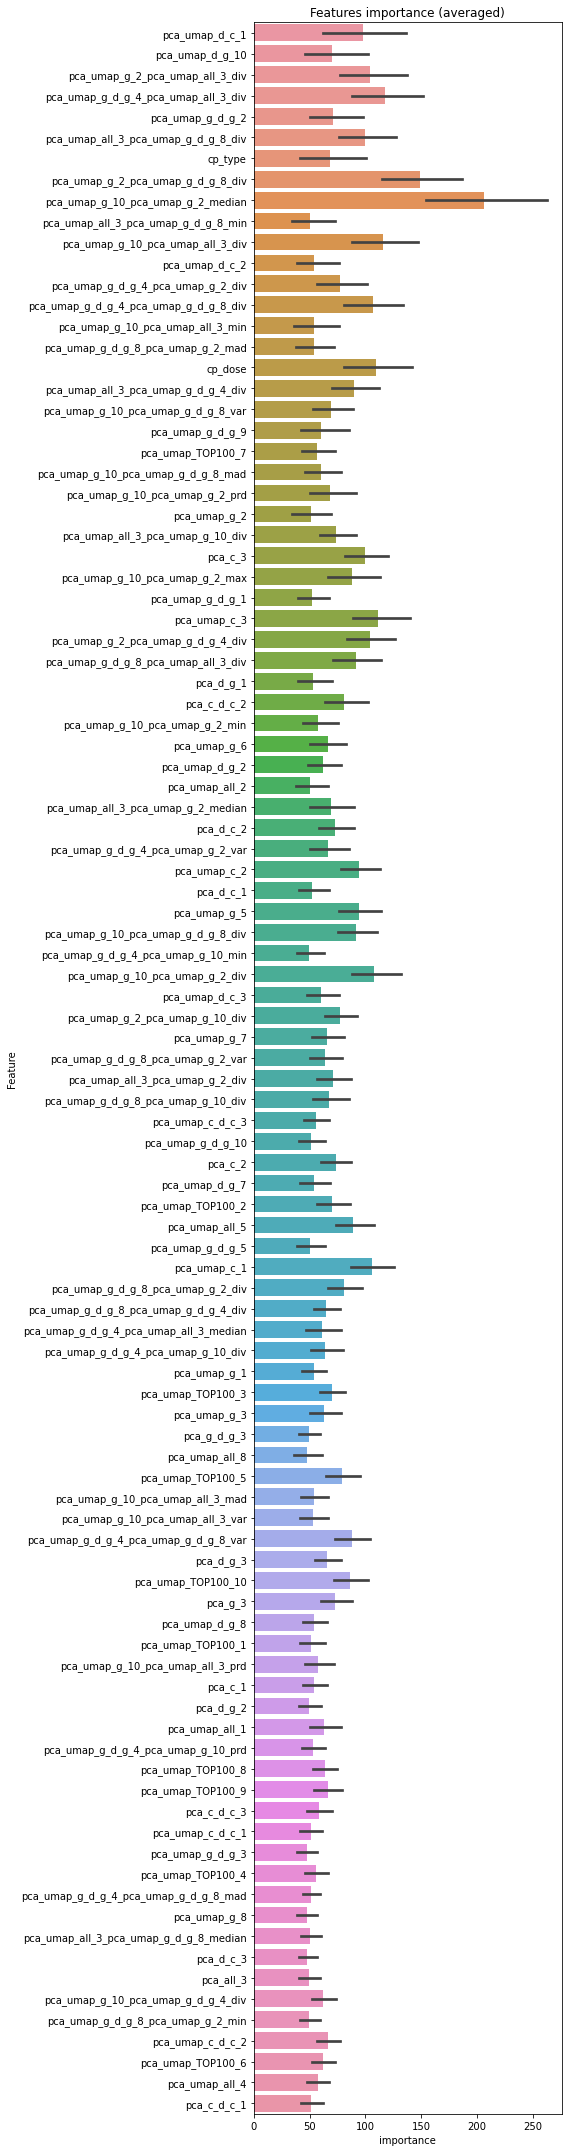

In [57]:
if DEBUG:
    show_feature_importance(feature_importance_df)